In [50]:
import os
import numpy as np
from PIL import Image

from tensorflow import keras
from tensorflow.keras.datasets import mnist
import numpy as np
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense,BatchNormalization,Flatten,Input

from tensorflow.keras.optimizers import Adam
adam = Adam(0.0002,0.5)
from tensorflow.keras.layers import LeakyReLU
acti = LeakyReLU(alpha = 0.2)

In [2]:
im_list = os.listdir('New folder/Humans')


In [3]:
x_train = []
for i in range(len(im_list)):
    temp = Image.open('New folder/Humans/{}'.format(im_list[i]))
    if temp.size[1] > temp.size[0]:   #only potrait
        x_train.append(np.array(temp.convert('L').resize((40,50))))

C:\Users\saile\anaconda3\envs\tf\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
x_train = np.array(x_train)

In [5]:
#image standardization

x_train = np.array(x_train)

x_train = (x_train.astype(np.float32)-127.5) / 127.5

x_train = np.expand_dims(x_train,axis = 3)

In [48]:
image_shape = (50, 40,1)
batch_size = 128
half_batch = int(batch_size/2)
epochs = 50000


In [9]:
#defining the generator model
def Generator():
    noise_shape = (100,)
    
    model = Sequential([
        keras.layers.Dense(128,input_shape = noise_shape,activation = acti),
        keras.layers.BatchNormalization(momentum = 0.8),
        keras.layers.Dense(256,activation = acti),
        keras.layers.BatchNormalization(momentum = 0.8),
        keras.layers.Dense(512,activation = acti),
        keras.layers.BatchNormalization(momentum = 0.8),
        keras.layers.Dense(1024,activation = acti),
        keras.layers.BatchNormalization(momentum = 0.8),
        keras.layers.Dense(np.prod(image_shape),activation = 'tanh'),
        keras.layers.Reshape(image_shape)
    ])
    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image
    
    model.summary()
    
    return Model(noise, img)

g = Generator()   
g.compile(loss = 'binary_crossentropy',optimizer = adam)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              5

In [10]:
#defining the discriminator model
def Discriminator():

    model = Sequential([
        Flatten(input_shape = image_shape),
        Dense(512,activation = acti),
        Dense(256,activation = acti),
        Dense(128,activation = acti),
        Dense(64,activation = acti),
        Dense(10,activation = acti),
        Dense(1,activation = 'sigmoid')
    ])
    
    img = Input(shape=image_shape)
    validity = model(img)
    
    model.summary()

    return Model(img, validity)

d = Discriminator()
d.compile(loss = 'binary_crossentropy',metrics = ['accuracy'],optimizer = adam)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1024512   
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

In [49]:
#defining the combined model
z = Input(shape = (100,))
img = g(z)

#the discriminator should stop training while the model train generator
d.trainable = False

valid = d(img)

c = Model(z,valid)
c.compile(loss='binary_crossentropy', optimizer=adam,metrics = 'accuracy')#defining the combined model
z = Input(shape = (100,))
img = g(z)

#the discriminator should stop training while the model train generator
d.trainable = False

valid = d(img)

c = Model(z,valid)
c.compile(loss='binary_crossentropy', optimizer=adam,metrics = 'accuracy')

In [28]:
for i in range(epochs):
    
    # ---------------------
    #  Train Discriminator
    # ---------------------

    ##training the discriminator half batch with real images
    x_index = np.random.randint(0,x_train.shape[0],half_batch)
    rand_train_images = x_train[x_index]

    ##training the discriminators other half batch with images generated by generator
    #noise generation for the generator
    #the shape of noise vector is 1D 100 and of quantity half batch
    noise = np.random.normal(0,1,(half_batch,100))

    gen_imgs = g.predict(noise)
    
    d_real_loss = d.train_on_batch(rand_train_images,np.ones((half_batch,1)))
    d_fake_loss = d.train_on_batch(gen_imgs,np.zeros((half_batch,1)))
    
    d_loss = (np.add(d_real_loss,d_fake_loss))/2
    
    # ---------------------
    #  Train Generator
    # ---------------------
    
    noise = np.random.normal(0,1,(batch_size,100))
    
    # the images are sent to discriminator as real even they a fale
    gen_y_label = np.array([1] * batch_size)
    
    g_loss = c.train_on_batch(noise,gen_y_label)
    
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss[0]))

0 [D loss: 0.026846, acc.: 98.44%] [G loss: 6.914055]
1 [D loss: 0.020059, acc.: 99.22%] [G loss: 7.552500]
2 [D loss: 0.020832, acc.: 100.00%] [G loss: 6.594700]
3 [D loss: 0.012918, acc.: 100.00%] [G loss: 6.258479]
4 [D loss: 0.006483, acc.: 100.00%] [G loss: 6.175582]
5 [D loss: 0.033636, acc.: 98.44%] [G loss: 6.437482]
6 [D loss: 0.002105, acc.: 100.00%] [G loss: 7.672582]
7 [D loss: 0.012850, acc.: 100.00%] [G loss: 6.164615]
8 [D loss: 0.160762, acc.: 95.31%] [G loss: 6.627594]
9 [D loss: 0.055663, acc.: 98.44%] [G loss: 7.990955]
10 [D loss: 0.053124, acc.: 99.22%] [G loss: 7.665388]
11 [D loss: 0.150248, acc.: 96.88%] [G loss: 7.456180]
12 [D loss: 0.039213, acc.: 99.22%] [G loss: 7.243169]
13 [D loss: 0.030277, acc.: 99.22%] [G loss: 7.755506]
14 [D loss: 0.015747, acc.: 99.22%] [G loss: 6.022734]
15 [D loss: 0.007941, acc.: 100.00%] [G loss: 6.918601]
16 [D loss: 0.003221, acc.: 100.00%] [G loss: 7.523515]
17 [D loss: 0.038535, acc.: 98.44%] [G loss: 5.872536]
18 [D loss: 0

148 [D loss: 0.015039, acc.: 100.00%] [G loss: 9.883114]
149 [D loss: 0.051127, acc.: 98.44%] [G loss: 6.800596]
150 [D loss: 0.006533, acc.: 100.00%] [G loss: 7.693974]
151 [D loss: 0.001954, acc.: 100.00%] [G loss: 7.285456]
152 [D loss: 0.034744, acc.: 98.44%] [G loss: 6.968136]
153 [D loss: 0.028146, acc.: 98.44%] [G loss: 8.581579]
154 [D loss: 0.009114, acc.: 100.00%] [G loss: 6.782516]
155 [D loss: 0.070406, acc.: 97.66%] [G loss: 8.489552]
156 [D loss: 0.027556, acc.: 99.22%] [G loss: 6.632515]
157 [D loss: 0.001900, acc.: 100.00%] [G loss: 8.590178]
158 [D loss: 0.016506, acc.: 99.22%] [G loss: 6.710451]
159 [D loss: 0.021753, acc.: 99.22%] [G loss: 10.416615]
160 [D loss: 0.001796, acc.: 100.00%] [G loss: 8.152966]
161 [D loss: 0.013008, acc.: 99.22%] [G loss: 6.006109]
162 [D loss: 0.013048, acc.: 99.22%] [G loss: 6.892509]
163 [D loss: 0.021927, acc.: 99.22%] [G loss: 9.959607]
164 [D loss: 0.023052, acc.: 99.22%] [G loss: 6.395234]
165 [D loss: 0.118239, acc.: 93.75%] [G l

294 [D loss: 0.004202, acc.: 100.00%] [G loss: 9.805129]
295 [D loss: 0.007472, acc.: 100.00%] [G loss: 6.242124]
296 [D loss: 0.007269, acc.: 100.00%] [G loss: 9.403572]
297 [D loss: 0.053880, acc.: 98.44%] [G loss: 8.334060]
298 [D loss: 0.023572, acc.: 99.22%] [G loss: 7.655035]
299 [D loss: 0.018597, acc.: 98.44%] [G loss: 10.276156]
300 [D loss: 0.021505, acc.: 100.00%] [G loss: 7.278576]
301 [D loss: 0.019315, acc.: 99.22%] [G loss: 6.934889]
302 [D loss: 0.032748, acc.: 98.44%] [G loss: 10.308662]
303 [D loss: 0.024810, acc.: 98.44%] [G loss: 9.458155]
304 [D loss: 0.008315, acc.: 99.22%] [G loss: 7.832963]
305 [D loss: 0.025634, acc.: 99.22%] [G loss: 7.805179]
306 [D loss: 0.001755, acc.: 100.00%] [G loss: 7.635214]
307 [D loss: 0.031456, acc.: 98.44%] [G loss: 9.792482]
308 [D loss: 0.052862, acc.: 98.44%] [G loss: 6.867223]
309 [D loss: 0.022923, acc.: 98.44%] [G loss: 9.199805]
310 [D loss: 0.093411, acc.: 96.88%] [G loss: 7.732583]
311 [D loss: 0.043392, acc.: 98.44%] [G l

439 [D loss: 0.028656, acc.: 99.22%] [G loss: 6.422000]
440 [D loss: 0.015803, acc.: 99.22%] [G loss: 6.341076]
441 [D loss: 0.030243, acc.: 99.22%] [G loss: 7.515453]
442 [D loss: 0.005629, acc.: 100.00%] [G loss: 6.289335]
443 [D loss: 0.076618, acc.: 98.44%] [G loss: 9.728184]
444 [D loss: 0.078611, acc.: 98.44%] [G loss: 14.728941]
445 [D loss: 0.269377, acc.: 92.19%] [G loss: 12.385281]
446 [D loss: 0.098512, acc.: 96.88%] [G loss: 11.786973]
447 [D loss: 0.086220, acc.: 97.66%] [G loss: 11.256098]
448 [D loss: 0.067750, acc.: 99.22%] [G loss: 10.132778]
449 [D loss: 0.012231, acc.: 100.00%] [G loss: 9.575929]
450 [D loss: 0.083160, acc.: 99.22%] [G loss: 8.663182]
451 [D loss: 0.027177, acc.: 99.22%] [G loss: 8.454521]
452 [D loss: 0.005132, acc.: 100.00%] [G loss: 7.465272]
453 [D loss: 0.004688, acc.: 100.00%] [G loss: 7.376557]
454 [D loss: 0.031370, acc.: 98.44%] [G loss: 8.057060]
455 [D loss: 0.006295, acc.: 100.00%] [G loss: 6.882768]
456 [D loss: 0.040530, acc.: 98.44%] [

585 [D loss: 0.007519, acc.: 100.00%] [G loss: 7.009646]
586 [D loss: 0.101476, acc.: 96.88%] [G loss: 6.212136]
587 [D loss: 0.001602, acc.: 100.00%] [G loss: 8.542347]
588 [D loss: 0.020107, acc.: 99.22%] [G loss: 6.532360]
589 [D loss: 0.003310, acc.: 100.00%] [G loss: 6.889901]
590 [D loss: 0.017542, acc.: 99.22%] [G loss: 7.183943]
591 [D loss: 0.003812, acc.: 100.00%] [G loss: 6.456194]
592 [D loss: 0.019264, acc.: 98.44%] [G loss: 5.059295]
593 [D loss: 0.017352, acc.: 100.00%] [G loss: 5.075682]
594 [D loss: 0.011100, acc.: 99.22%] [G loss: 5.099052]
595 [D loss: 0.006350, acc.: 100.00%] [G loss: 4.759009]
596 [D loss: 0.016440, acc.: 100.00%] [G loss: 5.429362]
597 [D loss: 0.050872, acc.: 98.44%] [G loss: 6.622325]
598 [D loss: 0.007311, acc.: 100.00%] [G loss: 11.338974]
599 [D loss: 0.005575, acc.: 100.00%] [G loss: 9.192934]
600 [D loss: 0.018869, acc.: 99.22%] [G loss: 5.187239]
601 [D loss: 0.028383, acc.: 99.22%] [G loss: 9.139183]
602 [D loss: 0.007293, acc.: 100.00%] 

730 [D loss: 0.061678, acc.: 94.53%] [G loss: 8.100744]
731 [D loss: 0.090167, acc.: 97.66%] [G loss: 8.524315]
732 [D loss: 0.020281, acc.: 98.44%] [G loss: 8.699319]
733 [D loss: 0.005315, acc.: 100.00%] [G loss: 8.113632]
734 [D loss: 0.002462, acc.: 100.00%] [G loss: 7.775280]
735 [D loss: 0.025483, acc.: 99.22%] [G loss: 8.265844]
736 [D loss: 0.003121, acc.: 100.00%] [G loss: 9.094213]
737 [D loss: 0.002435, acc.: 100.00%] [G loss: 8.633677]
738 [D loss: 0.014345, acc.: 99.22%] [G loss: 7.005996]
739 [D loss: 0.026654, acc.: 99.22%] [G loss: 6.998713]
740 [D loss: 0.003705, acc.: 100.00%] [G loss: 8.885210]
741 [D loss: 0.002006, acc.: 100.00%] [G loss: 6.792886]
742 [D loss: 0.004539, acc.: 100.00%] [G loss: 5.267444]
743 [D loss: 0.020411, acc.: 100.00%] [G loss: 5.417364]
744 [D loss: 0.048179, acc.: 98.44%] [G loss: 6.100626]
745 [D loss: 0.009631, acc.: 99.22%] [G loss: 6.785766]
746 [D loss: 0.003812, acc.: 100.00%] [G loss: 10.143178]
747 [D loss: 0.109962, acc.: 96.09%] [

876 [D loss: 0.067504, acc.: 98.44%] [G loss: 7.898258]
877 [D loss: 0.021863, acc.: 99.22%] [G loss: 7.596609]
878 [D loss: 0.002785, acc.: 100.00%] [G loss: 7.642366]
879 [D loss: 0.003012, acc.: 100.00%] [G loss: 7.419702]
880 [D loss: 0.037510, acc.: 99.22%] [G loss: 6.973912]
881 [D loss: 0.002623, acc.: 100.00%] [G loss: 6.954624]
882 [D loss: 0.005056, acc.: 100.00%] [G loss: 6.409344]
883 [D loss: 0.005678, acc.: 100.00%] [G loss: 6.482372]
884 [D loss: 0.001278, acc.: 100.00%] [G loss: 6.990992]
885 [D loss: 0.002018, acc.: 100.00%] [G loss: 5.977519]
886 [D loss: 0.007263, acc.: 100.00%] [G loss: 5.784073]
887 [D loss: 0.007016, acc.: 100.00%] [G loss: 5.078478]
888 [D loss: 0.007979, acc.: 100.00%] [G loss: 6.828412]
889 [D loss: 0.026144, acc.: 99.22%] [G loss: 5.853263]
890 [D loss: 0.007021, acc.: 100.00%] [G loss: 6.238388]
891 [D loss: 0.024749, acc.: 98.44%] [G loss: 5.167780]
892 [D loss: 0.012194, acc.: 100.00%] [G loss: 5.907607]
893 [D loss: 0.009270, acc.: 99.22%]

1023 [D loss: 0.006825, acc.: 100.00%] [G loss: 6.493358]
1024 [D loss: 0.029863, acc.: 99.22%] [G loss: 5.777781]
1025 [D loss: 0.012126, acc.: 100.00%] [G loss: 5.255906]
1026 [D loss: 0.006043, acc.: 100.00%] [G loss: 5.690132]
1027 [D loss: 0.004545, acc.: 100.00%] [G loss: 6.022479]
1028 [D loss: 0.026801, acc.: 98.44%] [G loss: 5.485706]
1029 [D loss: 0.009339, acc.: 100.00%] [G loss: 5.016410]
1030 [D loss: 0.007549, acc.: 100.00%] [G loss: 5.085253]
1031 [D loss: 0.010560, acc.: 100.00%] [G loss: 5.139566]
1032 [D loss: 0.004747, acc.: 100.00%] [G loss: 6.642592]
1033 [D loss: 0.019574, acc.: 99.22%] [G loss: 10.012169]
1034 [D loss: 0.004866, acc.: 100.00%] [G loss: 8.675357]
1035 [D loss: 0.161775, acc.: 93.75%] [G loss: 7.936064]
1036 [D loss: 0.040606, acc.: 99.22%] [G loss: 9.003073]
1037 [D loss: 0.152586, acc.: 98.44%] [G loss: 8.950676]
1038 [D loss: 0.007962, acc.: 100.00%] [G loss: 8.150099]
1039 [D loss: 0.025090, acc.: 98.44%] [G loss: 7.571879]
1040 [D loss: 0.0883

1166 [D loss: 0.004367, acc.: 100.00%] [G loss: 9.212938]
1167 [D loss: 0.006180, acc.: 100.00%] [G loss: 5.797831]
1168 [D loss: 0.019142, acc.: 99.22%] [G loss: 11.585395]
1169 [D loss: 0.002982, acc.: 100.00%] [G loss: 13.339637]
1170 [D loss: 0.006504, acc.: 100.00%] [G loss: 6.223157]
1171 [D loss: 0.009690, acc.: 100.00%] [G loss: 10.296612]
1172 [D loss: 0.007168, acc.: 100.00%] [G loss: 6.795630]
1173 [D loss: 0.006060, acc.: 100.00%] [G loss: 10.224644]
1174 [D loss: 0.002713, acc.: 100.00%] [G loss: 6.132104]
1175 [D loss: 0.043716, acc.: 97.66%] [G loss: 9.779098]
1176 [D loss: 0.204190, acc.: 89.84%] [G loss: 9.740786]
1177 [D loss: 0.135225, acc.: 96.09%] [G loss: 11.754998]
1178 [D loss: 0.059859, acc.: 99.22%] [G loss: 11.884798]
1179 [D loss: 0.219084, acc.: 94.53%] [G loss: 9.835382]
1180 [D loss: 0.003507, acc.: 100.00%] [G loss: 9.082710]
1181 [D loss: 0.049933, acc.: 98.44%] [G loss: 8.787482]
1182 [D loss: 0.004339, acc.: 100.00%] [G loss: 8.043731]
1183 [D loss: 0

1309 [D loss: 0.008314, acc.: 99.22%] [G loss: 8.234106]
1310 [D loss: 0.011262, acc.: 99.22%] [G loss: 8.835631]
1311 [D loss: 0.073881, acc.: 96.09%] [G loss: 9.472179]
1312 [D loss: 0.113337, acc.: 91.41%] [G loss: 11.120140]
1313 [D loss: 0.020182, acc.: 98.44%] [G loss: 11.432060]
1314 [D loss: 0.068088, acc.: 97.66%] [G loss: 10.476919]
1315 [D loss: 0.011797, acc.: 100.00%] [G loss: 9.340638]
1316 [D loss: 0.059217, acc.: 97.66%] [G loss: 9.466383]
1317 [D loss: 0.027126, acc.: 98.44%] [G loss: 8.781330]
1318 [D loss: 0.003536, acc.: 100.00%] [G loss: 7.983391]
1319 [D loss: 0.007371, acc.: 100.00%] [G loss: 8.245340]
1320 [D loss: 0.001135, acc.: 100.00%] [G loss: 9.241728]
1321 [D loss: 0.001471, acc.: 100.00%] [G loss: 8.583359]
1322 [D loss: 0.003979, acc.: 100.00%] [G loss: 7.205284]
1323 [D loss: 0.030284, acc.: 97.66%] [G loss: 7.069122]
1324 [D loss: 0.004498, acc.: 100.00%] [G loss: 7.310268]
1325 [D loss: 0.052732, acc.: 98.44%] [G loss: 8.578488]
1326 [D loss: 0.00925

1452 [D loss: 0.102823, acc.: 98.44%] [G loss: 9.486096]
1453 [D loss: 0.019463, acc.: 99.22%] [G loss: 8.904362]
1454 [D loss: 0.001255, acc.: 100.00%] [G loss: 9.722356]
1455 [D loss: 0.003933, acc.: 100.00%] [G loss: 8.593511]
1456 [D loss: 0.019125, acc.: 98.44%] [G loss: 8.861641]
1457 [D loss: 0.109357, acc.: 96.88%] [G loss: 8.207006]
1458 [D loss: 0.081183, acc.: 99.22%] [G loss: 6.097948]
1459 [D loss: 0.009075, acc.: 100.00%] [G loss: 4.951871]
1460 [D loss: 0.005535, acc.: 100.00%] [G loss: 5.550115]
1461 [D loss: 0.006410, acc.: 100.00%] [G loss: 4.811148]
1462 [D loss: 0.010746, acc.: 100.00%] [G loss: 5.283283]
1463 [D loss: 0.003330, acc.: 100.00%] [G loss: 6.632448]
1464 [D loss: 0.009706, acc.: 100.00%] [G loss: 7.339008]
1465 [D loss: 0.039149, acc.: 97.66%] [G loss: 10.138697]
1466 [D loss: 0.009481, acc.: 99.22%] [G loss: 7.672835]
1467 [D loss: 0.042708, acc.: 99.22%] [G loss: 8.713290]
1468 [D loss: 0.105526, acc.: 95.31%] [G loss: 8.196714]
1469 [D loss: 0.026110

1595 [D loss: 0.001744, acc.: 100.00%] [G loss: 5.490678]
1596 [D loss: 0.105370, acc.: 98.44%] [G loss: 5.527737]
1597 [D loss: 0.002783, acc.: 100.00%] [G loss: 6.236107]
1598 [D loss: 0.008814, acc.: 100.00%] [G loss: 7.039566]
1599 [D loss: 0.025657, acc.: 98.44%] [G loss: 4.671754]
1600 [D loss: 0.010755, acc.: 100.00%] [G loss: 4.170010]
1601 [D loss: 0.020669, acc.: 100.00%] [G loss: 4.193020]
1602 [D loss: 0.006524, acc.: 100.00%] [G loss: 4.377856]
1603 [D loss: 0.019574, acc.: 99.22%] [G loss: 6.001554]
1604 [D loss: 0.011989, acc.: 99.22%] [G loss: 8.513666]
1605 [D loss: 0.001720, acc.: 100.00%] [G loss: 10.227139]
1606 [D loss: 0.015492, acc.: 100.00%] [G loss: 6.349125]
1607 [D loss: 0.012089, acc.: 99.22%] [G loss: 5.762881]
1608 [D loss: 0.014595, acc.: 99.22%] [G loss: 5.780612]
1609 [D loss: 0.032613, acc.: 99.22%] [G loss: 7.916030]
1610 [D loss: 0.003548, acc.: 100.00%] [G loss: 7.753795]
1611 [D loss: 0.004916, acc.: 100.00%] [G loss: 6.791515]
1612 [D loss: 0.1056

1738 [D loss: 0.182548, acc.: 94.53%] [G loss: 10.491341]
1739 [D loss: 0.123632, acc.: 96.88%] [G loss: 11.880958]
1740 [D loss: 0.042123, acc.: 97.66%] [G loss: 10.007075]
1741 [D loss: 0.094809, acc.: 99.22%] [G loss: 9.858900]
1742 [D loss: 0.055402, acc.: 98.44%] [G loss: 9.016708]
1743 [D loss: 0.105876, acc.: 96.88%] [G loss: 8.081454]
1744 [D loss: 0.017672, acc.: 99.22%] [G loss: 7.711515]
1745 [D loss: 0.006372, acc.: 100.00%] [G loss: 7.501194]
1746 [D loss: 0.059776, acc.: 97.66%] [G loss: 7.626187]
1747 [D loss: 0.077947, acc.: 98.44%] [G loss: 7.231210]
1748 [D loss: 0.040373, acc.: 99.22%] [G loss: 6.135705]
1749 [D loss: 0.005723, acc.: 100.00%] [G loss: 6.324331]
1750 [D loss: 0.030858, acc.: 99.22%] [G loss: 5.779309]
1751 [D loss: 0.014852, acc.: 100.00%] [G loss: 6.369988]
1752 [D loss: 0.029817, acc.: 99.22%] [G loss: 6.082975]
1753 [D loss: 0.007480, acc.: 100.00%] [G loss: 5.817258]
1754 [D loss: 0.097765, acc.: 97.66%] [G loss: 5.839080]
1755 [D loss: 0.013026, 

1883 [D loss: 0.046688, acc.: 96.88%] [G loss: 7.259356]
1884 [D loss: 0.091585, acc.: 93.75%] [G loss: 7.723999]
1885 [D loss: 0.062178, acc.: 97.66%] [G loss: 8.616116]
1886 [D loss: 0.042135, acc.: 99.22%] [G loss: 8.638466]
1887 [D loss: 0.014959, acc.: 100.00%] [G loss: 7.456407]
1888 [D loss: 0.056988, acc.: 99.22%] [G loss: 8.274470]
1889 [D loss: 0.029274, acc.: 98.44%] [G loss: 6.187013]
1890 [D loss: 0.032976, acc.: 97.66%] [G loss: 5.960189]
1891 [D loss: 0.020295, acc.: 99.22%] [G loss: 6.227119]
1892 [D loss: 0.032328, acc.: 98.44%] [G loss: 6.187246]
1893 [D loss: 0.028779, acc.: 99.22%] [G loss: 5.648269]
1894 [D loss: 0.011515, acc.: 100.00%] [G loss: 5.901973]
1895 [D loss: 0.004957, acc.: 100.00%] [G loss: 8.973236]
1896 [D loss: 0.013833, acc.: 99.22%] [G loss: 7.062112]
1897 [D loss: 0.004274, acc.: 100.00%] [G loss: 8.874548]
1898 [D loss: 0.030385, acc.: 99.22%] [G loss: 5.729375]
1899 [D loss: 0.069438, acc.: 96.88%] [G loss: 7.511150]
1900 [D loss: 0.024746, acc

2026 [D loss: 0.045336, acc.: 99.22%] [G loss: 7.234776]
2027 [D loss: 0.015022, acc.: 100.00%] [G loss: 7.099833]
2028 [D loss: 0.013638, acc.: 100.00%] [G loss: 6.704244]
2029 [D loss: 0.048746, acc.: 99.22%] [G loss: 8.335859]
2030 [D loss: 0.021722, acc.: 100.00%] [G loss: 6.905357]
2031 [D loss: 0.026852, acc.: 99.22%] [G loss: 7.303092]
2032 [D loss: 0.192350, acc.: 86.72%] [G loss: 12.793137]
2033 [D loss: 0.291080, acc.: 92.97%] [G loss: 13.115366]
2034 [D loss: 0.284941, acc.: 93.75%] [G loss: 10.680543]
2035 [D loss: 0.004873, acc.: 100.00%] [G loss: 8.664593]
2036 [D loss: 0.070737, acc.: 97.66%] [G loss: 9.623484]
2037 [D loss: 0.016069, acc.: 99.22%] [G loss: 8.887020]
2038 [D loss: 0.005370, acc.: 100.00%] [G loss: 8.742653]
2039 [D loss: 0.012176, acc.: 99.22%] [G loss: 8.658658]
2040 [D loss: 0.007817, acc.: 100.00%] [G loss: 8.163774]
2041 [D loss: 0.082187, acc.: 98.44%] [G loss: 7.158794]
2042 [D loss: 0.002475, acc.: 100.00%] [G loss: 7.057099]
2043 [D loss: 0.03510

2169 [D loss: 0.008074, acc.: 100.00%] [G loss: 7.071939]
2170 [D loss: 0.026293, acc.: 99.22%] [G loss: 7.181180]
2171 [D loss: 0.026455, acc.: 99.22%] [G loss: 6.519166]
2172 [D loss: 0.066354, acc.: 99.22%] [G loss: 6.018429]
2173 [D loss: 0.002667, acc.: 100.00%] [G loss: 5.629555]
2174 [D loss: 0.077241, acc.: 99.22%] [G loss: 5.338715]
2175 [D loss: 0.030959, acc.: 99.22%] [G loss: 4.947632]
2176 [D loss: 0.064308, acc.: 98.44%] [G loss: 4.738632]
2177 [D loss: 0.043069, acc.: 100.00%] [G loss: 6.017302]
2178 [D loss: 0.040492, acc.: 97.66%] [G loss: 6.239918]
2179 [D loss: 0.044945, acc.: 99.22%] [G loss: 8.132396]
2180 [D loss: 0.004020, acc.: 100.00%] [G loss: 7.998734]
2181 [D loss: 0.034869, acc.: 99.22%] [G loss: 7.285256]
2182 [D loss: 0.090256, acc.: 99.22%] [G loss: 9.259705]
2183 [D loss: 0.013941, acc.: 99.22%] [G loss: 10.644585]
2184 [D loss: 0.012488, acc.: 99.22%] [G loss: 11.499571]
2185 [D loss: 0.053364, acc.: 97.66%] [G loss: 8.514120]
2186 [D loss: 0.002561, a

2312 [D loss: 0.017537, acc.: 100.00%] [G loss: 6.292015]
2313 [D loss: 0.017843, acc.: 100.00%] [G loss: 5.871613]
2314 [D loss: 0.029317, acc.: 98.44%] [G loss: 6.929241]
2315 [D loss: 0.016799, acc.: 99.22%] [G loss: 5.729743]
2316 [D loss: 0.009207, acc.: 100.00%] [G loss: 5.441505]
2317 [D loss: 0.019490, acc.: 99.22%] [G loss: 5.556646]
2318 [D loss: 0.003191, acc.: 100.00%] [G loss: 7.465631]
2319 [D loss: 0.059446, acc.: 99.22%] [G loss: 11.333015]
2320 [D loss: 0.043059, acc.: 97.66%] [G loss: 5.119877]
2321 [D loss: 0.006177, acc.: 100.00%] [G loss: 6.757456]
2322 [D loss: 0.004653, acc.: 100.00%] [G loss: 9.672991]
2323 [D loss: 0.011902, acc.: 99.22%] [G loss: 6.674736]
2324 [D loss: 0.011663, acc.: 100.00%] [G loss: 7.685498]
2325 [D loss: 0.003407, acc.: 100.00%] [G loss: 7.746606]
2326 [D loss: 0.051641, acc.: 98.44%] [G loss: 8.538868]
2327 [D loss: 0.014998, acc.: 100.00%] [G loss: 8.533003]
2328 [D loss: 0.008763, acc.: 100.00%] [G loss: 6.485665]
2329 [D loss: 0.0043

2457 [D loss: 0.005733, acc.: 100.00%] [G loss: 8.165996]
2458 [D loss: 0.003959, acc.: 100.00%] [G loss: 7.905138]
2459 [D loss: 0.015009, acc.: 100.00%] [G loss: 8.680590]
2460 [D loss: 0.008747, acc.: 100.00%] [G loss: 8.294130]
2461 [D loss: 0.059386, acc.: 99.22%] [G loss: 8.078360]
2462 [D loss: 0.002043, acc.: 100.00%] [G loss: 6.948907]
2463 [D loss: 0.046140, acc.: 98.44%] [G loss: 7.962608]
2464 [D loss: 0.005217, acc.: 100.00%] [G loss: 9.018715]
2465 [D loss: 0.052711, acc.: 99.22%] [G loss: 8.174063]
2466 [D loss: 0.039671, acc.: 98.44%] [G loss: 6.972181]
2467 [D loss: 0.022131, acc.: 99.22%] [G loss: 7.771813]
2468 [D loss: 0.034435, acc.: 97.66%] [G loss: 6.600288]
2469 [D loss: 0.006120, acc.: 100.00%] [G loss: 7.541801]
2470 [D loss: 0.005959, acc.: 100.00%] [G loss: 6.361676]
2471 [D loss: 0.002109, acc.: 100.00%] [G loss: 5.989367]
2472 [D loss: 0.088569, acc.: 96.88%] [G loss: 8.163587]
2473 [D loss: 0.008403, acc.: 100.00%] [G loss: 10.064428]
2474 [D loss: 0.1079

2602 [D loss: 0.020490, acc.: 100.00%] [G loss: 6.394595]
2603 [D loss: 0.013624, acc.: 99.22%] [G loss: 6.296350]
2604 [D loss: 0.005959, acc.: 100.00%] [G loss: 6.167267]
2605 [D loss: 0.003930, acc.: 100.00%] [G loss: 6.970169]
2606 [D loss: 0.003741, acc.: 100.00%] [G loss: 7.184102]
2607 [D loss: 0.004231, acc.: 100.00%] [G loss: 5.875294]
2608 [D loss: 0.012680, acc.: 99.22%] [G loss: 7.181360]
2609 [D loss: 0.005721, acc.: 100.00%] [G loss: 8.736424]
2610 [D loss: 0.005761, acc.: 100.00%] [G loss: 7.287574]
2611 [D loss: 0.009545, acc.: 100.00%] [G loss: 7.875000]
2612 [D loss: 0.014085, acc.: 99.22%] [G loss: 6.917893]
2613 [D loss: 0.008486, acc.: 99.22%] [G loss: 6.328320]
2614 [D loss: 0.005673, acc.: 100.00%] [G loss: 7.325015]
2615 [D loss: 0.044310, acc.: 97.66%] [G loss: 5.535563]
2616 [D loss: 0.003782, acc.: 100.00%] [G loss: 6.749510]
2617 [D loss: 0.054303, acc.: 96.88%] [G loss: 10.043699]
2618 [D loss: 0.009885, acc.: 99.22%] [G loss: 9.462938]
2619 [D loss: 0.1322

2745 [D loss: 0.053247, acc.: 99.22%] [G loss: 6.767169]
2746 [D loss: 0.002789, acc.: 100.00%] [G loss: 8.134234]
2747 [D loss: 0.022209, acc.: 98.44%] [G loss: 7.440804]
2748 [D loss: 0.005971, acc.: 100.00%] [G loss: 7.074865]
2749 [D loss: 0.011864, acc.: 100.00%] [G loss: 7.190581]
2750 [D loss: 0.057606, acc.: 98.44%] [G loss: 7.509045]
2751 [D loss: 0.002799, acc.: 100.00%] [G loss: 7.103640]
2752 [D loss: 0.055827, acc.: 98.44%] [G loss: 6.139558]
2753 [D loss: 0.074558, acc.: 98.44%] [G loss: 7.330833]
2754 [D loss: 0.024746, acc.: 98.44%] [G loss: 7.897649]
2755 [D loss: 0.010630, acc.: 100.00%] [G loss: 6.644950]
2756 [D loss: 0.070880, acc.: 99.22%] [G loss: 6.249259]
2757 [D loss: 0.007078, acc.: 100.00%] [G loss: 6.233562]
2758 [D loss: 0.006271, acc.: 100.00%] [G loss: 5.448672]
2759 [D loss: 0.007648, acc.: 100.00%] [G loss: 6.015371]
2760 [D loss: 0.005847, acc.: 100.00%] [G loss: 6.218725]
2761 [D loss: 0.055036, acc.: 99.22%] [G loss: 5.372488]
2762 [D loss: 0.023032

2890 [D loss: 0.000728, acc.: 100.00%] [G loss: 9.149466]
2891 [D loss: 0.001405, acc.: 100.00%] [G loss: 7.322154]
2892 [D loss: 0.004673, acc.: 100.00%] [G loss: 7.051827]
2893 [D loss: 0.000796, acc.: 100.00%] [G loss: 9.091946]
2894 [D loss: 0.013230, acc.: 100.00%] [G loss: 8.362867]
2895 [D loss: 0.001336, acc.: 100.00%] [G loss: 10.842574]
2896 [D loss: 0.036373, acc.: 99.22%] [G loss: 5.654913]
2897 [D loss: 0.037193, acc.: 99.22%] [G loss: 6.858856]
2898 [D loss: 0.010969, acc.: 100.00%] [G loss: 6.264705]
2899 [D loss: 0.006755, acc.: 100.00%] [G loss: 9.063795]
2900 [D loss: 0.004557, acc.: 100.00%] [G loss: 9.252008]
2901 [D loss: 0.005986, acc.: 100.00%] [G loss: 7.023235]
2902 [D loss: 0.055631, acc.: 99.22%] [G loss: 6.041748]
2903 [D loss: 0.088854, acc.: 99.22%] [G loss: 7.181550]
2904 [D loss: 0.006592, acc.: 100.00%] [G loss: 10.172598]
2905 [D loss: 0.050714, acc.: 98.44%] [G loss: 9.513364]
2906 [D loss: 0.005009, acc.: 100.00%] [G loss: 9.023338]
2907 [D loss: 0.1

3032 [D loss: 0.002170, acc.: 100.00%] [G loss: 6.376623]
3033 [D loss: 0.002294, acc.: 100.00%] [G loss: 6.386531]
3034 [D loss: 0.017125, acc.: 98.44%] [G loss: 6.893155]
3035 [D loss: 0.002605, acc.: 100.00%] [G loss: 6.163807]
3036 [D loss: 0.002863, acc.: 100.00%] [G loss: 6.308534]
3037 [D loss: 0.002659, acc.: 100.00%] [G loss: 6.715282]
3038 [D loss: 0.005989, acc.: 100.00%] [G loss: 5.924048]
3039 [D loss: 0.004093, acc.: 100.00%] [G loss: 6.150722]
3040 [D loss: 0.002625, acc.: 100.00%] [G loss: 6.416314]
3041 [D loss: 0.003272, acc.: 100.00%] [G loss: 6.577847]
3042 [D loss: 0.004058, acc.: 100.00%] [G loss: 6.119137]
3043 [D loss: 0.004113, acc.: 100.00%] [G loss: 5.961181]
3044 [D loss: 0.004043, acc.: 100.00%] [G loss: 5.922596]
3045 [D loss: 0.046806, acc.: 99.22%] [G loss: 7.332071]
3046 [D loss: 0.016713, acc.: 100.00%] [G loss: 5.855115]
3047 [D loss: 0.004587, acc.: 100.00%] [G loss: 7.071362]
3048 [D loss: 0.001118, acc.: 100.00%] [G loss: 7.123292]
3049 [D loss: 0.

3175 [D loss: 0.033412, acc.: 99.22%] [G loss: 8.136509]
3176 [D loss: 0.029979, acc.: 98.44%] [G loss: 7.698028]
3177 [D loss: 0.074498, acc.: 97.66%] [G loss: 5.424145]
3178 [D loss: 0.064614, acc.: 99.22%] [G loss: 10.293717]
3179 [D loss: 0.115083, acc.: 96.88%] [G loss: 8.236632]
3180 [D loss: 0.131251, acc.: 92.97%] [G loss: 9.355349]
3181 [D loss: 0.004173, acc.: 100.00%] [G loss: 8.852043]
3182 [D loss: 0.011765, acc.: 100.00%] [G loss: 9.075725]
3183 [D loss: 0.075140, acc.: 97.66%] [G loss: 8.042126]
3184 [D loss: 0.003789, acc.: 100.00%] [G loss: 7.266938]
3185 [D loss: 0.018249, acc.: 99.22%] [G loss: 6.802523]
3186 [D loss: 0.004229, acc.: 100.00%] [G loss: 6.299693]
3187 [D loss: 0.004906, acc.: 100.00%] [G loss: 6.009593]
3188 [D loss: 0.002425, acc.: 100.00%] [G loss: 6.310649]
3189 [D loss: 0.003422, acc.: 100.00%] [G loss: 6.551375]
3190 [D loss: 0.022679, acc.: 99.22%] [G loss: 6.856599]
3191 [D loss: 0.014155, acc.: 99.22%] [G loss: 6.413291]
3192 [D loss: 0.071256,

3319 [D loss: 0.014429, acc.: 99.22%] [G loss: 5.041840]
3320 [D loss: 0.005567, acc.: 100.00%] [G loss: 3.641634]
3321 [D loss: 0.034141, acc.: 100.00%] [G loss: 7.901316]
3322 [D loss: 0.098814, acc.: 97.66%] [G loss: 7.373695]
3323 [D loss: 0.127647, acc.: 97.66%] [G loss: 10.499203]
3324 [D loss: 0.070720, acc.: 99.22%] [G loss: 6.933937]
3325 [D loss: 0.010286, acc.: 100.00%] [G loss: 5.823436]
3326 [D loss: 0.181260, acc.: 96.09%] [G loss: 6.951540]
3327 [D loss: 0.003686, acc.: 100.00%] [G loss: 7.226174]
3328 [D loss: 0.110578, acc.: 96.09%] [G loss: 8.352123]
3329 [D loss: 0.001623, acc.: 100.00%] [G loss: 10.161309]
3330 [D loss: 0.297901, acc.: 92.97%] [G loss: 8.396770]
3331 [D loss: 0.048312, acc.: 98.44%] [G loss: 8.020636]
3332 [D loss: 0.017187, acc.: 99.22%] [G loss: 7.283874]
3333 [D loss: 0.013828, acc.: 99.22%] [G loss: 5.833314]
3334 [D loss: 0.004040, acc.: 100.00%] [G loss: 5.729534]
3335 [D loss: 0.002755, acc.: 100.00%] [G loss: 5.455878]
3336 [D loss: 0.115413

3462 [D loss: 0.014416, acc.: 100.00%] [G loss: 5.873438]
3463 [D loss: 0.004468, acc.: 100.00%] [G loss: 8.532160]
3464 [D loss: 0.059323, acc.: 97.66%] [G loss: 5.100273]
3465 [D loss: 0.006864, acc.: 100.00%] [G loss: 6.922949]
3466 [D loss: 0.009458, acc.: 100.00%] [G loss: 6.294134]
3467 [D loss: 0.029275, acc.: 99.22%] [G loss: 5.917939]
3468 [D loss: 0.000871, acc.: 100.00%] [G loss: 6.058651]
3469 [D loss: 0.068883, acc.: 98.44%] [G loss: 10.496243]
3470 [D loss: 0.030993, acc.: 100.00%] [G loss: 5.460556]
3471 [D loss: 0.025520, acc.: 99.22%] [G loss: 5.879881]
3472 [D loss: 0.012633, acc.: 100.00%] [G loss: 7.419639]
3473 [D loss: 0.085499, acc.: 97.66%] [G loss: 5.844169]
3474 [D loss: 0.037735, acc.: 99.22%] [G loss: 9.214224]
3475 [D loss: 0.025933, acc.: 99.22%] [G loss: 10.131411]
3476 [D loss: 0.803621, acc.: 84.38%] [G loss: 11.303514]
3477 [D loss: 0.235982, acc.: 90.62%] [G loss: 15.336721]
3478 [D loss: 0.403322, acc.: 94.53%] [G loss: 13.197777]
3479 [D loss: 0.165

3605 [D loss: 0.045182, acc.: 99.22%] [G loss: 8.681069]
3606 [D loss: 0.046239, acc.: 99.22%] [G loss: 6.427508]
3607 [D loss: 0.085374, acc.: 98.44%] [G loss: 9.522610]
3608 [D loss: 0.002355, acc.: 100.00%] [G loss: 8.034803]
3609 [D loss: 0.066639, acc.: 96.88%] [G loss: 8.566730]
3610 [D loss: 0.032913, acc.: 98.44%] [G loss: 9.882184]
3611 [D loss: 0.112993, acc.: 97.66%] [G loss: 9.827643]
3612 [D loss: 0.056340, acc.: 98.44%] [G loss: 7.617924]
3613 [D loss: 0.012733, acc.: 100.00%] [G loss: 6.834301]
3614 [D loss: 0.068174, acc.: 99.22%] [G loss: 6.132821]
3615 [D loss: 0.030657, acc.: 99.22%] [G loss: 5.045452]
3616 [D loss: 0.073515, acc.: 99.22%] [G loss: 6.104151]
3617 [D loss: 0.092044, acc.: 98.44%] [G loss: 7.122245]
3618 [D loss: 0.071780, acc.: 99.22%] [G loss: 7.472168]
3619 [D loss: 0.006514, acc.: 100.00%] [G loss: 7.433710]
3620 [D loss: 0.073318, acc.: 98.44%] [G loss: 5.741863]
3621 [D loss: 0.010083, acc.: 100.00%] [G loss: 6.376187]
3622 [D loss: 0.001696, acc

3749 [D loss: 0.005437, acc.: 100.00%] [G loss: 5.677701]
3750 [D loss: 0.006783, acc.: 100.00%] [G loss: 5.249149]
3751 [D loss: 0.005109, acc.: 100.00%] [G loss: 6.905267]
3752 [D loss: 0.003910, acc.: 100.00%] [G loss: 9.279663]
3753 [D loss: 0.069439, acc.: 95.31%] [G loss: 10.215635]
3754 [D loss: 0.019102, acc.: 99.22%] [G loss: 10.161125]
3755 [D loss: 0.029782, acc.: 99.22%] [G loss: 8.807713]
3756 [D loss: 0.017527, acc.: 99.22%] [G loss: 7.985942]
3757 [D loss: 0.003394, acc.: 100.00%] [G loss: 8.801155]
3758 [D loss: 0.140741, acc.: 97.66%] [G loss: 7.129248]
3759 [D loss: 0.054403, acc.: 99.22%] [G loss: 7.226118]
3760 [D loss: 0.063618, acc.: 98.44%] [G loss: 7.937066]
3761 [D loss: 0.039109, acc.: 99.22%] [G loss: 8.448320]
3762 [D loss: 0.024088, acc.: 99.22%] [G loss: 7.630368]
3763 [D loss: 0.014540, acc.: 100.00%] [G loss: 6.352674]
3764 [D loss: 0.003005, acc.: 100.00%] [G loss: 7.503871]
3765 [D loss: 0.032433, acc.: 98.44%] [G loss: 7.100366]
3766 [D loss: 0.002708

3893 [D loss: 0.047274, acc.: 98.44%] [G loss: 9.337662]
3894 [D loss: 0.019828, acc.: 99.22%] [G loss: 6.221591]
3895 [D loss: 0.001850, acc.: 100.00%] [G loss: 9.234691]
3896 [D loss: 0.117022, acc.: 89.84%] [G loss: 8.487570]
3897 [D loss: 0.020951, acc.: 100.00%] [G loss: 9.913408]
3898 [D loss: 0.167249, acc.: 94.53%] [G loss: 8.840397]
3899 [D loss: 0.035467, acc.: 99.22%] [G loss: 7.350187]
3900 [D loss: 0.062044, acc.: 97.66%] [G loss: 8.611763]
3901 [D loss: 0.028686, acc.: 99.22%] [G loss: 10.661442]
3902 [D loss: 0.009818, acc.: 100.00%] [G loss: 9.691813]
3903 [D loss: 0.004552, acc.: 100.00%] [G loss: 8.117923]
3904 [D loss: 0.048639, acc.: 99.22%] [G loss: 8.429456]
3905 [D loss: 0.023763, acc.: 99.22%] [G loss: 7.578638]
3906 [D loss: 0.009816, acc.: 100.00%] [G loss: 6.915850]
3907 [D loss: 0.004521, acc.: 100.00%] [G loss: 6.369708]
3908 [D loss: 0.007062, acc.: 100.00%] [G loss: 5.677650]
3909 [D loss: 0.008183, acc.: 100.00%] [G loss: 5.653166]
3910 [D loss: 0.008618

4037 [D loss: 0.036708, acc.: 99.22%] [G loss: 5.991955]
4038 [D loss: 0.014550, acc.: 100.00%] [G loss: 7.189011]
4039 [D loss: 0.007847, acc.: 99.22%] [G loss: 8.726762]
4040 [D loss: 0.032603, acc.: 99.22%] [G loss: 6.467383]
4041 [D loss: 0.012822, acc.: 100.00%] [G loss: 6.844863]
4042 [D loss: 0.071642, acc.: 95.31%] [G loss: 8.105456]
4043 [D loss: 0.049484, acc.: 97.66%] [G loss: 9.425913]
4044 [D loss: 0.035518, acc.: 99.22%] [G loss: 8.518631]
4045 [D loss: 0.008780, acc.: 100.00%] [G loss: 8.456540]
4046 [D loss: 0.054991, acc.: 99.22%] [G loss: 9.833823]
4047 [D loss: 0.134346, acc.: 97.66%] [G loss: 7.339864]
4048 [D loss: 0.026939, acc.: 98.44%] [G loss: 10.637661]
4049 [D loss: 0.081551, acc.: 98.44%] [G loss: 13.317260]
4050 [D loss: 0.003859, acc.: 100.00%] [G loss: 8.850777]
4051 [D loss: 0.038899, acc.: 98.44%] [G loss: 6.208138]
4052 [D loss: 0.126165, acc.: 95.31%] [G loss: 8.581255]
4053 [D loss: 0.053545, acc.: 98.44%] [G loss: 8.626131]
4054 [D loss: 0.010730, a

4181 [D loss: 0.056234, acc.: 98.44%] [G loss: 6.114260]
4182 [D loss: 0.019884, acc.: 100.00%] [G loss: 4.836517]
4183 [D loss: 0.017472, acc.: 100.00%] [G loss: 5.337840]
4184 [D loss: 0.004856, acc.: 100.00%] [G loss: 6.589511]
4185 [D loss: 0.004975, acc.: 100.00%] [G loss: 6.623215]
4186 [D loss: 0.014968, acc.: 100.00%] [G loss: 5.224826]
4187 [D loss: 0.021061, acc.: 100.00%] [G loss: 4.932872]
4188 [D loss: 0.007756, acc.: 100.00%] [G loss: 6.445094]
4189 [D loss: 0.001951, acc.: 100.00%] [G loss: 8.848598]
4190 [D loss: 0.013373, acc.: 99.22%] [G loss: 6.439532]
4191 [D loss: 0.017281, acc.: 100.00%] [G loss: 6.532324]
4192 [D loss: 0.009996, acc.: 99.22%] [G loss: 9.772522]
4193 [D loss: 0.042496, acc.: 99.22%] [G loss: 5.174937]
4194 [D loss: 0.005151, acc.: 100.00%] [G loss: 7.040605]
4195 [D loss: 0.016158, acc.: 100.00%] [G loss: 5.895304]
4196 [D loss: 0.003323, acc.: 100.00%] [G loss: 8.293623]
4197 [D loss: 0.007051, acc.: 100.00%] [G loss: 4.997462]
4198 [D loss: 0.00

4326 [D loss: 0.004358, acc.: 100.00%] [G loss: 10.365554]
4327 [D loss: 0.004025, acc.: 100.00%] [G loss: 10.291594]
4328 [D loss: 0.020681, acc.: 98.44%] [G loss: 8.336144]
4329 [D loss: 0.004439, acc.: 100.00%] [G loss: 7.890168]
4330 [D loss: 0.002437, acc.: 100.00%] [G loss: 7.779078]
4331 [D loss: 0.015820, acc.: 99.22%] [G loss: 7.160332]
4332 [D loss: 0.019372, acc.: 99.22%] [G loss: 8.166365]
4333 [D loss: 0.001645, acc.: 100.00%] [G loss: 7.011799]
4334 [D loss: 0.013144, acc.: 99.22%] [G loss: 7.020164]
4335 [D loss: 0.013800, acc.: 100.00%] [G loss: 6.495702]
4336 [D loss: 0.003848, acc.: 100.00%] [G loss: 6.699603]
4337 [D loss: 0.003565, acc.: 100.00%] [G loss: 7.320908]
4338 [D loss: 0.036792, acc.: 99.22%] [G loss: 5.866706]
4339 [D loss: 0.060846, acc.: 99.22%] [G loss: 6.305693]
4340 [D loss: 0.111297, acc.: 98.44%] [G loss: 6.307829]
4341 [D loss: 0.045516, acc.: 98.44%] [G loss: 4.921329]
4342 [D loss: 0.013291, acc.: 100.00%] [G loss: 6.176907]
4343 [D loss: 0.0671

4470 [D loss: 0.007228, acc.: 100.00%] [G loss: 6.352404]
4471 [D loss: 0.018064, acc.: 100.00%] [G loss: 6.154148]
4472 [D loss: 0.067582, acc.: 97.66%] [G loss: 7.248576]
4473 [D loss: 0.105011, acc.: 92.97%] [G loss: 8.127544]
4474 [D loss: 0.157280, acc.: 96.88%] [G loss: 11.203371]
4475 [D loss: 0.190525, acc.: 95.31%] [G loss: 10.183679]
4476 [D loss: 0.067300, acc.: 97.66%] [G loss: 8.044033]
4477 [D loss: 0.053925, acc.: 96.88%] [G loss: 6.797900]
4478 [D loss: 0.009026, acc.: 100.00%] [G loss: 7.371690]
4479 [D loss: 0.003880, acc.: 100.00%] [G loss: 6.330342]
4480 [D loss: 0.076986, acc.: 99.22%] [G loss: 6.357230]
4481 [D loss: 0.010004, acc.: 100.00%] [G loss: 5.969247]
4482 [D loss: 0.006140, acc.: 100.00%] [G loss: 6.000114]
4483 [D loss: 0.005446, acc.: 100.00%] [G loss: 7.094728]
4484 [D loss: 0.032949, acc.: 99.22%] [G loss: 7.490508]
4485 [D loss: 0.003086, acc.: 100.00%] [G loss: 5.503019]
4486 [D loss: 0.075059, acc.: 96.88%] [G loss: 6.985507]
4487 [D loss: 0.00777

4614 [D loss: 0.008002, acc.: 100.00%] [G loss: 6.374308]
4615 [D loss: 0.007983, acc.: 99.22%] [G loss: 6.463662]
4616 [D loss: 0.007398, acc.: 99.22%] [G loss: 7.482311]
4617 [D loss: 0.034773, acc.: 100.00%] [G loss: 6.553740]
4618 [D loss: 0.004290, acc.: 100.00%] [G loss: 6.738355]
4619 [D loss: 0.009020, acc.: 100.00%] [G loss: 6.872254]
4620 [D loss: 0.007328, acc.: 100.00%] [G loss: 7.967360]
4621 [D loss: 0.007220, acc.: 100.00%] [G loss: 7.623262]
4622 [D loss: 0.006478, acc.: 100.00%] [G loss: 6.639554]
4623 [D loss: 0.066851, acc.: 97.66%] [G loss: 7.093449]
4624 [D loss: 0.028908, acc.: 98.44%] [G loss: 7.389712]
4625 [D loss: 0.003171, acc.: 100.00%] [G loss: 7.935919]
4626 [D loss: 0.002061, acc.: 100.00%] [G loss: 6.983715]
4627 [D loss: 0.003995, acc.: 100.00%] [G loss: 6.934853]
4628 [D loss: 0.001991, acc.: 100.00%] [G loss: 6.952127]
4629 [D loss: 0.003102, acc.: 100.00%] [G loss: 7.801481]
4630 [D loss: 0.008517, acc.: 100.00%] [G loss: 6.721162]
4631 [D loss: 0.00

4756 [D loss: 0.028218, acc.: 99.22%] [G loss: 8.497807]
4757 [D loss: 0.064123, acc.: 99.22%] [G loss: 8.380820]
4758 [D loss: 0.006033, acc.: 100.00%] [G loss: 6.673543]
4759 [D loss: 0.012999, acc.: 100.00%] [G loss: 7.223402]
4760 [D loss: 0.010166, acc.: 99.22%] [G loss: 7.619408]
4761 [D loss: 0.022117, acc.: 100.00%] [G loss: 7.155477]
4762 [D loss: 0.041217, acc.: 99.22%] [G loss: 7.699913]
4763 [D loss: 0.014832, acc.: 100.00%] [G loss: 7.192032]
4764 [D loss: 0.001938, acc.: 100.00%] [G loss: 8.556931]
4765 [D loss: 0.032229, acc.: 98.44%] [G loss: 7.463428]
4766 [D loss: 0.012235, acc.: 99.22%] [G loss: 7.443934]
4767 [D loss: 0.006139, acc.: 100.00%] [G loss: 6.803721]
4768 [D loss: 0.006605, acc.: 100.00%] [G loss: 8.811508]
4769 [D loss: 0.059248, acc.: 99.22%] [G loss: 6.849421]
4770 [D loss: 0.002055, acc.: 100.00%] [G loss: 7.236518]
4771 [D loss: 0.027172, acc.: 99.22%] [G loss: 5.431949]
4772 [D loss: 0.011074, acc.: 100.00%] [G loss: 5.452122]
4773 [D loss: 0.009507

4899 [D loss: 0.008247, acc.: 100.00%] [G loss: 5.100777]
4900 [D loss: 0.053932, acc.: 99.22%] [G loss: 6.152536]
4901 [D loss: 0.045854, acc.: 98.44%] [G loss: 5.935094]
4902 [D loss: 0.023704, acc.: 99.22%] [G loss: 6.116181]
4903 [D loss: 0.004366, acc.: 100.00%] [G loss: 5.788916]
4904 [D loss: 0.005742, acc.: 100.00%] [G loss: 5.789202]
4905 [D loss: 0.048359, acc.: 99.22%] [G loss: 5.931104]
4906 [D loss: 0.038927, acc.: 98.44%] [G loss: 5.907606]
4907 [D loss: 0.010995, acc.: 100.00%] [G loss: 6.204002]
4908 [D loss: 0.015456, acc.: 100.00%] [G loss: 6.274207]
4909 [D loss: 0.024840, acc.: 98.44%] [G loss: 6.209979]
4910 [D loss: 0.021387, acc.: 99.22%] [G loss: 5.967838]
4911 [D loss: 0.009581, acc.: 100.00%] [G loss: 6.603545]
4912 [D loss: 0.001940, acc.: 100.00%] [G loss: 7.277152]
4913 [D loss: 0.005987, acc.: 100.00%] [G loss: 6.823631]
4914 [D loss: 0.009409, acc.: 100.00%] [G loss: 6.793661]
4915 [D loss: 0.087070, acc.: 98.44%] [G loss: 6.093281]
4916 [D loss: 0.038403

5043 [D loss: 0.029315, acc.: 99.22%] [G loss: 6.603848]
5044 [D loss: 0.058221, acc.: 97.66%] [G loss: 6.076525]
5045 [D loss: 0.087447, acc.: 96.09%] [G loss: 8.141083]
5046 [D loss: 0.001911, acc.: 100.00%] [G loss: 9.576729]
5047 [D loss: 0.077895, acc.: 98.44%] [G loss: 9.369393]
5048 [D loss: 0.010623, acc.: 99.22%] [G loss: 9.452067]
5049 [D loss: 0.026151, acc.: 98.44%] [G loss: 10.201036]
5050 [D loss: 0.002147, acc.: 100.00%] [G loss: 7.958230]
5051 [D loss: 0.002655, acc.: 100.00%] [G loss: 8.758852]
5052 [D loss: 0.034744, acc.: 98.44%] [G loss: 9.874338]
5053 [D loss: 0.023165, acc.: 99.22%] [G loss: 6.371965]
5054 [D loss: 0.048470, acc.: 99.22%] [G loss: 10.093805]
5055 [D loss: 0.170146, acc.: 96.88%] [G loss: 8.178814]
5056 [D loss: 0.009024, acc.: 100.00%] [G loss: 6.063218]
5057 [D loss: 0.030357, acc.: 99.22%] [G loss: 6.005410]
5058 [D loss: 0.028376, acc.: 99.22%] [G loss: 6.762228]
5059 [D loss: 0.016301, acc.: 99.22%] [G loss: 6.752084]
5060 [D loss: 0.010570, a

5186 [D loss: 0.145543, acc.: 94.53%] [G loss: 15.108883]
5187 [D loss: 0.059643, acc.: 98.44%] [G loss: 10.623285]
5188 [D loss: 0.067239, acc.: 96.88%] [G loss: 9.142874]
5189 [D loss: 0.207859, acc.: 96.88%] [G loss: 7.597733]
5190 [D loss: 0.025118, acc.: 99.22%] [G loss: 7.213707]
5191 [D loss: 0.054914, acc.: 98.44%] [G loss: 5.759083]
5192 [D loss: 0.003717, acc.: 100.00%] [G loss: 6.871609]
5193 [D loss: 0.002495, acc.: 100.00%] [G loss: 8.158878]
5194 [D loss: 0.015805, acc.: 100.00%] [G loss: 7.764604]
5195 [D loss: 0.002343, acc.: 100.00%] [G loss: 8.698772]
5196 [D loss: 0.005952, acc.: 100.00%] [G loss: 6.603620]
5197 [D loss: 0.038116, acc.: 99.22%] [G loss: 6.245550]
5198 [D loss: 0.026979, acc.: 99.22%] [G loss: 8.645912]
5199 [D loss: 0.003827, acc.: 100.00%] [G loss: 6.740762]
5200 [D loss: 0.017651, acc.: 99.22%] [G loss: 6.253265]
5201 [D loss: 0.024766, acc.: 99.22%] [G loss: 6.033772]
5202 [D loss: 0.056155, acc.: 98.44%] [G loss: 8.105721]
5203 [D loss: 0.023756,

5330 [D loss: 0.007136, acc.: 100.00%] [G loss: 6.829463]
5331 [D loss: 0.008273, acc.: 100.00%] [G loss: 5.373570]
5332 [D loss: 0.005105, acc.: 100.00%] [G loss: 5.518435]
5333 [D loss: 0.013925, acc.: 100.00%] [G loss: 5.759665]
5334 [D loss: 0.018065, acc.: 100.00%] [G loss: 8.680146]
5335 [D loss: 0.036322, acc.: 98.44%] [G loss: 6.159070]
5336 [D loss: 0.001637, acc.: 100.00%] [G loss: 7.215414]
5337 [D loss: 0.012525, acc.: 99.22%] [G loss: 6.570158]
5338 [D loss: 0.027187, acc.: 99.22%] [G loss: 5.164207]
5339 [D loss: 0.016908, acc.: 100.00%] [G loss: 5.064474]
5340 [D loss: 0.007839, acc.: 100.00%] [G loss: 7.564015]
5341 [D loss: 0.036845, acc.: 97.66%] [G loss: 8.088005]
5342 [D loss: 0.011512, acc.: 100.00%] [G loss: 7.083344]
5343 [D loss: 0.082268, acc.: 98.44%] [G loss: 6.482409]
5344 [D loss: 0.007343, acc.: 100.00%] [G loss: 7.614116]
5345 [D loss: 0.007628, acc.: 100.00%] [G loss: 5.499211]
5346 [D loss: 0.030258, acc.: 99.22%] [G loss: 5.923899]
5347 [D loss: 0.0082

5474 [D loss: 0.007575, acc.: 100.00%] [G loss: 5.575066]
5475 [D loss: 0.001088, acc.: 100.00%] [G loss: 8.533365]
5476 [D loss: 0.011228, acc.: 100.00%] [G loss: 6.962595]
5477 [D loss: 0.011289, acc.: 99.22%] [G loss: 7.594604]
5478 [D loss: 0.177187, acc.: 93.75%] [G loss: 10.639835]
5479 [D loss: 0.000590, acc.: 100.00%] [G loss: 10.911815]
5480 [D loss: 0.092708, acc.: 96.88%] [G loss: 8.761625]
5481 [D loss: 0.175771, acc.: 95.31%] [G loss: 7.981131]
5482 [D loss: 0.015388, acc.: 99.22%] [G loss: 7.671774]
5483 [D loss: 0.004180, acc.: 100.00%] [G loss: 8.838994]
5484 [D loss: 0.088585, acc.: 92.19%] [G loss: 10.530684]
5485 [D loss: 0.072691, acc.: 99.22%] [G loss: 13.673121]
5486 [D loss: 0.156492, acc.: 97.66%] [G loss: 13.339975]
5487 [D loss: 0.079843, acc.: 98.44%] [G loss: 10.827208]
5488 [D loss: 0.022754, acc.: 99.22%] [G loss: 8.622648]
5489 [D loss: 0.084549, acc.: 98.44%] [G loss: 8.609938]
5490 [D loss: 0.010202, acc.: 100.00%] [G loss: 8.256345]
5491 [D loss: 0.035

5618 [D loss: 0.018594, acc.: 98.44%] [G loss: 6.610708]
5619 [D loss: 0.003906, acc.: 100.00%] [G loss: 9.085178]
5620 [D loss: 0.014372, acc.: 100.00%] [G loss: 6.276881]
5621 [D loss: 0.046474, acc.: 97.66%] [G loss: 10.032501]
5622 [D loss: 0.028507, acc.: 98.44%] [G loss: 10.295654]
5623 [D loss: 0.014673, acc.: 99.22%] [G loss: 11.049527]
5624 [D loss: 0.073455, acc.: 97.66%] [G loss: 8.013989]
5625 [D loss: 0.173915, acc.: 96.09%] [G loss: 8.592500]
5626 [D loss: 0.040458, acc.: 99.22%] [G loss: 7.182893]
5627 [D loss: 0.002898, acc.: 100.00%] [G loss: 6.874710]
5628 [D loss: 0.017466, acc.: 100.00%] [G loss: 6.845805]
5629 [D loss: 0.012587, acc.: 100.00%] [G loss: 7.431210]
5630 [D loss: 0.006531, acc.: 100.00%] [G loss: 7.056609]
5631 [D loss: 0.012473, acc.: 99.22%] [G loss: 7.739728]
5632 [D loss: 0.002855, acc.: 100.00%] [G loss: 5.795758]
5633 [D loss: 0.005933, acc.: 100.00%] [G loss: 7.150465]
5634 [D loss: 0.002641, acc.: 100.00%] [G loss: 11.274199]
5635 [D loss: 0.01

5760 [D loss: 0.008067, acc.: 100.00%] [G loss: 7.504616]
5761 [D loss: 0.003991, acc.: 100.00%] [G loss: 6.332436]
5762 [D loss: 0.023867, acc.: 99.22%] [G loss: 7.104237]
5763 [D loss: 0.002108, acc.: 100.00%] [G loss: 6.596823]
5764 [D loss: 0.012659, acc.: 99.22%] [G loss: 6.603855]
5765 [D loss: 0.003429, acc.: 100.00%] [G loss: 6.571576]
5766 [D loss: 0.007135, acc.: 100.00%] [G loss: 5.812380]
5767 [D loss: 0.012815, acc.: 99.22%] [G loss: 7.802022]
5768 [D loss: 0.042143, acc.: 98.44%] [G loss: 6.635225]
5769 [D loss: 0.053406, acc.: 96.88%] [G loss: 9.553488]
5770 [D loss: 0.001043, acc.: 100.00%] [G loss: 11.073158]
5771 [D loss: 0.006598, acc.: 100.00%] [G loss: 8.753115]
5772 [D loss: 0.024042, acc.: 99.22%] [G loss: 10.661626]
5773 [D loss: 0.001959, acc.: 100.00%] [G loss: 7.342422]
5774 [D loss: 0.062962, acc.: 98.44%] [G loss: 7.513674]
5775 [D loss: 0.004558, acc.: 100.00%] [G loss: 6.911339]
5776 [D loss: 0.008506, acc.: 100.00%] [G loss: 7.543773]
5777 [D loss: 0.015

5904 [D loss: 0.009998, acc.: 99.22%] [G loss: 7.476191]
5905 [D loss: 0.002990, acc.: 100.00%] [G loss: 6.858953]
5906 [D loss: 0.020565, acc.: 99.22%] [G loss: 6.436037]
5907 [D loss: 0.005958, acc.: 100.00%] [G loss: 6.642441]
5908 [D loss: 0.001985, acc.: 100.00%] [G loss: 7.454961]
5909 [D loss: 0.002143, acc.: 100.00%] [G loss: 6.236083]
5910 [D loss: 0.023430, acc.: 99.22%] [G loss: 6.310859]
5911 [D loss: 0.071063, acc.: 96.88%] [G loss: 6.679608]
5912 [D loss: 0.027506, acc.: 99.22%] [G loss: 7.745146]
5913 [D loss: 0.003910, acc.: 100.00%] [G loss: 7.711281]
5914 [D loss: 0.013334, acc.: 99.22%] [G loss: 7.450040]
5915 [D loss: 0.005886, acc.: 100.00%] [G loss: 6.690104]
5916 [D loss: 0.014004, acc.: 99.22%] [G loss: 7.024173]
5917 [D loss: 0.004112, acc.: 100.00%] [G loss: 8.856782]
5918 [D loss: 0.004200, acc.: 100.00%] [G loss: 6.744112]
5919 [D loss: 0.008324, acc.: 100.00%] [G loss: 7.085409]
5920 [D loss: 0.003924, acc.: 100.00%] [G loss: 6.615090]
5921 [D loss: 0.00844

6046 [D loss: 0.003282, acc.: 100.00%] [G loss: 6.144453]
6047 [D loss: 0.002587, acc.: 100.00%] [G loss: 6.058199]
6048 [D loss: 0.011619, acc.: 100.00%] [G loss: 6.243810]
6049 [D loss: 0.027122, acc.: 99.22%] [G loss: 6.476585]
6050 [D loss: 0.006616, acc.: 100.00%] [G loss: 7.444793]
6051 [D loss: 0.001983, acc.: 100.00%] [G loss: 6.602427]
6052 [D loss: 0.003572, acc.: 100.00%] [G loss: 8.784108]
6053 [D loss: 0.006523, acc.: 100.00%] [G loss: 6.619491]
6054 [D loss: 0.008486, acc.: 100.00%] [G loss: 5.814684]
6055 [D loss: 0.010681, acc.: 99.22%] [G loss: 6.387844]
6056 [D loss: 0.002629, acc.: 100.00%] [G loss: 6.500336]
6057 [D loss: 0.029298, acc.: 99.22%] [G loss: 7.035537]
6058 [D loss: 0.002490, acc.: 100.00%] [G loss: 8.898961]
6059 [D loss: 0.024266, acc.: 99.22%] [G loss: 6.489734]
6060 [D loss: 0.002609, acc.: 100.00%] [G loss: 7.083701]
6061 [D loss: 0.004013, acc.: 100.00%] [G loss: 6.173767]
6062 [D loss: 0.006976, acc.: 100.00%] [G loss: 6.470590]
6063 [D loss: 0.00

6189 [D loss: 0.007225, acc.: 100.00%] [G loss: 6.415329]
6190 [D loss: 0.003501, acc.: 100.00%] [G loss: 7.395305]
6191 [D loss: 0.003511, acc.: 100.00%] [G loss: 6.491503]
6192 [D loss: 0.007030, acc.: 100.00%] [G loss: 5.457848]
6193 [D loss: 0.114073, acc.: 98.44%] [G loss: 4.798241]
6194 [D loss: 0.001935, acc.: 100.00%] [G loss: 6.577310]
6195 [D loss: 0.013637, acc.: 99.22%] [G loss: 5.703060]
6196 [D loss: 0.006820, acc.: 100.00%] [G loss: 6.859852]
6197 [D loss: 0.035530, acc.: 99.22%] [G loss: 7.981890]
6198 [D loss: 0.073355, acc.: 99.22%] [G loss: 4.936013]
6199 [D loss: 0.047097, acc.: 99.22%] [G loss: 8.361422]
6200 [D loss: 0.019701, acc.: 100.00%] [G loss: 7.439190]
6201 [D loss: 0.006181, acc.: 100.00%] [G loss: 8.134659]
6202 [D loss: 0.013635, acc.: 99.22%] [G loss: 9.321341]
6203 [D loss: 0.005271, acc.: 100.00%] [G loss: 6.770771]
6204 [D loss: 0.055630, acc.: 98.44%] [G loss: 6.271136]
6205 [D loss: 0.007395, acc.: 100.00%] [G loss: 6.647529]
6206 [D loss: 0.00492

6333 [D loss: 0.023423, acc.: 100.00%] [G loss: 5.772614]
6334 [D loss: 0.203129, acc.: 92.97%] [G loss: 10.727087]
6335 [D loss: 0.078216, acc.: 97.66%] [G loss: 12.784830]
6336 [D loss: 0.027993, acc.: 97.66%] [G loss: 14.537683]
6337 [D loss: 0.110112, acc.: 96.88%] [G loss: 13.072277]
6338 [D loss: 0.171947, acc.: 96.88%] [G loss: 11.517466]
6339 [D loss: 0.044880, acc.: 99.22%] [G loss: 9.028824]
6340 [D loss: 0.032912, acc.: 99.22%] [G loss: 10.703018]
6341 [D loss: 0.008157, acc.: 100.00%] [G loss: 9.689910]
6342 [D loss: 0.101990, acc.: 98.44%] [G loss: 8.783456]
6343 [D loss: 0.034623, acc.: 98.44%] [G loss: 7.536405]
6344 [D loss: 0.175351, acc.: 96.88%] [G loss: 6.577528]
6345 [D loss: 0.011272, acc.: 100.00%] [G loss: 6.171345]
6346 [D loss: 0.008963, acc.: 100.00%] [G loss: 6.119919]
6347 [D loss: 0.038217, acc.: 99.22%] [G loss: 5.729096]
6348 [D loss: 0.002673, acc.: 100.00%] [G loss: 6.693390]
6349 [D loss: 0.005515, acc.: 100.00%] [G loss: 6.336432]
6350 [D loss: 0.383

6477 [D loss: 0.041962, acc.: 99.22%] [G loss: 7.166363]
6478 [D loss: 0.009188, acc.: 100.00%] [G loss: 6.374506]
6479 [D loss: 0.023505, acc.: 99.22%] [G loss: 6.676352]
6480 [D loss: 0.014396, acc.: 99.22%] [G loss: 6.304090]
6481 [D loss: 0.003740, acc.: 100.00%] [G loss: 6.208009]
6482 [D loss: 0.017081, acc.: 99.22%] [G loss: 6.199914]
6483 [D loss: 0.008622, acc.: 100.00%] [G loss: 6.233509]
6484 [D loss: 0.011970, acc.: 100.00%] [G loss: 5.570172]
6485 [D loss: 0.083155, acc.: 98.44%] [G loss: 4.804824]
6486 [D loss: 0.010614, acc.: 100.00%] [G loss: 5.474202]
6487 [D loss: 0.005053, acc.: 100.00%] [G loss: 5.190513]
6488 [D loss: 0.007278, acc.: 100.00%] [G loss: 5.437795]
6489 [D loss: 0.008082, acc.: 100.00%] [G loss: 5.370453]
6490 [D loss: 0.019590, acc.: 99.22%] [G loss: 5.206632]
6491 [D loss: 0.064726, acc.: 97.66%] [G loss: 5.408975]
6492 [D loss: 0.049446, acc.: 98.44%] [G loss: 8.276715]
6493 [D loss: 0.012997, acc.: 99.22%] [G loss: 8.084265]
6494 [D loss: 0.065607,

6620 [D loss: 0.014831, acc.: 99.22%] [G loss: 7.230735]
6621 [D loss: 0.023243, acc.: 99.22%] [G loss: 8.672287]
6622 [D loss: 0.005158, acc.: 100.00%] [G loss: 5.600320]
6623 [D loss: 0.006548, acc.: 100.00%] [G loss: 5.980601]
6624 [D loss: 0.000584, acc.: 100.00%] [G loss: 16.277111]
6625 [D loss: 0.005143, acc.: 100.00%] [G loss: 5.914312]
6626 [D loss: 0.041338, acc.: 99.22%] [G loss: 7.175385]
6627 [D loss: 0.003895, acc.: 100.00%] [G loss: 7.649072]
6628 [D loss: 0.017155, acc.: 100.00%] [G loss: 7.082241]
6629 [D loss: 0.031073, acc.: 99.22%] [G loss: 7.336517]
6630 [D loss: 0.006798, acc.: 100.00%] [G loss: 4.874723]
6631 [D loss: 0.020167, acc.: 99.22%] [G loss: 5.162732]
6632 [D loss: 0.008417, acc.: 100.00%] [G loss: 4.769988]
6633 [D loss: 0.010886, acc.: 100.00%] [G loss: 5.005801]
6634 [D loss: 0.010367, acc.: 99.22%] [G loss: 6.621436]
6635 [D loss: 0.003808, acc.: 100.00%] [G loss: 11.597310]
6636 [D loss: 0.021013, acc.: 99.22%] [G loss: 4.846714]
6637 [D loss: 0.010

6764 [D loss: 0.000889, acc.: 100.00%] [G loss: 8.578642]
6765 [D loss: 0.025166, acc.: 99.22%] [G loss: 7.742929]
6766 [D loss: 0.009048, acc.: 100.00%] [G loss: 9.067149]
6767 [D loss: 0.003895, acc.: 100.00%] [G loss: 8.937645]
6768 [D loss: 0.092214, acc.: 99.22%] [G loss: 7.668199]
6769 [D loss: 0.022239, acc.: 99.22%] [G loss: 7.122955]
6770 [D loss: 0.004125, acc.: 100.00%] [G loss: 7.119861]
6771 [D loss: 0.003549, acc.: 100.00%] [G loss: 7.487843]
6772 [D loss: 0.006485, acc.: 100.00%] [G loss: 7.246820]
6773 [D loss: 0.061099, acc.: 98.44%] [G loss: 6.658989]
6774 [D loss: 0.033811, acc.: 98.44%] [G loss: 6.709167]
6775 [D loss: 0.002798, acc.: 100.00%] [G loss: 7.656776]
6776 [D loss: 0.005051, acc.: 100.00%] [G loss: 8.614594]
6777 [D loss: 0.003277, acc.: 100.00%] [G loss: 7.450538]
6778 [D loss: 0.039865, acc.: 98.44%] [G loss: 7.163551]
6779 [D loss: 0.003857, acc.: 100.00%] [G loss: 6.819216]
6780 [D loss: 0.032423, acc.: 99.22%] [G loss: 6.349376]
6781 [D loss: 0.00569

6908 [D loss: 0.012996, acc.: 100.00%] [G loss: 6.970848]
6909 [D loss: 0.001091, acc.: 100.00%] [G loss: 11.386015]
6910 [D loss: 0.001573, acc.: 100.00%] [G loss: 10.320463]
6911 [D loss: 0.005340, acc.: 100.00%] [G loss: 7.337750]
6912 [D loss: 0.367966, acc.: 90.62%] [G loss: 16.857897]
6913 [D loss: 0.065929, acc.: 94.53%] [G loss: 20.862080]
6914 [D loss: 0.892981, acc.: 93.75%] [G loss: 19.290960]
6915 [D loss: 0.165350, acc.: 94.53%] [G loss: 13.372296]
6916 [D loss: 0.340786, acc.: 95.31%] [G loss: 10.862203]
6917 [D loss: 0.311064, acc.: 97.66%] [G loss: 10.070365]
6918 [D loss: 0.110167, acc.: 99.22%] [G loss: 9.748838]
6919 [D loss: 0.144670, acc.: 98.44%] [G loss: 9.060768]
6920 [D loss: 0.018755, acc.: 100.00%] [G loss: 10.171273]
6921 [D loss: 0.002346, acc.: 100.00%] [G loss: 8.987407]
6922 [D loss: 0.120234, acc.: 98.44%] [G loss: 9.951476]
6923 [D loss: 0.025380, acc.: 99.22%] [G loss: 8.345870]
6924 [D loss: 0.014417, acc.: 99.22%] [G loss: 8.869323]
6925 [D loss: 0.

7052 [D loss: 0.003771, acc.: 100.00%] [G loss: 6.934839]
7053 [D loss: 0.020060, acc.: 99.22%] [G loss: 8.621365]
7054 [D loss: 0.034148, acc.: 99.22%] [G loss: 7.390765]
7055 [D loss: 0.003085, acc.: 100.00%] [G loss: 9.977152]
7056 [D loss: 0.010311, acc.: 100.00%] [G loss: 6.547005]
7057 [D loss: 0.003896, acc.: 100.00%] [G loss: 6.976302]
7058 [D loss: 0.007424, acc.: 100.00%] [G loss: 9.888032]
7059 [D loss: 0.040894, acc.: 100.00%] [G loss: 7.013537]
7060 [D loss: 0.007790, acc.: 100.00%] [G loss: 8.679525]
7061 [D loss: 0.038036, acc.: 97.66%] [G loss: 8.166359]
7062 [D loss: 0.035813, acc.: 98.44%] [G loss: 7.513063]
7063 [D loss: 0.066824, acc.: 99.22%] [G loss: 6.797815]
7064 [D loss: 0.016037, acc.: 99.22%] [G loss: 7.107286]
7065 [D loss: 0.053711, acc.: 99.22%] [G loss: 6.383426]
7066 [D loss: 0.001926, acc.: 100.00%] [G loss: 6.438538]
7067 [D loss: 0.003238, acc.: 100.00%] [G loss: 8.489202]
7068 [D loss: 0.052068, acc.: 97.66%] [G loss: 6.009209]
7069 [D loss: 0.015322

7194 [D loss: 0.032173, acc.: 98.44%] [G loss: 7.092280]
7195 [D loss: 0.021732, acc.: 100.00%] [G loss: 7.823753]
7196 [D loss: 0.003920, acc.: 100.00%] [G loss: 8.122614]
7197 [D loss: 0.004710, acc.: 100.00%] [G loss: 9.524814]
7198 [D loss: 0.075333, acc.: 98.44%] [G loss: 6.766927]
7199 [D loss: 0.016469, acc.: 99.22%] [G loss: 6.329961]
7200 [D loss: 0.004150, acc.: 100.00%] [G loss: 6.593540]
7201 [D loss: 0.037312, acc.: 98.44%] [G loss: 7.715124]
7202 [D loss: 0.003965, acc.: 100.00%] [G loss: 8.139902]
7203 [D loss: 0.039279, acc.: 99.22%] [G loss: 7.523797]
7204 [D loss: 0.003058, acc.: 100.00%] [G loss: 6.385539]
7205 [D loss: 0.004890, acc.: 100.00%] [G loss: 9.584162]
7206 [D loss: 0.032427, acc.: 99.22%] [G loss: 8.281409]
7207 [D loss: 0.007335, acc.: 100.00%] [G loss: 7.527323]
7208 [D loss: 0.017791, acc.: 99.22%] [G loss: 9.363194]
7209 [D loss: 0.008539, acc.: 100.00%] [G loss: 9.272572]
7210 [D loss: 0.027807, acc.: 98.44%] [G loss: 8.782276]
7211 [D loss: 0.045776

7337 [D loss: 0.055055, acc.: 99.22%] [G loss: 7.654024]
7338 [D loss: 0.011294, acc.: 99.22%] [G loss: 10.560067]
7339 [D loss: 0.020808, acc.: 99.22%] [G loss: 8.262969]
7340 [D loss: 0.011469, acc.: 100.00%] [G loss: 8.601366]
7341 [D loss: 0.080566, acc.: 98.44%] [G loss: 8.541855]
7342 [D loss: 0.001398, acc.: 100.00%] [G loss: 8.682278]
7343 [D loss: 0.058566, acc.: 98.44%] [G loss: 7.116455]
7344 [D loss: 0.010069, acc.: 100.00%] [G loss: 7.150647]
7345 [D loss: 0.006233, acc.: 100.00%] [G loss: 6.804394]
7346 [D loss: 0.002491, acc.: 100.00%] [G loss: 8.436312]
7347 [D loss: 0.004091, acc.: 100.00%] [G loss: 8.000177]
7348 [D loss: 0.047717, acc.: 99.22%] [G loss: 6.947016]
7349 [D loss: 0.015415, acc.: 99.22%] [G loss: 7.168971]
7350 [D loss: 0.006010, acc.: 100.00%] [G loss: 6.605813]
7351 [D loss: 0.107869, acc.: 98.44%] [G loss: 6.200869]
7352 [D loss: 0.003911, acc.: 100.00%] [G loss: 6.835747]
7353 [D loss: 0.012977, acc.: 100.00%] [G loss: 5.534691]
7354 [D loss: 0.01028

7480 [D loss: 0.046610, acc.: 98.44%] [G loss: 8.906050]
7481 [D loss: 0.070169, acc.: 96.09%] [G loss: 6.816716]
7482 [D loss: 0.060990, acc.: 96.88%] [G loss: 6.010936]
7483 [D loss: 0.042397, acc.: 98.44%] [G loss: 7.290161]
7484 [D loss: 0.030912, acc.: 99.22%] [G loss: 6.701676]
7485 [D loss: 0.060130, acc.: 99.22%] [G loss: 6.951597]
7486 [D loss: 0.000681, acc.: 100.00%] [G loss: 8.999573]
7487 [D loss: 0.007532, acc.: 100.00%] [G loss: 9.607931]
7488 [D loss: 0.003695, acc.: 100.00%] [G loss: 7.924912]
7489 [D loss: 0.072622, acc.: 99.22%] [G loss: 5.844294]
7490 [D loss: 0.017164, acc.: 100.00%] [G loss: 6.622037]
7491 [D loss: 0.013122, acc.: 99.22%] [G loss: 6.716665]
7492 [D loss: 0.015829, acc.: 100.00%] [G loss: 5.934735]
7493 [D loss: 0.070085, acc.: 97.66%] [G loss: 8.445368]
7494 [D loss: 0.079044, acc.: 99.22%] [G loss: 8.992883]
7495 [D loss: 0.004324, acc.: 100.00%] [G loss: 8.277477]
7496 [D loss: 0.114508, acc.: 94.53%] [G loss: 7.266661]
7497 [D loss: 0.059278, a

7623 [D loss: 0.039620, acc.: 99.22%] [G loss: 7.362875]
7624 [D loss: 0.022580, acc.: 99.22%] [G loss: 7.300881]
7625 [D loss: 0.018146, acc.: 100.00%] [G loss: 6.815226]
7626 [D loss: 0.033725, acc.: 97.66%] [G loss: 7.477254]
7627 [D loss: 0.036370, acc.: 98.44%] [G loss: 6.253874]
7628 [D loss: 0.035511, acc.: 100.00%] [G loss: 8.404399]
7629 [D loss: 0.011709, acc.: 100.00%] [G loss: 10.333451]
7630 [D loss: 0.002540, acc.: 100.00%] [G loss: 10.665438]
7631 [D loss: 0.198308, acc.: 96.88%] [G loss: 8.357997]
7632 [D loss: 0.064916, acc.: 98.44%] [G loss: 6.939591]
7633 [D loss: 0.002875, acc.: 100.00%] [G loss: 6.154196]
7634 [D loss: 0.017413, acc.: 100.00%] [G loss: 5.474962]
7635 [D loss: 0.004536, acc.: 100.00%] [G loss: 5.882440]
7636 [D loss: 0.007318, acc.: 100.00%] [G loss: 5.307808]
7637 [D loss: 0.008855, acc.: 100.00%] [G loss: 5.624838]
7638 [D loss: 0.027075, acc.: 99.22%] [G loss: 5.835698]
7639 [D loss: 0.026090, acc.: 99.22%] [G loss: 5.171499]
7640 [D loss: 0.0062

7766 [D loss: 0.069044, acc.: 98.44%] [G loss: 7.458284]
7767 [D loss: 0.030849, acc.: 98.44%] [G loss: 9.019360]
7768 [D loss: 0.082566, acc.: 98.44%] [G loss: 8.233624]
7769 [D loss: 0.136673, acc.: 92.19%] [G loss: 11.318985]
7770 [D loss: 0.012828, acc.: 100.00%] [G loss: 12.517145]
7771 [D loss: 0.278174, acc.: 92.19%] [G loss: 12.027927]
7772 [D loss: 0.085054, acc.: 98.44%] [G loss: 12.535769]
7773 [D loss: 0.075751, acc.: 98.44%] [G loss: 9.115464]
7774 [D loss: 0.107506, acc.: 97.66%] [G loss: 8.688356]
7775 [D loss: 0.005986, acc.: 100.00%] [G loss: 6.808419]
7776 [D loss: 0.069234, acc.: 99.22%] [G loss: 6.926744]
7777 [D loss: 0.019145, acc.: 100.00%] [G loss: 6.735269]
7778 [D loss: 0.047607, acc.: 99.22%] [G loss: 6.306712]
7779 [D loss: 0.012619, acc.: 100.00%] [G loss: 6.157877]
7780 [D loss: 0.009583, acc.: 100.00%] [G loss: 4.899832]
7781 [D loss: 0.049281, acc.: 97.66%] [G loss: 5.297369]
7782 [D loss: 0.020407, acc.: 99.22%] [G loss: 6.129560]
7783 [D loss: 0.022035

7911 [D loss: 0.080422, acc.: 93.75%] [G loss: 9.149952]
7912 [D loss: 0.130609, acc.: 94.53%] [G loss: 10.712755]
7913 [D loss: 0.059511, acc.: 99.22%] [G loss: 10.376941]
7914 [D loss: 0.283178, acc.: 94.53%] [G loss: 9.146155]
7915 [D loss: 0.024011, acc.: 99.22%] [G loss: 9.240269]
7916 [D loss: 0.007001, acc.: 100.00%] [G loss: 8.078485]
7917 [D loss: 0.003944, acc.: 100.00%] [G loss: 7.753430]
7918 [D loss: 0.038083, acc.: 97.66%] [G loss: 6.936297]
7919 [D loss: 0.002886, acc.: 100.00%] [G loss: 7.523808]
7920 [D loss: 0.015063, acc.: 100.00%] [G loss: 7.620112]
7921 [D loss: 0.001684, acc.: 100.00%] [G loss: 7.113801]
7922 [D loss: 0.004027, acc.: 100.00%] [G loss: 8.972985]
7923 [D loss: 0.001626, acc.: 100.00%] [G loss: 8.263749]
7924 [D loss: 0.014138, acc.: 100.00%] [G loss: 6.175083]
7925 [D loss: 0.013020, acc.: 100.00%] [G loss: 6.186326]
7926 [D loss: 0.005262, acc.: 100.00%] [G loss: 5.552183]
7927 [D loss: 0.011513, acc.: 100.00%] [G loss: 5.797276]
7928 [D loss: 0.01

8055 [D loss: 0.002137, acc.: 100.00%] [G loss: 8.233926]
8056 [D loss: 0.003508, acc.: 100.00%] [G loss: 5.610996]
8057 [D loss: 0.005166, acc.: 100.00%] [G loss: 5.697237]
8058 [D loss: 0.075768, acc.: 99.22%] [G loss: 6.494492]
8059 [D loss: 0.068946, acc.: 99.22%] [G loss: 7.345226]
8060 [D loss: 0.120384, acc.: 94.53%] [G loss: 10.798605]
8061 [D loss: 0.137078, acc.: 96.88%] [G loss: 13.038493]
8062 [D loss: 0.295089, acc.: 89.84%] [G loss: 12.492025]
8063 [D loss: 0.103841, acc.: 96.88%] [G loss: 12.339113]
8064 [D loss: 0.036527, acc.: 99.22%] [G loss: 11.038894]
8065 [D loss: 0.040677, acc.: 99.22%] [G loss: 9.558485]
8066 [D loss: 0.040248, acc.: 98.44%] [G loss: 8.326330]
8067 [D loss: 0.004210, acc.: 100.00%] [G loss: 7.668510]
8068 [D loss: 0.099582, acc.: 98.44%] [G loss: 7.740476]
8069 [D loss: 0.074413, acc.: 96.88%] [G loss: 7.751750]
8070 [D loss: 0.007639, acc.: 100.00%] [G loss: 7.212750]
8071 [D loss: 0.082836, acc.: 99.22%] [G loss: 7.464515]
8072 [D loss: 0.00685

8199 [D loss: 0.020631, acc.: 99.22%] [G loss: 7.488583]
8200 [D loss: 0.015995, acc.: 100.00%] [G loss: 7.048338]
8201 [D loss: 0.044190, acc.: 99.22%] [G loss: 7.728255]
8202 [D loss: 0.011906, acc.: 100.00%] [G loss: 8.159683]
8203 [D loss: 0.029667, acc.: 98.44%] [G loss: 8.705748]
8204 [D loss: 0.017629, acc.: 100.00%] [G loss: 6.180735]
8205 [D loss: 0.007545, acc.: 100.00%] [G loss: 7.595236]
8206 [D loss: 0.015646, acc.: 99.22%] [G loss: 10.387146]
8207 [D loss: 0.008488, acc.: 99.22%] [G loss: 7.544289]
8208 [D loss: 0.006170, acc.: 100.00%] [G loss: 5.155213]
8209 [D loss: 0.005128, acc.: 100.00%] [G loss: 6.301942]
8210 [D loss: 0.024978, acc.: 99.22%] [G loss: 7.651099]
8211 [D loss: 0.038900, acc.: 99.22%] [G loss: 6.959930]
8212 [D loss: 0.015158, acc.: 100.00%] [G loss: 6.678545]
8213 [D loss: 0.033692, acc.: 99.22%] [G loss: 7.109137]
8214 [D loss: 0.012985, acc.: 99.22%] [G loss: 7.935942]
8215 [D loss: 0.044372, acc.: 99.22%] [G loss: 7.321522]
8216 [D loss: 0.008224,

8343 [D loss: 0.233392, acc.: 96.88%] [G loss: 8.893174]
8344 [D loss: 0.024624, acc.: 99.22%] [G loss: 6.499032]
8345 [D loss: 0.009271, acc.: 99.22%] [G loss: 6.890575]
8346 [D loss: 0.152859, acc.: 97.66%] [G loss: 6.102469]
8347 [D loss: 0.016749, acc.: 99.22%] [G loss: 6.979537]
8348 [D loss: 0.003460, acc.: 100.00%] [G loss: 7.827371]
8349 [D loss: 0.004788, acc.: 100.00%] [G loss: 7.333051]
8350 [D loss: 0.004370, acc.: 100.00%] [G loss: 7.129930]
8351 [D loss: 0.055312, acc.: 99.22%] [G loss: 7.449231]
8352 [D loss: 0.030632, acc.: 100.00%] [G loss: 7.056947]
8353 [D loss: 0.057980, acc.: 98.44%] [G loss: 7.584671]
8354 [D loss: 0.008078, acc.: 100.00%] [G loss: 7.338477]
8355 [D loss: 0.004522, acc.: 100.00%] [G loss: 6.317774]
8356 [D loss: 0.002339, acc.: 100.00%] [G loss: 6.162161]
8357 [D loss: 0.028347, acc.: 100.00%] [G loss: 7.384012]
8358 [D loss: 0.061206, acc.: 99.22%] [G loss: 6.867165]
8359 [D loss: 0.170344, acc.: 94.53%] [G loss: 6.297190]
8360 [D loss: 0.010645,

8487 [D loss: 0.040124, acc.: 99.22%] [G loss: 7.928218]
8488 [D loss: 0.003451, acc.: 100.00%] [G loss: 8.206713]
8489 [D loss: 0.022506, acc.: 98.44%] [G loss: 9.355095]
8490 [D loss: 0.169405, acc.: 96.88%] [G loss: 7.378102]
8491 [D loss: 0.009179, acc.: 99.22%] [G loss: 7.157207]
8492 [D loss: 0.002902, acc.: 100.00%] [G loss: 6.905111]
8493 [D loss: 0.018837, acc.: 99.22%] [G loss: 6.373411]
8494 [D loss: 0.003886, acc.: 100.00%] [G loss: 6.285677]
8495 [D loss: 0.002764, acc.: 100.00%] [G loss: 6.806186]
8496 [D loss: 0.007691, acc.: 99.22%] [G loss: 7.302394]
8497 [D loss: 0.003539, acc.: 100.00%] [G loss: 6.297248]
8498 [D loss: 0.019053, acc.: 98.44%] [G loss: 6.518164]
8499 [D loss: 0.011782, acc.: 100.00%] [G loss: 6.563247]
8500 [D loss: 0.013861, acc.: 99.22%] [G loss: 6.549443]
8501 [D loss: 0.002998, acc.: 100.00%] [G loss: 7.505310]
8502 [D loss: 0.008138, acc.: 100.00%] [G loss: 8.924554]
8503 [D loss: 0.059781, acc.: 97.66%] [G loss: 6.140534]
8504 [D loss: 0.065255,

8632 [D loss: 0.002144, acc.: 100.00%] [G loss: 9.932787]
8633 [D loss: 0.006367, acc.: 100.00%] [G loss: 8.007975]
8634 [D loss: 0.009632, acc.: 100.00%] [G loss: 6.407404]
8635 [D loss: 0.001989, acc.: 100.00%] [G loss: 6.110714]
8636 [D loss: 0.031404, acc.: 99.22%] [G loss: 7.652808]
8637 [D loss: 0.013060, acc.: 99.22%] [G loss: 5.431888]
8638 [D loss: 0.034597, acc.: 99.22%] [G loss: 7.630106]
8639 [D loss: 0.035676, acc.: 99.22%] [G loss: 9.087749]
8640 [D loss: 0.073906, acc.: 94.53%] [G loss: 15.073739]
8641 [D loss: 0.045898, acc.: 98.44%] [G loss: 10.777155]
8642 [D loss: 0.089997, acc.: 97.66%] [G loss: 9.428213]
8643 [D loss: 0.006843, acc.: 99.22%] [G loss: 9.776691]
8644 [D loss: 0.145472, acc.: 94.53%] [G loss: 16.963137]
8645 [D loss: 0.228152, acc.: 96.09%] [G loss: 18.242134]
8646 [D loss: 0.352529, acc.: 94.53%] [G loss: 18.644447]
8647 [D loss: 0.069787, acc.: 97.66%] [G loss: 15.503136]
8648 [D loss: 0.230153, acc.: 96.09%] [G loss: 10.044312]
8649 [D loss: 0.0074

8777 [D loss: 0.015169, acc.: 99.22%] [G loss: 5.868937]
8778 [D loss: 0.016236, acc.: 99.22%] [G loss: 5.825062]
8779 [D loss: 0.033988, acc.: 99.22%] [G loss: 5.447673]
8780 [D loss: 0.022277, acc.: 99.22%] [G loss: 5.886168]
8781 [D loss: 0.002315, acc.: 100.00%] [G loss: 6.960134]
8782 [D loss: 0.009179, acc.: 99.22%] [G loss: 8.096840]
8783 [D loss: 0.008748, acc.: 100.00%] [G loss: 6.626321]
8784 [D loss: 0.036644, acc.: 98.44%] [G loss: 5.350655]
8785 [D loss: 0.012318, acc.: 100.00%] [G loss: 5.595850]
8786 [D loss: 0.007094, acc.: 100.00%] [G loss: 6.888842]
8787 [D loss: 0.004081, acc.: 100.00%] [G loss: 6.436090]
8788 [D loss: 0.006760, acc.: 100.00%] [G loss: 8.492652]
8789 [D loss: 0.007017, acc.: 100.00%] [G loss: 6.487128]
8790 [D loss: 0.027293, acc.: 99.22%] [G loss: 5.758074]
8791 [D loss: 0.006859, acc.: 100.00%] [G loss: 6.432199]
8792 [D loss: 0.008221, acc.: 100.00%] [G loss: 6.638337]
8793 [D loss: 0.003014, acc.: 100.00%] [G loss: 7.507035]
8794 [D loss: 0.01481

8922 [D loss: 0.010588, acc.: 99.22%] [G loss: 8.600748]
8923 [D loss: 0.026021, acc.: 98.44%] [G loss: 7.044166]
8924 [D loss: 0.070111, acc.: 98.44%] [G loss: 7.721096]
8925 [D loss: 0.018127, acc.: 100.00%] [G loss: 6.080364]
8926 [D loss: 0.008380, acc.: 100.00%] [G loss: 6.810138]
8927 [D loss: 0.012236, acc.: 99.22%] [G loss: 8.772314]
8928 [D loss: 0.002138, acc.: 100.00%] [G loss: 7.128943]
8929 [D loss: 0.004723, acc.: 100.00%] [G loss: 6.707026]
8930 [D loss: 0.004045, acc.: 100.00%] [G loss: 6.582724]
8931 [D loss: 0.004242, acc.: 100.00%] [G loss: 6.693803]
8932 [D loss: 0.017163, acc.: 99.22%] [G loss: 9.628117]
8933 [D loss: 0.059171, acc.: 98.44%] [G loss: 6.532955]
8934 [D loss: 0.001740, acc.: 100.00%] [G loss: 6.987089]
8935 [D loss: 0.007996, acc.: 100.00%] [G loss: 7.188832]
8936 [D loss: 0.004505, acc.: 100.00%] [G loss: 6.918165]
8937 [D loss: 0.005375, acc.: 100.00%] [G loss: 7.555597]
8938 [D loss: 0.005047, acc.: 100.00%] [G loss: 6.659921]
8939 [D loss: 0.0137

9064 [D loss: 0.007212, acc.: 100.00%] [G loss: 6.397110]
9065 [D loss: 0.008449, acc.: 100.00%] [G loss: 6.189013]
9066 [D loss: 0.003163, acc.: 100.00%] [G loss: 6.797007]
9067 [D loss: 0.002017, acc.: 100.00%] [G loss: 7.875624]
9068 [D loss: 0.018653, acc.: 100.00%] [G loss: 6.571065]
9069 [D loss: 0.013712, acc.: 99.22%] [G loss: 6.891315]
9070 [D loss: 0.016854, acc.: 99.22%] [G loss: 8.217985]
9071 [D loss: 0.012123, acc.: 99.22%] [G loss: 7.544017]
9072 [D loss: 0.049108, acc.: 99.22%] [G loss: 6.249994]
9073 [D loss: 0.034510, acc.: 98.44%] [G loss: 8.518871]
9074 [D loss: 0.004768, acc.: 100.00%] [G loss: 8.296958]
9075 [D loss: 0.026978, acc.: 99.22%] [G loss: 7.302568]
9076 [D loss: 0.076449, acc.: 96.88%] [G loss: 5.840863]
9077 [D loss: 0.002744, acc.: 100.00%] [G loss: 6.612020]
9078 [D loss: 0.006103, acc.: 100.00%] [G loss: 7.570057]
9079 [D loss: 0.009644, acc.: 100.00%] [G loss: 6.024964]
9080 [D loss: 0.061647, acc.: 99.22%] [G loss: 6.183098]
9081 [D loss: 0.004025

9206 [D loss: 0.071748, acc.: 99.22%] [G loss: 7.853692]
9207 [D loss: 0.002801, acc.: 100.00%] [G loss: 6.795908]
9208 [D loss: 0.007333, acc.: 99.22%] [G loss: 7.959803]
9209 [D loss: 0.003175, acc.: 100.00%] [G loss: 6.801511]
9210 [D loss: 0.155566, acc.: 92.97%] [G loss: 8.391825]
9211 [D loss: 0.074916, acc.: 98.44%] [G loss: 9.332800]
9212 [D loss: 0.166539, acc.: 95.31%] [G loss: 9.612291]
9213 [D loss: 0.105329, acc.: 97.66%] [G loss: 9.031770]
9214 [D loss: 0.007983, acc.: 100.00%] [G loss: 8.498442]
9215 [D loss: 0.136142, acc.: 97.66%] [G loss: 7.256501]
9216 [D loss: 0.094232, acc.: 95.31%] [G loss: 7.900113]
9217 [D loss: 0.095968, acc.: 97.66%] [G loss: 9.328282]
9218 [D loss: 0.003294, acc.: 100.00%] [G loss: 8.584154]
9219 [D loss: 0.007579, acc.: 100.00%] [G loss: 6.584130]
9220 [D loss: 0.026996, acc.: 99.22%] [G loss: 6.814527]
9221 [D loss: 0.008808, acc.: 100.00%] [G loss: 6.454509]
9222 [D loss: 0.055971, acc.: 98.44%] [G loss: 6.026719]
9223 [D loss: 0.013681, a

9351 [D loss: 0.301512, acc.: 87.50%] [G loss: 9.731730]
9352 [D loss: 0.090742, acc.: 97.66%] [G loss: 10.560156]
9353 [D loss: 0.557799, acc.: 90.62%] [G loss: 10.181882]
9354 [D loss: 0.233172, acc.: 95.31%] [G loss: 7.878142]
9355 [D loss: 0.012912, acc.: 100.00%] [G loss: 7.152375]
9356 [D loss: 0.016275, acc.: 99.22%] [G loss: 6.526780]
9357 [D loss: 0.006065, acc.: 100.00%] [G loss: 6.355520]
9358 [D loss: 0.048576, acc.: 99.22%] [G loss: 5.186393]
9359 [D loss: 0.019432, acc.: 100.00%] [G loss: 5.889615]
9360 [D loss: 0.029312, acc.: 99.22%] [G loss: 6.244526]
9361 [D loss: 0.005114, acc.: 100.00%] [G loss: 6.168663]
9362 [D loss: 0.003226, acc.: 100.00%] [G loss: 6.066552]
9363 [D loss: 0.044133, acc.: 99.22%] [G loss: 5.931728]
9364 [D loss: 0.022161, acc.: 98.44%] [G loss: 5.559916]
9365 [D loss: 0.003803, acc.: 100.00%] [G loss: 5.870838]
9366 [D loss: 0.005145, acc.: 100.00%] [G loss: 5.323893]
9367 [D loss: 0.007566, acc.: 100.00%] [G loss: 5.356829]
9368 [D loss: 0.01301

9494 [D loss: 0.024652, acc.: 100.00%] [G loss: 9.943621]
9495 [D loss: 0.001645, acc.: 100.00%] [G loss: 9.981169]
9496 [D loss: 0.024542, acc.: 99.22%] [G loss: 9.115244]
9497 [D loss: 0.031349, acc.: 99.22%] [G loss: 8.400169]
9498 [D loss: 0.002701, acc.: 100.00%] [G loss: 7.564517]
9499 [D loss: 0.008662, acc.: 99.22%] [G loss: 8.372499]
9500 [D loss: 0.003961, acc.: 100.00%] [G loss: 6.716171]
9501 [D loss: 0.068446, acc.: 98.44%] [G loss: 6.478225]
9502 [D loss: 0.003892, acc.: 100.00%] [G loss: 5.831732]
9503 [D loss: 0.002113, acc.: 100.00%] [G loss: 6.259362]
9504 [D loss: 0.001127, acc.: 100.00%] [G loss: 8.472824]
9505 [D loss: 0.002423, acc.: 100.00%] [G loss: 8.676829]
9506 [D loss: 0.007976, acc.: 100.00%] [G loss: 6.771233]
9507 [D loss: 0.051247, acc.: 98.44%] [G loss: 5.693368]
9508 [D loss: 0.004345, acc.: 100.00%] [G loss: 6.079499]
9509 [D loss: 0.008103, acc.: 100.00%] [G loss: 5.987469]
9510 [D loss: 0.004953, acc.: 100.00%] [G loss: 5.219244]
9511 [D loss: 0.019

9638 [D loss: 0.011518, acc.: 100.00%] [G loss: 6.481597]
9639 [D loss: 0.001496, acc.: 100.00%] [G loss: 7.321702]
9640 [D loss: 0.002102, acc.: 100.00%] [G loss: 6.835364]
9641 [D loss: 0.039560, acc.: 99.22%] [G loss: 5.594325]
9642 [D loss: 0.004066, acc.: 100.00%] [G loss: 6.992087]
9643 [D loss: 0.024451, acc.: 99.22%] [G loss: 5.924701]
9644 [D loss: 0.011564, acc.: 100.00%] [G loss: 6.341386]
9645 [D loss: 0.002896, acc.: 100.00%] [G loss: 7.921635]
9646 [D loss: 0.002366, acc.: 100.00%] [G loss: 8.739732]
9647 [D loss: 0.003489, acc.: 100.00%] [G loss: 6.095771]
9648 [D loss: 0.003249, acc.: 100.00%] [G loss: 5.485381]
9649 [D loss: 0.006425, acc.: 100.00%] [G loss: 6.703964]
9650 [D loss: 0.002513, acc.: 100.00%] [G loss: 7.615632]
9651 [D loss: 0.003125, acc.: 100.00%] [G loss: 6.157746]
9652 [D loss: 0.012537, acc.: 99.22%] [G loss: 7.539830]
9653 [D loss: 0.023383, acc.: 99.22%] [G loss: 6.247879]
9654 [D loss: 0.019886, acc.: 99.22%] [G loss: 5.980063]
9655 [D loss: 0.011

9783 [D loss: 0.005080, acc.: 100.00%] [G loss: 8.839373]
9784 [D loss: 0.028198, acc.: 99.22%] [G loss: 7.011531]
9785 [D loss: 0.011034, acc.: 100.00%] [G loss: 7.005788]
9786 [D loss: 0.009152, acc.: 100.00%] [G loss: 6.427236]
9787 [D loss: 0.042946, acc.: 99.22%] [G loss: 5.703385]
9788 [D loss: 0.032494, acc.: 99.22%] [G loss: 6.779991]
9789 [D loss: 0.001455, acc.: 100.00%] [G loss: 9.656774]
9790 [D loss: 0.021350, acc.: 98.44%] [G loss: 8.865850]
9791 [D loss: 0.008709, acc.: 100.00%] [G loss: 6.081585]
9792 [D loss: 0.009461, acc.: 99.22%] [G loss: 9.661318]
9793 [D loss: 0.796897, acc.: 78.91%] [G loss: 10.825767]
9794 [D loss: 0.082608, acc.: 97.66%] [G loss: 11.793361]
9795 [D loss: 0.420295, acc.: 93.75%] [G loss: 12.717040]
9796 [D loss: 0.128617, acc.: 97.66%] [G loss: 10.410780]
9797 [D loss: 0.212293, acc.: 96.88%] [G loss: 9.224960]
9798 [D loss: 0.038932, acc.: 99.22%] [G loss: 8.669687]
9799 [D loss: 0.110639, acc.: 98.44%] [G loss: 7.447598]
9800 [D loss: 0.001646

9927 [D loss: 0.002882, acc.: 100.00%] [G loss: 7.761311]
9928 [D loss: 0.005695, acc.: 100.00%] [G loss: 6.057840]
9929 [D loss: 0.003908, acc.: 100.00%] [G loss: 6.159730]
9930 [D loss: 0.002651, acc.: 100.00%] [G loss: 6.632480]
9931 [D loss: 0.002488, acc.: 100.00%] [G loss: 7.766543]
9932 [D loss: 0.023309, acc.: 99.22%] [G loss: 5.956248]
9933 [D loss: 0.003304, acc.: 100.00%] [G loss: 6.120498]
9934 [D loss: 0.013301, acc.: 99.22%] [G loss: 6.753263]
9935 [D loss: 0.005853, acc.: 100.00%] [G loss: 6.700395]
9936 [D loss: 0.002829, acc.: 100.00%] [G loss: 7.390790]
9937 [D loss: 0.007320, acc.: 100.00%] [G loss: 8.752922]
9938 [D loss: 0.007517, acc.: 100.00%] [G loss: 8.493260]
9939 [D loss: 0.021860, acc.: 99.22%] [G loss: 6.362648]
9940 [D loss: 0.001891, acc.: 100.00%] [G loss: 8.389276]
9941 [D loss: 0.008848, acc.: 100.00%] [G loss: 7.296619]
9942 [D loss: 0.002462, acc.: 100.00%] [G loss: 7.141073]
9943 [D loss: 0.006555, acc.: 100.00%] [G loss: 6.198345]
9944 [D loss: 0.0

10070 [D loss: 0.019374, acc.: 99.22%] [G loss: 6.270278]
10071 [D loss: 0.003940, acc.: 100.00%] [G loss: 7.576442]
10072 [D loss: 0.004168, acc.: 100.00%] [G loss: 11.325472]
10073 [D loss: 0.071727, acc.: 98.44%] [G loss: 10.535980]
10074 [D loss: 0.003184, acc.: 100.00%] [G loss: 7.961102]
10075 [D loss: 0.008219, acc.: 100.00%] [G loss: 6.852862]
10076 [D loss: 0.028906, acc.: 99.22%] [G loss: 5.803059]
10077 [D loss: 0.015182, acc.: 100.00%] [G loss: 5.111682]
10078 [D loss: 0.004656, acc.: 100.00%] [G loss: 6.405786]
10079 [D loss: 0.014626, acc.: 100.00%] [G loss: 6.640884]
10080 [D loss: 0.006077, acc.: 100.00%] [G loss: 6.639272]
10081 [D loss: 0.005942, acc.: 100.00%] [G loss: 8.276436]
10082 [D loss: 0.008118, acc.: 100.00%] [G loss: 6.660189]
10083 [D loss: 0.008722, acc.: 100.00%] [G loss: 6.862351]
10084 [D loss: 0.121123, acc.: 94.53%] [G loss: 7.275111]
10085 [D loss: 0.048195, acc.: 98.44%] [G loss: 7.887803]
10086 [D loss: 0.017200, acc.: 98.44%] [G loss: 8.401333]
1

10212 [D loss: 0.004414, acc.: 100.00%] [G loss: 5.405612]
10213 [D loss: 0.053899, acc.: 99.22%] [G loss: 5.044913]
10214 [D loss: 0.006934, acc.: 100.00%] [G loss: 5.574202]
10215 [D loss: 0.022250, acc.: 98.44%] [G loss: 5.106161]
10216 [D loss: 0.004647, acc.: 100.00%] [G loss: 5.486262]
10217 [D loss: 0.047545, acc.: 98.44%] [G loss: 5.600095]
10218 [D loss: 0.007608, acc.: 100.00%] [G loss: 5.508900]
10219 [D loss: 0.028287, acc.: 98.44%] [G loss: 4.644476]
10220 [D loss: 0.009705, acc.: 100.00%] [G loss: 5.359181]
10221 [D loss: 0.009535, acc.: 100.00%] [G loss: 6.256381]
10222 [D loss: 0.008469, acc.: 100.00%] [G loss: 5.741883]
10223 [D loss: 0.002956, acc.: 100.00%] [G loss: 5.556089]
10224 [D loss: 0.002748, acc.: 100.00%] [G loss: 6.929316]
10225 [D loss: 0.000961, acc.: 100.00%] [G loss: 7.810602]
10226 [D loss: 0.012802, acc.: 99.22%] [G loss: 7.483890]
10227 [D loss: 0.020863, acc.: 99.22%] [G loss: 5.780210]
10228 [D loss: 0.009824, acc.: 100.00%] [G loss: 6.428558]
102

10352 [D loss: 0.290458, acc.: 90.62%] [G loss: 14.288407]
10353 [D loss: 0.082256, acc.: 99.22%] [G loss: 14.906008]
10354 [D loss: 0.400648, acc.: 93.75%] [G loss: 14.032696]
10355 [D loss: 0.120770, acc.: 96.09%] [G loss: 11.665695]
10356 [D loss: 0.036920, acc.: 97.66%] [G loss: 10.286617]
10357 [D loss: 0.012760, acc.: 99.22%] [G loss: 9.562507]
10358 [D loss: 0.011308, acc.: 99.22%] [G loss: 8.084649]
10359 [D loss: 0.011437, acc.: 99.22%] [G loss: 8.149344]
10360 [D loss: 0.012606, acc.: 99.22%] [G loss: 7.909022]
10361 [D loss: 0.005874, acc.: 100.00%] [G loss: 6.906259]
10362 [D loss: 0.026046, acc.: 99.22%] [G loss: 8.495557]
10363 [D loss: 0.001918, acc.: 100.00%] [G loss: 8.801115]
10364 [D loss: 0.037391, acc.: 99.22%] [G loss: 8.784704]
10365 [D loss: 0.066158, acc.: 99.22%] [G loss: 8.674328]
10366 [D loss: 0.003010, acc.: 100.00%] [G loss: 7.571736]
10367 [D loss: 0.041970, acc.: 99.22%] [G loss: 7.279085]
10368 [D loss: 0.002611, acc.: 100.00%] [G loss: 6.798664]
10369

10493 [D loss: 0.005341, acc.: 100.00%] [G loss: 5.588953]
10494 [D loss: 0.019647, acc.: 99.22%] [G loss: 5.837493]
10495 [D loss: 0.002789, acc.: 100.00%] [G loss: 5.932368]
10496 [D loss: 0.003362, acc.: 100.00%] [G loss: 6.255535]
10497 [D loss: 0.023423, acc.: 99.22%] [G loss: 5.747835]
10498 [D loss: 0.012618, acc.: 99.22%] [G loss: 5.332458]
10499 [D loss: 0.004559, acc.: 100.00%] [G loss: 5.407218]
10500 [D loss: 0.004274, acc.: 100.00%] [G loss: 5.982909]
10501 [D loss: 0.007587, acc.: 100.00%] [G loss: 5.364365]
10502 [D loss: 0.006362, acc.: 100.00%] [G loss: 6.015133]
10503 [D loss: 0.042696, acc.: 99.22%] [G loss: 5.956960]
10504 [D loss: 0.007118, acc.: 100.00%] [G loss: 5.501215]
10505 [D loss: 0.016063, acc.: 99.22%] [G loss: 5.392232]
10506 [D loss: 0.005169, acc.: 100.00%] [G loss: 5.836234]
10507 [D loss: 0.003114, acc.: 100.00%] [G loss: 5.319983]
10508 [D loss: 0.011938, acc.: 100.00%] [G loss: 5.495379]
10509 [D loss: 0.035261, acc.: 99.22%] [G loss: 7.157972]
105

10635 [D loss: 0.004439, acc.: 100.00%] [G loss: 7.746978]
10636 [D loss: 0.002438, acc.: 100.00%] [G loss: 6.718607]
10637 [D loss: 0.003170, acc.: 100.00%] [G loss: 6.362756]
10638 [D loss: 0.026039, acc.: 99.22%] [G loss: 7.843734]
10639 [D loss: 0.010181, acc.: 100.00%] [G loss: 5.995855]
10640 [D loss: 0.003433, acc.: 100.00%] [G loss: 8.182629]
10641 [D loss: 0.002303, acc.: 100.00%] [G loss: 8.653973]
10642 [D loss: 0.022128, acc.: 99.22%] [G loss: 6.257805]
10643 [D loss: 0.013680, acc.: 100.00%] [G loss: 6.440160]
10644 [D loss: 0.005469, acc.: 100.00%] [G loss: 6.660263]
10645 [D loss: 0.003711, acc.: 100.00%] [G loss: 8.368353]
10646 [D loss: 0.002111, acc.: 100.00%] [G loss: 6.761234]
10647 [D loss: 0.007872, acc.: 100.00%] [G loss: 7.193908]
10648 [D loss: 0.033296, acc.: 99.22%] [G loss: 8.885414]
10649 [D loss: 0.018774, acc.: 100.00%] [G loss: 7.654459]
10650 [D loss: 0.003615, acc.: 100.00%] [G loss: 8.587988]
10651 [D loss: 0.109195, acc.: 98.44%] [G loss: 7.425661]
1

10775 [D loss: 0.047742, acc.: 99.22%] [G loss: 8.151966]
10776 [D loss: 0.006415, acc.: 100.00%] [G loss: 6.384729]
10777 [D loss: 0.004206, acc.: 100.00%] [G loss: 6.679222]
10778 [D loss: 0.004669, acc.: 100.00%] [G loss: 6.272435]
10779 [D loss: 0.003923, acc.: 100.00%] [G loss: 6.450590]
10780 [D loss: 0.034400, acc.: 99.22%] [G loss: 13.911434]
10781 [D loss: 0.013597, acc.: 100.00%] [G loss: 8.507277]
10782 [D loss: 0.107339, acc.: 98.44%] [G loss: 9.137109]
10783 [D loss: 0.032311, acc.: 99.22%] [G loss: 6.273768]
10784 [D loss: 0.012525, acc.: 99.22%] [G loss: 7.409917]
10785 [D loss: 0.009322, acc.: 100.00%] [G loss: 7.620872]
10786 [D loss: 0.090893, acc.: 94.53%] [G loss: 12.355900]
10787 [D loss: 0.024131, acc.: 99.22%] [G loss: 12.069697]
10788 [D loss: 0.224811, acc.: 96.88%] [G loss: 8.935405]
10789 [D loss: 0.097893, acc.: 99.22%] [G loss: 9.750727]
10790 [D loss: 0.037719, acc.: 99.22%] [G loss: 8.708256]
10791 [D loss: 0.168050, acc.: 97.66%] [G loss: 8.079056]
10792

10917 [D loss: 0.013624, acc.: 99.22%] [G loss: 6.739544]
10918 [D loss: 0.079778, acc.: 96.88%] [G loss: 6.286066]
10919 [D loss: 0.050298, acc.: 99.22%] [G loss: 5.812712]
10920 [D loss: 0.055031, acc.: 99.22%] [G loss: 6.392639]
10921 [D loss: 0.005705, acc.: 100.00%] [G loss: 5.594369]
10922 [D loss: 0.009855, acc.: 100.00%] [G loss: 7.195079]
10923 [D loss: 0.007117, acc.: 100.00%] [G loss: 7.216883]
10924 [D loss: 0.025603, acc.: 99.22%] [G loss: 6.417727]
10925 [D loss: 0.063196, acc.: 99.22%] [G loss: 5.450337]
10926 [D loss: 0.041750, acc.: 99.22%] [G loss: 6.083983]
10927 [D loss: 0.008732, acc.: 100.00%] [G loss: 8.172841]
10928 [D loss: 0.037134, acc.: 99.22%] [G loss: 5.601687]
10929 [D loss: 0.009932, acc.: 100.00%] [G loss: 7.728120]
10930 [D loss: 0.035305, acc.: 98.44%] [G loss: 6.277398]
10931 [D loss: 0.007726, acc.: 100.00%] [G loss: 6.830379]
10932 [D loss: 0.018431, acc.: 100.00%] [G loss: 8.213496]
10933 [D loss: 0.023426, acc.: 99.22%] [G loss: 7.602223]
10934 [

11058 [D loss: 0.006026, acc.: 100.00%] [G loss: 5.421935]
11059 [D loss: 0.035699, acc.: 100.00%] [G loss: 8.552778]
11060 [D loss: 0.080565, acc.: 99.22%] [G loss: 11.224384]
11061 [D loss: 0.066012, acc.: 98.44%] [G loss: 9.517130]
11062 [D loss: 0.002195, acc.: 100.00%] [G loss: 9.229089]
11063 [D loss: 0.218522, acc.: 89.84%] [G loss: 11.028882]
11064 [D loss: 0.044524, acc.: 99.22%] [G loss: 12.215224]
11065 [D loss: 0.190427, acc.: 96.88%] [G loss: 9.351069]
11066 [D loss: 0.042971, acc.: 98.44%] [G loss: 9.363144]
11067 [D loss: 0.069244, acc.: 98.44%] [G loss: 8.233092]
11068 [D loss: 0.016711, acc.: 100.00%] [G loss: 8.625481]
11069 [D loss: 0.033289, acc.: 99.22%] [G loss: 8.805746]
11070 [D loss: 0.036698, acc.: 99.22%] [G loss: 8.437643]
11071 [D loss: 0.013456, acc.: 100.00%] [G loss: 6.988140]
11072 [D loss: 0.042681, acc.: 97.66%] [G loss: 6.757215]
11073 [D loss: 0.001209, acc.: 100.00%] [G loss: 7.379552]
11074 [D loss: 0.008650, acc.: 100.00%] [G loss: 6.971591]
1107

11199 [D loss: 0.100609, acc.: 98.44%] [G loss: 7.355558]
11200 [D loss: 0.068166, acc.: 98.44%] [G loss: 6.169306]
11201 [D loss: 0.239945, acc.: 93.75%] [G loss: 11.098631]
11202 [D loss: 0.020757, acc.: 99.22%] [G loss: 13.383253]
11203 [D loss: 0.120559, acc.: 97.66%] [G loss: 12.347569]
11204 [D loss: 0.095630, acc.: 96.88%] [G loss: 9.953621]
11205 [D loss: 0.203778, acc.: 96.88%] [G loss: 8.679289]
11206 [D loss: 0.048409, acc.: 97.66%] [G loss: 7.546169]
11207 [D loss: 0.002385, acc.: 100.00%] [G loss: 7.416722]
11208 [D loss: 0.079628, acc.: 99.22%] [G loss: 6.794775]
11209 [D loss: 0.052577, acc.: 99.22%] [G loss: 7.045096]
11210 [D loss: 0.004780, acc.: 100.00%] [G loss: 6.785570]
11211 [D loss: 0.010180, acc.: 99.22%] [G loss: 6.630725]
11212 [D loss: 0.001839, acc.: 100.00%] [G loss: 6.647103]
11213 [D loss: 0.003623, acc.: 100.00%] [G loss: 6.744071]
11214 [D loss: 0.003313, acc.: 100.00%] [G loss: 5.961518]
11215 [D loss: 0.024494, acc.: 99.22%] [G loss: 5.909742]
11216 

11341 [D loss: 0.005587, acc.: 100.00%] [G loss: 8.172001]
11342 [D loss: 0.003035, acc.: 100.00%] [G loss: 7.859950]
11343 [D loss: 0.022739, acc.: 99.22%] [G loss: 6.219800]
11344 [D loss: 0.006952, acc.: 100.00%] [G loss: 6.829530]
11345 [D loss: 0.003427, acc.: 100.00%] [G loss: 8.249148]
11346 [D loss: 0.059812, acc.: 99.22%] [G loss: 5.611141]
11347 [D loss: 0.002372, acc.: 100.00%] [G loss: 6.592880]
11348 [D loss: 0.003208, acc.: 100.00%] [G loss: 6.254580]
11349 [D loss: 0.089113, acc.: 99.22%] [G loss: 6.312005]
11350 [D loss: 0.001884, acc.: 100.00%] [G loss: 7.862018]
11351 [D loss: 0.128354, acc.: 90.62%] [G loss: 8.156338]
11352 [D loss: 0.024890, acc.: 100.00%] [G loss: 8.266687]
11353 [D loss: 0.055631, acc.: 98.44%] [G loss: 8.480385]
11354 [D loss: 0.015480, acc.: 99.22%] [G loss: 8.339828]
11355 [D loss: 0.008814, acc.: 100.00%] [G loss: 7.043831]
11356 [D loss: 0.085755, acc.: 97.66%] [G loss: 6.924431]
11357 [D loss: 0.153113, acc.: 96.88%] [G loss: 5.987313]
11358

11481 [D loss: 0.012170, acc.: 100.00%] [G loss: 7.421153]
11482 [D loss: 0.003031, acc.: 100.00%] [G loss: 6.794190]
11483 [D loss: 0.005196, acc.: 100.00%] [G loss: 7.028197]
11484 [D loss: 0.054915, acc.: 98.44%] [G loss: 6.653414]
11485 [D loss: 0.088944, acc.: 97.66%] [G loss: 6.781184]
11486 [D loss: 0.032238, acc.: 100.00%] [G loss: 8.150390]
11487 [D loss: 0.005812, acc.: 100.00%] [G loss: 7.833570]
11488 [D loss: 0.003799, acc.: 100.00%] [G loss: 8.426881]
11489 [D loss: 0.002243, acc.: 100.00%] [G loss: 7.267145]
11490 [D loss: 0.082731, acc.: 96.09%] [G loss: 8.668349]
11491 [D loss: 0.002859, acc.: 100.00%] [G loss: 7.998755]
11492 [D loss: 0.052572, acc.: 97.66%] [G loss: 7.849275]
11493 [D loss: 0.012878, acc.: 99.22%] [G loss: 7.820752]
11494 [D loss: 0.004936, acc.: 100.00%] [G loss: 6.780285]
11495 [D loss: 0.051255, acc.: 98.44%] [G loss: 7.037074]
11496 [D loss: 0.109912, acc.: 98.44%] [G loss: 7.698658]
11497 [D loss: 0.002053, acc.: 100.00%] [G loss: 7.556209]
1149

11623 [D loss: 0.001305, acc.: 100.00%] [G loss: 6.743721]
11624 [D loss: 0.003085, acc.: 100.00%] [G loss: 7.258096]
11625 [D loss: 0.051856, acc.: 99.22%] [G loss: 7.299288]
11626 [D loss: 0.050956, acc.: 98.44%] [G loss: 5.654127]
11627 [D loss: 0.008333, acc.: 100.00%] [G loss: 6.181594]
11628 [D loss: 0.010117, acc.: 100.00%] [G loss: 6.103714]
11629 [D loss: 0.003127, acc.: 100.00%] [G loss: 6.206701]
11630 [D loss: 0.004212, acc.: 100.00%] [G loss: 5.708579]
11631 [D loss: 0.027498, acc.: 98.44%] [G loss: 5.479639]
11632 [D loss: 0.013724, acc.: 100.00%] [G loss: 6.423744]
11633 [D loss: 0.004466, acc.: 100.00%] [G loss: 6.176061]
11634 [D loss: 0.004503, acc.: 100.00%] [G loss: 6.333243]
11635 [D loss: 0.006794, acc.: 100.00%] [G loss: 7.114640]
11636 [D loss: 0.019530, acc.: 99.22%] [G loss: 7.416175]
11637 [D loss: 0.002383, acc.: 100.00%] [G loss: 7.029963]
11638 [D loss: 0.003171, acc.: 100.00%] [G loss: 7.279298]
11639 [D loss: 0.005579, acc.: 100.00%] [G loss: 8.556016]
1

11765 [D loss: 0.010205, acc.: 100.00%] [G loss: 6.911455]
11766 [D loss: 0.039785, acc.: 99.22%] [G loss: 6.317265]
11767 [D loss: 0.005649, acc.: 100.00%] [G loss: 6.576541]
11768 [D loss: 0.001411, acc.: 100.00%] [G loss: 6.639597]
11769 [D loss: 0.003143, acc.: 100.00%] [G loss: 6.887999]
11770 [D loss: 0.020631, acc.: 99.22%] [G loss: 5.752983]
11771 [D loss: 0.005698, acc.: 100.00%] [G loss: 6.136413]
11772 [D loss: 0.028565, acc.: 99.22%] [G loss: 5.436083]
11773 [D loss: 0.003559, acc.: 100.00%] [G loss: 6.081527]
11774 [D loss: 0.083221, acc.: 98.44%] [G loss: 7.267536]
11775 [D loss: 0.016893, acc.: 100.00%] [G loss: 7.059278]
11776 [D loss: 0.005763, acc.: 100.00%] [G loss: 8.112292]
11777 [D loss: 0.002964, acc.: 100.00%] [G loss: 7.471149]
11778 [D loss: 0.002101, acc.: 100.00%] [G loss: 7.067382]
11779 [D loss: 0.004759, acc.: 100.00%] [G loss: 8.921278]
11780 [D loss: 0.047340, acc.: 99.22%] [G loss: 7.044144]
11781 [D loss: 0.037070, acc.: 97.66%] [G loss: 8.014364]
117

11906 [D loss: 0.016569, acc.: 99.22%] [G loss: 6.687336]
11907 [D loss: 0.003103, acc.: 100.00%] [G loss: 7.484451]
11908 [D loss: 0.010966, acc.: 100.00%] [G loss: 6.031960]
11909 [D loss: 0.002241, acc.: 100.00%] [G loss: 6.815213]
11910 [D loss: 0.057220, acc.: 96.88%] [G loss: 6.037088]
11911 [D loss: 0.025687, acc.: 99.22%] [G loss: 6.774805]
11912 [D loss: 0.135067, acc.: 97.66%] [G loss: 6.919767]
11913 [D loss: 0.029660, acc.: 99.22%] [G loss: 6.459574]
11914 [D loss: 0.002120, acc.: 100.00%] [G loss: 7.770101]
11915 [D loss: 0.014343, acc.: 100.00%] [G loss: 5.712346]
11916 [D loss: 0.020591, acc.: 99.22%] [G loss: 6.790177]
11917 [D loss: 0.003628, acc.: 100.00%] [G loss: 8.391655]
11918 [D loss: 0.002310, acc.: 100.00%] [G loss: 6.692192]
11919 [D loss: 0.021616, acc.: 99.22%] [G loss: 7.943167]
11920 [D loss: 0.001512, acc.: 100.00%] [G loss: 7.802477]
11921 [D loss: 0.019974, acc.: 99.22%] [G loss: 6.966525]
11922 [D loss: 0.010330, acc.: 100.00%] [G loss: 7.491968]
11923

12046 [D loss: 0.000736, acc.: 100.00%] [G loss: 9.506982]
12047 [D loss: 0.066582, acc.: 99.22%] [G loss: 6.936566]
12048 [D loss: 0.023105, acc.: 100.00%] [G loss: 7.798741]
12049 [D loss: 0.006924, acc.: 100.00%] [G loss: 8.744750]
12050 [D loss: 0.017944, acc.: 99.22%] [G loss: 7.365753]
12051 [D loss: 0.005869, acc.: 100.00%] [G loss: 8.294366]
12052 [D loss: 0.028631, acc.: 99.22%] [G loss: 7.325130]
12053 [D loss: 0.005141, acc.: 100.00%] [G loss: 7.845026]
12054 [D loss: 0.005102, acc.: 100.00%] [G loss: 7.707391]
12055 [D loss: 0.003843, acc.: 100.00%] [G loss: 7.302212]
12056 [D loss: 0.051201, acc.: 99.22%] [G loss: 6.789715]
12057 [D loss: 0.005127, acc.: 100.00%] [G loss: 7.168915]
12058 [D loss: 0.002701, acc.: 100.00%] [G loss: 7.190934]
12059 [D loss: 0.066219, acc.: 98.44%] [G loss: 6.824674]
12060 [D loss: 0.012536, acc.: 100.00%] [G loss: 7.012965]
12061 [D loss: 0.037044, acc.: 99.22%] [G loss: 7.106744]
12062 [D loss: 0.023142, acc.: 99.22%] [G loss: 6.460912]
1206

12187 [D loss: 0.004777, acc.: 100.00%] [G loss: 7.439116]
12188 [D loss: 0.014159, acc.: 100.00%] [G loss: 8.284735]
12189 [D loss: 0.015081, acc.: 100.00%] [G loss: 7.686590]
12190 [D loss: 0.018002, acc.: 99.22%] [G loss: 7.423348]
12191 [D loss: 0.031531, acc.: 98.44%] [G loss: 7.391299]
12192 [D loss: 0.014267, acc.: 100.00%] [G loss: 8.341224]
12193 [D loss: 0.003377, acc.: 100.00%] [G loss: 6.417438]
12194 [D loss: 0.054618, acc.: 98.44%] [G loss: 6.572602]
12195 [D loss: 0.012607, acc.: 100.00%] [G loss: 6.917897]
12196 [D loss: 0.029524, acc.: 99.22%] [G loss: 6.126865]
12197 [D loss: 0.016535, acc.: 99.22%] [G loss: 6.489992]
12198 [D loss: 0.004457, acc.: 100.00%] [G loss: 6.222017]
12199 [D loss: 0.010838, acc.: 100.00%] [G loss: 5.710187]
12200 [D loss: 0.004820, acc.: 100.00%] [G loss: 5.873091]
12201 [D loss: 0.004630, acc.: 100.00%] [G loss: 5.851334]
12202 [D loss: 0.002799, acc.: 100.00%] [G loss: 6.533021]
12203 [D loss: 0.037664, acc.: 99.22%] [G loss: 6.553690]
122

12328 [D loss: 0.004531, acc.: 100.00%] [G loss: 6.692591]
12329 [D loss: 0.002324, acc.: 100.00%] [G loss: 6.488609]
12330 [D loss: 0.006618, acc.: 100.00%] [G loss: 7.087297]
12331 [D loss: 0.002321, acc.: 100.00%] [G loss: 10.437086]
12332 [D loss: 0.063444, acc.: 96.09%] [G loss: 7.190186]
12333 [D loss: 0.004432, acc.: 100.00%] [G loss: 7.561264]
12334 [D loss: 0.006725, acc.: 100.00%] [G loss: 7.666643]
12335 [D loss: 0.044103, acc.: 99.22%] [G loss: 7.978103]
12336 [D loss: 0.004372, acc.: 100.00%] [G loss: 7.280103]
12337 [D loss: 0.054354, acc.: 99.22%] [G loss: 8.092827]
12338 [D loss: 0.001828, acc.: 100.00%] [G loss: 7.587147]
12339 [D loss: 0.007179, acc.: 100.00%] [G loss: 7.749462]
12340 [D loss: 0.001427, acc.: 100.00%] [G loss: 8.502448]
12341 [D loss: 0.036233, acc.: 99.22%] [G loss: 7.480958]
12342 [D loss: 0.004877, acc.: 100.00%] [G loss: 7.048263]
12343 [D loss: 0.006335, acc.: 100.00%] [G loss: 6.730427]
12344 [D loss: 0.004958, acc.: 100.00%] [G loss: 6.561155]


12468 [D loss: 0.006315, acc.: 100.00%] [G loss: 7.176063]
12469 [D loss: 0.006411, acc.: 100.00%] [G loss: 7.606531]
12470 [D loss: 0.004327, acc.: 100.00%] [G loss: 6.418130]
12471 [D loss: 0.001705, acc.: 100.00%] [G loss: 8.075230]
12472 [D loss: 0.013624, acc.: 100.00%] [G loss: 6.350832]
12473 [D loss: 0.002808, acc.: 100.00%] [G loss: 6.482940]
12474 [D loss: 0.009145, acc.: 100.00%] [G loss: 7.310557]
12475 [D loss: 0.051624, acc.: 99.22%] [G loss: 6.578764]
12476 [D loss: 0.018607, acc.: 99.22%] [G loss: 6.091046]
12477 [D loss: 0.001873, acc.: 100.00%] [G loss: 7.321321]
12478 [D loss: 0.010503, acc.: 100.00%] [G loss: 6.662532]
12479 [D loss: 0.002501, acc.: 100.00%] [G loss: 6.667930]
12480 [D loss: 0.001366, acc.: 100.00%] [G loss: 7.557054]
12481 [D loss: 0.002643, acc.: 100.00%] [G loss: 6.341489]
12482 [D loss: 0.012011, acc.: 99.22%] [G loss: 6.963545]
12483 [D loss: 0.046383, acc.: 96.88%] [G loss: 6.718797]
12484 [D loss: 0.011924, acc.: 100.00%] [G loss: 8.256045]
1

12610 [D loss: 0.008799, acc.: 100.00%] [G loss: 7.192969]
12611 [D loss: 0.007451, acc.: 100.00%] [G loss: 6.473982]
12612 [D loss: 0.000525, acc.: 100.00%] [G loss: 7.858893]
12613 [D loss: 0.001740, acc.: 100.00%] [G loss: 6.960678]
12614 [D loss: 0.003675, acc.: 100.00%] [G loss: 6.229643]
12615 [D loss: 0.060423, acc.: 99.22%] [G loss: 6.330621]
12616 [D loss: 0.019463, acc.: 99.22%] [G loss: 8.300790]
12617 [D loss: 0.000253, acc.: 100.00%] [G loss: 12.303127]
12618 [D loss: 0.061207, acc.: 99.22%] [G loss: 5.802923]
12619 [D loss: 0.003972, acc.: 100.00%] [G loss: 8.303584]
12620 [D loss: 0.006859, acc.: 100.00%] [G loss: 9.489449]
12621 [D loss: 0.008873, acc.: 99.22%] [G loss: 6.903531]
12622 [D loss: 0.002991, acc.: 100.00%] [G loss: 8.181717]
12623 [D loss: 0.004603, acc.: 100.00%] [G loss: 6.309612]
12624 [D loss: 0.045609, acc.: 96.88%] [G loss: 10.471178]
12625 [D loss: 0.012197, acc.: 99.22%] [G loss: 12.228094]
12626 [D loss: 0.075966, acc.: 99.22%] [G loss: 10.486113]


12752 [D loss: 0.055861, acc.: 99.22%] [G loss: 5.915810]
12753 [D loss: 0.010812, acc.: 100.00%] [G loss: 6.053971]
12754 [D loss: 0.051489, acc.: 99.22%] [G loss: 5.248696]
12755 [D loss: 0.083780, acc.: 98.44%] [G loss: 5.677668]
12756 [D loss: 0.005755, acc.: 100.00%] [G loss: 5.844794]
12757 [D loss: 0.042349, acc.: 99.22%] [G loss: 6.301381]
12758 [D loss: 0.001120, acc.: 100.00%] [G loss: 9.447262]
12759 [D loss: 0.014443, acc.: 100.00%] [G loss: 9.960476]
12760 [D loss: 0.008087, acc.: 100.00%] [G loss: 8.815721]
12761 [D loss: 0.006176, acc.: 100.00%] [G loss: 8.012332]
12762 [D loss: 0.022428, acc.: 98.44%] [G loss: 6.789792]
12763 [D loss: 0.012398, acc.: 100.00%] [G loss: 6.771216]
12764 [D loss: 0.023138, acc.: 99.22%] [G loss: 5.665224]
12765 [D loss: 0.001950, acc.: 100.00%] [G loss: 6.060718]
12766 [D loss: 0.001364, acc.: 100.00%] [G loss: 6.436253]
12767 [D loss: 0.015397, acc.: 100.00%] [G loss: 7.437836]
12768 [D loss: 0.002617, acc.: 100.00%] [G loss: 8.275217]
127

12894 [D loss: 0.005023, acc.: 100.00%] [G loss: 6.079363]
12895 [D loss: 0.009054, acc.: 100.00%] [G loss: 5.783146]
12896 [D loss: 0.063257, acc.: 99.22%] [G loss: 6.017094]
12897 [D loss: 0.014767, acc.: 99.22%] [G loss: 5.619225]
12898 [D loss: 0.011095, acc.: 100.00%] [G loss: 5.556862]
12899 [D loss: 0.021686, acc.: 99.22%] [G loss: 5.778191]
12900 [D loss: 0.004187, acc.: 100.00%] [G loss: 5.961240]
12901 [D loss: 0.009863, acc.: 100.00%] [G loss: 5.555496]
12902 [D loss: 0.050370, acc.: 98.44%] [G loss: 7.513873]
12903 [D loss: 0.004344, acc.: 100.00%] [G loss: 7.052954]
12904 [D loss: 0.004450, acc.: 100.00%] [G loss: 8.205617]
12905 [D loss: 0.011238, acc.: 100.00%] [G loss: 6.830977]
12906 [D loss: 0.004919, acc.: 100.00%] [G loss: 7.020989]
12907 [D loss: 0.019194, acc.: 99.22%] [G loss: 6.799894]
12908 [D loss: 0.003993, acc.: 100.00%] [G loss: 6.203348]
12909 [D loss: 0.026150, acc.: 99.22%] [G loss: 6.603719]
12910 [D loss: 0.019414, acc.: 99.22%] [G loss: 5.780283]
1291

13036 [D loss: 0.029727, acc.: 99.22%] [G loss: 4.999359]
13037 [D loss: 0.018238, acc.: 100.00%] [G loss: 4.525328]
13038 [D loss: 0.007022, acc.: 100.00%] [G loss: 5.767230]
13039 [D loss: 0.005208, acc.: 100.00%] [G loss: 4.890714]
13040 [D loss: 0.013407, acc.: 100.00%] [G loss: 6.903687]
13041 [D loss: 0.010582, acc.: 100.00%] [G loss: 5.970058]
13042 [D loss: 0.015041, acc.: 100.00%] [G loss: 5.068233]
13043 [D loss: 0.006072, acc.: 100.00%] [G loss: 5.037392]
13044 [D loss: 0.011569, acc.: 99.22%] [G loss: 5.711053]
13045 [D loss: 0.027103, acc.: 100.00%] [G loss: 5.507662]
13046 [D loss: 0.012145, acc.: 100.00%] [G loss: 5.203182]
13047 [D loss: 0.009420, acc.: 100.00%] [G loss: 5.517363]
13048 [D loss: 0.075841, acc.: 97.66%] [G loss: 4.602262]
13049 [D loss: 0.047063, acc.: 99.22%] [G loss: 6.428430]
13050 [D loss: 0.004987, acc.: 100.00%] [G loss: 5.743691]
13051 [D loss: 0.024556, acc.: 99.22%] [G loss: 4.678626]
13052 [D loss: 0.040848, acc.: 99.22%] [G loss: 5.357992]
130

13177 [D loss: 0.007706, acc.: 100.00%] [G loss: 6.935025]
13178 [D loss: 0.040843, acc.: 99.22%] [G loss: 6.570347]
13179 [D loss: 0.010833, acc.: 100.00%] [G loss: 6.284145]
13180 [D loss: 0.046513, acc.: 99.22%] [G loss: 6.172716]
13181 [D loss: 0.006514, acc.: 100.00%] [G loss: 6.143447]
13182 [D loss: 0.005907, acc.: 100.00%] [G loss: 5.929071]
13183 [D loss: 0.042151, acc.: 100.00%] [G loss: 6.859269]
13184 [D loss: 0.028764, acc.: 100.00%] [G loss: 7.398247]
13185 [D loss: 0.015743, acc.: 100.00%] [G loss: 6.844445]
13186 [D loss: 0.051805, acc.: 96.88%] [G loss: 6.138907]
13187 [D loss: 0.016050, acc.: 100.00%] [G loss: 7.365077]
13188 [D loss: 0.046062, acc.: 98.44%] [G loss: 7.416862]
13189 [D loss: 0.074124, acc.: 98.44%] [G loss: 6.525725]
13190 [D loss: 0.026688, acc.: 99.22%] [G loss: 7.464664]
13191 [D loss: 0.083824, acc.: 98.44%] [G loss: 8.296740]
13192 [D loss: 0.046461, acc.: 100.00%] [G loss: 6.712498]
13193 [D loss: 0.093292, acc.: 98.44%] [G loss: 8.390540]
13194

13319 [D loss: 0.008735, acc.: 100.00%] [G loss: 6.159380]
13320 [D loss: 0.009139, acc.: 100.00%] [G loss: 7.361204]
13321 [D loss: 0.017120, acc.: 99.22%] [G loss: 9.037812]
13322 [D loss: 0.002804, acc.: 100.00%] [G loss: 6.653812]
13323 [D loss: 0.003319, acc.: 100.00%] [G loss: 8.927998]
13324 [D loss: 0.008546, acc.: 100.00%] [G loss: 6.541661]
13325 [D loss: 0.007422, acc.: 100.00%] [G loss: 6.031250]
13326 [D loss: 0.010901, acc.: 100.00%] [G loss: 5.641873]
13327 [D loss: 0.052979, acc.: 99.22%] [G loss: 5.870143]
13328 [D loss: 0.020109, acc.: 99.22%] [G loss: 5.769326]
13329 [D loss: 0.008099, acc.: 100.00%] [G loss: 7.422282]
13330 [D loss: 0.048389, acc.: 97.66%] [G loss: 6.777751]
13331 [D loss: 0.003705, acc.: 100.00%] [G loss: 5.881357]
13332 [D loss: 0.006109, acc.: 100.00%] [G loss: 6.015893]
13333 [D loss: 0.007018, acc.: 100.00%] [G loss: 5.753340]
13334 [D loss: 0.014686, acc.: 100.00%] [G loss: 5.871279]
13335 [D loss: 0.009113, acc.: 100.00%] [G loss: 6.370388]
1

13462 [D loss: 0.082814, acc.: 98.44%] [G loss: 7.953116]
13463 [D loss: 0.011922, acc.: 99.22%] [G loss: 7.438673]
13464 [D loss: 0.003552, acc.: 100.00%] [G loss: 7.281498]
13465 [D loss: 0.003048, acc.: 100.00%] [G loss: 6.776846]
13466 [D loss: 0.012373, acc.: 99.22%] [G loss: 7.000687]
13467 [D loss: 0.002348, acc.: 100.00%] [G loss: 6.354832]
13468 [D loss: 0.036705, acc.: 98.44%] [G loss: 6.002522]
13469 [D loss: 0.015977, acc.: 99.22%] [G loss: 6.372562]
13470 [D loss: 0.004733, acc.: 100.00%] [G loss: 6.914926]
13471 [D loss: 0.004979, acc.: 100.00%] [G loss: 6.176883]
13472 [D loss: 0.013423, acc.: 99.22%] [G loss: 7.887794]
13473 [D loss: 0.009070, acc.: 100.00%] [G loss: 6.962797]
13474 [D loss: 0.031967, acc.: 100.00%] [G loss: 6.281949]
13475 [D loss: 0.004236, acc.: 100.00%] [G loss: 7.871164]
13476 [D loss: 0.035956, acc.: 99.22%] [G loss: 6.142983]
13477 [D loss: 0.008941, acc.: 100.00%] [G loss: 6.435745]
13478 [D loss: 0.005291, acc.: 100.00%] [G loss: 6.707855]
1347

13602 [D loss: 0.114672, acc.: 92.19%] [G loss: 10.600840]
13603 [D loss: 0.212849, acc.: 94.53%] [G loss: 11.627096]
13604 [D loss: 0.020456, acc.: 99.22%] [G loss: 10.108068]
13605 [D loss: 0.141273, acc.: 97.66%] [G loss: 8.661089]
13606 [D loss: 0.023365, acc.: 99.22%] [G loss: 8.500310]
13607 [D loss: 0.002733, acc.: 100.00%] [G loss: 9.065884]
13608 [D loss: 0.032484, acc.: 99.22%] [G loss: 8.653027]
13609 [D loss: 0.061485, acc.: 97.66%] [G loss: 7.872201]
13610 [D loss: 0.024561, acc.: 99.22%] [G loss: 7.001127]
13611 [D loss: 0.013706, acc.: 99.22%] [G loss: 7.856278]
13612 [D loss: 0.065888, acc.: 99.22%] [G loss: 6.680952]
13613 [D loss: 0.011629, acc.: 100.00%] [G loss: 6.191027]
13614 [D loss: 0.012748, acc.: 99.22%] [G loss: 6.854123]
13615 [D loss: 0.004340, acc.: 100.00%] [G loss: 8.752180]
13616 [D loss: 0.003297, acc.: 100.00%] [G loss: 7.179988]
13617 [D loss: 0.073125, acc.: 99.22%] [G loss: 6.317991]
13618 [D loss: 0.024956, acc.: 99.22%] [G loss: 6.624449]
13619 [

13744 [D loss: 0.005286, acc.: 100.00%] [G loss: 4.731046]
13745 [D loss: 0.018378, acc.: 100.00%] [G loss: 4.396126]
13746 [D loss: 0.014168, acc.: 100.00%] [G loss: 4.792140]
13747 [D loss: 0.004431, acc.: 100.00%] [G loss: 5.520005]
13748 [D loss: 0.009417, acc.: 100.00%] [G loss: 5.601944]
13749 [D loss: 0.067517, acc.: 98.44%] [G loss: 10.834251]
13750 [D loss: 0.140917, acc.: 95.31%] [G loss: 10.425438]
13751 [D loss: 0.003477, acc.: 100.00%] [G loss: 12.531401]
13752 [D loss: 0.022582, acc.: 99.22%] [G loss: 9.156610]
13753 [D loss: 0.011727, acc.: 100.00%] [G loss: 12.019637]
13754 [D loss: 0.030766, acc.: 99.22%] [G loss: 9.122095]
13755 [D loss: 0.090780, acc.: 99.22%] [G loss: 13.129457]
13756 [D loss: 0.004057, acc.: 100.00%] [G loss: 9.468445]
13757 [D loss: 0.161124, acc.: 90.62%] [G loss: 10.640324]
13758 [D loss: 0.167000, acc.: 96.88%] [G loss: 11.483071]
13759 [D loss: 0.431046, acc.: 92.19%] [G loss: 10.295803]
13760 [D loss: 0.075057, acc.: 96.09%] [G loss: 8.228868

13885 [D loss: 0.007099, acc.: 100.00%] [G loss: 7.966654]
13886 [D loss: 0.004846, acc.: 100.00%] [G loss: 7.054519]
13887 [D loss: 0.097175, acc.: 96.88%] [G loss: 5.898179]
13888 [D loss: 0.003450, acc.: 100.00%] [G loss: 9.537495]
13889 [D loss: 0.008563, acc.: 100.00%] [G loss: 7.513420]
13890 [D loss: 0.032099, acc.: 100.00%] [G loss: 8.694696]
13891 [D loss: 0.005645, acc.: 100.00%] [G loss: 9.952137]
13892 [D loss: 0.005616, acc.: 100.00%] [G loss: 7.356757]
13893 [D loss: 0.018190, acc.: 99.22%] [G loss: 6.820848]
13894 [D loss: 0.014390, acc.: 98.44%] [G loss: 6.091140]
13895 [D loss: 0.024192, acc.: 99.22%] [G loss: 5.991242]
13896 [D loss: 0.005214, acc.: 100.00%] [G loss: 10.991904]
13897 [D loss: 0.012757, acc.: 100.00%] [G loss: 5.718560]
13898 [D loss: 0.009012, acc.: 100.00%] [G loss: 6.270706]
13899 [D loss: 0.003459, acc.: 100.00%] [G loss: 6.236042]
13900 [D loss: 0.015241, acc.: 99.22%] [G loss: 9.851801]
13901 [D loss: 0.060134, acc.: 98.44%] [G loss: 7.019454]
13

14027 [D loss: 0.002109, acc.: 100.00%] [G loss: 6.850242]
14028 [D loss: 0.121739, acc.: 97.66%] [G loss: 8.140968]
14029 [D loss: 0.003013, acc.: 100.00%] [G loss: 8.089779]
14030 [D loss: 0.007689, acc.: 100.00%] [G loss: 6.153761]
14031 [D loss: 0.002712, acc.: 100.00%] [G loss: 7.023649]
14032 [D loss: 0.004565, acc.: 100.00%] [G loss: 6.582476]
14033 [D loss: 0.012132, acc.: 99.22%] [G loss: 7.375042]
14034 [D loss: 0.051950, acc.: 99.22%] [G loss: 6.566623]
14035 [D loss: 0.008986, acc.: 100.00%] [G loss: 6.907106]
14036 [D loss: 0.004413, acc.: 100.00%] [G loss: 6.694973]
14037 [D loss: 0.002068, acc.: 100.00%] [G loss: 6.919274]
14038 [D loss: 0.002534, acc.: 100.00%] [G loss: 6.076127]
14039 [D loss: 0.051708, acc.: 99.22%] [G loss: 5.746806]
14040 [D loss: 0.021150, acc.: 99.22%] [G loss: 6.068254]
14041 [D loss: 0.005555, acc.: 100.00%] [G loss: 7.004432]
14042 [D loss: 0.002148, acc.: 100.00%] [G loss: 8.949093]
14043 [D loss: 0.008773, acc.: 100.00%] [G loss: 5.963416]
14

14168 [D loss: 0.012904, acc.: 99.22%] [G loss: 8.829173]
14169 [D loss: 0.032926, acc.: 98.44%] [G loss: 7.197968]
14170 [D loss: 0.001753, acc.: 100.00%] [G loss: 6.641294]
14171 [D loss: 0.004097, acc.: 100.00%] [G loss: 6.333902]
14172 [D loss: 0.002917, acc.: 100.00%] [G loss: 6.546104]
14173 [D loss: 0.002101, acc.: 100.00%] [G loss: 5.665485]
14174 [D loss: 0.009658, acc.: 100.00%] [G loss: 6.011215]
14175 [D loss: 0.005204, acc.: 100.00%] [G loss: 6.257172]
14176 [D loss: 0.002784, acc.: 100.00%] [G loss: 7.438067]
14177 [D loss: 0.001898, acc.: 100.00%] [G loss: 7.604153]
14178 [D loss: 0.277110, acc.: 88.28%] [G loss: 12.863150]
14179 [D loss: 0.361589, acc.: 94.53%] [G loss: 13.052064]
14180 [D loss: 0.470118, acc.: 92.19%] [G loss: 11.432323]
14181 [D loss: 0.132855, acc.: 94.53%] [G loss: 12.104973]
14182 [D loss: 0.060503, acc.: 98.44%] [G loss: 10.409122]
14183 [D loss: 0.029087, acc.: 99.22%] [G loss: 10.065352]
14184 [D loss: 0.052543, acc.: 96.88%] [G loss: 8.524672]


14310 [D loss: 0.021257, acc.: 99.22%] [G loss: 5.057946]
14311 [D loss: 0.011811, acc.: 99.22%] [G loss: 5.596303]
14312 [D loss: 0.027060, acc.: 99.22%] [G loss: 6.132604]
14313 [D loss: 0.008096, acc.: 100.00%] [G loss: 5.844452]
14314 [D loss: 0.005020, acc.: 100.00%] [G loss: 6.046478]
14315 [D loss: 0.002467, acc.: 100.00%] [G loss: 6.105244]
14316 [D loss: 0.043099, acc.: 99.22%] [G loss: 9.071699]
14317 [D loss: 0.006545, acc.: 100.00%] [G loss: 4.653263]
14318 [D loss: 0.002641, acc.: 100.00%] [G loss: 6.750882]
14319 [D loss: 0.002694, acc.: 100.00%] [G loss: 8.169865]
14320 [D loss: 0.078952, acc.: 95.31%] [G loss: 7.509510]
14321 [D loss: 0.036705, acc.: 99.22%] [G loss: 10.393434]
14322 [D loss: 0.040390, acc.: 97.66%] [G loss: 6.494189]
14323 [D loss: 0.029518, acc.: 99.22%] [G loss: 6.714460]
14324 [D loss: 0.044646, acc.: 99.22%] [G loss: 6.804215]
14325 [D loss: 0.048197, acc.: 98.44%] [G loss: 7.550399]
14326 [D loss: 0.041227, acc.: 99.22%] [G loss: 6.479374]
14327 [

14452 [D loss: 0.010576, acc.: 100.00%] [G loss: 7.141144]
14453 [D loss: 0.013234, acc.: 100.00%] [G loss: 6.925001]
14454 [D loss: 0.084732, acc.: 97.66%] [G loss: 7.031368]
14455 [D loss: 0.027825, acc.: 99.22%] [G loss: 6.404906]
14456 [D loss: 0.007592, acc.: 100.00%] [G loss: 6.245923]
14457 [D loss: 0.008901, acc.: 100.00%] [G loss: 5.888152]
14458 [D loss: 0.006824, acc.: 100.00%] [G loss: 6.039916]
14459 [D loss: 0.004545, acc.: 100.00%] [G loss: 5.830443]
14460 [D loss: 0.012366, acc.: 100.00%] [G loss: 5.910717]
14461 [D loss: 0.016594, acc.: 99.22%] [G loss: 5.939956]
14462 [D loss: 0.025093, acc.: 97.66%] [G loss: 5.471694]
14463 [D loss: 0.040503, acc.: 99.22%] [G loss: 5.671952]
14464 [D loss: 0.006772, acc.: 100.00%] [G loss: 6.114431]
14465 [D loss: 0.023818, acc.: 100.00%] [G loss: 6.667171]
14466 [D loss: 0.015340, acc.: 99.22%] [G loss: 6.965941]
14467 [D loss: 0.022261, acc.: 99.22%] [G loss: 5.798443]
14468 [D loss: 0.004942, acc.: 100.00%] [G loss: 5.688816]
1446

14594 [D loss: 0.002015, acc.: 100.00%] [G loss: 7.582006]
14595 [D loss: 0.002616, acc.: 100.00%] [G loss: 9.289708]
14596 [D loss: 0.005590, acc.: 100.00%] [G loss: 6.934883]
14597 [D loss: 0.002513, acc.: 100.00%] [G loss: 10.447472]
14598 [D loss: 0.049936, acc.: 99.22%] [G loss: 6.479487]
14599 [D loss: 0.014626, acc.: 100.00%] [G loss: 8.798288]
14600 [D loss: 0.058878, acc.: 99.22%] [G loss: 5.418827]
14601 [D loss: 0.018623, acc.: 99.22%] [G loss: 6.267578]
14602 [D loss: 0.004410, acc.: 100.00%] [G loss: 5.905514]
14603 [D loss: 0.021634, acc.: 99.22%] [G loss: 7.029640]
14604 [D loss: 0.002126, acc.: 100.00%] [G loss: 12.228256]
14605 [D loss: 0.025597, acc.: 99.22%] [G loss: 7.623973]
14606 [D loss: 0.010200, acc.: 99.22%] [G loss: 6.695927]
14607 [D loss: 0.015054, acc.: 99.22%] [G loss: 9.429999]
14608 [D loss: 0.000755, acc.: 100.00%] [G loss: 11.073907]
14609 [D loss: 0.004444, acc.: 100.00%] [G loss: 6.912751]
14610 [D loss: 0.044675, acc.: 99.22%] [G loss: 9.145092]
14

14734 [D loss: 0.010910, acc.: 100.00%] [G loss: 7.095037]
14735 [D loss: 0.016644, acc.: 99.22%] [G loss: 6.344899]
14736 [D loss: 0.008529, acc.: 100.00%] [G loss: 5.755706]
14737 [D loss: 0.013793, acc.: 100.00%] [G loss: 5.268844]
14738 [D loss: 0.007030, acc.: 100.00%] [G loss: 6.086663]
14739 [D loss: 0.010564, acc.: 100.00%] [G loss: 6.138783]
14740 [D loss: 0.038246, acc.: 99.22%] [G loss: 7.095116]
14741 [D loss: 0.011870, acc.: 100.00%] [G loss: 7.367995]
14742 [D loss: 0.026033, acc.: 99.22%] [G loss: 7.663219]
14743 [D loss: 0.004535, acc.: 100.00%] [G loss: 7.666077]
14744 [D loss: 0.015059, acc.: 100.00%] [G loss: 7.364356]
14745 [D loss: 0.001875, acc.: 100.00%] [G loss: 8.572042]
14746 [D loss: 0.005457, acc.: 100.00%] [G loss: 7.591960]
14747 [D loss: 0.002818, acc.: 100.00%] [G loss: 8.295156]
14748 [D loss: 0.001872, acc.: 100.00%] [G loss: 7.165118]
14749 [D loss: 0.008108, acc.: 100.00%] [G loss: 6.681965]
14750 [D loss: 0.001207, acc.: 100.00%] [G loss: 7.720983]


14875 [D loss: 0.001552, acc.: 100.00%] [G loss: 8.306647]
14876 [D loss: 0.002653, acc.: 100.00%] [G loss: 7.960762]
14877 [D loss: 0.005011, acc.: 100.00%] [G loss: 5.980210]
14878 [D loss: 0.002879, acc.: 100.00%] [G loss: 7.260791]
14879 [D loss: 0.012763, acc.: 99.22%] [G loss: 7.738795]
14880 [D loss: 0.002949, acc.: 100.00%] [G loss: 8.276964]
14881 [D loss: 0.002463, acc.: 100.00%] [G loss: 8.351082]
14882 [D loss: 0.005606, acc.: 100.00%] [G loss: 7.204980]
14883 [D loss: 0.061928, acc.: 99.22%] [G loss: 6.444612]
14884 [D loss: 0.005157, acc.: 100.00%] [G loss: 7.459692]
14885 [D loss: 0.031529, acc.: 99.22%] [G loss: 6.917749]
14886 [D loss: 0.013118, acc.: 100.00%] [G loss: 6.280896]
14887 [D loss: 0.041273, acc.: 99.22%] [G loss: 7.871336]
14888 [D loss: 0.006013, acc.: 100.00%] [G loss: 7.045385]
14889 [D loss: 0.005610, acc.: 100.00%] [G loss: 6.920843]
14890 [D loss: 0.003742, acc.: 100.00%] [G loss: 9.478270]
14891 [D loss: 0.001355, acc.: 100.00%] [G loss: 12.951004]


15016 [D loss: 0.067752, acc.: 98.44%] [G loss: 5.870048]
15017 [D loss: 0.055564, acc.: 99.22%] [G loss: 5.649318]
15018 [D loss: 0.003181, acc.: 100.00%] [G loss: 6.152529]
15019 [D loss: 0.005881, acc.: 100.00%] [G loss: 6.970108]
15020 [D loss: 0.003019, acc.: 100.00%] [G loss: 7.790991]
15021 [D loss: 0.010217, acc.: 99.22%] [G loss: 8.403648]
15022 [D loss: 0.001270, acc.: 100.00%] [G loss: 8.535614]
15023 [D loss: 0.001212, acc.: 100.00%] [G loss: 8.129057]
15024 [D loss: 0.049574, acc.: 98.44%] [G loss: 7.177891]
15025 [D loss: 0.062658, acc.: 99.22%] [G loss: 7.262628]
15026 [D loss: 0.005226, acc.: 100.00%] [G loss: 7.382490]
15027 [D loss: 0.001817, acc.: 100.00%] [G loss: 7.581308]
15028 [D loss: 0.001283, acc.: 100.00%] [G loss: 8.057492]
15029 [D loss: 0.022482, acc.: 98.44%] [G loss: 8.871755]
15030 [D loss: 0.001567, acc.: 100.00%] [G loss: 7.548923]
15031 [D loss: 0.009044, acc.: 99.22%] [G loss: 7.586281]
15032 [D loss: 0.024467, acc.: 99.22%] [G loss: 7.750268]
15033

15157 [D loss: 0.001255, acc.: 100.00%] [G loss: 6.370752]
15158 [D loss: 0.053907, acc.: 99.22%] [G loss: 5.369326]
15159 [D loss: 0.005992, acc.: 100.00%] [G loss: 5.943146]
15160 [D loss: 0.001913, acc.: 100.00%] [G loss: 6.490670]
15161 [D loss: 0.006261, acc.: 100.00%] [G loss: 6.556504]
15162 [D loss: 0.001390, acc.: 100.00%] [G loss: 7.185490]
15163 [D loss: 0.001558, acc.: 100.00%] [G loss: 7.322391]
15164 [D loss: 0.001088, acc.: 100.00%] [G loss: 8.948469]
15165 [D loss: 0.009413, acc.: 100.00%] [G loss: 7.936422]
15166 [D loss: 0.003159, acc.: 100.00%] [G loss: 7.695028]
15167 [D loss: 0.001582, acc.: 100.00%] [G loss: 7.902771]
15168 [D loss: 0.001334, acc.: 100.00%] [G loss: 7.138385]
15169 [D loss: 0.001597, acc.: 100.00%] [G loss: 7.214768]
15170 [D loss: 0.001302, acc.: 100.00%] [G loss: 7.191164]
15171 [D loss: 0.002127, acc.: 100.00%] [G loss: 8.362650]
15172 [D loss: 0.001771, acc.: 100.00%] [G loss: 10.077072]
15173 [D loss: 0.001426, acc.: 100.00%] [G loss: 7.43662

15298 [D loss: 0.000966, acc.: 100.00%] [G loss: 6.956663]
15299 [D loss: 0.001249, acc.: 100.00%] [G loss: 7.380396]
15300 [D loss: 0.056768, acc.: 99.22%] [G loss: 6.713897]
15301 [D loss: 0.003029, acc.: 100.00%] [G loss: 6.935022]
15302 [D loss: 0.020167, acc.: 99.22%] [G loss: 6.174657]
15303 [D loss: 0.029641, acc.: 99.22%] [G loss: 6.099136]
15304 [D loss: 0.010261, acc.: 100.00%] [G loss: 8.139361]
15305 [D loss: 0.000586, acc.: 100.00%] [G loss: 8.441429]
15306 [D loss: 0.004904, acc.: 100.00%] [G loss: 7.730845]
15307 [D loss: 0.018570, acc.: 99.22%] [G loss: 8.037567]
15308 [D loss: 0.022930, acc.: 99.22%] [G loss: 7.571433]
15309 [D loss: 0.000754, acc.: 100.00%] [G loss: 7.447431]
15310 [D loss: 0.000866, acc.: 100.00%] [G loss: 9.306305]
15311 [D loss: 0.034721, acc.: 99.22%] [G loss: 7.127444]
15312 [D loss: 0.001624, acc.: 100.00%] [G loss: 8.080549]
15313 [D loss: 0.005165, acc.: 100.00%] [G loss: 6.577590]
15314 [D loss: 0.008249, acc.: 100.00%] [G loss: 7.019232]
153

15438 [D loss: 0.201749, acc.: 96.88%] [G loss: 10.094269]
15439 [D loss: 0.001954, acc.: 100.00%] [G loss: 11.473659]
15440 [D loss: 0.078531, acc.: 98.44%] [G loss: 12.130449]
15441 [D loss: 0.163271, acc.: 97.66%] [G loss: 9.124228]
15442 [D loss: 0.003351, acc.: 100.00%] [G loss: 7.448189]
15443 [D loss: 0.067150, acc.: 99.22%] [G loss: 8.985767]
15444 [D loss: 0.068465, acc.: 99.22%] [G loss: 7.520702]
15445 [D loss: 0.105995, acc.: 98.44%] [G loss: 6.534340]
15446 [D loss: 0.051912, acc.: 98.44%] [G loss: 9.019880]
15447 [D loss: 0.178272, acc.: 97.66%] [G loss: 8.309196]
15448 [D loss: 0.076619, acc.: 99.22%] [G loss: 6.968058]
15449 [D loss: 0.004720, acc.: 100.00%] [G loss: 8.980144]
15450 [D loss: 0.119512, acc.: 98.44%] [G loss: 8.076941]
15451 [D loss: 0.095053, acc.: 98.44%] [G loss: 10.624448]
15452 [D loss: 0.001634, acc.: 100.00%] [G loss: 15.760147]
15453 [D loss: 0.001154, acc.: 100.00%] [G loss: 14.913649]
15454 [D loss: 0.244383, acc.: 97.66%] [G loss: 12.222346]
15

15578 [D loss: 0.008778, acc.: 99.22%] [G loss: 5.831692]
15579 [D loss: 0.005026, acc.: 100.00%] [G loss: 6.264461]
15580 [D loss: 0.030075, acc.: 98.44%] [G loss: 6.144649]
15581 [D loss: 0.003291, acc.: 100.00%] [G loss: 5.755579]
15582 [D loss: 0.004158, acc.: 100.00%] [G loss: 6.294632]
15583 [D loss: 0.002094, acc.: 100.00%] [G loss: 6.123924]
15584 [D loss: 0.002935, acc.: 100.00%] [G loss: 5.438388]
15585 [D loss: 0.005518, acc.: 100.00%] [G loss: 5.086134]
15586 [D loss: 0.003239, acc.: 100.00%] [G loss: 5.611080]
15587 [D loss: 0.030930, acc.: 99.22%] [G loss: 6.520400]
15588 [D loss: 0.020000, acc.: 99.22%] [G loss: 5.219800]
15589 [D loss: 0.002513, acc.: 100.00%] [G loss: 5.671711]
15590 [D loss: 0.012878, acc.: 99.22%] [G loss: 6.896049]
15591 [D loss: 0.013322, acc.: 100.00%] [G loss: 6.121542]
15592 [D loss: 0.001955, acc.: 100.00%] [G loss: 6.315103]
15593 [D loss: 0.068136, acc.: 99.22%] [G loss: 5.603628]
15594 [D loss: 0.027204, acc.: 99.22%] [G loss: 6.394438]
1559

15720 [D loss: 0.020173, acc.: 100.00%] [G loss: 10.778406]
15721 [D loss: 0.270992, acc.: 89.06%] [G loss: 15.778755]
15722 [D loss: 0.128361, acc.: 97.66%] [G loss: 12.909189]
15723 [D loss: 0.114541, acc.: 96.88%] [G loss: 12.328046]
15724 [D loss: 0.136230, acc.: 96.88%] [G loss: 9.723125]
15725 [D loss: 0.030649, acc.: 98.44%] [G loss: 8.247598]
15726 [D loss: 0.087695, acc.: 99.22%] [G loss: 7.925948]
15727 [D loss: 0.029882, acc.: 99.22%] [G loss: 7.608057]
15728 [D loss: 0.092282, acc.: 98.44%] [G loss: 7.761958]
15729 [D loss: 0.003150, acc.: 100.00%] [G loss: 7.088266]
15730 [D loss: 0.021546, acc.: 99.22%] [G loss: 6.307891]
15731 [D loss: 0.007060, acc.: 100.00%] [G loss: 6.322035]
15732 [D loss: 0.013560, acc.: 100.00%] [G loss: 6.066958]
15733 [D loss: 0.009563, acc.: 100.00%] [G loss: 5.806560]
15734 [D loss: 0.003626, acc.: 100.00%] [G loss: 6.481189]
15735 [D loss: 0.040570, acc.: 97.66%] [G loss: 5.910260]
15736 [D loss: 0.009587, acc.: 100.00%] [G loss: 6.400854]
157

15861 [D loss: 0.021241, acc.: 99.22%] [G loss: 7.074125]
15862 [D loss: 0.006241, acc.: 100.00%] [G loss: 6.125515]
15863 [D loss: 0.002478, acc.: 100.00%] [G loss: 6.289879]
15864 [D loss: 0.016590, acc.: 99.22%] [G loss: 6.341945]
15865 [D loss: 0.003675, acc.: 100.00%] [G loss: 6.163874]
15866 [D loss: 0.015180, acc.: 99.22%] [G loss: 5.915376]
15867 [D loss: 0.004685, acc.: 100.00%] [G loss: 6.560532]
15868 [D loss: 0.005168, acc.: 100.00%] [G loss: 5.935587]
15869 [D loss: 0.072896, acc.: 99.22%] [G loss: 5.868891]
15870 [D loss: 0.026336, acc.: 99.22%] [G loss: 5.448704]
15871 [D loss: 0.012048, acc.: 99.22%] [G loss: 5.327176]
15872 [D loss: 0.009928, acc.: 100.00%] [G loss: 5.623443]
15873 [D loss: 0.004122, acc.: 100.00%] [G loss: 5.773394]
15874 [D loss: 0.007356, acc.: 100.00%] [G loss: 7.303730]
15875 [D loss: 0.057880, acc.: 98.44%] [G loss: 5.950784]
15876 [D loss: 0.018138, acc.: 99.22%] [G loss: 5.839024]
15877 [D loss: 0.052141, acc.: 98.44%] [G loss: 5.865859]
15878 

16003 [D loss: 0.027652, acc.: 99.22%] [G loss: 7.322458]
16004 [D loss: 0.116260, acc.: 96.88%] [G loss: 7.486021]
16005 [D loss: 0.096172, acc.: 98.44%] [G loss: 6.805985]
16006 [D loss: 0.047067, acc.: 99.22%] [G loss: 6.571870]
16007 [D loss: 0.007232, acc.: 100.00%] [G loss: 6.623585]
16008 [D loss: 0.009645, acc.: 99.22%] [G loss: 6.327559]
16009 [D loss: 0.076608, acc.: 98.44%] [G loss: 6.921523]
16010 [D loss: 0.039255, acc.: 99.22%] [G loss: 6.291642]
16011 [D loss: 0.055373, acc.: 98.44%] [G loss: 4.895003]
16012 [D loss: 0.024054, acc.: 100.00%] [G loss: 4.888094]
16013 [D loss: 0.005515, acc.: 100.00%] [G loss: 4.999862]
16014 [D loss: 0.074536, acc.: 97.66%] [G loss: 4.870726]
16015 [D loss: 0.007827, acc.: 100.00%] [G loss: 4.845309]
16016 [D loss: 0.021732, acc.: 99.22%] [G loss: 5.252081]
16017 [D loss: 0.075670, acc.: 98.44%] [G loss: 4.938132]
16018 [D loss: 0.017335, acc.: 100.00%] [G loss: 5.690418]
16019 [D loss: 0.022185, acc.: 99.22%] [G loss: 7.034118]
16020 [D 

16145 [D loss: 0.012876, acc.: 99.22%] [G loss: 10.096279]
16146 [D loss: 0.006008, acc.: 100.00%] [G loss: 6.088019]
16147 [D loss: 0.033531, acc.: 99.22%] [G loss: 5.742143]
16148 [D loss: 0.003038, acc.: 100.00%] [G loss: 6.372199]
16149 [D loss: 0.002407, acc.: 100.00%] [G loss: 6.751874]
16150 [D loss: 0.007192, acc.: 100.00%] [G loss: 5.774837]
16151 [D loss: 0.030118, acc.: 99.22%] [G loss: 6.553327]
16152 [D loss: 0.006697, acc.: 100.00%] [G loss: 5.747025]
16153 [D loss: 0.006518, acc.: 100.00%] [G loss: 6.180818]
16154 [D loss: 0.006214, acc.: 100.00%] [G loss: 6.787146]
16155 [D loss: 0.009254, acc.: 100.00%] [G loss: 5.833647]
16156 [D loss: 0.025135, acc.: 99.22%] [G loss: 5.214777]
16157 [D loss: 0.002850, acc.: 100.00%] [G loss: 6.364472]
16158 [D loss: 0.026966, acc.: 99.22%] [G loss: 5.815717]
16159 [D loss: 0.023241, acc.: 99.22%] [G loss: 8.208145]
16160 [D loss: 0.004657, acc.: 100.00%] [G loss: 8.836891]
16161 [D loss: 0.006445, acc.: 100.00%] [G loss: 8.281743]
16

16287 [D loss: 0.009636, acc.: 100.00%] [G loss: 7.315286]
16288 [D loss: 0.000354, acc.: 100.00%] [G loss: 10.024571]
16289 [D loss: 0.105715, acc.: 95.31%] [G loss: 8.200613]
16290 [D loss: 0.058306, acc.: 99.22%] [G loss: 9.989909]
16291 [D loss: 0.099798, acc.: 98.44%] [G loss: 7.460908]
16292 [D loss: 0.098654, acc.: 98.44%] [G loss: 7.713765]
16293 [D loss: 0.011549, acc.: 99.22%] [G loss: 7.257963]
16294 [D loss: 0.005368, acc.: 100.00%] [G loss: 6.611710]
16295 [D loss: 0.019811, acc.: 98.44%] [G loss: 6.684596]
16296 [D loss: 0.010117, acc.: 99.22%] [G loss: 6.546658]
16297 [D loss: 0.003931, acc.: 100.00%] [G loss: 6.342468]
16298 [D loss: 0.040043, acc.: 99.22%] [G loss: 6.189884]
16299 [D loss: 0.075427, acc.: 99.22%] [G loss: 6.755946]
16300 [D loss: 0.018573, acc.: 99.22%] [G loss: 6.072116]
16301 [D loss: 0.002795, acc.: 100.00%] [G loss: 6.620146]
16302 [D loss: 0.004053, acc.: 100.00%] [G loss: 5.841248]
16303 [D loss: 0.002886, acc.: 100.00%] [G loss: 6.277474]
16304 

16427 [D loss: 0.008076, acc.: 100.00%] [G loss: 6.222207]
16428 [D loss: 0.092113, acc.: 98.44%] [G loss: 5.577372]
16429 [D loss: 0.017320, acc.: 100.00%] [G loss: 5.178240]
16430 [D loss: 0.004590, acc.: 100.00%] [G loss: 6.431534]
16431 [D loss: 0.041591, acc.: 99.22%] [G loss: 6.268283]
16432 [D loss: 0.002045, acc.: 100.00%] [G loss: 7.258302]
16433 [D loss: 0.021186, acc.: 98.44%] [G loss: 5.249186]
16434 [D loss: 0.005541, acc.: 100.00%] [G loss: 6.136864]
16435 [D loss: 0.002688, acc.: 100.00%] [G loss: 8.717441]
16436 [D loss: 0.031416, acc.: 100.00%] [G loss: 8.055874]
16437 [D loss: 0.018543, acc.: 100.00%] [G loss: 8.457187]
16438 [D loss: 0.073028, acc.: 98.44%] [G loss: 10.046945]
16439 [D loss: 0.071745, acc.: 98.44%] [G loss: 9.064404]
16440 [D loss: 0.032587, acc.: 99.22%] [G loss: 11.248886]
16441 [D loss: 0.002318, acc.: 100.00%] [G loss: 7.952838]
16442 [D loss: 0.087591, acc.: 97.66%] [G loss: 6.770616]
16443 [D loss: 0.006853, acc.: 100.00%] [G loss: 6.774312]
16

16569 [D loss: 0.002278, acc.: 100.00%] [G loss: 6.141924]
16570 [D loss: 0.008701, acc.: 100.00%] [G loss: 5.223708]
16571 [D loss: 0.005317, acc.: 100.00%] [G loss: 4.828533]
16572 [D loss: 0.014111, acc.: 100.00%] [G loss: 5.135262]
16573 [D loss: 0.007363, acc.: 100.00%] [G loss: 5.569289]
16574 [D loss: 0.047669, acc.: 99.22%] [G loss: 6.393192]
16575 [D loss: 0.007976, acc.: 100.00%] [G loss: 7.864779]
16576 [D loss: 0.048966, acc.: 98.44%] [G loss: 5.913382]
16577 [D loss: 0.045558, acc.: 99.22%] [G loss: 5.595967]
16578 [D loss: 0.033266, acc.: 98.44%] [G loss: 5.529349]
16579 [D loss: 0.023690, acc.: 99.22%] [G loss: 5.899559]
16580 [D loss: 0.017418, acc.: 100.00%] [G loss: 5.442629]
16581 [D loss: 0.004888, acc.: 100.00%] [G loss: 5.485078]
16582 [D loss: 0.008629, acc.: 100.00%] [G loss: 4.971584]
16583 [D loss: 0.004729, acc.: 100.00%] [G loss: 5.070598]
16584 [D loss: 0.009353, acc.: 100.00%] [G loss: 5.131421]
16585 [D loss: 0.050496, acc.: 96.09%] [G loss: 5.765354]
165

16711 [D loss: 0.000703, acc.: 100.00%] [G loss: 9.032549]
16712 [D loss: 0.005518, acc.: 100.00%] [G loss: 7.168986]
16713 [D loss: 0.003800, acc.: 100.00%] [G loss: 7.130610]
16714 [D loss: 0.025063, acc.: 99.22%] [G loss: 9.187317]
16715 [D loss: 0.013429, acc.: 100.00%] [G loss: 5.075070]
16716 [D loss: 0.003103, acc.: 100.00%] [G loss: 6.762894]
16717 [D loss: 0.020905, acc.: 99.22%] [G loss: 8.264335]
16718 [D loss: 0.028904, acc.: 100.00%] [G loss: 7.358562]
16719 [D loss: 0.024671, acc.: 99.22%] [G loss: 11.027099]
16720 [D loss: 0.051699, acc.: 98.44%] [G loss: 8.150928]
16721 [D loss: 0.007102, acc.: 100.00%] [G loss: 7.562994]
16722 [D loss: 0.130491, acc.: 96.88%] [G loss: 6.888495]
16723 [D loss: 0.011840, acc.: 99.22%] [G loss: 6.273425]
16724 [D loss: 0.005850, acc.: 100.00%] [G loss: 6.382607]
16725 [D loss: 0.009590, acc.: 100.00%] [G loss: 5.037449]
16726 [D loss: 0.005144, acc.: 100.00%] [G loss: 5.736796]
16727 [D loss: 0.004938, acc.: 100.00%] [G loss: 7.580123]
16

16852 [D loss: 0.033037, acc.: 98.44%] [G loss: 5.691318]
16853 [D loss: 0.011980, acc.: 99.22%] [G loss: 4.701157]
16854 [D loss: 0.007248, acc.: 100.00%] [G loss: 4.744449]
16855 [D loss: 0.117932, acc.: 93.75%] [G loss: 9.389677]
16856 [D loss: 0.028446, acc.: 99.22%] [G loss: 8.467777]
16857 [D loss: 0.098375, acc.: 96.88%] [G loss: 9.432117]
16858 [D loss: 0.098785, acc.: 98.44%] [G loss: 8.182815]
16859 [D loss: 0.022905, acc.: 99.22%] [G loss: 6.784805]
16860 [D loss: 0.046464, acc.: 97.66%] [G loss: 6.590613]
16861 [D loss: 0.031764, acc.: 99.22%] [G loss: 6.316244]
16862 [D loss: 0.022255, acc.: 99.22%] [G loss: 7.598148]
16863 [D loss: 0.005668, acc.: 100.00%] [G loss: 6.566718]
16864 [D loss: 0.025828, acc.: 99.22%] [G loss: 5.762587]
16865 [D loss: 0.010984, acc.: 100.00%] [G loss: 7.612489]
16866 [D loss: 0.010881, acc.: 99.22%] [G loss: 8.673832]
16867 [D loss: 0.042595, acc.: 96.88%] [G loss: 13.118012]
16868 [D loss: 0.083502, acc.: 94.53%] [G loss: 14.360928]
16869 [D 

16993 [D loss: 0.038077, acc.: 99.22%] [G loss: 7.772984]
16994 [D loss: 0.004439, acc.: 100.00%] [G loss: 6.021143]
16995 [D loss: 0.006408, acc.: 100.00%] [G loss: 5.968521]
16996 [D loss: 0.008803, acc.: 100.00%] [G loss: 6.152409]
16997 [D loss: 0.006839, acc.: 100.00%] [G loss: 6.705351]
16998 [D loss: 0.001114, acc.: 100.00%] [G loss: 8.304701]
16999 [D loss: 0.007131, acc.: 100.00%] [G loss: 6.415043]
17000 [D loss: 0.022729, acc.: 99.22%] [G loss: 11.181482]
17001 [D loss: 0.127515, acc.: 92.19%] [G loss: 8.264166]
17002 [D loss: 0.018395, acc.: 99.22%] [G loss: 9.248805]
17003 [D loss: 0.040121, acc.: 97.66%] [G loss: 9.729682]
17004 [D loss: 0.013137, acc.: 100.00%] [G loss: 9.348228]
17005 [D loss: 0.062220, acc.: 98.44%] [G loss: 9.028811]
17006 [D loss: 0.061848, acc.: 98.44%] [G loss: 7.704539]
17007 [D loss: 0.004815, acc.: 100.00%] [G loss: 7.177563]
17008 [D loss: 0.045888, acc.: 99.22%] [G loss: 6.832236]
17009 [D loss: 0.010656, acc.: 100.00%] [G loss: 6.853056]
1701

17134 [D loss: 0.020527, acc.: 99.22%] [G loss: 7.328868]
17135 [D loss: 0.005864, acc.: 100.00%] [G loss: 5.887487]
17136 [D loss: 0.007770, acc.: 100.00%] [G loss: 5.312318]
17137 [D loss: 0.004902, acc.: 100.00%] [G loss: 5.457822]
17138 [D loss: 0.007818, acc.: 100.00%] [G loss: 6.377036]
17139 [D loss: 0.010338, acc.: 100.00%] [G loss: 10.119680]
17140 [D loss: 0.005503, acc.: 100.00%] [G loss: 6.705115]
17141 [D loss: 0.020218, acc.: 100.00%] [G loss: 7.398771]
17142 [D loss: 0.007915, acc.: 100.00%] [G loss: 6.720147]
17143 [D loss: 0.025791, acc.: 99.22%] [G loss: 5.990872]
17144 [D loss: 0.017959, acc.: 99.22%] [G loss: 5.794413]
17145 [D loss: 0.007478, acc.: 100.00%] [G loss: 5.189522]
17146 [D loss: 0.057535, acc.: 98.44%] [G loss: 6.291401]
17147 [D loss: 0.006190, acc.: 100.00%] [G loss: 7.439815]
17148 [D loss: 0.013273, acc.: 100.00%] [G loss: 6.317964]
17149 [D loss: 0.016280, acc.: 99.22%] [G loss: 5.086422]
17150 [D loss: 0.263614, acc.: 90.62%] [G loss: 10.098135]
1

17277 [D loss: 0.003276, acc.: 100.00%] [G loss: 6.415342]
17278 [D loss: 0.034132, acc.: 98.44%] [G loss: 5.398844]
17279 [D loss: 0.013267, acc.: 100.00%] [G loss: 4.955676]
17280 [D loss: 0.054911, acc.: 99.22%] [G loss: 4.858130]
17281 [D loss: 0.003855, acc.: 100.00%] [G loss: 5.338945]
17282 [D loss: 0.077092, acc.: 98.44%] [G loss: 5.440788]
17283 [D loss: 0.012648, acc.: 100.00%] [G loss: 5.973016]
17284 [D loss: 0.008753, acc.: 100.00%] [G loss: 6.831423]
17285 [D loss: 0.006181, acc.: 100.00%] [G loss: 6.264222]
17286 [D loss: 0.044089, acc.: 99.22%] [G loss: 6.590699]
17287 [D loss: 0.030672, acc.: 98.44%] [G loss: 7.264709]
17288 [D loss: 0.002975, acc.: 100.00%] [G loss: 5.574867]
17289 [D loss: 0.005629, acc.: 100.00%] [G loss: 5.147842]
17290 [D loss: 0.049712, acc.: 96.88%] [G loss: 8.782356]
17291 [D loss: 0.058165, acc.: 99.22%] [G loss: 8.772668]
17292 [D loss: 0.095682, acc.: 98.44%] [G loss: 7.181189]
17293 [D loss: 0.048464, acc.: 99.22%] [G loss: 6.684733]
17294 

17418 [D loss: 0.009663, acc.: 100.00%] [G loss: 5.971324]
17419 [D loss: 0.003354, acc.: 100.00%] [G loss: 6.938899]
17420 [D loss: 0.006718, acc.: 100.00%] [G loss: 5.435087]
17421 [D loss: 0.004129, acc.: 100.00%] [G loss: 5.417351]
17422 [D loss: 0.004585, acc.: 100.00%] [G loss: 5.730511]
17423 [D loss: 0.086252, acc.: 96.88%] [G loss: 6.418155]
17424 [D loss: 0.096204, acc.: 98.44%] [G loss: 5.811181]
17425 [D loss: 0.006601, acc.: 100.00%] [G loss: 5.875359]
17426 [D loss: 0.006668, acc.: 100.00%] [G loss: 5.473469]
17427 [D loss: 0.012743, acc.: 100.00%] [G loss: 5.742872]
17428 [D loss: 0.007207, acc.: 100.00%] [G loss: 5.720977]
17429 [D loss: 0.005426, acc.: 100.00%] [G loss: 6.022092]
17430 [D loss: 0.012121, acc.: 100.00%] [G loss: 5.315834]
17431 [D loss: 0.071182, acc.: 99.22%] [G loss: 6.295952]
17432 [D loss: 0.003971, acc.: 100.00%] [G loss: 6.919044]
17433 [D loss: 0.110331, acc.: 97.66%] [G loss: 7.158636]
17434 [D loss: 0.002320, acc.: 100.00%] [G loss: 7.932311]
1

17560 [D loss: 0.004799, acc.: 100.00%] [G loss: 9.215345]
17561 [D loss: 0.015782, acc.: 99.22%] [G loss: 9.653892]
17562 [D loss: 0.013114, acc.: 100.00%] [G loss: 8.315462]
17563 [D loss: 0.006178, acc.: 100.00%] [G loss: 9.543777]
17564 [D loss: 0.013185, acc.: 99.22%] [G loss: 7.401544]
17565 [D loss: 0.030704, acc.: 98.44%] [G loss: 7.391256]
17566 [D loss: 0.012986, acc.: 100.00%] [G loss: 6.545197]
17567 [D loss: 0.008256, acc.: 99.22%] [G loss: 7.406171]
17568 [D loss: 0.003106, acc.: 100.00%] [G loss: 6.539712]
17569 [D loss: 0.002201, acc.: 100.00%] [G loss: 6.903867]
17570 [D loss: 0.005810, acc.: 100.00%] [G loss: 5.195113]
17571 [D loss: 0.004531, acc.: 100.00%] [G loss: 5.216639]
17572 [D loss: 0.010241, acc.: 100.00%] [G loss: 5.313002]
17573 [D loss: 0.006294, acc.: 100.00%] [G loss: 6.433901]
17574 [D loss: 0.041261, acc.: 98.44%] [G loss: 5.667512]
17575 [D loss: 0.029521, acc.: 98.44%] [G loss: 7.356112]
17576 [D loss: 0.004821, acc.: 100.00%] [G loss: 6.108562]
175

17700 [D loss: 0.012555, acc.: 100.00%] [G loss: 6.283091]
17701 [D loss: 0.020594, acc.: 99.22%] [G loss: 5.669548]
17702 [D loss: 0.003159, acc.: 100.00%] [G loss: 6.812457]
17703 [D loss: 0.012290, acc.: 99.22%] [G loss: 6.506241]
17704 [D loss: 0.033515, acc.: 99.22%] [G loss: 8.540886]
17705 [D loss: 0.065479, acc.: 99.22%] [G loss: 7.610475]
17706 [D loss: 0.012993, acc.: 99.22%] [G loss: 6.171633]
17707 [D loss: 0.004323, acc.: 100.00%] [G loss: 5.461126]
17708 [D loss: 0.127530, acc.: 94.53%] [G loss: 10.547407]
17709 [D loss: 0.066162, acc.: 99.22%] [G loss: 12.448585]
17710 [D loss: 0.205393, acc.: 95.31%] [G loss: 10.869022]
17711 [D loss: 0.032825, acc.: 99.22%] [G loss: 11.101686]
17712 [D loss: 0.091933, acc.: 97.66%] [G loss: 10.811415]
17713 [D loss: 0.070695, acc.: 98.44%] [G loss: 10.713704]
17714 [D loss: 0.106289, acc.: 96.09%] [G loss: 10.501167]
17715 [D loss: 0.112635, acc.: 96.88%] [G loss: 8.176031]
17716 [D loss: 0.036027, acc.: 99.22%] [G loss: 6.968171]
1771

17840 [D loss: 0.035185, acc.: 99.22%] [G loss: 6.546166]
17841 [D loss: 0.001731, acc.: 100.00%] [G loss: 7.366972]
17842 [D loss: 0.003328, acc.: 100.00%] [G loss: 6.303369]
17843 [D loss: 0.041128, acc.: 97.66%] [G loss: 5.693467]
17844 [D loss: 0.008096, acc.: 100.00%] [G loss: 7.125376]
17845 [D loss: 0.007380, acc.: 100.00%] [G loss: 6.263334]
17846 [D loss: 0.003164, acc.: 100.00%] [G loss: 6.653055]
17847 [D loss: 0.012200, acc.: 100.00%] [G loss: 6.980491]
17848 [D loss: 0.006359, acc.: 100.00%] [G loss: 7.048425]
17849 [D loss: 0.004671, acc.: 100.00%] [G loss: 10.759243]
17850 [D loss: 0.000851, acc.: 100.00%] [G loss: 8.119473]
17851 [D loss: 0.001200, acc.: 100.00%] [G loss: 9.913160]
17852 [D loss: 0.001768, acc.: 100.00%] [G loss: 8.097785]
17853 [D loss: 0.004474, acc.: 100.00%] [G loss: 6.627241]
17854 [D loss: 0.002898, acc.: 100.00%] [G loss: 8.192203]
17855 [D loss: 0.007102, acc.: 100.00%] [G loss: 8.209837]
17856 [D loss: 0.031568, acc.: 99.22%] [G loss: 6.519752]

17981 [D loss: 0.008641, acc.: 100.00%] [G loss: 7.876266]
17982 [D loss: 0.003219, acc.: 100.00%] [G loss: 8.511637]
17983 [D loss: 0.077671, acc.: 99.22%] [G loss: 10.716696]
17984 [D loss: 0.026050, acc.: 99.22%] [G loss: 10.957033]
17985 [D loss: 0.008749, acc.: 100.00%] [G loss: 10.821976]
17986 [D loss: 0.005403, acc.: 100.00%] [G loss: 12.270607]
17987 [D loss: 0.108037, acc.: 96.88%] [G loss: 8.620335]
17988 [D loss: 0.126921, acc.: 98.44%] [G loss: 6.700786]
17989 [D loss: 0.011295, acc.: 100.00%] [G loss: 5.507514]
17990 [D loss: 0.037694, acc.: 99.22%] [G loss: 5.374654]
17991 [D loss: 0.006386, acc.: 100.00%] [G loss: 7.048342]
17992 [D loss: 0.001224, acc.: 100.00%] [G loss: 6.842824]
17993 [D loss: 0.009886, acc.: 100.00%] [G loss: 6.318884]
17994 [D loss: 0.051614, acc.: 98.44%] [G loss: 6.831433]
17995 [D loss: 0.030941, acc.: 97.66%] [G loss: 5.298406]
17996 [D loss: 0.006026, acc.: 100.00%] [G loss: 5.672249]
17997 [D loss: 0.005251, acc.: 100.00%] [G loss: 5.016373]


18123 [D loss: 0.009858, acc.: 100.00%] [G loss: 6.058562]
18124 [D loss: 0.033890, acc.: 99.22%] [G loss: 7.537657]
18125 [D loss: 0.043317, acc.: 99.22%] [G loss: 9.298727]
18126 [D loss: 0.019559, acc.: 99.22%] [G loss: 10.133005]
18127 [D loss: 0.042763, acc.: 99.22%] [G loss: 8.662012]
18128 [D loss: 0.022998, acc.: 99.22%] [G loss: 6.772514]
18129 [D loss: 0.037581, acc.: 99.22%] [G loss: 9.639315]
18130 [D loss: 0.044183, acc.: 99.22%] [G loss: 10.157072]
18131 [D loss: 0.148883, acc.: 96.09%] [G loss: 8.771194]
18132 [D loss: 0.044783, acc.: 99.22%] [G loss: 7.148910]
18133 [D loss: 0.040099, acc.: 98.44%] [G loss: 6.913780]
18134 [D loss: 0.002481, acc.: 100.00%] [G loss: 7.193903]
18135 [D loss: 0.002525, acc.: 100.00%] [G loss: 6.352861]
18136 [D loss: 0.010818, acc.: 100.00%] [G loss: 6.651763]
18137 [D loss: 0.022687, acc.: 99.22%] [G loss: 5.891863]
18138 [D loss: 0.002388, acc.: 100.00%] [G loss: 6.591252]
18139 [D loss: 0.007404, acc.: 100.00%] [G loss: 7.242868]
18140 

18265 [D loss: 0.077683, acc.: 97.66%] [G loss: 8.469496]
18266 [D loss: 0.010937, acc.: 100.00%] [G loss: 9.420097]
18267 [D loss: 0.014042, acc.: 100.00%] [G loss: 8.204720]
18268 [D loss: 0.029897, acc.: 98.44%] [G loss: 7.629681]
18269 [D loss: 0.002960, acc.: 100.00%] [G loss: 7.762445]
18270 [D loss: 0.002511, acc.: 100.00%] [G loss: 7.528576]
18271 [D loss: 0.015669, acc.: 99.22%] [G loss: 8.433033]
18272 [D loss: 0.001862, acc.: 100.00%] [G loss: 6.640265]
18273 [D loss: 0.028854, acc.: 98.44%] [G loss: 7.142317]
18274 [D loss: 0.003102, acc.: 100.00%] [G loss: 6.516510]
18275 [D loss: 0.055629, acc.: 96.88%] [G loss: 7.441679]
18276 [D loss: 0.011914, acc.: 100.00%] [G loss: 7.302247]
18277 [D loss: 0.083382, acc.: 98.44%] [G loss: 8.657402]
18278 [D loss: 0.012286, acc.: 99.22%] [G loss: 7.811496]
18279 [D loss: 0.013135, acc.: 100.00%] [G loss: 7.366305]
18280 [D loss: 0.022892, acc.: 99.22%] [G loss: 7.160932]
18281 [D loss: 0.007177, acc.: 100.00%] [G loss: 7.195121]
18282

18405 [D loss: 0.069462, acc.: 99.22%] [G loss: 9.900960]
18406 [D loss: 0.003905, acc.: 100.00%] [G loss: 9.565504]
18407 [D loss: 0.019250, acc.: 98.44%] [G loss: 9.021849]
18408 [D loss: 0.040404, acc.: 99.22%] [G loss: 10.939843]
18409 [D loss: 0.008745, acc.: 100.00%] [G loss: 9.761279]
18410 [D loss: 0.006256, acc.: 100.00%] [G loss: 8.701929]
18411 [D loss: 0.007932, acc.: 100.00%] [G loss: 7.702135]
18412 [D loss: 0.002000, acc.: 100.00%] [G loss: 7.310825]
18413 [D loss: 0.009673, acc.: 100.00%] [G loss: 6.677949]
18414 [D loss: 0.008570, acc.: 99.22%] [G loss: 6.241719]
18415 [D loss: 0.002049, acc.: 100.00%] [G loss: 6.882242]
18416 [D loss: 0.000832, acc.: 100.00%] [G loss: 7.845256]
18417 [D loss: 0.008397, acc.: 100.00%] [G loss: 5.980976]
18418 [D loss: 0.002742, acc.: 100.00%] [G loss: 7.225259]
18419 [D loss: 0.003080, acc.: 100.00%] [G loss: 6.623669]
18420 [D loss: 0.004111, acc.: 100.00%] [G loss: 6.010359]
18421 [D loss: 0.003518, acc.: 100.00%] [G loss: 8.277845]


18545 [D loss: 0.007609, acc.: 100.00%] [G loss: 5.983022]
18546 [D loss: 0.004631, acc.: 100.00%] [G loss: 6.224333]
18547 [D loss: 0.005545, acc.: 100.00%] [G loss: 6.728132]
18548 [D loss: 0.025348, acc.: 99.22%] [G loss: 5.548497]
18549 [D loss: 0.003024, acc.: 100.00%] [G loss: 6.242392]
18550 [D loss: 0.020222, acc.: 98.44%] [G loss: 9.744173]
18551 [D loss: 0.000715, acc.: 100.00%] [G loss: 8.629299]
18552 [D loss: 0.014071, acc.: 100.00%] [G loss: 7.735970]
18553 [D loss: 0.006024, acc.: 100.00%] [G loss: 10.499318]
18554 [D loss: 0.049844, acc.: 99.22%] [G loss: 7.510611]
18555 [D loss: 0.035929, acc.: 99.22%] [G loss: 7.566973]
18556 [D loss: 0.002031, acc.: 100.00%] [G loss: 8.201883]
18557 [D loss: 0.015347, acc.: 100.00%] [G loss: 8.462176]
18558 [D loss: 0.003324, acc.: 100.00%] [G loss: 7.529550]
18559 [D loss: 0.002061, acc.: 100.00%] [G loss: 7.578629]
18560 [D loss: 0.003187, acc.: 100.00%] [G loss: 6.805909]
18561 [D loss: 0.013203, acc.: 100.00%] [G loss: 7.633119]


18685 [D loss: 0.010502, acc.: 100.00%] [G loss: 6.908282]
18686 [D loss: 0.016730, acc.: 99.22%] [G loss: 8.354983]
18687 [D loss: 0.044129, acc.: 97.66%] [G loss: 6.931339]
18688 [D loss: 0.013171, acc.: 100.00%] [G loss: 5.857949]
18689 [D loss: 0.004255, acc.: 100.00%] [G loss: 5.701835]
18690 [D loss: 0.013388, acc.: 99.22%] [G loss: 5.242945]
18691 [D loss: 0.037168, acc.: 99.22%] [G loss: 5.551764]
18692 [D loss: 0.013296, acc.: 100.00%] [G loss: 5.436446]
18693 [D loss: 0.003436, acc.: 100.00%] [G loss: 5.807951]
18694 [D loss: 0.004577, acc.: 100.00%] [G loss: 5.970885]
18695 [D loss: 0.008708, acc.: 100.00%] [G loss: 4.801214]
18696 [D loss: 0.006912, acc.: 100.00%] [G loss: 5.640230]
18697 [D loss: 0.016593, acc.: 99.22%] [G loss: 7.476419]
18698 [D loss: 0.001887, acc.: 100.00%] [G loss: 9.270417]
18699 [D loss: 0.047915, acc.: 97.66%] [G loss: 7.577395]
18700 [D loss: 0.040510, acc.: 99.22%] [G loss: 7.402358]
18701 [D loss: 0.003099, acc.: 100.00%] [G loss: 9.270020]
1870

18826 [D loss: 0.016493, acc.: 100.00%] [G loss: 4.580953]
18827 [D loss: 0.003325, acc.: 100.00%] [G loss: 10.004198]
18828 [D loss: 0.031224, acc.: 99.22%] [G loss: 6.678887]
18829 [D loss: 0.010114, acc.: 100.00%] [G loss: 5.988522]
18830 [D loss: 0.003445, acc.: 100.00%] [G loss: 10.482252]
18831 [D loss: 0.009073, acc.: 100.00%] [G loss: 6.915796]
18832 [D loss: 0.045848, acc.: 98.44%] [G loss: 7.453172]
18833 [D loss: 0.021851, acc.: 99.22%] [G loss: 8.133691]
18834 [D loss: 0.024374, acc.: 99.22%] [G loss: 9.473630]
18835 [D loss: 0.008180, acc.: 100.00%] [G loss: 7.060526]
18836 [D loss: 0.033002, acc.: 99.22%] [G loss: 6.813033]
18837 [D loss: 0.011979, acc.: 100.00%] [G loss: 6.360337]
18838 [D loss: 0.018314, acc.: 99.22%] [G loss: 7.722116]
18839 [D loss: 0.004113, acc.: 100.00%] [G loss: 8.865827]
18840 [D loss: 0.012374, acc.: 99.22%] [G loss: 8.649494]
18841 [D loss: 0.012406, acc.: 100.00%] [G loss: 8.424483]
18842 [D loss: 0.009883, acc.: 100.00%] [G loss: 6.988299]
18

18967 [D loss: 0.759295, acc.: 91.41%] [G loss: 9.762236]
18968 [D loss: 0.095361, acc.: 96.09%] [G loss: 9.289435]
18969 [D loss: 0.047140, acc.: 97.66%] [G loss: 8.128551]
18970 [D loss: 0.009780, acc.: 100.00%] [G loss: 8.206060]
18971 [D loss: 0.032188, acc.: 99.22%] [G loss: 8.098298]
18972 [D loss: 0.044947, acc.: 99.22%] [G loss: 8.887070]
18973 [D loss: 0.012077, acc.: 99.22%] [G loss: 8.776876]
18974 [D loss: 0.004205, acc.: 100.00%] [G loss: 8.914583]
18975 [D loss: 0.035545, acc.: 98.44%] [G loss: 8.611157]
18976 [D loss: 0.066584, acc.: 96.09%] [G loss: 8.123760]
18977 [D loss: 0.004693, acc.: 100.00%] [G loss: 8.106909]
18978 [D loss: 0.055845, acc.: 99.22%] [G loss: 7.124228]
18979 [D loss: 0.014370, acc.: 100.00%] [G loss: 6.938955]
18980 [D loss: 0.023082, acc.: 99.22%] [G loss: 6.427213]
18981 [D loss: 0.127469, acc.: 93.75%] [G loss: 7.457191]
18982 [D loss: 0.025773, acc.: 98.44%] [G loss: 7.601866]
18983 [D loss: 0.012481, acc.: 100.00%] [G loss: 7.134859]
18984 [D 

19109 [D loss: 0.021060, acc.: 98.44%] [G loss: 8.406313]
19110 [D loss: 0.012930, acc.: 99.22%] [G loss: 8.747104]
19111 [D loss: 0.047534, acc.: 98.44%] [G loss: 7.382074]
19112 [D loss: 0.037816, acc.: 99.22%] [G loss: 5.094047]
19113 [D loss: 0.027698, acc.: 99.22%] [G loss: 5.452847]
19114 [D loss: 0.013338, acc.: 99.22%] [G loss: 7.086030]
19115 [D loss: 0.017695, acc.: 99.22%] [G loss: 5.849835]
19116 [D loss: 0.088437, acc.: 94.53%] [G loss: 10.813029]
19117 [D loss: 0.136268, acc.: 94.53%] [G loss: 12.767975]
19118 [D loss: 0.390958, acc.: 92.97%] [G loss: 11.134176]
19119 [D loss: 0.013149, acc.: 99.22%] [G loss: 9.601999]
19120 [D loss: 0.015542, acc.: 99.22%] [G loss: 8.992767]
19121 [D loss: 0.159600, acc.: 96.88%] [G loss: 8.159344]
19122 [D loss: 0.067950, acc.: 98.44%] [G loss: 9.120744]
19123 [D loss: 0.006342, acc.: 100.00%] [G loss: 7.905876]
19124 [D loss: 0.110186, acc.: 96.09%] [G loss: 8.816491]
19125 [D loss: 0.056099, acc.: 99.22%] [G loss: 9.588162]
19126 [D l

19251 [D loss: 0.013393, acc.: 100.00%] [G loss: 8.152442]
19252 [D loss: 0.030505, acc.: 99.22%] [G loss: 8.539297]
19253 [D loss: 0.006526, acc.: 100.00%] [G loss: 9.492515]
19254 [D loss: 0.006182, acc.: 100.00%] [G loss: 10.794015]
19255 [D loss: 0.006293, acc.: 100.00%] [G loss: 8.597074]
19256 [D loss: 0.150931, acc.: 95.31%] [G loss: 8.692492]
19257 [D loss: 0.046445, acc.: 97.66%] [G loss: 8.451780]
19258 [D loss: 0.006630, acc.: 100.00%] [G loss: 8.156241]
19259 [D loss: 0.013303, acc.: 100.00%] [G loss: 9.224895]
19260 [D loss: 0.034953, acc.: 98.44%] [G loss: 8.415768]
19261 [D loss: 0.010382, acc.: 100.00%] [G loss: 9.386980]
19262 [D loss: 0.034920, acc.: 98.44%] [G loss: 7.171860]
19263 [D loss: 0.006258, acc.: 100.00%] [G loss: 8.698485]
19264 [D loss: 0.003964, acc.: 100.00%] [G loss: 8.642937]
19265 [D loss: 0.017973, acc.: 99.22%] [G loss: 6.744664]
19266 [D loss: 0.023512, acc.: 97.66%] [G loss: 5.992100]
19267 [D loss: 0.007626, acc.: 100.00%] [G loss: 8.044949]
192

19391 [D loss: 0.056567, acc.: 99.22%] [G loss: 5.981184]
19392 [D loss: 0.001460, acc.: 100.00%] [G loss: 6.084763]
19393 [D loss: 0.037782, acc.: 97.66%] [G loss: 7.056639]
19394 [D loss: 0.011596, acc.: 99.22%] [G loss: 6.511706]
19395 [D loss: 0.028756, acc.: 99.22%] [G loss: 7.536601]
19396 [D loss: 0.007744, acc.: 100.00%] [G loss: 7.780253]
19397 [D loss: 0.043461, acc.: 99.22%] [G loss: 6.672004]
19398 [D loss: 0.015838, acc.: 100.00%] [G loss: 6.436449]
19399 [D loss: 0.050419, acc.: 99.22%] [G loss: 6.045284]
19400 [D loss: 0.012996, acc.: 100.00%] [G loss: 7.487644]
19401 [D loss: 0.018473, acc.: 99.22%] [G loss: 7.315144]
19402 [D loss: 0.005282, acc.: 100.00%] [G loss: 7.077049]
19403 [D loss: 0.008950, acc.: 100.00%] [G loss: 6.518643]
19404 [D loss: 0.006166, acc.: 100.00%] [G loss: 5.936652]
19405 [D loss: 0.020507, acc.: 99.22%] [G loss: 6.344892]
19406 [D loss: 0.004365, acc.: 100.00%] [G loss: 6.849937]
19407 [D loss: 0.006761, acc.: 100.00%] [G loss: 6.950320]
19408

19532 [D loss: 0.061995, acc.: 99.22%] [G loss: 7.838579]
19533 [D loss: 0.004391, acc.: 100.00%] [G loss: 8.175032]
19534 [D loss: 0.003622, acc.: 100.00%] [G loss: 7.701801]
19535 [D loss: 0.003804, acc.: 100.00%] [G loss: 6.831765]
19536 [D loss: 0.022954, acc.: 99.22%] [G loss: 7.147341]
19537 [D loss: 0.058712, acc.: 99.22%] [G loss: 6.596231]
19538 [D loss: 0.020572, acc.: 99.22%] [G loss: 7.216820]
19539 [D loss: 0.002316, acc.: 100.00%] [G loss: 6.812273]
19540 [D loss: 0.002619, acc.: 100.00%] [G loss: 8.209366]
19541 [D loss: 0.004149, acc.: 100.00%] [G loss: 6.528035]
19542 [D loss: 0.018254, acc.: 98.44%] [G loss: 6.755331]
19543 [D loss: 0.005043, acc.: 100.00%] [G loss: 6.258577]
19544 [D loss: 0.028650, acc.: 99.22%] [G loss: 6.155606]
19545 [D loss: 0.024629, acc.: 99.22%] [G loss: 6.211981]
19546 [D loss: 0.023798, acc.: 99.22%] [G loss: 7.216121]
19547 [D loss: 0.090749, acc.: 98.44%] [G loss: 8.035794]
19548 [D loss: 0.005490, acc.: 100.00%] [G loss: 7.456523]
19549 

19674 [D loss: 0.004799, acc.: 100.00%] [G loss: 6.501048]
19675 [D loss: 0.011354, acc.: 100.00%] [G loss: 6.691904]
19676 [D loss: 0.007564, acc.: 100.00%] [G loss: 7.322687]
19677 [D loss: 0.006600, acc.: 100.00%] [G loss: 5.855651]
19678 [D loss: 0.012628, acc.: 100.00%] [G loss: 5.388782]
19679 [D loss: 0.009045, acc.: 100.00%] [G loss: 6.443542]
19680 [D loss: 0.047377, acc.: 99.22%] [G loss: 5.753795]
19681 [D loss: 0.001422, acc.: 100.00%] [G loss: 7.248338]
19682 [D loss: 0.007786, acc.: 100.00%] [G loss: 6.633470]
19683 [D loss: 0.011579, acc.: 99.22%] [G loss: 9.334661]
19684 [D loss: 0.015114, acc.: 100.00%] [G loss: 6.654599]
19685 [D loss: 0.010251, acc.: 99.22%] [G loss: 7.563945]
19686 [D loss: 0.002483, acc.: 100.00%] [G loss: 7.281847]
19687 [D loss: 0.003881, acc.: 100.00%] [G loss: 6.024567]
19688 [D loss: 0.021192, acc.: 99.22%] [G loss: 6.014879]
19689 [D loss: 0.009790, acc.: 100.00%] [G loss: 6.282394]
19690 [D loss: 0.023730, acc.: 98.44%] [G loss: 7.671910]
19

19816 [D loss: 0.133011, acc.: 94.53%] [G loss: 7.673731]
19817 [D loss: 0.023285, acc.: 99.22%] [G loss: 9.356165]
19818 [D loss: 0.008648, acc.: 99.22%] [G loss: 9.609948]
19819 [D loss: 0.103881, acc.: 99.22%] [G loss: 7.522046]
19820 [D loss: 0.058604, acc.: 96.88%] [G loss: 9.963806]
19821 [D loss: 0.012061, acc.: 99.22%] [G loss: 9.543326]
19822 [D loss: 0.007074, acc.: 100.00%] [G loss: 8.136646]
19823 [D loss: 0.062681, acc.: 99.22%] [G loss: 8.507853]
19824 [D loss: 0.014527, acc.: 99.22%] [G loss: 7.849343]
19825 [D loss: 0.006228, acc.: 100.00%] [G loss: 8.060122]
19826 [D loss: 0.026815, acc.: 99.22%] [G loss: 6.891652]
19827 [D loss: 0.011445, acc.: 100.00%] [G loss: 8.119806]
19828 [D loss: 0.011948, acc.: 99.22%] [G loss: 7.875452]
19829 [D loss: 0.062008, acc.: 97.66%] [G loss: 5.880689]
19830 [D loss: 0.024017, acc.: 100.00%] [G loss: 7.151986]
19831 [D loss: 0.005925, acc.: 100.00%] [G loss: 7.431431]
19832 [D loss: 0.067423, acc.: 98.44%] [G loss: 6.981002]
19833 [D 

19958 [D loss: 0.031002, acc.: 99.22%] [G loss: 5.965553]
19959 [D loss: 0.019939, acc.: 100.00%] [G loss: 5.632991]
19960 [D loss: 0.012974, acc.: 100.00%] [G loss: 6.088830]
19961 [D loss: 0.007007, acc.: 100.00%] [G loss: 5.761091]
19962 [D loss: 0.009084, acc.: 100.00%] [G loss: 6.776702]
19963 [D loss: 0.008151, acc.: 100.00%] [G loss: 6.719920]
19964 [D loss: 0.005877, acc.: 100.00%] [G loss: 7.483265]
19965 [D loss: 0.034135, acc.: 99.22%] [G loss: 6.090075]
19966 [D loss: 0.014187, acc.: 100.00%] [G loss: 7.706163]
19967 [D loss: 0.042814, acc.: 99.22%] [G loss: 5.889662]
19968 [D loss: 0.000938, acc.: 100.00%] [G loss: 8.404541]
19969 [D loss: 0.010025, acc.: 99.22%] [G loss: 6.776917]
19970 [D loss: 0.003582, acc.: 100.00%] [G loss: 6.542878]
19971 [D loss: 0.092319, acc.: 97.66%] [G loss: 8.075455]
19972 [D loss: 0.005414, acc.: 100.00%] [G loss: 7.759660]
19973 [D loss: 0.003291, acc.: 100.00%] [G loss: 7.993217]
19974 [D loss: 0.032437, acc.: 98.44%] [G loss: 6.729235]
199

20099 [D loss: 0.011848, acc.: 100.00%] [G loss: 6.792504]
20100 [D loss: 0.010454, acc.: 100.00%] [G loss: 8.218568]
20101 [D loss: 0.010328, acc.: 100.00%] [G loss: 6.307766]
20102 [D loss: 0.004707, acc.: 100.00%] [G loss: 5.618489]
20103 [D loss: 0.053265, acc.: 99.22%] [G loss: 7.301162]
20104 [D loss: 0.005537, acc.: 100.00%] [G loss: 8.688541]
20105 [D loss: 0.002733, acc.: 100.00%] [G loss: 6.148139]
20106 [D loss: 0.010267, acc.: 99.22%] [G loss: 6.329183]
20107 [D loss: 0.008990, acc.: 100.00%] [G loss: 5.989420]
20108 [D loss: 0.278694, acc.: 89.06%] [G loss: 16.224190]
20109 [D loss: 0.180683, acc.: 92.19%] [G loss: 17.578312]
20110 [D loss: 0.692331, acc.: 91.41%] [G loss: 19.100037]
20111 [D loss: 0.264945, acc.: 96.09%] [G loss: 12.388584]
20112 [D loss: 0.124765, acc.: 96.09%] [G loss: 9.100890]
20113 [D loss: 0.149329, acc.: 96.88%] [G loss: 8.827774]
20114 [D loss: 0.120210, acc.: 96.88%] [G loss: 8.627475]
20115 [D loss: 0.109582, acc.: 98.44%] [G loss: 8.429186]
201

20239 [D loss: 0.061230, acc.: 98.44%] [G loss: 6.832332]
20240 [D loss: 0.004951, acc.: 100.00%] [G loss: 6.772982]
20241 [D loss: 0.009889, acc.: 100.00%] [G loss: 6.039363]
20242 [D loss: 0.005090, acc.: 100.00%] [G loss: 7.237870]
20243 [D loss: 0.008497, acc.: 100.00%] [G loss: 8.455648]
20244 [D loss: 0.009471, acc.: 100.00%] [G loss: 7.278994]
20245 [D loss: 0.014162, acc.: 100.00%] [G loss: 6.745140]
20246 [D loss: 0.034202, acc.: 98.44%] [G loss: 5.873842]
20247 [D loss: 0.010612, acc.: 99.22%] [G loss: 5.535725]
20248 [D loss: 0.005276, acc.: 100.00%] [G loss: 5.777607]
20249 [D loss: 0.077998, acc.: 98.44%] [G loss: 6.999731]
20250 [D loss: 0.008574, acc.: 99.22%] [G loss: 7.965474]
20251 [D loss: 0.026734, acc.: 99.22%] [G loss: 9.115759]
20252 [D loss: 0.010189, acc.: 100.00%] [G loss: 6.244229]
20253 [D loss: 0.041502, acc.: 99.22%] [G loss: 6.657466]
20254 [D loss: 0.013784, acc.: 99.22%] [G loss: 8.352964]
20255 [D loss: 0.004892, acc.: 100.00%] [G loss: 7.858269]
20256

20381 [D loss: 0.110299, acc.: 92.19%] [G loss: 10.642458]
20382 [D loss: 0.025150, acc.: 99.22%] [G loss: 11.619379]
20383 [D loss: 0.451649, acc.: 96.09%] [G loss: 11.026894]
20384 [D loss: 0.188423, acc.: 96.09%] [G loss: 9.613685]
20385 [D loss: 0.013788, acc.: 99.22%] [G loss: 8.604149]
20386 [D loss: 0.027151, acc.: 99.22%] [G loss: 7.314357]
20387 [D loss: 0.008424, acc.: 100.00%] [G loss: 6.648029]
20388 [D loss: 0.008853, acc.: 100.00%] [G loss: 6.785904]
20389 [D loss: 0.004871, acc.: 100.00%] [G loss: 6.691515]
20390 [D loss: 0.038582, acc.: 98.44%] [G loss: 6.741484]
20391 [D loss: 0.006727, acc.: 100.00%] [G loss: 7.217351]
20392 [D loss: 0.012915, acc.: 100.00%] [G loss: 5.934278]
20393 [D loss: 0.005520, acc.: 100.00%] [G loss: 5.987822]
20394 [D loss: 0.007610, acc.: 100.00%] [G loss: 6.227061]
20395 [D loss: 0.017994, acc.: 99.22%] [G loss: 6.108643]
20396 [D loss: 0.057869, acc.: 99.22%] [G loss: 5.840599]
20397 [D loss: 0.055462, acc.: 96.88%] [G loss: 6.312205]
2039

20522 [D loss: 0.008207, acc.: 99.22%] [G loss: 7.386537]
20523 [D loss: 0.077109, acc.: 99.22%] [G loss: 6.573781]
20524 [D loss: 0.005747, acc.: 100.00%] [G loss: 7.815703]
20525 [D loss: 0.003770, acc.: 100.00%] [G loss: 7.237949]
20526 [D loss: 0.131395, acc.: 97.66%] [G loss: 6.577277]
20527 [D loss: 0.074762, acc.: 96.88%] [G loss: 7.105484]
20528 [D loss: 0.009057, acc.: 100.00%] [G loss: 7.000005]
20529 [D loss: 0.003916, acc.: 100.00%] [G loss: 6.880877]
20530 [D loss: 0.027018, acc.: 99.22%] [G loss: 7.261832]
20531 [D loss: 0.001639, acc.: 100.00%] [G loss: 9.264504]
20532 [D loss: 0.002189, acc.: 100.00%] [G loss: 6.467180]
20533 [D loss: 0.007311, acc.: 100.00%] [G loss: 6.237843]
20534 [D loss: 0.003958, acc.: 100.00%] [G loss: 6.717505]
20535 [D loss: 0.002615, acc.: 100.00%] [G loss: 6.197854]
20536 [D loss: 0.009376, acc.: 100.00%] [G loss: 6.382174]
20537 [D loss: 0.005774, acc.: 100.00%] [G loss: 6.964109]
20538 [D loss: 0.043277, acc.: 99.22%] [G loss: 6.354643]
205

20663 [D loss: 0.033608, acc.: 98.44%] [G loss: 6.408699]
20664 [D loss: 0.028689, acc.: 100.00%] [G loss: 6.393332]
20665 [D loss: 0.002333, acc.: 100.00%] [G loss: 8.679173]
20666 [D loss: 0.002182, acc.: 100.00%] [G loss: 12.898535]
20667 [D loss: 0.003919, acc.: 100.00%] [G loss: 6.828098]
20668 [D loss: 0.056450, acc.: 98.44%] [G loss: 7.856130]
20669 [D loss: 0.006315, acc.: 100.00%] [G loss: 5.564540]
20670 [D loss: 0.007994, acc.: 100.00%] [G loss: 5.486929]
20671 [D loss: 0.009677, acc.: 100.00%] [G loss: 5.939505]
20672 [D loss: 0.001662, acc.: 100.00%] [G loss: 6.564411]
20673 [D loss: 0.017282, acc.: 100.00%] [G loss: 6.417309]
20674 [D loss: 0.001675, acc.: 100.00%] [G loss: 7.530890]
20675 [D loss: 0.045139, acc.: 97.66%] [G loss: 7.366428]
20676 [D loss: 0.010045, acc.: 100.00%] [G loss: 6.570003]
20677 [D loss: 0.003256, acc.: 100.00%] [G loss: 6.660475]
20678 [D loss: 0.012711, acc.: 100.00%] [G loss: 6.675553]
20679 [D loss: 0.018584, acc.: 99.22%] [G loss: 8.888279]


20805 [D loss: 0.009788, acc.: 100.00%] [G loss: 7.988955]
20806 [D loss: 0.003956, acc.: 100.00%] [G loss: 7.749784]
20807 [D loss: 0.036151, acc.: 99.22%] [G loss: 7.539311]
20808 [D loss: 0.011049, acc.: 99.22%] [G loss: 8.296046]
20809 [D loss: 0.072754, acc.: 99.22%] [G loss: 9.303548]
20810 [D loss: 0.055948, acc.: 98.44%] [G loss: 7.610806]
20811 [D loss: 0.028345, acc.: 99.22%] [G loss: 7.538084]
20812 [D loss: 0.083546, acc.: 94.53%] [G loss: 9.468399]
20813 [D loss: 0.044108, acc.: 98.44%] [G loss: 12.532181]
20814 [D loss: 0.015143, acc.: 99.22%] [G loss: 12.396318]
20815 [D loss: 0.018045, acc.: 99.22%] [G loss: 11.461813]
20816 [D loss: 0.009602, acc.: 100.00%] [G loss: 11.135775]
20817 [D loss: 0.059808, acc.: 98.44%] [G loss: 8.258417]
20818 [D loss: 0.012922, acc.: 99.22%] [G loss: 9.348500]
20819 [D loss: 0.006162, acc.: 100.00%] [G loss: 9.060416]
20820 [D loss: 0.020529, acc.: 99.22%] [G loss: 8.910766]
20821 [D loss: 0.033117, acc.: 98.44%] [G loss: 7.297612]
20822 

20947 [D loss: 0.007869, acc.: 100.00%] [G loss: 7.192376]
20948 [D loss: 0.089398, acc.: 96.88%] [G loss: 9.267038]
20949 [D loss: 0.012820, acc.: 99.22%] [G loss: 9.297060]
20950 [D loss: 0.078021, acc.: 97.66%] [G loss: 8.471547]
20951 [D loss: 0.003948, acc.: 100.00%] [G loss: 7.979624]
20952 [D loss: 0.009314, acc.: 100.00%] [G loss: 8.155860]
20953 [D loss: 0.004082, acc.: 100.00%] [G loss: 7.703975]
20954 [D loss: 0.005757, acc.: 100.00%] [G loss: 7.031648]
20955 [D loss: 0.026786, acc.: 99.22%] [G loss: 7.512115]
20956 [D loss: 0.069993, acc.: 98.44%] [G loss: 6.906674]
20957 [D loss: 0.011824, acc.: 100.00%] [G loss: 6.385528]
20958 [D loss: 0.003611, acc.: 100.00%] [G loss: 5.970201]
20959 [D loss: 0.003388, acc.: 100.00%] [G loss: 7.512614]
20960 [D loss: 0.094832, acc.: 98.44%] [G loss: 7.194110]
20961 [D loss: 0.010011, acc.: 100.00%] [G loss: 6.389575]
20962 [D loss: 0.007122, acc.: 100.00%] [G loss: 5.755685]
20963 [D loss: 0.004982, acc.: 100.00%] [G loss: 6.078522]
209

21088 [D loss: 0.036492, acc.: 99.22%] [G loss: 6.955027]
21089 [D loss: 0.021065, acc.: 100.00%] [G loss: 6.318917]
21090 [D loss: 0.004164, acc.: 100.00%] [G loss: 6.412273]
21091 [D loss: 0.003422, acc.: 100.00%] [G loss: 6.703153]
21092 [D loss: 0.008646, acc.: 99.22%] [G loss: 8.481255]
21093 [D loss: 0.004278, acc.: 100.00%] [G loss: 7.411057]
21094 [D loss: 0.006609, acc.: 100.00%] [G loss: 7.021992]
21095 [D loss: 0.007477, acc.: 100.00%] [G loss: 6.459082]
21096 [D loss: 0.002314, acc.: 100.00%] [G loss: 7.994931]
21097 [D loss: 0.001942, acc.: 100.00%] [G loss: 7.603100]
21098 [D loss: 0.008569, acc.: 100.00%] [G loss: 6.242179]
21099 [D loss: 0.002815, acc.: 100.00%] [G loss: 6.397088]
21100 [D loss: 0.005600, acc.: 100.00%] [G loss: 6.418022]
21101 [D loss: 0.004953, acc.: 100.00%] [G loss: 6.418737]
21102 [D loss: 0.003189, acc.: 100.00%] [G loss: 6.497850]
21103 [D loss: 0.042146, acc.: 99.22%] [G loss: 5.979131]
21104 [D loss: 0.003269, acc.: 100.00%] [G loss: 7.678827]


21230 [D loss: 0.047938, acc.: 96.88%] [G loss: 7.856441]
21231 [D loss: 0.002999, acc.: 100.00%] [G loss: 8.181534]
21232 [D loss: 0.006782, acc.: 100.00%] [G loss: 7.251182]
21233 [D loss: 0.002375, acc.: 100.00%] [G loss: 7.068624]
21234 [D loss: 0.008013, acc.: 100.00%] [G loss: 6.716162]
21235 [D loss: 0.065669, acc.: 99.22%] [G loss: 6.157385]
21236 [D loss: 0.007905, acc.: 100.00%] [G loss: 6.035017]
21237 [D loss: 0.006797, acc.: 100.00%] [G loss: 6.215175]
21238 [D loss: 0.003750, acc.: 100.00%] [G loss: 6.144130]
21239 [D loss: 0.035609, acc.: 99.22%] [G loss: 6.979806]
21240 [D loss: 0.008688, acc.: 100.00%] [G loss: 7.377348]
21241 [D loss: 0.002005, acc.: 100.00%] [G loss: 6.888877]
21242 [D loss: 0.002731, acc.: 100.00%] [G loss: 6.316222]
21243 [D loss: 0.001916, acc.: 100.00%] [G loss: 7.067007]
21244 [D loss: 0.007701, acc.: 100.00%] [G loss: 7.973377]
21245 [D loss: 0.004403, acc.: 100.00%] [G loss: 7.902692]
21246 [D loss: 0.006362, acc.: 100.00%] [G loss: 6.592123]


21372 [D loss: 0.001092, acc.: 100.00%] [G loss: 7.167463]
21373 [D loss: 0.004124, acc.: 100.00%] [G loss: 6.272094]
21374 [D loss: 0.004747, acc.: 100.00%] [G loss: 6.675185]
21375 [D loss: 0.001945, acc.: 100.00%] [G loss: 6.708808]
21376 [D loss: 0.001956, acc.: 100.00%] [G loss: 6.459472]
21377 [D loss: 0.002304, acc.: 100.00%] [G loss: 7.549614]
21378 [D loss: 0.004948, acc.: 100.00%] [G loss: 10.053855]
21379 [D loss: 0.005805, acc.: 100.00%] [G loss: 6.366816]
21380 [D loss: 0.002078, acc.: 100.00%] [G loss: 7.649399]
21381 [D loss: 0.008164, acc.: 100.00%] [G loss: 6.138032]
21382 [D loss: 0.019062, acc.: 100.00%] [G loss: 6.052628]
21383 [D loss: 0.025164, acc.: 99.22%] [G loss: 7.497106]
21384 [D loss: 0.019726, acc.: 100.00%] [G loss: 7.048969]
21385 [D loss: 0.050555, acc.: 98.44%] [G loss: 6.818342]
21386 [D loss: 0.002073, acc.: 100.00%] [G loss: 7.440353]
21387 [D loss: 0.004756, acc.: 100.00%] [G loss: 7.585288]
21388 [D loss: 0.000852, acc.: 100.00%] [G loss: 6.767476

21512 [D loss: 0.004080, acc.: 100.00%] [G loss: 6.490382]
21513 [D loss: 0.056617, acc.: 99.22%] [G loss: 5.663961]
21514 [D loss: 0.032911, acc.: 99.22%] [G loss: 6.407697]
21515 [D loss: 0.002746, acc.: 100.00%] [G loss: 7.500773]
21516 [D loss: 0.004449, acc.: 100.00%] [G loss: 6.751940]
21517 [D loss: 0.035925, acc.: 99.22%] [G loss: 7.526206]
21518 [D loss: 0.031934, acc.: 99.22%] [G loss: 7.567886]
21519 [D loss: 0.020580, acc.: 100.00%] [G loss: 7.135648]
21520 [D loss: 0.005597, acc.: 100.00%] [G loss: 9.592131]
21521 [D loss: 0.041190, acc.: 98.44%] [G loss: 6.405886]
21522 [D loss: 0.004633, acc.: 100.00%] [G loss: 7.927825]
21523 [D loss: 0.014104, acc.: 99.22%] [G loss: 7.170263]
21524 [D loss: 0.042836, acc.: 99.22%] [G loss: 7.388007]
21525 [D loss: 0.022552, acc.: 99.22%] [G loss: 6.688665]
21526 [D loss: 0.045673, acc.: 96.88%] [G loss: 6.677891]
21527 [D loss: 0.021011, acc.: 99.22%] [G loss: 6.267920]
21528 [D loss: 0.013429, acc.: 99.22%] [G loss: 5.839543]
21529 [D

21654 [D loss: 0.015360, acc.: 99.22%] [G loss: 7.370215]
21655 [D loss: 0.005307, acc.: 100.00%] [G loss: 7.327657]
21656 [D loss: 0.002732, acc.: 100.00%] [G loss: 6.652155]
21657 [D loss: 0.003474, acc.: 100.00%] [G loss: 6.662820]
21658 [D loss: 0.002218, acc.: 100.00%] [G loss: 7.271595]
21659 [D loss: 0.003268, acc.: 100.00%] [G loss: 6.000332]
21660 [D loss: 0.005101, acc.: 100.00%] [G loss: 6.669200]
21661 [D loss: 0.003770, acc.: 100.00%] [G loss: 7.056133]
21662 [D loss: 0.047722, acc.: 99.22%] [G loss: 5.790357]
21663 [D loss: 0.007069, acc.: 100.00%] [G loss: 5.944166]
21664 [D loss: 0.015335, acc.: 100.00%] [G loss: 5.197785]
21665 [D loss: 0.006253, acc.: 100.00%] [G loss: 5.737968]
21666 [D loss: 0.047059, acc.: 99.22%] [G loss: 6.412998]
21667 [D loss: 0.003511, acc.: 100.00%] [G loss: 7.442991]
21668 [D loss: 0.024671, acc.: 99.22%] [G loss: 6.098268]
21669 [D loss: 0.015675, acc.: 100.00%] [G loss: 5.880271]
21670 [D loss: 0.004574, acc.: 100.00%] [G loss: 5.734137]
2

21795 [D loss: 0.001059, acc.: 100.00%] [G loss: 7.294531]
21796 [D loss: 0.017145, acc.: 100.00%] [G loss: 5.810620]
21797 [D loss: 0.006324, acc.: 100.00%] [G loss: 6.598187]
21798 [D loss: 0.071318, acc.: 99.22%] [G loss: 9.478657]
21799 [D loss: 0.021467, acc.: 99.22%] [G loss: 7.114961]
21800 [D loss: 0.082309, acc.: 97.66%] [G loss: 6.165141]
21801 [D loss: 0.058798, acc.: 98.44%] [G loss: 8.356442]
21802 [D loss: 0.122033, acc.: 93.75%] [G loss: 8.972706]
21803 [D loss: 0.070596, acc.: 96.88%] [G loss: 9.998686]
21804 [D loss: 0.050168, acc.: 97.66%] [G loss: 9.657260]
21805 [D loss: 0.090495, acc.: 98.44%] [G loss: 8.743110]
21806 [D loss: 0.011103, acc.: 100.00%] [G loss: 8.504451]
21807 [D loss: 0.040016, acc.: 99.22%] [G loss: 7.988368]
21808 [D loss: 0.007010, acc.: 100.00%] [G loss: 9.291677]
21809 [D loss: 0.018378, acc.: 100.00%] [G loss: 10.161580]
21810 [D loss: 0.021420, acc.: 98.44%] [G loss: 10.163515]
21811 [D loss: 0.002141, acc.: 100.00%] [G loss: 8.673094]
21812

21935 [D loss: 0.013907, acc.: 100.00%] [G loss: 5.621312]
21936 [D loss: 0.088550, acc.: 97.66%] [G loss: 6.272358]
21937 [D loss: 0.008241, acc.: 100.00%] [G loss: 6.289984]
21938 [D loss: 0.044075, acc.: 98.44%] [G loss: 6.015976]
21939 [D loss: 0.020310, acc.: 100.00%] [G loss: 6.464162]
21940 [D loss: 0.049088, acc.: 99.22%] [G loss: 6.842804]
21941 [D loss: 0.011048, acc.: 99.22%] [G loss: 5.538768]
21942 [D loss: 0.006649, acc.: 100.00%] [G loss: 6.719594]
21943 [D loss: 0.040940, acc.: 99.22%] [G loss: 6.435664]
21944 [D loss: 0.034128, acc.: 99.22%] [G loss: 6.120872]
21945 [D loss: 0.003060, acc.: 100.00%] [G loss: 7.081997]
21946 [D loss: 0.001226, acc.: 100.00%] [G loss: 6.940331]
21947 [D loss: 0.003753, acc.: 100.00%] [G loss: 6.606213]
21948 [D loss: 0.035636, acc.: 99.22%] [G loss: 5.028808]
21949 [D loss: 0.147957, acc.: 89.84%] [G loss: 7.938862]
21950 [D loss: 0.006733, acc.: 100.00%] [G loss: 9.431696]
21951 [D loss: 0.051077, acc.: 99.22%] [G loss: 9.042774]
21952 

22075 [D loss: 0.003118, acc.: 100.00%] [G loss: 8.466301]
22076 [D loss: 0.095976, acc.: 98.44%] [G loss: 10.965122]
22077 [D loss: 0.058917, acc.: 98.44%] [G loss: 10.715834]
22078 [D loss: 0.063160, acc.: 99.22%] [G loss: 10.183350]
22079 [D loss: 0.070758, acc.: 99.22%] [G loss: 9.151650]
22080 [D loss: 0.010611, acc.: 99.22%] [G loss: 8.235346]
22081 [D loss: 0.001994, acc.: 100.00%] [G loss: 8.251486]
22082 [D loss: 0.001516, acc.: 100.00%] [G loss: 7.754701]
22083 [D loss: 0.032238, acc.: 99.22%] [G loss: 7.228096]
22084 [D loss: 0.008180, acc.: 100.00%] [G loss: 7.689476]
22085 [D loss: 0.001828, acc.: 100.00%] [G loss: 9.035233]
22086 [D loss: 0.001684, acc.: 100.00%] [G loss: 7.828329]
22087 [D loss: 0.003459, acc.: 100.00%] [G loss: 7.808558]
22088 [D loss: 0.007543, acc.: 100.00%] [G loss: 6.098248]
22089 [D loss: 0.006854, acc.: 100.00%] [G loss: 6.587387]
22090 [D loss: 0.005326, acc.: 100.00%] [G loss: 6.256918]
22091 [D loss: 0.005244, acc.: 100.00%] [G loss: 6.036787]


22216 [D loss: 0.009572, acc.: 100.00%] [G loss: 6.531227]
22217 [D loss: 0.008999, acc.: 100.00%] [G loss: 7.019013]
22218 [D loss: 0.003401, acc.: 100.00%] [G loss: 7.318508]
22219 [D loss: 0.002469, acc.: 100.00%] [G loss: 5.635811]
22220 [D loss: 0.009759, acc.: 100.00%] [G loss: 6.635678]
22221 [D loss: 0.004880, acc.: 100.00%] [G loss: 7.600201]
22222 [D loss: 0.032160, acc.: 99.22%] [G loss: 7.146340]
22223 [D loss: 0.003514, acc.: 100.00%] [G loss: 6.740888]
22224 [D loss: 0.004399, acc.: 100.00%] [G loss: 6.124138]
22225 [D loss: 0.007041, acc.: 100.00%] [G loss: 5.848880]
22226 [D loss: 0.004987, acc.: 100.00%] [G loss: 5.721612]
22227 [D loss: 0.011692, acc.: 100.00%] [G loss: 6.176760]
22228 [D loss: 0.009761, acc.: 100.00%] [G loss: 5.919737]
22229 [D loss: 0.004880, acc.: 100.00%] [G loss: 6.538474]
22230 [D loss: 0.004125, acc.: 100.00%] [G loss: 5.888428]
22231 [D loss: 0.022133, acc.: 99.22%] [G loss: 5.534369]
22232 [D loss: 0.005592, acc.: 100.00%] [G loss: 5.846044]

22357 [D loss: 0.025584, acc.: 99.22%] [G loss: 7.033725]
22358 [D loss: 0.024258, acc.: 100.00%] [G loss: 6.455699]
22359 [D loss: 0.001862, acc.: 100.00%] [G loss: 6.454379]
22360 [D loss: 0.018782, acc.: 99.22%] [G loss: 6.442193]
22361 [D loss: 0.036136, acc.: 99.22%] [G loss: 5.835323]
22362 [D loss: 0.044147, acc.: 99.22%] [G loss: 5.795576]
22363 [D loss: 0.108138, acc.: 95.31%] [G loss: 8.689268]
22364 [D loss: 0.040551, acc.: 98.44%] [G loss: 9.579025]
22365 [D loss: 0.075037, acc.: 99.22%] [G loss: 9.188306]
22366 [D loss: 0.055982, acc.: 97.66%] [G loss: 8.407618]
22367 [D loss: 0.002863, acc.: 100.00%] [G loss: 7.490260]
22368 [D loss: 0.001786, acc.: 100.00%] [G loss: 7.469244]
22369 [D loss: 0.002074, acc.: 100.00%] [G loss: 7.344128]
22370 [D loss: 0.017234, acc.: 99.22%] [G loss: 6.519981]
22371 [D loss: 0.004062, acc.: 100.00%] [G loss: 6.864404]
22372 [D loss: 0.018584, acc.: 99.22%] [G loss: 6.695852]
22373 [D loss: 0.018198, acc.: 100.00%] [G loss: 6.827471]
22374 [

22499 [D loss: 0.063282, acc.: 99.22%] [G loss: 6.271406]
22500 [D loss: 0.061631, acc.: 98.44%] [G loss: 5.845134]
22501 [D loss: 0.008376, acc.: 100.00%] [G loss: 5.580121]
22502 [D loss: 0.051927, acc.: 98.44%] [G loss: 5.939883]
22503 [D loss: 0.005728, acc.: 100.00%] [G loss: 6.320896]
22504 [D loss: 0.007970, acc.: 100.00%] [G loss: 6.824103]
22505 [D loss: 0.008207, acc.: 100.00%] [G loss: 6.060900]
22506 [D loss: 0.003298, acc.: 100.00%] [G loss: 6.549874]
22507 [D loss: 0.003460, acc.: 100.00%] [G loss: 6.596293]
22508 [D loss: 0.010868, acc.: 100.00%] [G loss: 6.080180]
22509 [D loss: 0.009935, acc.: 99.22%] [G loss: 7.419793]
22510 [D loss: 0.001089, acc.: 100.00%] [G loss: 7.756230]
22511 [D loss: 0.080818, acc.: 93.75%] [G loss: 9.584747]
22512 [D loss: 0.038814, acc.: 98.44%] [G loss: 8.060003]
22513 [D loss: 0.087276, acc.: 97.66%] [G loss: 10.404103]
22514 [D loss: 0.009689, acc.: 100.00%] [G loss: 8.694744]
22515 [D loss: 0.143408, acc.: 98.44%] [G loss: 7.740430]
2251

22641 [D loss: 0.004830, acc.: 100.00%] [G loss: 7.099689]
22642 [D loss: 0.012176, acc.: 100.00%] [G loss: 7.390135]
22643 [D loss: 0.060023, acc.: 99.22%] [G loss: 8.099444]
22644 [D loss: 0.005311, acc.: 100.00%] [G loss: 8.628246]
22645 [D loss: 0.005870, acc.: 100.00%] [G loss: 7.917697]
22646 [D loss: 0.010770, acc.: 99.22%] [G loss: 7.363491]
22647 [D loss: 0.065122, acc.: 99.22%] [G loss: 7.460144]
22648 [D loss: 0.002549, acc.: 100.00%] [G loss: 7.810376]
22649 [D loss: 0.002298, acc.: 100.00%] [G loss: 11.275631]
22650 [D loss: 0.006500, acc.: 100.00%] [G loss: 8.684192]
22651 [D loss: 0.031931, acc.: 99.22%] [G loss: 6.771629]
22652 [D loss: 0.002966, acc.: 100.00%] [G loss: 6.461720]
22653 [D loss: 0.050545, acc.: 99.22%] [G loss: 6.404453]
22654 [D loss: 0.006245, acc.: 100.00%] [G loss: 8.481810]
22655 [D loss: 0.001916, acc.: 100.00%] [G loss: 6.176490]
22656 [D loss: 0.002450, acc.: 100.00%] [G loss: 6.675312]
22657 [D loss: 0.001777, acc.: 100.00%] [G loss: 6.672119]
2

22782 [D loss: 0.002031, acc.: 100.00%] [G loss: 7.634226]
22783 [D loss: 0.030436, acc.: 99.22%] [G loss: 6.656805]
22784 [D loss: 0.001468, acc.: 100.00%] [G loss: 7.140130]
22785 [D loss: 0.010457, acc.: 100.00%] [G loss: 6.840837]
22786 [D loss: 0.003704, acc.: 100.00%] [G loss: 6.633781]
22787 [D loss: 0.001441, acc.: 100.00%] [G loss: 7.028895]
22788 [D loss: 0.002269, acc.: 100.00%] [G loss: 6.448029]
22789 [D loss: 0.006479, acc.: 100.00%] [G loss: 6.269496]
22790 [D loss: 0.057684, acc.: 98.44%] [G loss: 8.031712]
22791 [D loss: 0.131849, acc.: 97.66%] [G loss: 8.674740]
22792 [D loss: 0.027969, acc.: 99.22%] [G loss: 7.854460]
22793 [D loss: 0.035338, acc.: 98.44%] [G loss: 7.446057]
22794 [D loss: 0.032642, acc.: 98.44%] [G loss: 7.412407]
22795 [D loss: 0.009599, acc.: 100.00%] [G loss: 6.892593]
22796 [D loss: 0.005247, acc.: 100.00%] [G loss: 6.716385]
22797 [D loss: 0.004714, acc.: 100.00%] [G loss: 6.028814]
22798 [D loss: 0.002761, acc.: 100.00%] [G loss: 6.448570]
227

22924 [D loss: 0.014911, acc.: 100.00%] [G loss: 5.538364]
22925 [D loss: 0.003660, acc.: 100.00%] [G loss: 7.445473]
22926 [D loss: 0.007597, acc.: 100.00%] [G loss: 6.758696]
22927 [D loss: 0.002315, acc.: 100.00%] [G loss: 6.437542]
22928 [D loss: 0.011912, acc.: 100.00%] [G loss: 6.329284]
22929 [D loss: 0.002715, acc.: 100.00%] [G loss: 6.929989]
22930 [D loss: 0.001874, acc.: 100.00%] [G loss: 8.024048]
22931 [D loss: 0.080727, acc.: 95.31%] [G loss: 8.636744]
22932 [D loss: 0.003021, acc.: 100.00%] [G loss: 10.400448]
22933 [D loss: 0.063260, acc.: 99.22%] [G loss: 9.745096]
22934 [D loss: 0.128663, acc.: 98.44%] [G loss: 9.461886]
22935 [D loss: 0.020856, acc.: 99.22%] [G loss: 8.150377]
22936 [D loss: 0.010008, acc.: 99.22%] [G loss: 9.432186]
22937 [D loss: 0.088979, acc.: 97.66%] [G loss: 7.113272]
22938 [D loss: 0.002546, acc.: 100.00%] [G loss: 7.561705]
22939 [D loss: 0.026896, acc.: 98.44%] [G loss: 7.238614]
22940 [D loss: 0.006295, acc.: 100.00%] [G loss: 6.796490]
229

23066 [D loss: 0.010921, acc.: 100.00%] [G loss: 6.899989]
23067 [D loss: 0.004272, acc.: 100.00%] [G loss: 6.833579]
23068 [D loss: 0.028201, acc.: 98.44%] [G loss: 8.425198]
23069 [D loss: 0.006463, acc.: 100.00%] [G loss: 7.762897]
23070 [D loss: 0.004643, acc.: 100.00%] [G loss: 7.912873]
23071 [D loss: 0.033728, acc.: 98.44%] [G loss: 7.054121]
23072 [D loss: 0.021235, acc.: 99.22%] [G loss: 7.774126]
23073 [D loss: 0.003651, acc.: 100.00%] [G loss: 7.670831]
23074 [D loss: 0.002023, acc.: 100.00%] [G loss: 8.063609]
23075 [D loss: 0.009409, acc.: 100.00%] [G loss: 7.393355]
23076 [D loss: 0.034031, acc.: 99.22%] [G loss: 7.239352]
23077 [D loss: 0.003800, acc.: 100.00%] [G loss: 7.827936]
23078 [D loss: 0.008650, acc.: 100.00%] [G loss: 9.352636]
23079 [D loss: 0.004608, acc.: 100.00%] [G loss: 8.643040]
23080 [D loss: 0.016274, acc.: 99.22%] [G loss: 8.441452]
23081 [D loss: 0.010894, acc.: 99.22%] [G loss: 7.004972]
23082 [D loss: 0.043182, acc.: 99.22%] [G loss: 7.412382]
2308

23207 [D loss: 0.004636, acc.: 100.00%] [G loss: 7.215749]
23208 [D loss: 0.006120, acc.: 100.00%] [G loss: 7.119987]
23209 [D loss: 0.012582, acc.: 99.22%] [G loss: 7.501107]
23210 [D loss: 0.001980, acc.: 100.00%] [G loss: 8.173263]
23211 [D loss: 0.015740, acc.: 99.22%] [G loss: 8.665176]
23212 [D loss: 0.031957, acc.: 99.22%] [G loss: 9.024664]
23213 [D loss: 0.004888, acc.: 100.00%] [G loss: 8.339972]
23214 [D loss: 0.001032, acc.: 100.00%] [G loss: 10.506501]
23215 [D loss: 0.017102, acc.: 99.22%] [G loss: 7.078026]
23216 [D loss: 0.006238, acc.: 100.00%] [G loss: 7.147551]
23217 [D loss: 0.001911, acc.: 100.00%] [G loss: 7.094218]
23218 [D loss: 0.003188, acc.: 100.00%] [G loss: 8.023593]
23219 [D loss: 0.000570, acc.: 100.00%] [G loss: 11.693375]
23220 [D loss: 0.001799, acc.: 100.00%] [G loss: 6.213441]
23221 [D loss: 0.011135, acc.: 99.22%] [G loss: 8.972716]
23222 [D loss: 0.006515, acc.: 100.00%] [G loss: 6.572059]
23223 [D loss: 0.003224, acc.: 100.00%] [G loss: 6.987433]


23348 [D loss: 0.044486, acc.: 99.22%] [G loss: 7.327706]
23349 [D loss: 0.050350, acc.: 99.22%] [G loss: 10.121933]
23350 [D loss: 0.105051, acc.: 96.88%] [G loss: 9.674793]
23351 [D loss: 0.035698, acc.: 99.22%] [G loss: 6.833676]
23352 [D loss: 0.002228, acc.: 100.00%] [G loss: 6.885208]
23353 [D loss: 0.005197, acc.: 100.00%] [G loss: 6.969777]
23354 [D loss: 0.001020, acc.: 100.00%] [G loss: 8.033630]
23355 [D loss: 0.005028, acc.: 100.00%] [G loss: 5.182665]
23356 [D loss: 0.010808, acc.: 100.00%] [G loss: 6.735138]
23357 [D loss: 0.030736, acc.: 99.22%] [G loss: 8.725983]
23358 [D loss: 0.003454, acc.: 100.00%] [G loss: 7.230785]
23359 [D loss: 0.052347, acc.: 99.22%] [G loss: 9.671209]
23360 [D loss: 0.038462, acc.: 99.22%] [G loss: 13.340700]
23361 [D loss: 0.027724, acc.: 98.44%] [G loss: 10.737868]
23362 [D loss: 0.019726, acc.: 99.22%] [G loss: 11.138457]
23363 [D loss: 0.004969, acc.: 100.00%] [G loss: 9.932525]
23364 [D loss: 0.003036, acc.: 100.00%] [G loss: 8.924079]
23

23490 [D loss: 0.013343, acc.: 99.22%] [G loss: 6.170493]
23491 [D loss: 0.047137, acc.: 99.22%] [G loss: 8.230232]
23492 [D loss: 0.016809, acc.: 99.22%] [G loss: 6.265274]
23493 [D loss: 0.004299, acc.: 100.00%] [G loss: 5.424427]
23494 [D loss: 0.017286, acc.: 99.22%] [G loss: 8.339596]
23495 [D loss: 0.001541, acc.: 100.00%] [G loss: 7.834022]
23496 [D loss: 0.019607, acc.: 100.00%] [G loss: 8.525724]
23497 [D loss: 0.019777, acc.: 99.22%] [G loss: 6.822619]
23498 [D loss: 0.025726, acc.: 99.22%] [G loss: 6.831310]
23499 [D loss: 0.037982, acc.: 98.44%] [G loss: 7.227912]
23500 [D loss: 0.026825, acc.: 99.22%] [G loss: 6.716477]
23501 [D loss: 0.015570, acc.: 99.22%] [G loss: 5.929369]
23502 [D loss: 0.020065, acc.: 99.22%] [G loss: 5.621396]
23503 [D loss: 0.032031, acc.: 98.44%] [G loss: 6.871909]
23504 [D loss: 0.026118, acc.: 100.00%] [G loss: 10.056608]
23505 [D loss: 0.017003, acc.: 99.22%] [G loss: 9.085905]
23506 [D loss: 0.027852, acc.: 99.22%] [G loss: 7.772959]
23507 [D 

23630 [D loss: 0.012142, acc.: 99.22%] [G loss: 6.444925]
23631 [D loss: 0.044136, acc.: 97.66%] [G loss: 6.763346]
23632 [D loss: 0.003159, acc.: 100.00%] [G loss: 8.257627]
23633 [D loss: 0.024227, acc.: 99.22%] [G loss: 8.922124]
23634 [D loss: 0.035877, acc.: 99.22%] [G loss: 8.125483]
23635 [D loss: 0.012391, acc.: 100.00%] [G loss: 8.874522]
23636 [D loss: 0.001397, acc.: 100.00%] [G loss: 8.325101]
23637 [D loss: 0.001438, acc.: 100.00%] [G loss: 7.347976]
23638 [D loss: 0.007696, acc.: 100.00%] [G loss: 6.856400]
23639 [D loss: 0.038674, acc.: 98.44%] [G loss: 6.021459]
23640 [D loss: 0.005762, acc.: 100.00%] [G loss: 6.270481]
23641 [D loss: 0.002703, acc.: 100.00%] [G loss: 6.482969]
23642 [D loss: 0.002613, acc.: 100.00%] [G loss: 8.184461]
23643 [D loss: 0.005342, acc.: 100.00%] [G loss: 6.615303]
23644 [D loss: 0.009998, acc.: 100.00%] [G loss: 6.867522]
23645 [D loss: 0.004212, acc.: 100.00%] [G loss: 6.571438]
23646 [D loss: 0.008608, acc.: 100.00%] [G loss: 6.929750]
23

23772 [D loss: 0.002158, acc.: 100.00%] [G loss: 6.761926]
23773 [D loss: 0.009810, acc.: 100.00%] [G loss: 6.152788]
23774 [D loss: 0.004581, acc.: 100.00%] [G loss: 6.288431]
23775 [D loss: 0.002554, acc.: 100.00%] [G loss: 8.948325]
23776 [D loss: 0.082387, acc.: 95.31%] [G loss: 8.009949]
23777 [D loss: 0.086134, acc.: 96.88%] [G loss: 9.761528]
23778 [D loss: 0.120644, acc.: 97.66%] [G loss: 8.729248]
23779 [D loss: 0.054729, acc.: 98.44%] [G loss: 8.788404]
23780 [D loss: 0.027991, acc.: 98.44%] [G loss: 8.098072]
23781 [D loss: 0.104455, acc.: 98.44%] [G loss: 8.358472]
23782 [D loss: 0.010176, acc.: 100.00%] [G loss: 8.203293]
23783 [D loss: 0.003898, acc.: 100.00%] [G loss: 6.821245]
23784 [D loss: 0.001005, acc.: 100.00%] [G loss: 7.318590]
23785 [D loss: 0.002096, acc.: 100.00%] [G loss: 8.145917]
23786 [D loss: 0.002716, acc.: 100.00%] [G loss: 6.609486]
23787 [D loss: 0.081001, acc.: 98.44%] [G loss: 6.201673]
23788 [D loss: 0.003332, acc.: 100.00%] [G loss: 6.019500]
2378

23913 [D loss: 0.002793, acc.: 100.00%] [G loss: 6.713663]
23914 [D loss: 0.002209, acc.: 100.00%] [G loss: 5.726310]
23915 [D loss: 0.041216, acc.: 99.22%] [G loss: 4.813848]
23916 [D loss: 0.096574, acc.: 95.31%] [G loss: 6.946761]
23917 [D loss: 0.006467, acc.: 100.00%] [G loss: 8.038590]
23918 [D loss: 0.005431, acc.: 100.00%] [G loss: 7.701350]
23919 [D loss: 0.058468, acc.: 98.44%] [G loss: 6.409933]
23920 [D loss: 0.009804, acc.: 100.00%] [G loss: 6.965333]
23921 [D loss: 0.015139, acc.: 100.00%] [G loss: 6.454699]
23922 [D loss: 0.003065, acc.: 100.00%] [G loss: 6.943646]
23923 [D loss: 0.003779, acc.: 100.00%] [G loss: 6.212028]
23924 [D loss: 0.018396, acc.: 99.22%] [G loss: 5.814464]
23925 [D loss: 0.004591, acc.: 100.00%] [G loss: 5.986939]
23926 [D loss: 0.030768, acc.: 99.22%] [G loss: 5.466515]
23927 [D loss: 0.004857, acc.: 100.00%] [G loss: 5.001076]
23928 [D loss: 0.008486, acc.: 100.00%] [G loss: 5.910329]
23929 [D loss: 0.025640, acc.: 99.22%] [G loss: 5.959380]
239

24054 [D loss: 0.012074, acc.: 99.22%] [G loss: 5.846991]
24055 [D loss: 0.014116, acc.: 100.00%] [G loss: 6.450754]
24056 [D loss: 0.021016, acc.: 99.22%] [G loss: 5.182470]
24057 [D loss: 0.014485, acc.: 100.00%] [G loss: 6.960996]
24058 [D loss: 0.025644, acc.: 99.22%] [G loss: 8.527683]
24059 [D loss: 0.092326, acc.: 96.88%] [G loss: 10.164455]
24060 [D loss: 0.002836, acc.: 100.00%] [G loss: 9.041402]
24061 [D loss: 0.059006, acc.: 96.88%] [G loss: 6.787588]
24062 [D loss: 0.105405, acc.: 95.31%] [G loss: 12.357865]
24063 [D loss: 0.330954, acc.: 93.75%] [G loss: 11.426242]
24064 [D loss: 0.192806, acc.: 96.09%] [G loss: 10.466856]
24065 [D loss: 0.012383, acc.: 99.22%] [G loss: 9.714693]
24066 [D loss: 0.106119, acc.: 97.66%] [G loss: 9.773710]
24067 [D loss: 0.002471, acc.: 100.00%] [G loss: 8.769779]
24068 [D loss: 0.010166, acc.: 100.00%] [G loss: 8.088966]
24069 [D loss: 0.028639, acc.: 99.22%] [G loss: 7.589294]
24070 [D loss: 0.009320, acc.: 100.00%] [G loss: 7.201155]
2407

24195 [D loss: 0.014286, acc.: 99.22%] [G loss: 4.937267]
24196 [D loss: 0.013517, acc.: 100.00%] [G loss: 5.262683]
24197 [D loss: 0.042814, acc.: 99.22%] [G loss: 6.217711]
24198 [D loss: 0.008610, acc.: 100.00%] [G loss: 6.358383]
24199 [D loss: 0.010180, acc.: 100.00%] [G loss: 6.259494]
24200 [D loss: 0.005109, acc.: 100.00%] [G loss: 6.184254]
24201 [D loss: 0.007326, acc.: 100.00%] [G loss: 6.838981]
24202 [D loss: 0.006058, acc.: 100.00%] [G loss: 6.349599]
24203 [D loss: 0.006870, acc.: 100.00%] [G loss: 6.287704]
24204 [D loss: 0.018975, acc.: 99.22%] [G loss: 8.208769]
24205 [D loss: 0.013093, acc.: 99.22%] [G loss: 8.093107]
24206 [D loss: 0.024053, acc.: 99.22%] [G loss: 5.227023]
24207 [D loss: 0.006733, acc.: 100.00%] [G loss: 5.560685]
24208 [D loss: 0.008155, acc.: 100.00%] [G loss: 6.138950]
24209 [D loss: 0.020600, acc.: 99.22%] [G loss: 5.693058]
24210 [D loss: 0.028227, acc.: 99.22%] [G loss: 5.314557]
24211 [D loss: 0.014250, acc.: 100.00%] [G loss: 5.510562]
2421

24337 [D loss: 0.019191, acc.: 100.00%] [G loss: 8.260416]
24338 [D loss: 0.004665, acc.: 100.00%] [G loss: 8.819152]
24339 [D loss: 0.061179, acc.: 99.22%] [G loss: 8.920161]
24340 [D loss: 0.049429, acc.: 99.22%] [G loss: 7.271284]
24341 [D loss: 0.035253, acc.: 98.44%] [G loss: 7.982974]
24342 [D loss: 0.020902, acc.: 98.44%] [G loss: 8.165257]
24343 [D loss: 0.003262, acc.: 100.00%] [G loss: 6.970677]
24344 [D loss: 0.002637, acc.: 100.00%] [G loss: 6.992141]
24345 [D loss: 0.002971, acc.: 100.00%] [G loss: 6.600451]
24346 [D loss: 0.012758, acc.: 100.00%] [G loss: 6.627579]
24347 [D loss: 0.003718, acc.: 100.00%] [G loss: 6.581581]
24348 [D loss: 0.046637, acc.: 99.22%] [G loss: 5.960033]
24349 [D loss: 0.033997, acc.: 97.66%] [G loss: 5.795497]
24350 [D loss: 0.005600, acc.: 100.00%] [G loss: 7.089020]
24351 [D loss: 0.038758, acc.: 99.22%] [G loss: 7.753819]
24352 [D loss: 0.001326, acc.: 100.00%] [G loss: 11.023689]
24353 [D loss: 0.001549, acc.: 100.00%] [G loss: 7.184095]
243

24477 [D loss: 0.007902, acc.: 100.00%] [G loss: 5.041776]
24478 [D loss: 0.022947, acc.: 100.00%] [G loss: 5.906415]
24479 [D loss: 0.041546, acc.: 99.22%] [G loss: 6.104321]
24480 [D loss: 0.007757, acc.: 100.00%] [G loss: 6.079257]
24481 [D loss: 0.033586, acc.: 99.22%] [G loss: 5.980797]
24482 [D loss: 0.012654, acc.: 100.00%] [G loss: 5.835005]
24483 [D loss: 0.005412, acc.: 100.00%] [G loss: 6.119692]
24484 [D loss: 0.002074, acc.: 100.00%] [G loss: 6.292830]
24485 [D loss: 0.015170, acc.: 100.00%] [G loss: 5.499907]
24486 [D loss: 0.012537, acc.: 100.00%] [G loss: 5.625948]
24487 [D loss: 0.046733, acc.: 99.22%] [G loss: 8.846454]
24488 [D loss: 0.004188, acc.: 100.00%] [G loss: 5.570719]
24489 [D loss: 0.006843, acc.: 100.00%] [G loss: 5.002708]
24490 [D loss: 0.014700, acc.: 100.00%] [G loss: 5.074944]
24491 [D loss: 0.009240, acc.: 100.00%] [G loss: 6.382425]
24492 [D loss: 0.013712, acc.: 100.00%] [G loss: 7.190613]
24493 [D loss: 0.003510, acc.: 100.00%] [G loss: 6.551243]


24618 [D loss: 0.011290, acc.: 100.00%] [G loss: 9.125077]
24619 [D loss: 0.186766, acc.: 95.31%] [G loss: 8.146616]
24620 [D loss: 0.032856, acc.: 98.44%] [G loss: 7.018291]
24621 [D loss: 0.087771, acc.: 97.66%] [G loss: 7.716750]
24622 [D loss: 0.003365, acc.: 100.00%] [G loss: 10.362184]
24623 [D loss: 0.068640, acc.: 98.44%] [G loss: 7.264561]
24624 [D loss: 0.040721, acc.: 99.22%] [G loss: 8.584732]
24625 [D loss: 0.011070, acc.: 99.22%] [G loss: 6.843284]
24626 [D loss: 0.022712, acc.: 99.22%] [G loss: 6.608638]
24627 [D loss: 0.004906, acc.: 100.00%] [G loss: 6.433777]
24628 [D loss: 0.017269, acc.: 99.22%] [G loss: 6.919152]
24629 [D loss: 0.001783, acc.: 100.00%] [G loss: 7.300595]
24630 [D loss: 0.003564, acc.: 100.00%] [G loss: 6.287117]
24631 [D loss: 0.014882, acc.: 99.22%] [G loss: 6.222109]
24632 [D loss: 0.018655, acc.: 100.00%] [G loss: 6.574709]
24633 [D loss: 0.019632, acc.: 98.44%] [G loss: 6.209654]
24634 [D loss: 0.005365, acc.: 100.00%] [G loss: 6.818757]
24635 

24760 [D loss: 0.011698, acc.: 99.22%] [G loss: 6.957719]
24761 [D loss: 0.054878, acc.: 97.66%] [G loss: 7.060840]
24762 [D loss: 0.005543, acc.: 100.00%] [G loss: 6.207383]
24763 [D loss: 0.011764, acc.: 100.00%] [G loss: 5.336612]
24764 [D loss: 0.022763, acc.: 98.44%] [G loss: 4.939907]
24765 [D loss: 0.033467, acc.: 99.22%] [G loss: 5.076442]
24766 [D loss: 0.021419, acc.: 99.22%] [G loss: 5.952478]
24767 [D loss: 0.013054, acc.: 100.00%] [G loss: 8.942419]
24768 [D loss: 0.005702, acc.: 100.00%] [G loss: 11.311058]
24769 [D loss: 0.110324, acc.: 99.22%] [G loss: 7.410652]
24770 [D loss: 0.026384, acc.: 99.22%] [G loss: 6.490430]
24771 [D loss: 0.006805, acc.: 100.00%] [G loss: 8.846830]
24772 [D loss: 0.012564, acc.: 99.22%] [G loss: 7.111168]
24773 [D loss: 0.082171, acc.: 95.31%] [G loss: 7.525796]
24774 [D loss: 0.024927, acc.: 99.22%] [G loss: 8.453403]
24775 [D loss: 0.045264, acc.: 99.22%] [G loss: 7.701410]
24776 [D loss: 0.005993, acc.: 100.00%] [G loss: 8.091285]
24777 [

24901 [D loss: 0.021831, acc.: 99.22%] [G loss: 8.953371]
24902 [D loss: 0.026647, acc.: 99.22%] [G loss: 6.659747]
24903 [D loss: 0.048170, acc.: 99.22%] [G loss: 6.614769]
24904 [D loss: 0.008369, acc.: 100.00%] [G loss: 8.007826]
24905 [D loss: 0.022077, acc.: 99.22%] [G loss: 7.123223]
24906 [D loss: 0.028704, acc.: 99.22%] [G loss: 8.147921]
24907 [D loss: 0.043763, acc.: 96.88%] [G loss: 8.786635]
24908 [D loss: 0.007603, acc.: 100.00%] [G loss: 7.929611]
24909 [D loss: 0.007847, acc.: 100.00%] [G loss: 7.673068]
24910 [D loss: 0.005329, acc.: 100.00%] [G loss: 7.455970]
24911 [D loss: 0.006186, acc.: 100.00%] [G loss: 8.650546]
24912 [D loss: 0.020609, acc.: 99.22%] [G loss: 8.630342]
24913 [D loss: 0.040211, acc.: 99.22%] [G loss: 8.250244]
24914 [D loss: 0.007444, acc.: 100.00%] [G loss: 10.078567]
24915 [D loss: 0.044088, acc.: 96.88%] [G loss: 8.704780]
24916 [D loss: 0.069976, acc.: 94.53%] [G loss: 9.750054]
24917 [D loss: 0.049282, acc.: 99.22%] [G loss: 10.137321]
24918 

25041 [D loss: 0.002870, acc.: 100.00%] [G loss: 6.712759]
25042 [D loss: 0.011148, acc.: 100.00%] [G loss: 6.759247]
25043 [D loss: 0.009018, acc.: 100.00%] [G loss: 6.341586]
25044 [D loss: 0.002287, acc.: 100.00%] [G loss: 6.509263]
25045 [D loss: 0.002392, acc.: 100.00%] [G loss: 6.518007]
25046 [D loss: 0.001789, acc.: 100.00%] [G loss: 6.103393]
25047 [D loss: 0.017079, acc.: 99.22%] [G loss: 6.666099]
25048 [D loss: 0.003594, acc.: 100.00%] [G loss: 6.312322]
25049 [D loss: 0.012922, acc.: 100.00%] [G loss: 6.148647]
25050 [D loss: 0.070422, acc.: 99.22%] [G loss: 6.548274]
25051 [D loss: 0.001947, acc.: 100.00%] [G loss: 6.550175]
25052 [D loss: 0.004239, acc.: 100.00%] [G loss: 5.932642]
25053 [D loss: 0.003089, acc.: 100.00%] [G loss: 5.934379]
25054 [D loss: 0.002456, acc.: 100.00%] [G loss: 5.977815]
25055 [D loss: 0.092680, acc.: 99.22%] [G loss: 6.214520]
25056 [D loss: 0.003996, acc.: 100.00%] [G loss: 6.948953]
25057 [D loss: 0.004768, acc.: 100.00%] [G loss: 6.390753]


25183 [D loss: 0.196730, acc.: 92.19%] [G loss: 11.731781]
25184 [D loss: 0.031782, acc.: 98.44%] [G loss: 14.023464]
25185 [D loss: 0.175192, acc.: 97.66%] [G loss: 13.195824]
25186 [D loss: 0.172154, acc.: 98.44%] [G loss: 11.525950]
25187 [D loss: 0.080527, acc.: 97.66%] [G loss: 9.328876]
25188 [D loss: 0.144473, acc.: 98.44%] [G loss: 9.044186]
25189 [D loss: 0.032581, acc.: 98.44%] [G loss: 8.160851]
25190 [D loss: 0.026114, acc.: 98.44%] [G loss: 7.610120]
25191 [D loss: 0.002920, acc.: 100.00%] [G loss: 7.121107]
25192 [D loss: 0.082647, acc.: 99.22%] [G loss: 7.345538]
25193 [D loss: 0.035002, acc.: 99.22%] [G loss: 6.544683]
25194 [D loss: 0.025226, acc.: 99.22%] [G loss: 6.592743]
25195 [D loss: 0.042379, acc.: 98.44%] [G loss: 6.701335]
25196 [D loss: 0.004240, acc.: 100.00%] [G loss: 7.055096]
25197 [D loss: 0.003072, acc.: 100.00%] [G loss: 7.149873]
25198 [D loss: 0.002119, acc.: 100.00%] [G loss: 6.859514]
25199 [D loss: 0.042149, acc.: 98.44%] [G loss: 6.492679]
25200 

25324 [D loss: 0.046982, acc.: 99.22%] [G loss: 7.795941]
25325 [D loss: 0.005694, acc.: 100.00%] [G loss: 8.334228]
25326 [D loss: 0.020234, acc.: 99.22%] [G loss: 6.779025]
25327 [D loss: 0.004749, acc.: 100.00%] [G loss: 6.879639]
25328 [D loss: 0.089958, acc.: 97.66%] [G loss: 6.038116]
25329 [D loss: 0.005451, acc.: 100.00%] [G loss: 6.436728]
25330 [D loss: 0.010608, acc.: 99.22%] [G loss: 7.144067]
25331 [D loss: 0.018296, acc.: 98.44%] [G loss: 6.151647]
25332 [D loss: 0.002245, acc.: 100.00%] [G loss: 6.957639]
25333 [D loss: 0.051210, acc.: 97.66%] [G loss: 7.351951]
25334 [D loss: 0.013830, acc.: 100.00%] [G loss: 7.323675]
25335 [D loss: 0.001987, acc.: 100.00%] [G loss: 8.265050]
25336 [D loss: 0.031864, acc.: 99.22%] [G loss: 7.267117]
25337 [D loss: 0.081027, acc.: 95.31%] [G loss: 9.096598]
25338 [D loss: 0.003774, acc.: 100.00%] [G loss: 8.021429]
25339 [D loss: 0.232603, acc.: 96.09%] [G loss: 9.648914]
25340 [D loss: 0.031227, acc.: 99.22%] [G loss: 8.786337]
25341 [

25464 [D loss: 0.020437, acc.: 100.00%] [G loss: 8.295233]
25465 [D loss: 0.001372, acc.: 100.00%] [G loss: 9.711752]
25466 [D loss: 0.004135, acc.: 100.00%] [G loss: 7.593576]
25467 [D loss: 0.004633, acc.: 100.00%] [G loss: 8.904156]
25468 [D loss: 0.026442, acc.: 98.44%] [G loss: 6.816999]
25469 [D loss: 0.007162, acc.: 100.00%] [G loss: 5.985444]
25470 [D loss: 0.047532, acc.: 97.66%] [G loss: 6.756201]
25471 [D loss: 0.005854, acc.: 100.00%] [G loss: 8.305370]
25472 [D loss: 0.004301, acc.: 100.00%] [G loss: 8.435162]
25473 [D loss: 0.019977, acc.: 99.22%] [G loss: 6.775879]
25474 [D loss: 0.003244, acc.: 100.00%] [G loss: 6.840582]
25475 [D loss: 0.054312, acc.: 99.22%] [G loss: 6.628768]
25476 [D loss: 0.005341, acc.: 100.00%] [G loss: 6.493176]
25477 [D loss: 0.021792, acc.: 100.00%] [G loss: 6.358752]
25478 [D loss: 0.011116, acc.: 100.00%] [G loss: 7.177888]
25479 [D loss: 0.049544, acc.: 99.22%] [G loss: 8.545384]
25480 [D loss: 0.079636, acc.: 99.22%] [G loss: 8.742242]
254

25604 [D loss: 0.018435, acc.: 100.00%] [G loss: 4.947091]
25605 [D loss: 0.066802, acc.: 99.22%] [G loss: 5.256370]
25606 [D loss: 0.005957, acc.: 100.00%] [G loss: 9.426004]
25607 [D loss: 0.049641, acc.: 99.22%] [G loss: 8.127741]
25608 [D loss: 0.023382, acc.: 99.22%] [G loss: 9.199644]
25609 [D loss: 0.020304, acc.: 98.44%] [G loss: 9.106630]
25610 [D loss: 0.012206, acc.: 99.22%] [G loss: 7.643359]
25611 [D loss: 0.096923, acc.: 98.44%] [G loss: 9.175268]
25612 [D loss: 0.175331, acc.: 94.53%] [G loss: 8.454084]
25613 [D loss: 0.019928, acc.: 98.44%] [G loss: 7.217978]
25614 [D loss: 0.074030, acc.: 98.44%] [G loss: 8.173428]
25615 [D loss: 0.037371, acc.: 98.44%] [G loss: 6.991703]
25616 [D loss: 0.000685, acc.: 100.00%] [G loss: 8.529654]
25617 [D loss: 0.011540, acc.: 99.22%] [G loss: 6.148979]
25618 [D loss: 0.039018, acc.: 98.44%] [G loss: 7.353618]
25619 [D loss: 0.161146, acc.: 91.41%] [G loss: 9.494127]
25620 [D loss: 0.030895, acc.: 99.22%] [G loss: 12.403844]
25621 [D l

25745 [D loss: 0.003343, acc.: 100.00%] [G loss: 8.533639]
25746 [D loss: 0.003300, acc.: 100.00%] [G loss: 9.385343]
25747 [D loss: 0.066802, acc.: 98.44%] [G loss: 6.886797]
25748 [D loss: 0.012650, acc.: 100.00%] [G loss: 7.728427]
25749 [D loss: 0.005464, acc.: 100.00%] [G loss: 6.837269]
25750 [D loss: 0.010188, acc.: 100.00%] [G loss: 7.884377]
25751 [D loss: 0.023663, acc.: 98.44%] [G loss: 7.007028]
25752 [D loss: 0.060403, acc.: 97.66%] [G loss: 14.464220]
25753 [D loss: 0.002098, acc.: 100.00%] [G loss: 10.141816]
25754 [D loss: 0.026515, acc.: 99.22%] [G loss: 7.452590]
25755 [D loss: 0.005826, acc.: 100.00%] [G loss: 7.632109]
25756 [D loss: 0.012000, acc.: 100.00%] [G loss: 6.488695]
25757 [D loss: 0.010361, acc.: 100.00%] [G loss: 6.404319]
25758 [D loss: 0.010928, acc.: 100.00%] [G loss: 5.639425]
25759 [D loss: 0.015245, acc.: 99.22%] [G loss: 5.836075]
25760 [D loss: 0.005744, acc.: 100.00%] [G loss: 6.622153]
25761 [D loss: 0.023899, acc.: 98.44%] [G loss: 6.636420]
2

25886 [D loss: 0.035987, acc.: 99.22%] [G loss: 7.639010]
25887 [D loss: 0.034612, acc.: 99.22%] [G loss: 8.097569]
25888 [D loss: 0.021341, acc.: 99.22%] [G loss: 8.186666]
25889 [D loss: 0.001434, acc.: 100.00%] [G loss: 8.635157]
25890 [D loss: 0.007790, acc.: 100.00%] [G loss: 7.922276]
25891 [D loss: 0.002657, acc.: 100.00%] [G loss: 6.503754]
25892 [D loss: 0.007538, acc.: 100.00%] [G loss: 6.149644]
25893 [D loss: 0.022150, acc.: 99.22%] [G loss: 5.984869]
25894 [D loss: 0.007771, acc.: 100.00%] [G loss: 5.644082]
25895 [D loss: 0.005871, acc.: 100.00%] [G loss: 6.849568]
25896 [D loss: 0.003083, acc.: 100.00%] [G loss: 7.086753]
25897 [D loss: 0.002762, acc.: 100.00%] [G loss: 8.946470]
25898 [D loss: 0.026967, acc.: 100.00%] [G loss: 7.143518]
25899 [D loss: 0.033770, acc.: 99.22%] [G loss: 10.222506]
25900 [D loss: 0.031499, acc.: 100.00%] [G loss: 7.712105]
25901 [D loss: 0.085393, acc.: 97.66%] [G loss: 8.813585]
25902 [D loss: 0.009053, acc.: 100.00%] [G loss: 7.954963]
25

26027 [D loss: 0.002786, acc.: 100.00%] [G loss: 7.129589]
26028 [D loss: 0.002619, acc.: 100.00%] [G loss: 6.424518]
26029 [D loss: 0.003120, acc.: 100.00%] [G loss: 5.705347]
26030 [D loss: 0.002360, acc.: 100.00%] [G loss: 5.822760]
26031 [D loss: 0.002866, acc.: 100.00%] [G loss: 5.948675]
26032 [D loss: 0.001588, acc.: 100.00%] [G loss: 6.858901]
26033 [D loss: 0.001972, acc.: 100.00%] [G loss: 6.865701]
26034 [D loss: 0.051864, acc.: 99.22%] [G loss: 5.618073]
26035 [D loss: 0.011971, acc.: 100.00%] [G loss: 5.859622]
26036 [D loss: 0.005964, acc.: 100.00%] [G loss: 6.899600]
26037 [D loss: 0.003711, acc.: 100.00%] [G loss: 5.734119]
26038 [D loss: 0.022048, acc.: 99.22%] [G loss: 5.451870]
26039 [D loss: 0.007792, acc.: 100.00%] [G loss: 5.790057]
26040 [D loss: 0.004144, acc.: 100.00%] [G loss: 6.231504]
26041 [D loss: 0.014385, acc.: 99.22%] [G loss: 7.461020]
26042 [D loss: 0.000568, acc.: 100.00%] [G loss: 7.948382]
26043 [D loss: 0.006235, acc.: 100.00%] [G loss: 5.707994]


26169 [D loss: 0.003904, acc.: 100.00%] [G loss: 5.838182]
26170 [D loss: 0.005168, acc.: 100.00%] [G loss: 7.150589]
26171 [D loss: 0.004091, acc.: 100.00%] [G loss: 6.061137]
26172 [D loss: 0.005031, acc.: 100.00%] [G loss: 6.080002]
26173 [D loss: 0.004511, acc.: 100.00%] [G loss: 6.422317]
26174 [D loss: 0.001561, acc.: 100.00%] [G loss: 6.538010]
26175 [D loss: 0.002067, acc.: 100.00%] [G loss: 5.594795]
26176 [D loss: 0.006243, acc.: 100.00%] [G loss: 5.902020]
26177 [D loss: 0.005046, acc.: 100.00%] [G loss: 9.014328]
26178 [D loss: 0.028699, acc.: 99.22%] [G loss: 7.121328]
26179 [D loss: 0.003708, acc.: 100.00%] [G loss: 5.725581]
26180 [D loss: 0.012945, acc.: 100.00%] [G loss: 6.107471]
26181 [D loss: 0.013322, acc.: 99.22%] [G loss: 7.155797]
26182 [D loss: 0.003347, acc.: 100.00%] [G loss: 7.188550]
26183 [D loss: 0.008848, acc.: 100.00%] [G loss: 6.210357]
26184 [D loss: 0.002333, acc.: 100.00%] [G loss: 7.141244]
26185 [D loss: 0.006639, acc.: 100.00%] [G loss: 5.807870]

26311 [D loss: 0.059881, acc.: 96.88%] [G loss: 8.161523]
26312 [D loss: 0.004119, acc.: 100.00%] [G loss: 7.740486]
26313 [D loss: 0.019839, acc.: 99.22%] [G loss: 7.144932]
26314 [D loss: 0.011956, acc.: 99.22%] [G loss: 8.764626]
26315 [D loss: 0.000561, acc.: 100.00%] [G loss: 9.579333]
26316 [D loss: 0.021527, acc.: 100.00%] [G loss: 6.885357]
26317 [D loss: 0.002824, acc.: 100.00%] [G loss: 9.154689]
26318 [D loss: 0.025408, acc.: 99.22%] [G loss: 7.052719]
26319 [D loss: 0.001180, acc.: 100.00%] [G loss: 6.600677]
26320 [D loss: 0.011785, acc.: 99.22%] [G loss: 7.932982]
26321 [D loss: 0.002239, acc.: 100.00%] [G loss: 6.833272]
26322 [D loss: 0.031158, acc.: 100.00%] [G loss: 9.248746]
26323 [D loss: 0.006103, acc.: 100.00%] [G loss: 8.034275]
26324 [D loss: 0.015771, acc.: 99.22%] [G loss: 7.729954]
26325 [D loss: 0.058106, acc.: 97.66%] [G loss: 6.691421]
26326 [D loss: 0.008066, acc.: 100.00%] [G loss: 7.540531]
26327 [D loss: 0.003358, acc.: 100.00%] [G loss: 6.332182]
2632

26453 [D loss: 0.001409, acc.: 100.00%] [G loss: 9.155422]
26454 [D loss: 0.033199, acc.: 99.22%] [G loss: 7.661354]
26455 [D loss: 0.021447, acc.: 99.22%] [G loss: 7.992290]
26456 [D loss: 0.011717, acc.: 100.00%] [G loss: 7.489668]
26457 [D loss: 0.001144, acc.: 100.00%] [G loss: 7.683236]
26458 [D loss: 0.001351, acc.: 100.00%] [G loss: 8.305323]
26459 [D loss: 0.054771, acc.: 99.22%] [G loss: 9.070561]
26460 [D loss: 0.007413, acc.: 99.22%] [G loss: 8.717378]
26461 [D loss: 0.042686, acc.: 99.22%] [G loss: 8.333321]
26462 [D loss: 0.031716, acc.: 100.00%] [G loss: 8.314253]
26463 [D loss: 0.024118, acc.: 99.22%] [G loss: 9.206797]
26464 [D loss: 0.012274, acc.: 99.22%] [G loss: 12.538932]
26465 [D loss: 0.031457, acc.: 99.22%] [G loss: 11.879639]
26466 [D loss: 0.001101, acc.: 100.00%] [G loss: 8.603176]
26467 [D loss: 0.010007, acc.: 100.00%] [G loss: 7.873988]
26468 [D loss: 0.011991, acc.: 100.00%] [G loss: 7.672036]
26469 [D loss: 0.017642, acc.: 99.22%] [G loss: 8.603321]
2647

26594 [D loss: 0.090152, acc.: 99.22%] [G loss: 7.258461]
26595 [D loss: 0.031622, acc.: 99.22%] [G loss: 7.176538]
26596 [D loss: 0.015835, acc.: 99.22%] [G loss: 9.688229]
26597 [D loss: 0.086424, acc.: 96.09%] [G loss: 7.730487]
26598 [D loss: 0.084783, acc.: 97.66%] [G loss: 10.628136]
26599 [D loss: 0.036568, acc.: 99.22%] [G loss: 10.701928]
26600 [D loss: 0.057706, acc.: 98.44%] [G loss: 10.565278]
26601 [D loss: 0.005356, acc.: 100.00%] [G loss: 10.106318]
26602 [D loss: 0.007083, acc.: 100.00%] [G loss: 9.339315]
26603 [D loss: 0.009111, acc.: 100.00%] [G loss: 9.391763]
26604 [D loss: 0.010589, acc.: 99.22%] [G loss: 9.687678]
26605 [D loss: 0.005357, acc.: 100.00%] [G loss: 8.803280]
26606 [D loss: 0.001355, acc.: 100.00%] [G loss: 8.592951]
26607 [D loss: 0.002841, acc.: 100.00%] [G loss: 8.505439]
26608 [D loss: 0.002032, acc.: 100.00%] [G loss: 8.226347]
26609 [D loss: 0.011081, acc.: 99.22%] [G loss: 7.923186]
26610 [D loss: 0.009724, acc.: 99.22%] [G loss: 7.569176]
266

26735 [D loss: 0.037070, acc.: 98.44%] [G loss: 8.363858]
26736 [D loss: 0.018241, acc.: 99.22%] [G loss: 8.212554]
26737 [D loss: 0.000743, acc.: 100.00%] [G loss: 7.848588]
26738 [D loss: 0.006131, acc.: 100.00%] [G loss: 7.505096]
26739 [D loss: 0.001339, acc.: 100.00%] [G loss: 7.458680]
26740 [D loss: 0.040984, acc.: 99.22%] [G loss: 7.242431]
26741 [D loss: 0.005921, acc.: 100.00%] [G loss: 7.236901]
26742 [D loss: 0.044923, acc.: 99.22%] [G loss: 7.273128]
26743 [D loss: 0.005533, acc.: 100.00%] [G loss: 6.894451]
26744 [D loss: 0.003012, acc.: 100.00%] [G loss: 6.850987]
26745 [D loss: 0.002571, acc.: 100.00%] [G loss: 7.021214]
26746 [D loss: 0.007074, acc.: 100.00%] [G loss: 6.545453]
26747 [D loss: 0.001820, acc.: 100.00%] [G loss: 6.517262]
26748 [D loss: 0.001685, acc.: 100.00%] [G loss: 6.171027]
26749 [D loss: 0.006827, acc.: 100.00%] [G loss: 5.966382]
26750 [D loss: 0.027531, acc.: 99.22%] [G loss: 5.808374]
26751 [D loss: 0.003605, acc.: 100.00%] [G loss: 5.885059]
26

26875 [D loss: 0.088659, acc.: 97.66%] [G loss: 9.390200]
26876 [D loss: 0.059317, acc.: 96.88%] [G loss: 7.737285]
26877 [D loss: 0.111153, acc.: 98.44%] [G loss: 7.329734]
26878 [D loss: 0.005192, acc.: 100.00%] [G loss: 8.167462]
26879 [D loss: 0.003453, acc.: 100.00%] [G loss: 9.458261]
26880 [D loss: 0.014411, acc.: 99.22%] [G loss: 7.676376]
26881 [D loss: 0.006028, acc.: 100.00%] [G loss: 6.391361]
26882 [D loss: 0.004997, acc.: 100.00%] [G loss: 6.614696]
26883 [D loss: 0.005946, acc.: 100.00%] [G loss: 6.808953]
26884 [D loss: 0.009988, acc.: 100.00%] [G loss: 6.599109]
26885 [D loss: 0.008127, acc.: 100.00%] [G loss: 6.384239]
26886 [D loss: 0.003217, acc.: 100.00%] [G loss: 6.612861]
26887 [D loss: 0.006796, acc.: 100.00%] [G loss: 6.631542]
26888 [D loss: 0.003861, acc.: 100.00%] [G loss: 6.363173]
26889 [D loss: 0.020769, acc.: 99.22%] [G loss: 6.124688]
26890 [D loss: 0.008142, acc.: 100.00%] [G loss: 6.765248]
26891 [D loss: 0.000722, acc.: 100.00%] [G loss: 12.000177]
2

27015 [D loss: 0.006579, acc.: 100.00%] [G loss: 7.597759]
27016 [D loss: 0.005215, acc.: 100.00%] [G loss: 7.909073]
27017 [D loss: 0.001415, acc.: 100.00%] [G loss: 8.432371]
27018 [D loss: 0.013809, acc.: 100.00%] [G loss: 7.567744]
27019 [D loss: 0.019169, acc.: 100.00%] [G loss: 7.253984]
27020 [D loss: 0.004868, acc.: 100.00%] [G loss: 7.931382]
27021 [D loss: 0.094289, acc.: 98.44%] [G loss: 6.786718]
27022 [D loss: 0.011784, acc.: 100.00%] [G loss: 8.074156]
27023 [D loss: 0.002291, acc.: 100.00%] [G loss: 9.516757]
27024 [D loss: 0.417076, acc.: 86.72%] [G loss: 11.445435]
27025 [D loss: 0.006074, acc.: 100.00%] [G loss: 12.223377]
27026 [D loss: 0.192741, acc.: 91.41%] [G loss: 20.119785]
27027 [D loss: 0.342179, acc.: 93.75%] [G loss: 13.981537]
27028 [D loss: 0.069887, acc.: 96.88%] [G loss: 11.949285]
27029 [D loss: 0.006130, acc.: 100.00%] [G loss: 9.604731]
27030 [D loss: 0.050015, acc.: 99.22%] [G loss: 8.774948]
27031 [D loss: 0.189568, acc.: 96.88%] [G loss: 7.263707]

27155 [D loss: 0.002530, acc.: 100.00%] [G loss: 6.533682]
27156 [D loss: 0.004286, acc.: 100.00%] [G loss: 6.584579]
27157 [D loss: 0.009788, acc.: 100.00%] [G loss: 5.955330]
27158 [D loss: 0.041803, acc.: 99.22%] [G loss: 5.896785]
27159 [D loss: 0.025471, acc.: 98.44%] [G loss: 7.029670]
27160 [D loss: 0.007857, acc.: 100.00%] [G loss: 6.914384]
27161 [D loss: 0.010570, acc.: 100.00%] [G loss: 7.098306]
27162 [D loss: 0.017757, acc.: 100.00%] [G loss: 6.531345]
27163 [D loss: 0.001447, acc.: 100.00%] [G loss: 8.500407]
27164 [D loss: 0.042066, acc.: 99.22%] [G loss: 6.646857]
27165 [D loss: 0.103877, acc.: 98.44%] [G loss: 5.740655]
27166 [D loss: 0.014604, acc.: 99.22%] [G loss: 5.771037]
27167 [D loss: 0.013484, acc.: 100.00%] [G loss: 6.387416]
27168 [D loss: 0.001844, acc.: 100.00%] [G loss: 6.477080]
27169 [D loss: 0.020048, acc.: 99.22%] [G loss: 6.276731]
27170 [D loss: 0.006014, acc.: 100.00%] [G loss: 6.061354]
27171 [D loss: 0.104270, acc.: 96.88%] [G loss: 6.035012]
2717

27295 [D loss: 0.023524, acc.: 98.44%] [G loss: 7.877543]
27296 [D loss: 0.004733, acc.: 100.00%] [G loss: 8.095291]
27297 [D loss: 0.012902, acc.: 99.22%] [G loss: 7.148961]
27298 [D loss: 0.002977, acc.: 100.00%] [G loss: 7.415032]
27299 [D loss: 0.003738, acc.: 100.00%] [G loss: 6.915215]
27300 [D loss: 0.041702, acc.: 100.00%] [G loss: 8.904194]
27301 [D loss: 0.034843, acc.: 98.44%] [G loss: 11.444786]
27302 [D loss: 0.000681, acc.: 100.00%] [G loss: 10.726241]
27303 [D loss: 0.094475, acc.: 97.66%] [G loss: 8.800755]
27304 [D loss: 0.005321, acc.: 100.00%] [G loss: 7.714134]
27305 [D loss: 0.001977, acc.: 100.00%] [G loss: 7.738973]
27306 [D loss: 0.079600, acc.: 97.66%] [G loss: 7.286610]
27307 [D loss: 0.004244, acc.: 100.00%] [G loss: 8.116186]
27308 [D loss: 0.052723, acc.: 99.22%] [G loss: 7.173372]
27309 [D loss: 0.026004, acc.: 99.22%] [G loss: 8.392807]
27310 [D loss: 0.017173, acc.: 99.22%] [G loss: 9.723186]
27311 [D loss: 0.075538, acc.: 96.88%] [G loss: 8.597392]
2731

27437 [D loss: 0.002339, acc.: 100.00%] [G loss: 5.876245]
27438 [D loss: 0.006175, acc.: 100.00%] [G loss: 6.512706]
27439 [D loss: 0.057077, acc.: 98.44%] [G loss: 9.461294]
27440 [D loss: 0.001740, acc.: 100.00%] [G loss: 8.335393]
27441 [D loss: 0.023704, acc.: 100.00%] [G loss: 8.085249]
27442 [D loss: 0.006491, acc.: 100.00%] [G loss: 8.112986]
27443 [D loss: 0.071278, acc.: 98.44%] [G loss: 7.423483]
27444 [D loss: 0.006399, acc.: 100.00%] [G loss: 6.903677]
27445 [D loss: 0.016611, acc.: 99.22%] [G loss: 6.781778]
27446 [D loss: 0.020582, acc.: 98.44%] [G loss: 7.325684]
27447 [D loss: 0.003351, acc.: 100.00%] [G loss: 7.211380]
27448 [D loss: 0.001199, acc.: 100.00%] [G loss: 7.234544]
27449 [D loss: 0.023033, acc.: 98.44%] [G loss: 7.445056]
27450 [D loss: 0.014457, acc.: 98.44%] [G loss: 7.051669]
27451 [D loss: 0.004458, acc.: 100.00%] [G loss: 6.507831]
27452 [D loss: 0.003824, acc.: 100.00%] [G loss: 6.286775]
27453 [D loss: 0.035910, acc.: 97.66%] [G loss: 7.073429]
2745

27577 [D loss: 0.006085, acc.: 100.00%] [G loss: 6.406868]
27578 [D loss: 0.002306, acc.: 100.00%] [G loss: 5.985693]
27579 [D loss: 0.003922, acc.: 100.00%] [G loss: 5.917890]
27580 [D loss: 0.002658, acc.: 100.00%] [G loss: 6.174167]
27581 [D loss: 0.005480, acc.: 100.00%] [G loss: 6.212254]
27582 [D loss: 0.005177, acc.: 100.00%] [G loss: 5.862133]
27583 [D loss: 0.004489, acc.: 100.00%] [G loss: 6.404830]
27584 [D loss: 0.010853, acc.: 99.22%] [G loss: 5.434324]
27585 [D loss: 0.047873, acc.: 99.22%] [G loss: 6.013992]
27586 [D loss: 0.005983, acc.: 100.00%] [G loss: 5.710789]
27587 [D loss: 0.028728, acc.: 98.44%] [G loss: 5.139812]
27588 [D loss: 0.005561, acc.: 100.00%] [G loss: 5.503177]
27589 [D loss: 0.033600, acc.: 99.22%] [G loss: 6.079033]
27590 [D loss: 0.021957, acc.: 99.22%] [G loss: 7.866979]
27591 [D loss: 0.005850, acc.: 100.00%] [G loss: 6.516566]
27592 [D loss: 0.004629, acc.: 100.00%] [G loss: 5.669305]
27593 [D loss: 0.004258, acc.: 100.00%] [G loss: 5.479331]
27

27717 [D loss: 0.003108, acc.: 100.00%] [G loss: 7.542887]
27718 [D loss: 0.007277, acc.: 100.00%] [G loss: 7.210216]
27719 [D loss: 0.033483, acc.: 99.22%] [G loss: 7.587103]
27720 [D loss: 0.003320, acc.: 100.00%] [G loss: 7.675673]
27721 [D loss: 0.025870, acc.: 99.22%] [G loss: 7.056357]
27722 [D loss: 0.012540, acc.: 99.22%] [G loss: 8.082088]
27723 [D loss: 0.001777, acc.: 100.00%] [G loss: 7.316882]
27724 [D loss: 0.004494, acc.: 100.00%] [G loss: 6.979958]
27725 [D loss: 0.030108, acc.: 99.22%] [G loss: 6.676655]
27726 [D loss: 0.002212, acc.: 100.00%] [G loss: 6.683794]
27727 [D loss: 0.002652, acc.: 100.00%] [G loss: 8.076684]
27728 [D loss: 0.000757, acc.: 100.00%] [G loss: 8.405024]
27729 [D loss: 0.003476, acc.: 100.00%] [G loss: 6.324282]
27730 [D loss: 0.002751, acc.: 100.00%] [G loss: 6.854644]
27731 [D loss: 0.023908, acc.: 99.22%] [G loss: 6.757899]
27732 [D loss: 0.037895, acc.: 99.22%] [G loss: 7.043928]
27733 [D loss: 0.001244, acc.: 100.00%] [G loss: 6.643720]
277

27859 [D loss: 0.003637, acc.: 100.00%] [G loss: 6.569355]
27860 [D loss: 0.003286, acc.: 100.00%] [G loss: 6.180529]
27861 [D loss: 0.009229, acc.: 100.00%] [G loss: 5.775423]
27862 [D loss: 0.003749, acc.: 100.00%] [G loss: 6.916162]
27863 [D loss: 0.005664, acc.: 100.00%] [G loss: 7.472121]
27864 [D loss: 0.015772, acc.: 100.00%] [G loss: 9.405066]
27865 [D loss: 0.021662, acc.: 99.22%] [G loss: 9.727749]
27866 [D loss: 0.015080, acc.: 99.22%] [G loss: 9.431067]
27867 [D loss: 0.033311, acc.: 98.44%] [G loss: 9.381783]
27868 [D loss: 0.012529, acc.: 99.22%] [G loss: 10.190403]
27869 [D loss: 0.125084, acc.: 96.09%] [G loss: 9.180849]
27870 [D loss: 0.067382, acc.: 98.44%] [G loss: 11.412376]
27871 [D loss: 0.195486, acc.: 96.09%] [G loss: 13.399640]
27872 [D loss: 0.188128, acc.: 96.09%] [G loss: 13.605743]
27873 [D loss: 0.058298, acc.: 98.44%] [G loss: 10.167480]
27874 [D loss: 0.004508, acc.: 100.00%] [G loss: 11.038767]
27875 [D loss: 0.003746, acc.: 100.00%] [G loss: 10.489836]

27999 [D loss: 0.010002, acc.: 99.22%] [G loss: 10.478886]
28000 [D loss: 0.001545, acc.: 100.00%] [G loss: 10.808716]
28001 [D loss: 0.008654, acc.: 99.22%] [G loss: 9.754761]
28002 [D loss: 0.004831, acc.: 100.00%] [G loss: 9.558369]
28003 [D loss: 0.020243, acc.: 99.22%] [G loss: 8.424817]
28004 [D loss: 0.050149, acc.: 98.44%] [G loss: 8.117630]
28005 [D loss: 0.013217, acc.: 99.22%] [G loss: 6.913109]
28006 [D loss: 0.003133, acc.: 100.00%] [G loss: 6.982478]
28007 [D loss: 0.001823, acc.: 100.00%] [G loss: 6.921446]
28008 [D loss: 0.008682, acc.: 100.00%] [G loss: 6.861194]
28009 [D loss: 0.002499, acc.: 100.00%] [G loss: 7.043038]
28010 [D loss: 0.064195, acc.: 99.22%] [G loss: 7.386262]
28011 [D loss: 0.015016, acc.: 99.22%] [G loss: 7.124909]
28012 [D loss: 0.002701, acc.: 100.00%] [G loss: 7.219703]
28013 [D loss: 0.002574, acc.: 100.00%] [G loss: 5.821421]
28014 [D loss: 0.043287, acc.: 99.22%] [G loss: 6.459124]
28015 [D loss: 0.020787, acc.: 99.22%] [G loss: 5.570564]
2801

28139 [D loss: 0.004450, acc.: 100.00%] [G loss: 5.931976]
28140 [D loss: 0.010667, acc.: 100.00%] [G loss: 6.703931]
28141 [D loss: 0.008423, acc.: 100.00%] [G loss: 6.784783]
28142 [D loss: 0.016055, acc.: 99.22%] [G loss: 7.428598]
28143 [D loss: 0.009923, acc.: 100.00%] [G loss: 6.644453]
28144 [D loss: 0.000249, acc.: 100.00%] [G loss: 10.328129]
28145 [D loss: 0.015891, acc.: 99.22%] [G loss: 8.988150]
28146 [D loss: 0.026501, acc.: 100.00%] [G loss: 8.014679]
28147 [D loss: 0.025351, acc.: 98.44%] [G loss: 8.594649]
28148 [D loss: 0.032820, acc.: 99.22%] [G loss: 7.713162]
28149 [D loss: 0.003313, acc.: 100.00%] [G loss: 7.643112]
28150 [D loss: 0.010396, acc.: 99.22%] [G loss: 7.435489]
28151 [D loss: 0.043674, acc.: 98.44%] [G loss: 6.608285]
28152 [D loss: 0.011155, acc.: 100.00%] [G loss: 6.939811]
28153 [D loss: 0.004624, acc.: 100.00%] [G loss: 6.926261]
28154 [D loss: 0.009377, acc.: 99.22%] [G loss: 6.941994]
28155 [D loss: 0.002174, acc.: 100.00%] [G loss: 7.351122]
281

28280 [D loss: 0.058042, acc.: 97.66%] [G loss: 11.020679]
28281 [D loss: 0.049551, acc.: 99.22%] [G loss: 10.077860]
28282 [D loss: 0.030144, acc.: 98.44%] [G loss: 9.061046]
28283 [D loss: 0.106458, acc.: 99.22%] [G loss: 8.531858]
28284 [D loss: 0.025378, acc.: 99.22%] [G loss: 7.461577]
28285 [D loss: 0.002923, acc.: 100.00%] [G loss: 7.190074]
28286 [D loss: 0.005691, acc.: 100.00%] [G loss: 7.585041]
28287 [D loss: 0.024516, acc.: 99.22%] [G loss: 7.916828]
28288 [D loss: 0.001463, acc.: 100.00%] [G loss: 6.371790]
28289 [D loss: 0.005248, acc.: 100.00%] [G loss: 5.818067]
28290 [D loss: 0.003623, acc.: 100.00%] [G loss: 6.348926]
28291 [D loss: 0.015658, acc.: 99.22%] [G loss: 6.556147]
28292 [D loss: 0.005510, acc.: 100.00%] [G loss: 6.286713]
28293 [D loss: 0.012263, acc.: 99.22%] [G loss: 6.447368]
28294 [D loss: 0.018586, acc.: 99.22%] [G loss: 6.410262]
28295 [D loss: 0.005132, acc.: 100.00%] [G loss: 5.991769]
28296 [D loss: 0.007534, acc.: 100.00%] [G loss: 6.246346]
2829

28420 [D loss: 0.040887, acc.: 98.44%] [G loss: 7.198520]
28421 [D loss: 0.001473, acc.: 100.00%] [G loss: 7.417701]
28422 [D loss: 0.017950, acc.: 99.22%] [G loss: 5.782722]
28423 [D loss: 0.006430, acc.: 100.00%] [G loss: 5.674764]
28424 [D loss: 0.006721, acc.: 100.00%] [G loss: 6.686337]
28425 [D loss: 0.001754, acc.: 100.00%] [G loss: 7.238217]
28426 [D loss: 0.003056, acc.: 100.00%] [G loss: 6.098599]
28427 [D loss: 0.002237, acc.: 100.00%] [G loss: 7.052850]
28428 [D loss: 0.009922, acc.: 99.22%] [G loss: 7.477857]
28429 [D loss: 0.002159, acc.: 100.00%] [G loss: 5.531504]
28430 [D loss: 0.002762, acc.: 100.00%] [G loss: 8.927368]
28431 [D loss: 0.036697, acc.: 98.44%] [G loss: 7.566296]
28432 [D loss: 0.003824, acc.: 100.00%] [G loss: 9.546068]
28433 [D loss: 0.002749, acc.: 100.00%] [G loss: 7.268700]
28434 [D loss: 0.052054, acc.: 99.22%] [G loss: 8.098463]
28435 [D loss: 0.008348, acc.: 100.00%] [G loss: 7.470012]
28436 [D loss: 0.003819, acc.: 100.00%] [G loss: 7.277100]
28

28560 [D loss: 0.002540, acc.: 100.00%] [G loss: 7.371265]
28561 [D loss: 0.032439, acc.: 99.22%] [G loss: 9.492475]
28562 [D loss: 0.004722, acc.: 100.00%] [G loss: 7.469681]
28563 [D loss: 0.038392, acc.: 99.22%] [G loss: 9.234798]
28564 [D loss: 0.002711, acc.: 100.00%] [G loss: 9.650274]
28565 [D loss: 0.001735, acc.: 100.00%] [G loss: 8.408133]
28566 [D loss: 0.027157, acc.: 99.22%] [G loss: 8.674523]
28567 [D loss: 0.001761, acc.: 100.00%] [G loss: 8.784285]
28568 [D loss: 0.006533, acc.: 100.00%] [G loss: 8.271981]
28569 [D loss: 0.003932, acc.: 100.00%] [G loss: 8.370282]
28570 [D loss: 0.001037, acc.: 100.00%] [G loss: 8.325440]
28571 [D loss: 0.135325, acc.: 97.66%] [G loss: 8.147849]
28572 [D loss: 0.012389, acc.: 100.00%] [G loss: 7.640170]
28573 [D loss: 0.010742, acc.: 100.00%] [G loss: 8.609568]
28574 [D loss: 0.002255, acc.: 100.00%] [G loss: 7.712659]
28575 [D loss: 0.062024, acc.: 98.44%] [G loss: 6.781467]
28576 [D loss: 0.005202, acc.: 100.00%] [G loss: 7.731202]
28

28700 [D loss: 0.043451, acc.: 99.22%] [G loss: 7.406059]
28701 [D loss: 0.030536, acc.: 99.22%] [G loss: 8.179865]
28702 [D loss: 0.007133, acc.: 100.00%] [G loss: 7.260788]
28703 [D loss: 0.051787, acc.: 97.66%] [G loss: 9.687506]
28704 [D loss: 0.074146, acc.: 98.44%] [G loss: 7.737226]
28705 [D loss: 0.029607, acc.: 97.66%] [G loss: 9.000416]
28706 [D loss: 0.003004, acc.: 100.00%] [G loss: 8.127542]
28707 [D loss: 0.001754, acc.: 100.00%] [G loss: 7.587537]
28708 [D loss: 0.003021, acc.: 100.00%] [G loss: 6.542606]
28709 [D loss: 0.042954, acc.: 99.22%] [G loss: 6.525760]
28710 [D loss: 0.005533, acc.: 100.00%] [G loss: 6.599831]
28711 [D loss: 0.001745, acc.: 100.00%] [G loss: 8.170081]
28712 [D loss: 0.024866, acc.: 100.00%] [G loss: 10.471548]
28713 [D loss: 0.013117, acc.: 100.00%] [G loss: 8.533857]
28714 [D loss: 0.001999, acc.: 100.00%] [G loss: 9.477593]
28715 [D loss: 0.066750, acc.: 99.22%] [G loss: 7.494027]
28716 [D loss: 0.142721, acc.: 99.22%] [G loss: 7.002429]
2871

28841 [D loss: 0.016797, acc.: 99.22%] [G loss: 8.345075]
28842 [D loss: 0.055843, acc.: 99.22%] [G loss: 7.393350]
28843 [D loss: 0.130252, acc.: 97.66%] [G loss: 9.410908]
28844 [D loss: 0.048881, acc.: 98.44%] [G loss: 9.639071]
28845 [D loss: 0.062848, acc.: 97.66%] [G loss: 9.964653]
28846 [D loss: 0.002337, acc.: 100.00%] [G loss: 7.395857]
28847 [D loss: 0.001072, acc.: 100.00%] [G loss: 7.250342]
28848 [D loss: 0.094758, acc.: 97.66%] [G loss: 5.974225]
28849 [D loss: 0.030339, acc.: 98.44%] [G loss: 6.145092]
28850 [D loss: 0.003033, acc.: 100.00%] [G loss: 6.973000]
28851 [D loss: 0.075099, acc.: 99.22%] [G loss: 5.820062]
28852 [D loss: 0.004797, acc.: 100.00%] [G loss: 6.582091]
28853 [D loss: 0.066900, acc.: 97.66%] [G loss: 5.279046]
28854 [D loss: 0.010140, acc.: 100.00%] [G loss: 6.613046]
28855 [D loss: 0.007841, acc.: 100.00%] [G loss: 6.285575]
28856 [D loss: 0.054599, acc.: 99.22%] [G loss: 6.357203]
28857 [D loss: 0.031384, acc.: 98.44%] [G loss: 8.534702]
28858 [D

28982 [D loss: 0.059377, acc.: 98.44%] [G loss: 7.993823]
28983 [D loss: 0.053218, acc.: 97.66%] [G loss: 8.391458]
28984 [D loss: 0.005637, acc.: 100.00%] [G loss: 8.782160]
28985 [D loss: 0.009261, acc.: 100.00%] [G loss: 8.442652]
28986 [D loss: 0.007951, acc.: 99.22%] [G loss: 7.856715]
28987 [D loss: 0.001254, acc.: 100.00%] [G loss: 7.583909]
28988 [D loss: 0.004410, acc.: 100.00%] [G loss: 7.438988]
28989 [D loss: 0.002786, acc.: 100.00%] [G loss: 7.674058]
28990 [D loss: 0.002384, acc.: 100.00%] [G loss: 8.174620]
28991 [D loss: 0.001527, acc.: 100.00%] [G loss: 7.232510]
28992 [D loss: 0.015895, acc.: 99.22%] [G loss: 6.701927]
28993 [D loss: 0.004609, acc.: 100.00%] [G loss: 6.154247]
28994 [D loss: 0.004453, acc.: 100.00%] [G loss: 6.765594]
28995 [D loss: 0.003545, acc.: 100.00%] [G loss: 6.279640]
28996 [D loss: 0.003017, acc.: 100.00%] [G loss: 5.676652]
28997 [D loss: 0.005363, acc.: 100.00%] [G loss: 7.039025]
28998 [D loss: 0.023095, acc.: 99.22%] [G loss: 6.305202]
28

29122 [D loss: 0.052658, acc.: 97.66%] [G loss: 8.838561]
29123 [D loss: 0.005536, acc.: 100.00%] [G loss: 7.793308]
29124 [D loss: 0.014654, acc.: 99.22%] [G loss: 7.509885]
29125 [D loss: 0.004196, acc.: 100.00%] [G loss: 9.941873]
29126 [D loss: 0.130435, acc.: 92.19%] [G loss: 9.522820]
29127 [D loss: 0.001919, acc.: 100.00%] [G loss: 11.805498]
29128 [D loss: 0.144685, acc.: 95.31%] [G loss: 10.558321]
29129 [D loss: 0.067059, acc.: 97.66%] [G loss: 8.530510]
29130 [D loss: 0.017682, acc.: 100.00%] [G loss: 9.384130]
29131 [D loss: 0.024377, acc.: 98.44%] [G loss: 9.196762]
29132 [D loss: 0.007957, acc.: 100.00%] [G loss: 8.009844]
29133 [D loss: 0.062256, acc.: 98.44%] [G loss: 8.479030]
29134 [D loss: 0.004612, acc.: 100.00%] [G loss: 8.391180]
29135 [D loss: 0.001183, acc.: 100.00%] [G loss: 8.371703]
29136 [D loss: 0.028666, acc.: 98.44%] [G loss: 8.955913]
29137 [D loss: 0.028965, acc.: 99.22%] [G loss: 7.960133]
29138 [D loss: 0.001745, acc.: 100.00%] [G loss: 7.137198]
2913

29264 [D loss: 0.004861, acc.: 100.00%] [G loss: 7.221384]
29265 [D loss: 0.064446, acc.: 98.44%] [G loss: 7.111608]
29266 [D loss: 0.063562, acc.: 97.66%] [G loss: 6.558624]
29267 [D loss: 0.033653, acc.: 99.22%] [G loss: 6.046904]
29268 [D loss: 0.003118, acc.: 100.00%] [G loss: 5.435184]
29269 [D loss: 0.024641, acc.: 99.22%] [G loss: 5.117601]
29270 [D loss: 0.006537, acc.: 100.00%] [G loss: 6.048999]
29271 [D loss: 0.011789, acc.: 100.00%] [G loss: 5.526654]
29272 [D loss: 0.007961, acc.: 100.00%] [G loss: 7.524020]
29273 [D loss: 0.004932, acc.: 100.00%] [G loss: 6.450936]
29274 [D loss: 0.010192, acc.: 100.00%] [G loss: 6.092471]
29275 [D loss: 0.005636, acc.: 100.00%] [G loss: 7.793697]
29276 [D loss: 0.010534, acc.: 100.00%] [G loss: 7.257542]
29277 [D loss: 0.004536, acc.: 100.00%] [G loss: 6.695378]
29278 [D loss: 0.006443, acc.: 100.00%] [G loss: 8.186719]
29279 [D loss: 0.013996, acc.: 100.00%] [G loss: 7.759932]
29280 [D loss: 0.003145, acc.: 100.00%] [G loss: 6.457736]
2

29404 [D loss: 0.042711, acc.: 98.44%] [G loss: 9.700053]
29405 [D loss: 0.047811, acc.: 99.22%] [G loss: 9.137126]
29406 [D loss: 0.001248, acc.: 100.00%] [G loss: 8.462925]
29407 [D loss: 0.003919, acc.: 100.00%] [G loss: 9.007305]
29408 [D loss: 0.010489, acc.: 100.00%] [G loss: 10.048594]
29409 [D loss: 0.001007, acc.: 100.00%] [G loss: 7.570311]
29410 [D loss: 0.057518, acc.: 99.22%] [G loss: 8.336637]
29411 [D loss: 0.016249, acc.: 100.00%] [G loss: 7.169201]
29412 [D loss: 0.004330, acc.: 100.00%] [G loss: 6.358905]
29413 [D loss: 0.002043, acc.: 100.00%] [G loss: 7.354823]
29414 [D loss: 0.001983, acc.: 100.00%] [G loss: 7.881504]
29415 [D loss: 0.004091, acc.: 100.00%] [G loss: 6.843429]
29416 [D loss: 0.029687, acc.: 98.44%] [G loss: 6.313553]
29417 [D loss: 0.026260, acc.: 100.00%] [G loss: 7.125640]
29418 [D loss: 0.055905, acc.: 99.22%] [G loss: 7.386040]
29419 [D loss: 0.003938, acc.: 100.00%] [G loss: 7.013752]
29420 [D loss: 0.039999, acc.: 98.44%] [G loss: 7.583193]
29

29545 [D loss: 0.005420, acc.: 100.00%] [G loss: 5.370934]
29546 [D loss: 0.002367, acc.: 100.00%] [G loss: 5.469868]
29547 [D loss: 0.008016, acc.: 100.00%] [G loss: 5.345205]
29548 [D loss: 0.005653, acc.: 100.00%] [G loss: 5.825119]
29549 [D loss: 0.007448, acc.: 100.00%] [G loss: 7.072573]
29550 [D loss: 0.001831, acc.: 100.00%] [G loss: 8.198370]
29551 [D loss: 0.004379, acc.: 100.00%] [G loss: 6.239877]
29552 [D loss: 0.016725, acc.: 99.22%] [G loss: 7.399230]
29553 [D loss: 0.005685, acc.: 100.00%] [G loss: 6.014485]
29554 [D loss: 0.004010, acc.: 100.00%] [G loss: 7.281771]
29555 [D loss: 0.002143, acc.: 100.00%] [G loss: 10.147219]
29556 [D loss: 0.007013, acc.: 100.00%] [G loss: 6.305360]
29557 [D loss: 0.014916, acc.: 99.22%] [G loss: 6.141814]
29558 [D loss: 0.045669, acc.: 96.88%] [G loss: 7.256882]
29559 [D loss: 0.005157, acc.: 100.00%] [G loss: 7.450792]
29560 [D loss: 0.133042, acc.: 96.88%] [G loss: 6.170834]
29561 [D loss: 0.011204, acc.: 100.00%] [G loss: 6.624082]


29686 [D loss: 0.001880, acc.: 100.00%] [G loss: 6.978216]
29687 [D loss: 0.001824, acc.: 100.00%] [G loss: 8.026574]
29688 [D loss: 0.013847, acc.: 100.00%] [G loss: 6.097742]
29689 [D loss: 0.001154, acc.: 100.00%] [G loss: 9.087793]
29690 [D loss: 0.002012, acc.: 100.00%] [G loss: 8.093616]
29691 [D loss: 0.004046, acc.: 100.00%] [G loss: 8.403877]
29692 [D loss: 0.005946, acc.: 100.00%] [G loss: 8.302708]
29693 [D loss: 0.008128, acc.: 100.00%] [G loss: 6.469595]
29694 [D loss: 0.003944, acc.: 100.00%] [G loss: 6.659526]
29695 [D loss: 0.007847, acc.: 100.00%] [G loss: 5.780509]
29696 [D loss: 0.005288, acc.: 100.00%] [G loss: 5.595345]
29697 [D loss: 0.026739, acc.: 99.22%] [G loss: 6.049632]
29698 [D loss: 0.002098, acc.: 100.00%] [G loss: 7.312633]
29699 [D loss: 0.014555, acc.: 100.00%] [G loss: 6.151876]
29700 [D loss: 0.003329, acc.: 100.00%] [G loss: 8.475906]
29701 [D loss: 0.001866, acc.: 100.00%] [G loss: 10.842893]
29702 [D loss: 0.016837, acc.: 100.00%] [G loss: 7.57044

29827 [D loss: 0.005408, acc.: 100.00%] [G loss: 6.345253]
29828 [D loss: 0.002311, acc.: 100.00%] [G loss: 6.965787]
29829 [D loss: 0.006136, acc.: 100.00%] [G loss: 7.143514]
29830 [D loss: 0.007510, acc.: 100.00%] [G loss: 5.974114]
29831 [D loss: 0.003620, acc.: 100.00%] [G loss: 6.348497]
29832 [D loss: 0.002144, acc.: 100.00%] [G loss: 6.925528]
29833 [D loss: 0.018590, acc.: 100.00%] [G loss: 6.101050]
29834 [D loss: 0.005731, acc.: 100.00%] [G loss: 6.521354]
29835 [D loss: 0.005884, acc.: 100.00%] [G loss: 6.830139]
29836 [D loss: 0.006936, acc.: 100.00%] [G loss: 6.247545]
29837 [D loss: 0.020291, acc.: 99.22%] [G loss: 8.185618]
29838 [D loss: 0.000240, acc.: 100.00%] [G loss: 12.154601]
29839 [D loss: 0.006727, acc.: 100.00%] [G loss: 7.091012]
29840 [D loss: 0.006817, acc.: 100.00%] [G loss: 9.968863]
29841 [D loss: 0.007304, acc.: 100.00%] [G loss: 7.953136]
29842 [D loss: 0.013522, acc.: 100.00%] [G loss: 6.267585]
29843 [D loss: 0.000630, acc.: 100.00%] [G loss: 8.08874

29967 [D loss: 0.020671, acc.: 99.22%] [G loss: 9.450268]
29968 [D loss: 0.013817, acc.: 99.22%] [G loss: 7.616598]
29969 [D loss: 0.033148, acc.: 100.00%] [G loss: 6.143093]
29970 [D loss: 0.038072, acc.: 99.22%] [G loss: 8.019836]
29971 [D loss: 0.040846, acc.: 97.66%] [G loss: 9.275179]
29972 [D loss: 0.029655, acc.: 99.22%] [G loss: 9.682171]
29973 [D loss: 0.049668, acc.: 96.88%] [G loss: 9.793715]
29974 [D loss: 0.094155, acc.: 99.22%] [G loss: 13.933896]
29975 [D loss: 0.018315, acc.: 99.22%] [G loss: 8.968800]
29976 [D loss: 0.016054, acc.: 100.00%] [G loss: 11.737795]
29977 [D loss: 0.007732, acc.: 100.00%] [G loss: 8.381878]
29978 [D loss: 0.003393, acc.: 100.00%] [G loss: 7.925119]
29979 [D loss: 0.004794, acc.: 100.00%] [G loss: 7.579442]
29980 [D loss: 0.074299, acc.: 99.22%] [G loss: 6.645787]
29981 [D loss: 0.006632, acc.: 100.00%] [G loss: 7.052558]
29982 [D loss: 0.084135, acc.: 97.66%] [G loss: 10.254787]
29983 [D loss: 0.009393, acc.: 100.00%] [G loss: 7.311847]
2998

30108 [D loss: 0.017101, acc.: 99.22%] [G loss: 7.678035]
30109 [D loss: 0.008347, acc.: 100.00%] [G loss: 7.054928]
30110 [D loss: 0.004806, acc.: 100.00%] [G loss: 7.565580]
30111 [D loss: 0.018168, acc.: 99.22%] [G loss: 6.156094]
30112 [D loss: 0.006465, acc.: 100.00%] [G loss: 6.957136]
30113 [D loss: 0.003740, acc.: 100.00%] [G loss: 6.331530]
30114 [D loss: 0.011428, acc.: 100.00%] [G loss: 6.664806]
30115 [D loss: 0.003846, acc.: 100.00%] [G loss: 8.937286]
30116 [D loss: 0.047655, acc.: 99.22%] [G loss: 7.301012]
30117 [D loss: 0.005208, acc.: 100.00%] [G loss: 8.486301]
30118 [D loss: 0.008739, acc.: 100.00%] [G loss: 7.023673]
30119 [D loss: 0.007557, acc.: 100.00%] [G loss: 6.688076]
30120 [D loss: 0.004896, acc.: 100.00%] [G loss: 7.793948]
30121 [D loss: 0.014257, acc.: 99.22%] [G loss: 5.988771]
30122 [D loss: 0.025277, acc.: 100.00%] [G loss: 7.721964]
30123 [D loss: 0.007195, acc.: 100.00%] [G loss: 7.938009]
30124 [D loss: 0.008518, acc.: 100.00%] [G loss: 7.506547]
3

30249 [D loss: 0.005474, acc.: 100.00%] [G loss: 5.213534]
30250 [D loss: 0.008548, acc.: 100.00%] [G loss: 5.793669]
30251 [D loss: 0.009166, acc.: 100.00%] [G loss: 6.216337]
30252 [D loss: 0.004288, acc.: 100.00%] [G loss: 6.220394]
30253 [D loss: 0.029621, acc.: 99.22%] [G loss: 5.435116]
30254 [D loss: 0.006274, acc.: 100.00%] [G loss: 5.689942]
30255 [D loss: 0.001809, acc.: 100.00%] [G loss: 7.463141]
30256 [D loss: 0.007554, acc.: 100.00%] [G loss: 6.763792]
30257 [D loss: 0.013247, acc.: 100.00%] [G loss: 5.519477]
30258 [D loss: 0.003576, acc.: 100.00%] [G loss: 7.756510]
30259 [D loss: 0.000688, acc.: 100.00%] [G loss: 8.758091]
30260 [D loss: 0.002324, acc.: 100.00%] [G loss: 6.700438]
30261 [D loss: 0.024804, acc.: 99.22%] [G loss: 6.928434]
30262 [D loss: 0.012726, acc.: 100.00%] [G loss: 6.352896]
30263 [D loss: 0.003335, acc.: 100.00%] [G loss: 6.534520]
30264 [D loss: 0.004433, acc.: 100.00%] [G loss: 6.222194]
30265 [D loss: 0.021739, acc.: 100.00%] [G loss: 6.301932]

30390 [D loss: 0.004181, acc.: 100.00%] [G loss: 9.503139]
30391 [D loss: 0.006229, acc.: 100.00%] [G loss: 8.934669]
30392 [D loss: 0.008531, acc.: 100.00%] [G loss: 9.113167]
30393 [D loss: 0.077214, acc.: 97.66%] [G loss: 10.055207]
30394 [D loss: 0.008398, acc.: 100.00%] [G loss: 7.833115]
30395 [D loss: 0.206783, acc.: 91.41%] [G loss: 10.888374]
30396 [D loss: 0.151216, acc.: 97.66%] [G loss: 12.886656]
30397 [D loss: 0.198567, acc.: 96.88%] [G loss: 11.792908]
30398 [D loss: 0.014834, acc.: 100.00%] [G loss: 10.404896]
30399 [D loss: 0.048598, acc.: 98.44%] [G loss: 9.518167]
30400 [D loss: 0.022123, acc.: 99.22%] [G loss: 9.389944]
30401 [D loss: 0.006599, acc.: 100.00%] [G loss: 10.038773]
30402 [D loss: 0.014100, acc.: 99.22%] [G loss: 9.292089]
30403 [D loss: 0.034491, acc.: 99.22%] [G loss: 8.089443]
30404 [D loss: 0.005978, acc.: 100.00%] [G loss: 8.213514]
30405 [D loss: 0.001925, acc.: 100.00%] [G loss: 6.772742]
30406 [D loss: 0.001511, acc.: 100.00%] [G loss: 7.702434]

30532 [D loss: 0.002824, acc.: 100.00%] [G loss: 9.288740]
30533 [D loss: 0.005400, acc.: 100.00%] [G loss: 11.447960]
30534 [D loss: 0.002227, acc.: 100.00%] [G loss: 9.190750]
30535 [D loss: 0.003552, acc.: 100.00%] [G loss: 7.708809]
30536 [D loss: 0.007789, acc.: 100.00%] [G loss: 6.977180]
30537 [D loss: 0.033126, acc.: 99.22%] [G loss: 8.189860]
30538 [D loss: 0.004073, acc.: 100.00%] [G loss: 6.727672]
30539 [D loss: 0.022546, acc.: 100.00%] [G loss: 11.099902]
30540 [D loss: 0.007389, acc.: 100.00%] [G loss: 7.938505]
30541 [D loss: 0.018969, acc.: 99.22%] [G loss: 8.541515]
30542 [D loss: 0.002069, acc.: 100.00%] [G loss: 11.743969]
30543 [D loss: 0.055651, acc.: 98.44%] [G loss: 10.049252]
30544 [D loss: 0.027071, acc.: 97.66%] [G loss: 12.769645]
30545 [D loss: 0.124117, acc.: 97.66%] [G loss: 8.476155]
30546 [D loss: 0.006368, acc.: 100.00%] [G loss: 8.145743]
30547 [D loss: 0.012322, acc.: 100.00%] [G loss: 10.687855]
30548 [D loss: 0.005745, acc.: 100.00%] [G loss: 9.7696

30672 [D loss: 0.005266, acc.: 100.00%] [G loss: 6.377172]
30673 [D loss: 0.037746, acc.: 99.22%] [G loss: 5.621495]
30674 [D loss: 0.006818, acc.: 100.00%] [G loss: 5.674698]
30675 [D loss: 0.016513, acc.: 99.22%] [G loss: 5.086789]
30676 [D loss: 0.003191, acc.: 100.00%] [G loss: 6.116729]
30677 [D loss: 0.017595, acc.: 100.00%] [G loss: 5.970520]
30678 [D loss: 0.010194, acc.: 100.00%] [G loss: 6.668897]
30679 [D loss: 0.003053, acc.: 100.00%] [G loss: 7.146714]
30680 [D loss: 0.002904, acc.: 100.00%] [G loss: 9.342029]
30681 [D loss: 0.014423, acc.: 100.00%] [G loss: 6.240582]
30682 [D loss: 0.047506, acc.: 99.22%] [G loss: 11.519552]
30683 [D loss: 0.012342, acc.: 100.00%] [G loss: 7.199879]
30684 [D loss: 0.047532, acc.: 99.22%] [G loss: 10.051064]
30685 [D loss: 0.003710, acc.: 100.00%] [G loss: 7.695632]
30686 [D loss: 0.051011, acc.: 99.22%] [G loss: 6.812853]
30687 [D loss: 0.004276, acc.: 100.00%] [G loss: 6.212684]
30688 [D loss: 0.003396, acc.: 100.00%] [G loss: 7.814499]


30814 [D loss: 0.004929, acc.: 100.00%] [G loss: 8.079777]
30815 [D loss: 0.012021, acc.: 99.22%] [G loss: 6.653831]
30816 [D loss: 0.006676, acc.: 100.00%] [G loss: 6.468862]
30817 [D loss: 0.074266, acc.: 98.44%] [G loss: 6.064413]
30818 [D loss: 0.046957, acc.: 99.22%] [G loss: 6.678093]
30819 [D loss: 0.026942, acc.: 99.22%] [G loss: 6.722709]
30820 [D loss: 0.003764, acc.: 100.00%] [G loss: 6.490332]
30821 [D loss: 0.009780, acc.: 100.00%] [G loss: 6.962037]
30822 [D loss: 0.018129, acc.: 99.22%] [G loss: 7.114838]
30823 [D loss: 0.010862, acc.: 100.00%] [G loss: 7.090878]
30824 [D loss: 0.006985, acc.: 100.00%] [G loss: 5.476671]
30825 [D loss: 0.024009, acc.: 98.44%] [G loss: 6.054575]
30826 [D loss: 0.003504, acc.: 100.00%] [G loss: 7.319137]
30827 [D loss: 0.044733, acc.: 100.00%] [G loss: 7.182377]
30828 [D loss: 0.008748, acc.: 100.00%] [G loss: 9.663010]
30829 [D loss: 0.003309, acc.: 100.00%] [G loss: 11.730589]
30830 [D loss: 0.016593, acc.: 99.22%] [G loss: 9.852423]
308

30956 [D loss: 0.068296, acc.: 99.22%] [G loss: 7.586888]
30957 [D loss: 0.005658, acc.: 100.00%] [G loss: 7.284327]
30958 [D loss: 0.022389, acc.: 98.44%] [G loss: 7.455982]
30959 [D loss: 0.001856, acc.: 100.00%] [G loss: 7.145193]
30960 [D loss: 0.016910, acc.: 99.22%] [G loss: 6.983549]
30961 [D loss: 0.002123, acc.: 100.00%] [G loss: 6.916143]
30962 [D loss: 0.005683, acc.: 100.00%] [G loss: 7.043694]
30963 [D loss: 0.011036, acc.: 99.22%] [G loss: 7.627306]
30964 [D loss: 0.001393, acc.: 100.00%] [G loss: 7.291249]
30965 [D loss: 0.064665, acc.: 99.22%] [G loss: 6.619738]
30966 [D loss: 0.003442, acc.: 100.00%] [G loss: 6.956793]
30967 [D loss: 0.003454, acc.: 100.00%] [G loss: 7.611823]
30968 [D loss: 0.004029, acc.: 100.00%] [G loss: 9.887944]
30969 [D loss: 0.043202, acc.: 97.66%] [G loss: 7.794159]
30970 [D loss: 0.001853, acc.: 100.00%] [G loss: 8.055464]
30971 [D loss: 0.002378, acc.: 100.00%] [G loss: 7.491502]
30972 [D loss: 0.035397, acc.: 99.22%] [G loss: 7.456870]
3097

31098 [D loss: 0.001874, acc.: 100.00%] [G loss: 8.450213]
31099 [D loss: 0.009489, acc.: 100.00%] [G loss: 7.927980]
31100 [D loss: 0.003360, acc.: 100.00%] [G loss: 7.984771]
31101 [D loss: 0.029849, acc.: 98.44%] [G loss: 7.023997]
31102 [D loss: 0.005842, acc.: 100.00%] [G loss: 9.172985]
31103 [D loss: 0.004992, acc.: 100.00%] [G loss: 9.424289]
31104 [D loss: 0.027119, acc.: 98.44%] [G loss: 10.236069]
31105 [D loss: 0.017444, acc.: 99.22%] [G loss: 7.296810]
31106 [D loss: 0.001857, acc.: 100.00%] [G loss: 9.589857]
31107 [D loss: 0.020175, acc.: 99.22%] [G loss: 7.489349]
31108 [D loss: 0.037547, acc.: 97.66%] [G loss: 9.243246]
31109 [D loss: 0.023624, acc.: 99.22%] [G loss: 11.287209]
31110 [D loss: 0.025040, acc.: 99.22%] [G loss: 11.491434]
31111 [D loss: 0.005206, acc.: 100.00%] [G loss: 11.165001]
31112 [D loss: 0.086089, acc.: 98.44%] [G loss: 9.727652]
31113 [D loss: 0.023224, acc.: 99.22%] [G loss: 8.068368]
31114 [D loss: 0.003793, acc.: 100.00%] [G loss: 10.102674]
3

31238 [D loss: 0.010326, acc.: 99.22%] [G loss: 7.188101]
31239 [D loss: 0.001703, acc.: 100.00%] [G loss: 7.828054]
31240 [D loss: 0.025369, acc.: 99.22%] [G loss: 6.317500]
31241 [D loss: 0.002421, acc.: 100.00%] [G loss: 5.788238]
31242 [D loss: 0.006235, acc.: 100.00%] [G loss: 6.124883]
31243 [D loss: 0.041936, acc.: 99.22%] [G loss: 6.060994]
31244 [D loss: 0.123340, acc.: 96.09%] [G loss: 7.218857]
31245 [D loss: 0.004522, acc.: 100.00%] [G loss: 7.480722]
31246 [D loss: 0.079119, acc.: 99.22%] [G loss: 7.753572]
31247 [D loss: 0.141250, acc.: 96.88%] [G loss: 7.316943]
31248 [D loss: 0.037846, acc.: 99.22%] [G loss: 7.959777]
31249 [D loss: 0.005886, acc.: 100.00%] [G loss: 6.260934]
31250 [D loss: 0.012905, acc.: 100.00%] [G loss: 5.298544]
31251 [D loss: 0.022055, acc.: 99.22%] [G loss: 5.115719]
31252 [D loss: 0.022802, acc.: 99.22%] [G loss: 5.175434]
31253 [D loss: 0.006132, acc.: 100.00%] [G loss: 5.016744]
31254 [D loss: 0.003498, acc.: 100.00%] [G loss: 5.557473]
31255 

31380 [D loss: 0.006081, acc.: 100.00%] [G loss: 6.999641]
31381 [D loss: 0.012023, acc.: 100.00%] [G loss: 5.556336]
31382 [D loss: 0.008107, acc.: 100.00%] [G loss: 5.442339]
31383 [D loss: 0.053047, acc.: 98.44%] [G loss: 5.056581]
31384 [D loss: 0.063293, acc.: 98.44%] [G loss: 5.118586]
31385 [D loss: 0.013720, acc.: 100.00%] [G loss: 4.984929]
31386 [D loss: 0.036019, acc.: 99.22%] [G loss: 5.090307]
31387 [D loss: 0.011118, acc.: 100.00%] [G loss: 5.521696]
31388 [D loss: 0.034820, acc.: 99.22%] [G loss: 5.343877]
31389 [D loss: 0.028339, acc.: 99.22%] [G loss: 4.723170]
31390 [D loss: 0.017215, acc.: 99.22%] [G loss: 4.849423]
31391 [D loss: 0.012033, acc.: 100.00%] [G loss: 4.547963]
31392 [D loss: 0.015692, acc.: 100.00%] [G loss: 4.041283]
31393 [D loss: 0.021803, acc.: 100.00%] [G loss: 4.769129]
31394 [D loss: 0.087175, acc.: 98.44%] [G loss: 7.284730]
31395 [D loss: 0.068166, acc.: 96.09%] [G loss: 6.630928]
31396 [D loss: 0.058672, acc.: 97.66%] [G loss: 8.005899]
31397 

31523 [D loss: 0.013413, acc.: 99.22%] [G loss: 6.716278]
31524 [D loss: 0.015925, acc.: 99.22%] [G loss: 6.674530]
31525 [D loss: 0.002884, acc.: 100.00%] [G loss: 7.504550]
31526 [D loss: 0.006770, acc.: 100.00%] [G loss: 6.098494]
31527 [D loss: 0.005336, acc.: 100.00%] [G loss: 7.128368]
31528 [D loss: 0.008442, acc.: 100.00%] [G loss: 9.837228]
31529 [D loss: 0.083652, acc.: 96.88%] [G loss: 7.580185]
31530 [D loss: 0.002095, acc.: 100.00%] [G loss: 10.274797]
31531 [D loss: 0.026278, acc.: 99.22%] [G loss: 8.197005]
31532 [D loss: 0.098363, acc.: 98.44%] [G loss: 6.283511]
31533 [D loss: 0.020172, acc.: 99.22%] [G loss: 5.307240]
31534 [D loss: 0.024598, acc.: 99.22%] [G loss: 5.130778]
31535 [D loss: 0.010257, acc.: 100.00%] [G loss: 5.917517]
31536 [D loss: 0.003382, acc.: 100.00%] [G loss: 9.259481]
31537 [D loss: 0.017490, acc.: 99.22%] [G loss: 8.997575]
31538 [D loss: 0.008293, acc.: 100.00%] [G loss: 6.696497]
31539 [D loss: 0.013430, acc.: 100.00%] [G loss: 7.556718]
3154

31664 [D loss: 0.139827, acc.: 96.09%] [G loss: 10.806439]
31665 [D loss: 0.013704, acc.: 100.00%] [G loss: 9.528339]
31666 [D loss: 0.030909, acc.: 99.22%] [G loss: 10.987247]
31667 [D loss: 0.046926, acc.: 96.09%] [G loss: 10.260495]
31668 [D loss: 0.058596, acc.: 99.22%] [G loss: 10.323395]
31669 [D loss: 0.023662, acc.: 98.44%] [G loss: 9.526183]
31670 [D loss: 0.011345, acc.: 100.00%] [G loss: 8.715561]
31671 [D loss: 0.016084, acc.: 99.22%] [G loss: 7.536106]
31672 [D loss: 0.015288, acc.: 99.22%] [G loss: 7.063067]
31673 [D loss: 0.034676, acc.: 99.22%] [G loss: 8.141380]
31674 [D loss: 0.002406, acc.: 100.00%] [G loss: 8.830259]
31675 [D loss: 0.004372, acc.: 100.00%] [G loss: 7.588897]
31676 [D loss: 0.014386, acc.: 99.22%] [G loss: 7.371694]
31677 [D loss: 0.019551, acc.: 99.22%] [G loss: 7.366720]
31678 [D loss: 0.003991, acc.: 100.00%] [G loss: 7.651723]
31679 [D loss: 0.092079, acc.: 99.22%] [G loss: 6.166510]
31680 [D loss: 0.009036, acc.: 99.22%] [G loss: 7.306305]
31681

31805 [D loss: 0.081955, acc.: 99.22%] [G loss: 7.564104]
31806 [D loss: 0.044420, acc.: 97.66%] [G loss: 10.192558]
31807 [D loss: 0.000808, acc.: 100.00%] [G loss: 11.577681]
31808 [D loss: 0.048184, acc.: 99.22%] [G loss: 8.316266]
31809 [D loss: 0.007146, acc.: 100.00%] [G loss: 7.888661]
31810 [D loss: 0.001752, acc.: 100.00%] [G loss: 11.530845]
31811 [D loss: 0.001451, acc.: 100.00%] [G loss: 13.398579]
31812 [D loss: 0.007541, acc.: 100.00%] [G loss: 6.882910]
31813 [D loss: 0.019417, acc.: 99.22%] [G loss: 8.833007]
31814 [D loss: 0.010574, acc.: 99.22%] [G loss: 7.467218]
31815 [D loss: 0.008445, acc.: 100.00%] [G loss: 7.582645]
31816 [D loss: 0.091599, acc.: 97.66%] [G loss: 7.244607]
31817 [D loss: 0.025295, acc.: 100.00%] [G loss: 7.706091]
31818 [D loss: 0.041579, acc.: 99.22%] [G loss: 8.137204]
31819 [D loss: 0.023244, acc.: 99.22%] [G loss: 7.262081]
31820 [D loss: 0.003285, acc.: 100.00%] [G loss: 9.588745]
31821 [D loss: 0.020790, acc.: 99.22%] [G loss: 10.371339]
3

31946 [D loss: 0.008740, acc.: 100.00%] [G loss: 10.317227]
31947 [D loss: 0.013793, acc.: 100.00%] [G loss: 8.901769]
31948 [D loss: 0.021211, acc.: 99.22%] [G loss: 7.544868]
31949 [D loss: 0.090253, acc.: 99.22%] [G loss: 8.601090]
31950 [D loss: 0.010896, acc.: 100.00%] [G loss: 8.639759]
31951 [D loss: 0.013021, acc.: 99.22%] [G loss: 8.454406]
31952 [D loss: 0.001702, acc.: 100.00%] [G loss: 10.913605]
31953 [D loss: 0.002512, acc.: 100.00%] [G loss: 8.303343]
31954 [D loss: 0.001313, acc.: 100.00%] [G loss: 11.478972]
31955 [D loss: 0.012588, acc.: 99.22%] [G loss: 10.284807]
31956 [D loss: 0.002821, acc.: 100.00%] [G loss: 7.119393]
31957 [D loss: 0.004182, acc.: 100.00%] [G loss: 6.485978]
31958 [D loss: 0.005544, acc.: 100.00%] [G loss: 5.730592]
31959 [D loss: 0.008166, acc.: 100.00%] [G loss: 6.265000]
31960 [D loss: 0.003113, acc.: 100.00%] [G loss: 7.763958]
31961 [D loss: 0.005146, acc.: 100.00%] [G loss: 8.824569]
31962 [D loss: 0.012056, acc.: 99.22%] [G loss: 7.783430

32086 [D loss: 0.071133, acc.: 96.09%] [G loss: 10.596680]
32087 [D loss: 0.001874, acc.: 100.00%] [G loss: 10.270989]
32088 [D loss: 0.005717, acc.: 100.00%] [G loss: 9.571636]
32089 [D loss: 0.030186, acc.: 99.22%] [G loss: 9.097812]
32090 [D loss: 0.038148, acc.: 98.44%] [G loss: 8.361880]
32091 [D loss: 0.003985, acc.: 100.00%] [G loss: 7.569746]
32092 [D loss: 0.004677, acc.: 100.00%] [G loss: 7.601636]
32093 [D loss: 0.003379, acc.: 100.00%] [G loss: 7.077420]
32094 [D loss: 0.032076, acc.: 99.22%] [G loss: 6.907612]
32095 [D loss: 0.009760, acc.: 99.22%] [G loss: 6.361970]
32096 [D loss: 0.005612, acc.: 100.00%] [G loss: 6.237490]
32097 [D loss: 0.004683, acc.: 100.00%] [G loss: 6.608247]
32098 [D loss: 0.004204, acc.: 100.00%] [G loss: 6.481178]
32099 [D loss: 0.004172, acc.: 100.00%] [G loss: 6.619549]
32100 [D loss: 0.002510, acc.: 100.00%] [G loss: 6.300765]
32101 [D loss: 0.026515, acc.: 100.00%] [G loss: 6.796248]
32102 [D loss: 0.003074, acc.: 100.00%] [G loss: 8.158278]


32227 [D loss: 0.241157, acc.: 95.31%] [G loss: 10.214587]
32228 [D loss: 0.005665, acc.: 100.00%] [G loss: 9.246540]
32229 [D loss: 0.341478, acc.: 90.62%] [G loss: 9.295759]
32230 [D loss: 0.024153, acc.: 99.22%] [G loss: 9.184383]
32231 [D loss: 0.012811, acc.: 99.22%] [G loss: 9.309828]
32232 [D loss: 0.024867, acc.: 98.44%] [G loss: 9.823555]
32233 [D loss: 0.022470, acc.: 98.44%] [G loss: 9.939884]
32234 [D loss: 0.044195, acc.: 98.44%] [G loss: 10.048056]
32235 [D loss: 0.006734, acc.: 100.00%] [G loss: 7.574368]
32236 [D loss: 0.005416, acc.: 100.00%] [G loss: 7.812331]
32237 [D loss: 0.026268, acc.: 98.44%] [G loss: 7.365510]
32238 [D loss: 0.008360, acc.: 100.00%] [G loss: 7.009216]
32239 [D loss: 0.111518, acc.: 97.66%] [G loss: 8.553526]
32240 [D loss: 0.026228, acc.: 99.22%] [G loss: 7.811960]
32241 [D loss: 0.008289, acc.: 100.00%] [G loss: 6.160162]
32242 [D loss: 0.054603, acc.: 98.44%] [G loss: 6.482122]
32243 [D loss: 0.006481, acc.: 100.00%] [G loss: 7.517412]
32244 

32369 [D loss: 0.021180, acc.: 99.22%] [G loss: 8.153430]
32370 [D loss: 0.002133, acc.: 100.00%] [G loss: 7.226334]
32371 [D loss: 0.008895, acc.: 100.00%] [G loss: 6.691978]
32372 [D loss: 0.023932, acc.: 99.22%] [G loss: 6.516803]
32373 [D loss: 0.002226, acc.: 100.00%] [G loss: 7.686508]
32374 [D loss: 0.003027, acc.: 100.00%] [G loss: 5.563142]
32375 [D loss: 0.009826, acc.: 100.00%] [G loss: 5.322953]
32376 [D loss: 0.011825, acc.: 100.00%] [G loss: 6.060041]
32377 [D loss: 0.068805, acc.: 99.22%] [G loss: 6.291224]
32378 [D loss: 0.061113, acc.: 99.22%] [G loss: 6.626271]
32379 [D loss: 0.001885, acc.: 100.00%] [G loss: 7.946307]
32380 [D loss: 0.005951, acc.: 100.00%] [G loss: 7.102604]
32381 [D loss: 0.014700, acc.: 99.22%] [G loss: 6.502285]
32382 [D loss: 0.243816, acc.: 84.38%] [G loss: 10.662922]
32383 [D loss: 0.290109, acc.: 93.75%] [G loss: 11.927282]
32384 [D loss: 0.076459, acc.: 98.44%] [G loss: 10.700968]
32385 [D loss: 0.030169, acc.: 98.44%] [G loss: 10.002814]
32

32511 [D loss: 0.002680, acc.: 100.00%] [G loss: 6.325679]
32512 [D loss: 0.003435, acc.: 100.00%] [G loss: 6.329982]
32513 [D loss: 0.012162, acc.: 99.22%] [G loss: 7.288515]
32514 [D loss: 0.006463, acc.: 100.00%] [G loss: 5.544548]
32515 [D loss: 0.005801, acc.: 100.00%] [G loss: 6.172813]
32516 [D loss: 0.023739, acc.: 100.00%] [G loss: 7.311802]
32517 [D loss: 0.039189, acc.: 99.22%] [G loss: 7.162610]
32518 [D loss: 0.005312, acc.: 100.00%] [G loss: 5.739367]
32519 [D loss: 0.051746, acc.: 99.22%] [G loss: 6.328320]
32520 [D loss: 0.001273, acc.: 100.00%] [G loss: 8.362192]
32521 [D loss: 0.014511, acc.: 100.00%] [G loss: 7.001915]
32522 [D loss: 0.002962, acc.: 100.00%] [G loss: 5.790544]
32523 [D loss: 0.009675, acc.: 99.22%] [G loss: 6.145481]
32524 [D loss: 0.002948, acc.: 100.00%] [G loss: 6.381152]
32525 [D loss: 0.006196, acc.: 100.00%] [G loss: 7.179278]
32526 [D loss: 0.051819, acc.: 99.22%] [G loss: 7.381578]
32527 [D loss: 0.002211, acc.: 100.00%] [G loss: 9.602917]
32

32652 [D loss: 0.003671, acc.: 100.00%] [G loss: 9.388534]
32653 [D loss: 0.001415, acc.: 100.00%] [G loss: 9.519543]
32654 [D loss: 0.011700, acc.: 100.00%] [G loss: 8.148165]
32655 [D loss: 0.018990, acc.: 99.22%] [G loss: 5.515439]
32656 [D loss: 0.013726, acc.: 100.00%] [G loss: 8.188215]
32657 [D loss: 0.006304, acc.: 100.00%] [G loss: 6.806106]
32658 [D loss: 0.001813, acc.: 100.00%] [G loss: 8.156277]
32659 [D loss: 0.047200, acc.: 99.22%] [G loss: 6.188844]
32660 [D loss: 0.008483, acc.: 100.00%] [G loss: 7.681375]
32661 [D loss: 0.083649, acc.: 99.22%] [G loss: 7.301162]
32662 [D loss: 0.005278, acc.: 100.00%] [G loss: 7.099024]
32663 [D loss: 0.000926, acc.: 100.00%] [G loss: 7.208145]
32664 [D loss: 0.052251, acc.: 98.44%] [G loss: 7.068182]
32665 [D loss: 0.072609, acc.: 95.31%] [G loss: 10.754116]
32666 [D loss: 0.055611, acc.: 96.09%] [G loss: 11.316985]
32667 [D loss: 0.019774, acc.: 99.22%] [G loss: 11.610681]
32668 [D loss: 0.066012, acc.: 98.44%] [G loss: 12.505739]
3

32793 [D loss: 0.029556, acc.: 98.44%] [G loss: 7.074873]
32794 [D loss: 0.057051, acc.: 97.66%] [G loss: 6.877074]
32795 [D loss: 0.024845, acc.: 99.22%] [G loss: 7.582394]
32796 [D loss: 0.014318, acc.: 99.22%] [G loss: 8.123780]
32797 [D loss: 0.001827, acc.: 100.00%] [G loss: 7.927042]
32798 [D loss: 0.035818, acc.: 99.22%] [G loss: 7.673196]
32799 [D loss: 0.002597, acc.: 100.00%] [G loss: 7.966906]
32800 [D loss: 0.003182, acc.: 100.00%] [G loss: 9.534381]
32801 [D loss: 0.001904, acc.: 100.00%] [G loss: 9.393236]
32802 [D loss: 0.041224, acc.: 96.88%] [G loss: 8.321553]
32803 [D loss: 0.003487, acc.: 100.00%] [G loss: 9.924765]
32804 [D loss: 0.002460, acc.: 100.00%] [G loss: 8.942688]
32805 [D loss: 0.068537, acc.: 99.22%] [G loss: 8.331150]
32806 [D loss: 0.002517, acc.: 100.00%] [G loss: 8.196581]
32807 [D loss: 0.014574, acc.: 100.00%] [G loss: 7.396160]
32808 [D loss: 0.016597, acc.: 99.22%] [G loss: 6.471324]
32809 [D loss: 0.049911, acc.: 99.22%] [G loss: 6.565117]
32810 

32935 [D loss: 0.017470, acc.: 98.44%] [G loss: 8.702589]
32936 [D loss: 0.134334, acc.: 92.97%] [G loss: 10.932690]
32937 [D loss: 0.113884, acc.: 97.66%] [G loss: 9.724581]
32938 [D loss: 0.010263, acc.: 99.22%] [G loss: 10.283092]
32939 [D loss: 0.003815, acc.: 100.00%] [G loss: 10.646754]
32940 [D loss: 0.004034, acc.: 100.00%] [G loss: 8.899415]
32941 [D loss: 0.027357, acc.: 99.22%] [G loss: 9.483438]
32942 [D loss: 0.058043, acc.: 99.22%] [G loss: 8.015989]
32943 [D loss: 0.011885, acc.: 100.00%] [G loss: 7.297792]
32944 [D loss: 0.004609, acc.: 100.00%] [G loss: 7.404216]
32945 [D loss: 0.002243, acc.: 100.00%] [G loss: 10.468607]
32946 [D loss: 0.002480, acc.: 100.00%] [G loss: 7.209928]
32947 [D loss: 0.045871, acc.: 99.22%] [G loss: 6.899553]
32948 [D loss: 0.029493, acc.: 99.22%] [G loss: 6.433443]
32949 [D loss: 0.003592, acc.: 100.00%] [G loss: 7.556768]
32950 [D loss: 0.005825, acc.: 100.00%] [G loss: 7.253711]
32951 [D loss: 0.002657, acc.: 100.00%] [G loss: 7.168461]
3

33075 [D loss: 0.029298, acc.: 99.22%] [G loss: 13.407043]
33076 [D loss: 0.000755, acc.: 100.00%] [G loss: 8.796134]
33077 [D loss: 0.000784, acc.: 100.00%] [G loss: 9.989546]
33078 [D loss: 0.001015, acc.: 100.00%] [G loss: 7.481508]
33079 [D loss: 0.001628, acc.: 100.00%] [G loss: 9.162061]
33080 [D loss: 0.004471, acc.: 100.00%] [G loss: 5.862347]
33081 [D loss: 0.016429, acc.: 99.22%] [G loss: 6.428414]
33082 [D loss: 0.014461, acc.: 99.22%] [G loss: 5.744908]
33083 [D loss: 0.013048, acc.: 100.00%] [G loss: 6.824282]
33084 [D loss: 0.035494, acc.: 99.22%] [G loss: 6.503943]
33085 [D loss: 0.024201, acc.: 99.22%] [G loss: 6.194112]
33086 [D loss: 0.011666, acc.: 100.00%] [G loss: 6.596173]
33087 [D loss: 0.011657, acc.: 100.00%] [G loss: 6.314950]
33088 [D loss: 0.004018, acc.: 100.00%] [G loss: 6.285812]
33089 [D loss: 0.008621, acc.: 100.00%] [G loss: 6.743465]
33090 [D loss: 0.006141, acc.: 100.00%] [G loss: 7.104768]
33091 [D loss: 0.030952, acc.: 98.44%] [G loss: 6.890617]
33

33217 [D loss: 0.025446, acc.: 98.44%] [G loss: 6.973577]
33218 [D loss: 0.003150, acc.: 100.00%] [G loss: 6.428739]
33219 [D loss: 0.007956, acc.: 100.00%] [G loss: 6.701018]
33220 [D loss: 0.019663, acc.: 98.44%] [G loss: 6.448299]
33221 [D loss: 0.010482, acc.: 100.00%] [G loss: 5.983003]
33222 [D loss: 0.000952, acc.: 100.00%] [G loss: 5.920216]
33223 [D loss: 0.002573, acc.: 100.00%] [G loss: 7.172447]
33224 [D loss: 0.007626, acc.: 100.00%] [G loss: 5.192138]
33225 [D loss: 0.001868, acc.: 100.00%] [G loss: 9.994748]
33226 [D loss: 0.555649, acc.: 83.59%] [G loss: 17.963760]
33227 [D loss: 0.158817, acc.: 97.66%] [G loss: 17.853277]
33228 [D loss: 0.347748, acc.: 92.97%] [G loss: 14.435403]
33229 [D loss: 0.276448, acc.: 96.09%] [G loss: 11.390373]
33230 [D loss: 0.100366, acc.: 96.88%] [G loss: 10.135616]
33231 [D loss: 0.002174, acc.: 100.00%] [G loss: 10.841582]
33232 [D loss: 0.019917, acc.: 99.22%] [G loss: 9.422571]
33233 [D loss: 0.057211, acc.: 99.22%] [G loss: 8.292837]


33357 [D loss: 0.030486, acc.: 98.44%] [G loss: 6.310811]
33358 [D loss: 0.019492, acc.: 99.22%] [G loss: 7.029927]
33359 [D loss: 0.012981, acc.: 100.00%] [G loss: 6.862170]
33360 [D loss: 0.006099, acc.: 100.00%] [G loss: 8.125401]
33361 [D loss: 0.003508, acc.: 100.00%] [G loss: 7.213018]
33362 [D loss: 0.003458, acc.: 100.00%] [G loss: 6.979162]
33363 [D loss: 0.002360, acc.: 100.00%] [G loss: 7.427774]
33364 [D loss: 0.001294, acc.: 100.00%] [G loss: 6.537002]
33365 [D loss: 0.002166, acc.: 100.00%] [G loss: 6.216435]
33366 [D loss: 0.006293, acc.: 100.00%] [G loss: 7.274133]
33367 [D loss: 0.001920, acc.: 100.00%] [G loss: 8.531784]
33368 [D loss: 0.013241, acc.: 100.00%] [G loss: 6.083327]
33369 [D loss: 0.003224, acc.: 100.00%] [G loss: 7.013564]
33370 [D loss: 0.034579, acc.: 99.22%] [G loss: 6.795888]
33371 [D loss: 0.152314, acc.: 94.53%] [G loss: 7.720463]
33372 [D loss: 0.061885, acc.: 98.44%] [G loss: 9.410878]
33373 [D loss: 0.001488, acc.: 100.00%] [G loss: 11.347015]
3

33497 [D loss: 0.001636, acc.: 100.00%] [G loss: 8.453916]
33498 [D loss: 0.001571, acc.: 100.00%] [G loss: 8.958143]
33499 [D loss: 0.001681, acc.: 100.00%] [G loss: 9.981216]
33500 [D loss: 0.003157, acc.: 100.00%] [G loss: 9.841704]
33501 [D loss: 0.025747, acc.: 98.44%] [G loss: 8.939354]
33502 [D loss: 0.048367, acc.: 99.22%] [G loss: 8.961953]
33503 [D loss: 0.004490, acc.: 100.00%] [G loss: 8.184641]
33504 [D loss: 0.041003, acc.: 99.22%] [G loss: 7.045268]
33505 [D loss: 0.045912, acc.: 99.22%] [G loss: 8.045183]
33506 [D loss: 0.001270, acc.: 100.00%] [G loss: 7.923680]
33507 [D loss: 0.005244, acc.: 100.00%] [G loss: 6.396767]
33508 [D loss: 0.049367, acc.: 99.22%] [G loss: 7.085956]
33509 [D loss: 0.039468, acc.: 99.22%] [G loss: 8.164683]
33510 [D loss: 0.002595, acc.: 100.00%] [G loss: 6.259458]
33511 [D loss: 0.005154, acc.: 100.00%] [G loss: 7.227830]
33512 [D loss: 0.034697, acc.: 99.22%] [G loss: 7.366952]
33513 [D loss: 0.070395, acc.: 98.44%] [G loss: 7.128258]
33514

33638 [D loss: 0.010131, acc.: 99.22%] [G loss: 7.041678]
33639 [D loss: 0.005097, acc.: 100.00%] [G loss: 7.641305]
33640 [D loss: 0.032399, acc.: 98.44%] [G loss: 6.681655]
33641 [D loss: 0.001441, acc.: 100.00%] [G loss: 7.256845]
33642 [D loss: 0.005911, acc.: 100.00%] [G loss: 6.674557]
33643 [D loss: 0.006295, acc.: 100.00%] [G loss: 7.198282]
33644 [D loss: 0.011812, acc.: 99.22%] [G loss: 8.607707]
33645 [D loss: 0.008582, acc.: 99.22%] [G loss: 7.071663]
33646 [D loss: 0.012624, acc.: 100.00%] [G loss: 7.265793]
33647 [D loss: 0.031282, acc.: 99.22%] [G loss: 6.737055]
33648 [D loss: 0.013315, acc.: 99.22%] [G loss: 6.897667]
33649 [D loss: 0.009089, acc.: 100.00%] [G loss: 6.960037]
33650 [D loss: 0.002804, acc.: 100.00%] [G loss: 6.482928]
33651 [D loss: 0.003416, acc.: 100.00%] [G loss: 6.673662]
33652 [D loss: 0.008887, acc.: 100.00%] [G loss: 7.363837]
33653 [D loss: 0.003635, acc.: 100.00%] [G loss: 6.155368]
33654 [D loss: 0.006377, acc.: 100.00%] [G loss: 6.927838]
336

33779 [D loss: 0.002469, acc.: 100.00%] [G loss: 6.147198]
33780 [D loss: 0.004512, acc.: 100.00%] [G loss: 6.017834]
33781 [D loss: 0.002476, acc.: 100.00%] [G loss: 6.926414]
33782 [D loss: 0.064049, acc.: 99.22%] [G loss: 5.862584]
33783 [D loss: 0.020409, acc.: 99.22%] [G loss: 5.946599]
33784 [D loss: 0.001765, acc.: 100.00%] [G loss: 6.958355]
33785 [D loss: 0.074191, acc.: 98.44%] [G loss: 5.945098]
33786 [D loss: 0.004752, acc.: 100.00%] [G loss: 6.205359]
33787 [D loss: 0.028332, acc.: 99.22%] [G loss: 6.028920]
33788 [D loss: 0.006583, acc.: 100.00%] [G loss: 5.933245]
33789 [D loss: 0.007869, acc.: 100.00%] [G loss: 6.302446]
33790 [D loss: 0.014766, acc.: 100.00%] [G loss: 5.631325]
33791 [D loss: 0.021793, acc.: 100.00%] [G loss: 5.799484]
33792 [D loss: 0.007821, acc.: 100.00%] [G loss: 6.504478]
33793 [D loss: 0.040347, acc.: 97.66%] [G loss: 6.223873]
33794 [D loss: 0.011202, acc.: 100.00%] [G loss: 7.427873]
33795 [D loss: 0.032667, acc.: 98.44%] [G loss: 8.639818]
337

33920 [D loss: 0.098913, acc.: 98.44%] [G loss: 6.496782]
33921 [D loss: 0.003784, acc.: 100.00%] [G loss: 6.160681]
33922 [D loss: 0.022472, acc.: 99.22%] [G loss: 5.895753]
33923 [D loss: 0.004307, acc.: 100.00%] [G loss: 5.530911]
33924 [D loss: 0.003937, acc.: 100.00%] [G loss: 6.029086]
33925 [D loss: 0.003494, acc.: 100.00%] [G loss: 5.435603]
33926 [D loss: 0.009655, acc.: 100.00%] [G loss: 5.427575]
33927 [D loss: 0.014240, acc.: 99.22%] [G loss: 6.671404]
33928 [D loss: 0.006931, acc.: 100.00%] [G loss: 6.245610]
33929 [D loss: 0.006676, acc.: 100.00%] [G loss: 5.870067]
33930 [D loss: 0.028937, acc.: 98.44%] [G loss: 6.620204]
33931 [D loss: 0.023263, acc.: 99.22%] [G loss: 7.728802]
33932 [D loss: 0.003146, acc.: 100.00%] [G loss: 7.104242]
33933 [D loss: 0.003451, acc.: 100.00%] [G loss: 6.790281]
33934 [D loss: 0.006175, acc.: 100.00%] [G loss: 6.734426]
33935 [D loss: 0.006432, acc.: 100.00%] [G loss: 6.904678]
33936 [D loss: 0.008426, acc.: 100.00%] [G loss: 6.116403]
33

34061 [D loss: 0.034104, acc.: 99.22%] [G loss: 6.797267]
34062 [D loss: 0.012249, acc.: 100.00%] [G loss: 7.064897]
34063 [D loss: 0.002491, acc.: 100.00%] [G loss: 6.688190]
34064 [D loss: 0.011314, acc.: 99.22%] [G loss: 6.547535]
34065 [D loss: 0.092236, acc.: 99.22%] [G loss: 6.790980]
34066 [D loss: 0.017076, acc.: 99.22%] [G loss: 6.542540]
34067 [D loss: 0.001781, acc.: 100.00%] [G loss: 6.229985]
34068 [D loss: 0.001914, acc.: 100.00%] [G loss: 6.462581]
34069 [D loss: 0.007180, acc.: 100.00%] [G loss: 5.960484]
34070 [D loss: 0.018118, acc.: 98.44%] [G loss: 6.312032]
34071 [D loss: 0.101168, acc.: 98.44%] [G loss: 5.964656]
34072 [D loss: 0.075759, acc.: 99.22%] [G loss: 5.814048]
34073 [D loss: 0.050398, acc.: 99.22%] [G loss: 5.415531]
34074 [D loss: 0.005159, acc.: 100.00%] [G loss: 5.510039]
34075 [D loss: 0.019293, acc.: 100.00%] [G loss: 5.172068]
34076 [D loss: 0.013448, acc.: 99.22%] [G loss: 5.981762]
34077 [D loss: 0.047996, acc.: 97.66%] [G loss: 6.149257]
34078 [

34203 [D loss: 0.002443, acc.: 100.00%] [G loss: 11.041843]
34204 [D loss: 0.005953, acc.: 100.00%] [G loss: 7.894342]
34205 [D loss: 0.038805, acc.: 99.22%] [G loss: 9.483562]
34206 [D loss: 0.210816, acc.: 89.06%] [G loss: 11.294113]
34207 [D loss: 0.224622, acc.: 96.09%] [G loss: 12.081751]
34208 [D loss: 0.517098, acc.: 92.19%] [G loss: 10.721115]
34209 [D loss: 0.057876, acc.: 98.44%] [G loss: 10.223719]
34210 [D loss: 0.090161, acc.: 97.66%] [G loss: 9.157434]
34211 [D loss: 0.020015, acc.: 99.22%] [G loss: 8.130692]
34212 [D loss: 0.131944, acc.: 98.44%] [G loss: 7.720991]
34213 [D loss: 0.148953, acc.: 97.66%] [G loss: 7.756462]
34214 [D loss: 0.131243, acc.: 97.66%] [G loss: 9.379997]
34215 [D loss: 0.047685, acc.: 96.88%] [G loss: 11.979756]
34216 [D loss: 0.024173, acc.: 97.66%] [G loss: 10.544151]
34217 [D loss: 0.098818, acc.: 97.66%] [G loss: 10.395185]
34218 [D loss: 0.017832, acc.: 99.22%] [G loss: 7.930740]
34219 [D loss: 0.017786, acc.: 100.00%] [G loss: 8.445148]
342

34344 [D loss: 0.040842, acc.: 99.22%] [G loss: 6.217197]
34345 [D loss: 0.005097, acc.: 100.00%] [G loss: 6.000428]
34346 [D loss: 0.005344, acc.: 100.00%] [G loss: 6.439311]
34347 [D loss: 0.005548, acc.: 100.00%] [G loss: 6.143747]
34348 [D loss: 0.016752, acc.: 99.22%] [G loss: 6.185384]
34349 [D loss: 0.095356, acc.: 98.44%] [G loss: 6.317246]
34350 [D loss: 0.076765, acc.: 96.88%] [G loss: 6.171714]
34351 [D loss: 0.005730, acc.: 100.00%] [G loss: 6.427631]
34352 [D loss: 0.007098, acc.: 100.00%] [G loss: 6.582815]
34353 [D loss: 0.035020, acc.: 99.22%] [G loss: 5.858212]
34354 [D loss: 0.009346, acc.: 100.00%] [G loss: 6.025094]
34355 [D loss: 0.015673, acc.: 100.00%] [G loss: 5.542904]
34356 [D loss: 0.034638, acc.: 99.22%] [G loss: 5.551535]
34357 [D loss: 0.072105, acc.: 98.44%] [G loss: 5.251916]
34358 [D loss: 0.007679, acc.: 100.00%] [G loss: 5.173167]
34359 [D loss: 0.011515, acc.: 100.00%] [G loss: 5.531072]
34360 [D loss: 0.051912, acc.: 98.44%] [G loss: 5.823376]
34361

34487 [D loss: 0.056836, acc.: 99.22%] [G loss: 7.058197]
34488 [D loss: 0.013776, acc.: 99.22%] [G loss: 8.352955]
34489 [D loss: 0.003020, acc.: 100.00%] [G loss: 9.416137]
34490 [D loss: 0.013736, acc.: 99.22%] [G loss: 8.558426]
34491 [D loss: 0.220718, acc.: 92.19%] [G loss: 8.868685]
34492 [D loss: 0.034224, acc.: 99.22%] [G loss: 9.215121]
34493 [D loss: 0.081269, acc.: 97.66%] [G loss: 9.007376]
34494 [D loss: 0.025725, acc.: 99.22%] [G loss: 8.092260]
34495 [D loss: 0.118014, acc.: 97.66%] [G loss: 7.384074]
34496 [D loss: 0.004798, acc.: 100.00%] [G loss: 7.563102]
34497 [D loss: 0.115531, acc.: 98.44%] [G loss: 7.218344]
34498 [D loss: 0.024440, acc.: 99.22%] [G loss: 7.074949]
34499 [D loss: 0.029421, acc.: 99.22%] [G loss: 6.407179]
34500 [D loss: 0.014389, acc.: 100.00%] [G loss: 6.150329]
34501 [D loss: 0.020627, acc.: 98.44%] [G loss: 7.362684]
34502 [D loss: 0.008451, acc.: 100.00%] [G loss: 6.907423]
34503 [D loss: 0.009894, acc.: 100.00%] [G loss: 7.411300]
34504 [D 

34628 [D loss: 0.094907, acc.: 99.22%] [G loss: 8.394756]
34629 [D loss: 0.106554, acc.: 98.44%] [G loss: 10.501514]
34630 [D loss: 0.018686, acc.: 99.22%] [G loss: 7.000719]
34631 [D loss: 0.063887, acc.: 99.22%] [G loss: 7.567595]
34632 [D loss: 0.074936, acc.: 99.22%] [G loss: 6.662284]
34633 [D loss: 0.000596, acc.: 100.00%] [G loss: 8.560220]
34634 [D loss: 0.002882, acc.: 100.00%] [G loss: 6.296281]
34635 [D loss: 0.002073, acc.: 100.00%] [G loss: 7.035519]
34636 [D loss: 0.033694, acc.: 98.44%] [G loss: 7.019007]
34637 [D loss: 0.001033, acc.: 100.00%] [G loss: 8.826016]
34638 [D loss: 0.005061, acc.: 100.00%] [G loss: 6.742006]
34639 [D loss: 0.002012, acc.: 100.00%] [G loss: 7.024067]
34640 [D loss: 0.061726, acc.: 99.22%] [G loss: 6.048631]
34641 [D loss: 0.058361, acc.: 98.44%] [G loss: 5.967448]
34642 [D loss: 0.042640, acc.: 99.22%] [G loss: 5.466623]
34643 [D loss: 0.006455, acc.: 100.00%] [G loss: 6.159406]
34644 [D loss: 0.009846, acc.: 100.00%] [G loss: 5.606560]
34645

34768 [D loss: 0.008282, acc.: 100.00%] [G loss: 5.933595]
34769 [D loss: 0.003283, acc.: 100.00%] [G loss: 6.337462]
34770 [D loss: 0.005521, acc.: 100.00%] [G loss: 6.482042]
34771 [D loss: 0.005608, acc.: 100.00%] [G loss: 6.658286]
34772 [D loss: 0.002930, acc.: 100.00%] [G loss: 7.158363]
34773 [D loss: 0.005011, acc.: 100.00%] [G loss: 6.231180]
34774 [D loss: 0.002899, acc.: 100.00%] [G loss: 6.458889]
34775 [D loss: 0.022644, acc.: 99.22%] [G loss: 7.544409]
34776 [D loss: 0.028617, acc.: 98.44%] [G loss: 6.496751]
34777 [D loss: 0.006766, acc.: 100.00%] [G loss: 7.131362]
34778 [D loss: 0.003357, acc.: 100.00%] [G loss: 6.708544]
34779 [D loss: 0.006198, acc.: 100.00%] [G loss: 6.044066]
34780 [D loss: 0.003772, acc.: 100.00%] [G loss: 7.487672]
34781 [D loss: 0.002411, acc.: 100.00%] [G loss: 7.435406]
34782 [D loss: 0.002125, acc.: 100.00%] [G loss: 7.612408]
34783 [D loss: 0.003955, acc.: 100.00%] [G loss: 6.745353]
34784 [D loss: 0.005676, acc.: 100.00%] [G loss: 6.005244]

34909 [D loss: 0.002974, acc.: 100.00%] [G loss: 7.611195]
34910 [D loss: 0.032692, acc.: 99.22%] [G loss: 8.973806]
34911 [D loss: 0.002893, acc.: 100.00%] [G loss: 10.131495]
34912 [D loss: 0.099644, acc.: 97.66%] [G loss: 7.641622]
34913 [D loss: 0.024224, acc.: 100.00%] [G loss: 8.678957]
34914 [D loss: 0.001432, acc.: 100.00%] [G loss: 8.535230]
34915 [D loss: 0.003156, acc.: 100.00%] [G loss: 9.630226]
34916 [D loss: 0.004810, acc.: 100.00%] [G loss: 7.286602]
34917 [D loss: 0.032266, acc.: 99.22%] [G loss: 8.375291]
34918 [D loss: 0.003606, acc.: 100.00%] [G loss: 8.857155]
34919 [D loss: 0.005952, acc.: 100.00%] [G loss: 8.723534]
34920 [D loss: 0.029901, acc.: 99.22%] [G loss: 9.087490]
34921 [D loss: 0.020694, acc.: 99.22%] [G loss: 7.329403]
34922 [D loss: 0.007615, acc.: 100.00%] [G loss: 6.461106]
34923 [D loss: 0.012019, acc.: 99.22%] [G loss: 6.889144]
34924 [D loss: 0.007466, acc.: 100.00%] [G loss: 10.229679]
34925 [D loss: 0.002854, acc.: 100.00%] [G loss: 7.106846]
3

35049 [D loss: 0.021503, acc.: 99.22%] [G loss: 6.592745]
35050 [D loss: 0.003098, acc.: 100.00%] [G loss: 6.150144]
35051 [D loss: 0.003203, acc.: 100.00%] [G loss: 6.918458]
35052 [D loss: 0.001733, acc.: 100.00%] [G loss: 10.415705]
35053 [D loss: 0.003716, acc.: 100.00%] [G loss: 6.835010]
35054 [D loss: 0.005411, acc.: 100.00%] [G loss: 8.546655]
35055 [D loss: 0.004980, acc.: 100.00%] [G loss: 7.224900]
35056 [D loss: 0.002816, acc.: 100.00%] [G loss: 9.572633]
35057 [D loss: 0.031375, acc.: 100.00%] [G loss: 9.774240]
35058 [D loss: 0.001313, acc.: 100.00%] [G loss: 9.886923]
35059 [D loss: 0.041035, acc.: 99.22%] [G loss: 9.854219]
35060 [D loss: 0.016376, acc.: 98.44%] [G loss: 8.066396]
35061 [D loss: 0.004241, acc.: 100.00%] [G loss: 7.711308]
35062 [D loss: 0.019180, acc.: 99.22%] [G loss: 8.847462]
35063 [D loss: 0.003109, acc.: 100.00%] [G loss: 9.105480]
35064 [D loss: 0.001282, acc.: 100.00%] [G loss: 7.893105]
35065 [D loss: 0.001251, acc.: 100.00%] [G loss: 9.026625]


35190 [D loss: 0.002859, acc.: 100.00%] [G loss: 7.707792]
35191 [D loss: 0.072932, acc.: 99.22%] [G loss: 8.061214]
35192 [D loss: 0.001554, acc.: 100.00%] [G loss: 8.070448]
35193 [D loss: 0.004848, acc.: 100.00%] [G loss: 7.301603]
35194 [D loss: 0.024509, acc.: 98.44%] [G loss: 7.223612]
35195 [D loss: 0.001564, acc.: 100.00%] [G loss: 8.028906]
35196 [D loss: 0.001186, acc.: 100.00%] [G loss: 7.490325]
35197 [D loss: 0.004065, acc.: 100.00%] [G loss: 7.939398]
35198 [D loss: 0.009114, acc.: 99.22%] [G loss: 7.741427]
35199 [D loss: 0.000652, acc.: 100.00%] [G loss: 9.742413]
35200 [D loss: 0.000228, acc.: 100.00%] [G loss: 9.684431]
35201 [D loss: 0.007070, acc.: 99.22%] [G loss: 7.780457]
35202 [D loss: 0.002266, acc.: 100.00%] [G loss: 7.719108]
35203 [D loss: 0.001895, acc.: 100.00%] [G loss: 9.155256]
35204 [D loss: 0.009130, acc.: 100.00%] [G loss: 7.838037]
35205 [D loss: 0.002229, acc.: 100.00%] [G loss: 7.402089]
35206 [D loss: 0.004319, acc.: 100.00%] [G loss: 7.861268]
3

35330 [D loss: 0.007097, acc.: 100.00%] [G loss: 6.974895]
35331 [D loss: 0.001189, acc.: 100.00%] [G loss: 9.372391]
35332 [D loss: 0.012224, acc.: 100.00%] [G loss: 7.722631]
35333 [D loss: 0.013976, acc.: 99.22%] [G loss: 7.880740]
35334 [D loss: 0.008450, acc.: 100.00%] [G loss: 8.718185]
35335 [D loss: 0.020664, acc.: 99.22%] [G loss: 8.542658]
35336 [D loss: 0.002031, acc.: 100.00%] [G loss: 9.405678]
35337 [D loss: 0.000670, acc.: 100.00%] [G loss: 7.752897]
35338 [D loss: 0.024436, acc.: 99.22%] [G loss: 7.830401]
35339 [D loss: 0.000998, acc.: 100.00%] [G loss: 8.430223]
35340 [D loss: 0.004571, acc.: 100.00%] [G loss: 7.789066]
35341 [D loss: 0.004967, acc.: 100.00%] [G loss: 7.500717]
35342 [D loss: 0.001999, acc.: 100.00%] [G loss: 7.669761]
35343 [D loss: 0.071614, acc.: 98.44%] [G loss: 8.687044]
35344 [D loss: 0.007093, acc.: 100.00%] [G loss: 8.222704]
35345 [D loss: 0.017036, acc.: 99.22%] [G loss: 7.474486]
35346 [D loss: 0.006266, acc.: 100.00%] [G loss: 8.386485]
35

35470 [D loss: 0.054142, acc.: 97.66%] [G loss: 10.701944]
35471 [D loss: 0.000390, acc.: 100.00%] [G loss: 9.593299]
35472 [D loss: 0.042440, acc.: 98.44%] [G loss: 8.764203]
35473 [D loss: 0.000775, acc.: 100.00%] [G loss: 8.414408]
35474 [D loss: 0.000891, acc.: 100.00%] [G loss: 9.087649]
35475 [D loss: 0.001622, acc.: 100.00%] [G loss: 7.239434]
35476 [D loss: 0.011340, acc.: 100.00%] [G loss: 8.635823]
35477 [D loss: 0.000749, acc.: 100.00%] [G loss: 7.855828]
35478 [D loss: 0.007452, acc.: 100.00%] [G loss: 7.493981]
35479 [D loss: 0.020555, acc.: 99.22%] [G loss: 7.310120]
35480 [D loss: 0.002371, acc.: 100.00%] [G loss: 6.984512]
35481 [D loss: 0.007023, acc.: 100.00%] [G loss: 7.146101]
35482 [D loss: 0.006324, acc.: 100.00%] [G loss: 6.907096]
35483 [D loss: 0.002210, acc.: 100.00%] [G loss: 6.898777]
35484 [D loss: 0.236561, acc.: 89.06%] [G loss: 10.971874]
35485 [D loss: 0.038522, acc.: 98.44%] [G loss: 13.030638]
35486 [D loss: 0.068326, acc.: 97.66%] [G loss: 12.226501]

35612 [D loss: 0.013253, acc.: 99.22%] [G loss: 7.160924]
35613 [D loss: 0.003861, acc.: 100.00%] [G loss: 6.956496]
35614 [D loss: 0.004313, acc.: 100.00%] [G loss: 6.366811]
35615 [D loss: 0.002876, acc.: 100.00%] [G loss: 6.686757]
35616 [D loss: 0.006194, acc.: 100.00%] [G loss: 6.758561]
35617 [D loss: 0.008457, acc.: 100.00%] [G loss: 6.619316]
35618 [D loss: 0.003441, acc.: 100.00%] [G loss: 8.722898]
35619 [D loss: 0.008765, acc.: 100.00%] [G loss: 8.883429]
35620 [D loss: 0.003471, acc.: 100.00%] [G loss: 6.200518]
35621 [D loss: 0.004837, acc.: 100.00%] [G loss: 8.538567]
35622 [D loss: 0.036045, acc.: 98.44%] [G loss: 10.481257]
35623 [D loss: 0.005593, acc.: 100.00%] [G loss: 10.112539]
35624 [D loss: 0.007717, acc.: 100.00%] [G loss: 9.250237]
35625 [D loss: 0.056139, acc.: 99.22%] [G loss: 8.593340]
35626 [D loss: 0.051271, acc.: 99.22%] [G loss: 9.566575]
35627 [D loss: 0.007770, acc.: 100.00%] [G loss: 8.835675]
35628 [D loss: 0.019974, acc.: 99.22%] [G loss: 7.692426]


35752 [D loss: 0.091180, acc.: 97.66%] [G loss: 7.956089]
35753 [D loss: 0.065519, acc.: 98.44%] [G loss: 10.328861]
35754 [D loss: 0.126176, acc.: 98.44%] [G loss: 11.684657]
35755 [D loss: 0.064565, acc.: 96.88%] [G loss: 9.099781]
35756 [D loss: 0.006596, acc.: 100.00%] [G loss: 8.444859]
35757 [D loss: 0.090478, acc.: 98.44%] [G loss: 9.717659]
35758 [D loss: 0.017040, acc.: 99.22%] [G loss: 9.628168]
35759 [D loss: 0.009045, acc.: 100.00%] [G loss: 10.035397]
35760 [D loss: 0.002097, acc.: 100.00%] [G loss: 7.596687]
35761 [D loss: 0.007887, acc.: 100.00%] [G loss: 7.009326]
35762 [D loss: 0.028801, acc.: 99.22%] [G loss: 5.490515]
35763 [D loss: 0.068453, acc.: 95.31%] [G loss: 10.811773]
35764 [D loss: 0.095618, acc.: 93.75%] [G loss: 12.831746]
35765 [D loss: 0.112954, acc.: 97.66%] [G loss: 14.278798]
35766 [D loss: 0.125014, acc.: 93.75%] [G loss: 14.747375]
35767 [D loss: 0.093821, acc.: 98.44%] [G loss: 14.895201]
35768 [D loss: 0.043526, acc.: 97.66%] [G loss: 13.098405]
3

35893 [D loss: 0.003137, acc.: 100.00%] [G loss: 6.478937]
35894 [D loss: 0.006247, acc.: 100.00%] [G loss: 5.393864]
35895 [D loss: 0.014840, acc.: 100.00%] [G loss: 5.273817]
35896 [D loss: 0.006546, acc.: 100.00%] [G loss: 6.406549]
35897 [D loss: 0.046014, acc.: 98.44%] [G loss: 6.951009]
35898 [D loss: 0.011916, acc.: 100.00%] [G loss: 7.417392]
35899 [D loss: 0.071046, acc.: 98.44%] [G loss: 5.765867]
35900 [D loss: 0.007522, acc.: 100.00%] [G loss: 5.908890]
35901 [D loss: 0.011705, acc.: 100.00%] [G loss: 7.899091]
35902 [D loss: 0.007281, acc.: 100.00%] [G loss: 9.961813]
35903 [D loss: 0.003395, acc.: 100.00%] [G loss: 6.816680]
35904 [D loss: 0.005331, acc.: 100.00%] [G loss: 7.147273]
35905 [D loss: 0.005196, acc.: 100.00%] [G loss: 6.422843]
35906 [D loss: 0.024488, acc.: 99.22%] [G loss: 5.589927]
35907 [D loss: 0.017776, acc.: 100.00%] [G loss: 7.056398]
35908 [D loss: 0.014624, acc.: 99.22%] [G loss: 6.361635]
35909 [D loss: 0.006410, acc.: 100.00%] [G loss: 7.262376]
3

36035 [D loss: 0.018781, acc.: 99.22%] [G loss: 8.185894]
36036 [D loss: 0.010674, acc.: 99.22%] [G loss: 7.780674]
36037 [D loss: 0.023914, acc.: 98.44%] [G loss: 7.983591]
36038 [D loss: 0.004003, acc.: 100.00%] [G loss: 9.279064]
36039 [D loss: 0.001452, acc.: 100.00%] [G loss: 7.937042]
36040 [D loss: 0.006202, acc.: 100.00%] [G loss: 7.356721]
36041 [D loss: 0.006851, acc.: 100.00%] [G loss: 7.439498]
36042 [D loss: 0.003002, acc.: 100.00%] [G loss: 8.132447]
36043 [D loss: 0.001723, acc.: 100.00%] [G loss: 9.246432]
36044 [D loss: 0.001487, acc.: 100.00%] [G loss: 8.263649]
36045 [D loss: 0.056254, acc.: 99.22%] [G loss: 7.895438]
36046 [D loss: 0.004016, acc.: 100.00%] [G loss: 7.852757]
36047 [D loss: 0.039249, acc.: 98.44%] [G loss: 6.876047]
36048 [D loss: 0.011344, acc.: 100.00%] [G loss: 7.914809]
36049 [D loss: 0.020561, acc.: 99.22%] [G loss: 7.855664]
36050 [D loss: 0.111835, acc.: 98.44%] [G loss: 7.051948]
36051 [D loss: 0.002140, acc.: 100.00%] [G loss: 7.053825]
3605

36177 [D loss: 0.069310, acc.: 98.44%] [G loss: 7.622678]
36178 [D loss: 0.009010, acc.: 100.00%] [G loss: 7.597099]
36179 [D loss: 0.001808, acc.: 100.00%] [G loss: 7.445765]
36180 [D loss: 0.001025, acc.: 100.00%] [G loss: 7.467136]
36181 [D loss: 0.001402, acc.: 100.00%] [G loss: 7.019736]
36182 [D loss: 0.001448, acc.: 100.00%] [G loss: 7.434376]
36183 [D loss: 0.113311, acc.: 98.44%] [G loss: 6.552192]
36184 [D loss: 0.053906, acc.: 98.44%] [G loss: 7.720644]
36185 [D loss: 0.009567, acc.: 99.22%] [G loss: 8.485932]
36186 [D loss: 0.001549, acc.: 100.00%] [G loss: 9.258396]
36187 [D loss: 0.059845, acc.: 96.88%] [G loss: 9.005804]
36188 [D loss: 0.104159, acc.: 97.66%] [G loss: 9.532037]
36189 [D loss: 0.043757, acc.: 98.44%] [G loss: 8.904329]
36190 [D loss: 0.004752, acc.: 100.00%] [G loss: 8.454954]
36191 [D loss: 0.003988, acc.: 100.00%] [G loss: 8.281916]
36192 [D loss: 0.008912, acc.: 100.00%] [G loss: 8.067042]
36193 [D loss: 0.002164, acc.: 100.00%] [G loss: 8.063599]
3619

36319 [D loss: 0.067246, acc.: 99.22%] [G loss: 10.183037]
36320 [D loss: 0.001051, acc.: 100.00%] [G loss: 10.839434]
36321 [D loss: 0.011705, acc.: 100.00%] [G loss: 9.857538]
36322 [D loss: 0.007261, acc.: 100.00%] [G loss: 7.583555]
36323 [D loss: 0.019518, acc.: 99.22%] [G loss: 6.241435]
36324 [D loss: 0.008029, acc.: 100.00%] [G loss: 7.827221]
36325 [D loss: 0.001832, acc.: 100.00%] [G loss: 8.601075]
36326 [D loss: 0.008811, acc.: 100.00%] [G loss: 10.694950]
36327 [D loss: 0.011741, acc.: 99.22%] [G loss: 8.894899]
36328 [D loss: 0.018051, acc.: 99.22%] [G loss: 9.098893]
36329 [D loss: 0.049491, acc.: 99.22%] [G loss: 11.992859]
36330 [D loss: 0.005063, acc.: 100.00%] [G loss: 9.053657]
36331 [D loss: 0.024160, acc.: 99.22%] [G loss: 8.637866]
36332 [D loss: 0.049294, acc.: 98.44%] [G loss: 11.279160]
36333 [D loss: 0.009307, acc.: 99.22%] [G loss: 11.244272]
36334 [D loss: 0.005777, acc.: 100.00%] [G loss: 8.021533]
36335 [D loss: 0.046018, acc.: 96.09%] [G loss: 9.181642]


36461 [D loss: 0.106281, acc.: 94.53%] [G loss: 12.167084]
36462 [D loss: 0.029136, acc.: 99.22%] [G loss: 10.841354]
36463 [D loss: 0.087715, acc.: 98.44%] [G loss: 10.536940]
36464 [D loss: 0.007487, acc.: 100.00%] [G loss: 10.864320]
36465 [D loss: 0.026874, acc.: 99.22%] [G loss: 8.679020]
36466 [D loss: 0.016804, acc.: 99.22%] [G loss: 8.497173]
36467 [D loss: 0.000881, acc.: 100.00%] [G loss: 10.406458]
36468 [D loss: 0.007976, acc.: 99.22%] [G loss: 7.942620]
36469 [D loss: 0.015205, acc.: 99.22%] [G loss: 7.944250]
36470 [D loss: 0.003774, acc.: 100.00%] [G loss: 8.144384]
36471 [D loss: 0.055536, acc.: 99.22%] [G loss: 7.601211]
36472 [D loss: 0.006024, acc.: 100.00%] [G loss: 8.030148]
36473 [D loss: 0.062024, acc.: 99.22%] [G loss: 10.143257]
36474 [D loss: 0.076649, acc.: 99.22%] [G loss: 9.172877]
36475 [D loss: 0.071808, acc.: 98.44%] [G loss: 8.875685]
36476 [D loss: 0.008397, acc.: 100.00%] [G loss: 8.465734]
36477 [D loss: 0.003509, acc.: 100.00%] [G loss: 8.407545]
36

36602 [D loss: 0.137320, acc.: 99.22%] [G loss: 9.161955]
36603 [D loss: 0.003468, acc.: 100.00%] [G loss: 9.645339]
36604 [D loss: 0.008912, acc.: 100.00%] [G loss: 10.446592]
36605 [D loss: 0.046947, acc.: 98.44%] [G loss: 10.069261]
36606 [D loss: 0.015174, acc.: 99.22%] [G loss: 9.584791]
36607 [D loss: 0.014312, acc.: 100.00%] [G loss: 9.876106]
36608 [D loss: 0.065400, acc.: 97.66%] [G loss: 9.402122]
36609 [D loss: 0.001772, acc.: 100.00%] [G loss: 9.893223]
36610 [D loss: 0.007248, acc.: 100.00%] [G loss: 10.226986]
36611 [D loss: 0.082752, acc.: 98.44%] [G loss: 8.323812]
36612 [D loss: 0.004615, acc.: 100.00%] [G loss: 8.092809]
36613 [D loss: 0.003552, acc.: 100.00%] [G loss: 8.541082]
36614 [D loss: 0.023145, acc.: 98.44%] [G loss: 8.155334]
36615 [D loss: 0.117076, acc.: 99.22%] [G loss: 7.321986]
36616 [D loss: 0.378768, acc.: 89.06%] [G loss: 9.895318]
36617 [D loss: 0.089334, acc.: 97.66%] [G loss: 10.628347]
36618 [D loss: 0.255585, acc.: 96.09%] [G loss: 9.600737]
366

36743 [D loss: 0.002680, acc.: 100.00%] [G loss: 6.841908]
36744 [D loss: 0.002253, acc.: 100.00%] [G loss: 7.456015]
36745 [D loss: 0.026275, acc.: 100.00%] [G loss: 9.164637]
36746 [D loss: 0.063248, acc.: 99.22%] [G loss: 7.124372]
36747 [D loss: 0.001023, acc.: 100.00%] [G loss: 7.626099]
36748 [D loss: 0.002208, acc.: 100.00%] [G loss: 7.861163]
36749 [D loss: 0.020665, acc.: 99.22%] [G loss: 9.514690]
36750 [D loss: 0.019807, acc.: 100.00%] [G loss: 6.656775]
36751 [D loss: 0.001529, acc.: 100.00%] [G loss: 9.679393]
36752 [D loss: 0.002100, acc.: 100.00%] [G loss: 7.989799]
36753 [D loss: 0.001131, acc.: 100.00%] [G loss: 7.595909]
36754 [D loss: 0.008965, acc.: 100.00%] [G loss: 7.933849]
36755 [D loss: 0.003800, acc.: 100.00%] [G loss: 6.620068]
36756 [D loss: 0.017744, acc.: 100.00%] [G loss: 6.807250]
36757 [D loss: 0.032819, acc.: 100.00%] [G loss: 8.106754]
36758 [D loss: 0.006081, acc.: 100.00%] [G loss: 7.685199]
36759 [D loss: 0.001650, acc.: 100.00%] [G loss: 8.727463]

36885 [D loss: 0.047409, acc.: 97.66%] [G loss: 7.108656]
36886 [D loss: 0.002482, acc.: 100.00%] [G loss: 7.793375]
36887 [D loss: 0.057825, acc.: 99.22%] [G loss: 7.832425]
36888 [D loss: 0.008335, acc.: 100.00%] [G loss: 7.933391]
36889 [D loss: 0.002379, acc.: 100.00%] [G loss: 7.944152]
36890 [D loss: 0.005785, acc.: 100.00%] [G loss: 7.014384]
36891 [D loss: 0.065357, acc.: 99.22%] [G loss: 6.982959]
36892 [D loss: 0.015730, acc.: 99.22%] [G loss: 6.947081]
36893 [D loss: 0.059221, acc.: 99.22%] [G loss: 7.290288]
36894 [D loss: 0.013624, acc.: 99.22%] [G loss: 6.219883]
36895 [D loss: 0.005328, acc.: 100.00%] [G loss: 6.271430]
36896 [D loss: 0.004457, acc.: 100.00%] [G loss: 6.124074]
36897 [D loss: 0.004540, acc.: 100.00%] [G loss: 6.380373]
36898 [D loss: 0.003246, acc.: 100.00%] [G loss: 5.985835]
36899 [D loss: 0.003673, acc.: 100.00%] [G loss: 6.289168]
36900 [D loss: 0.006060, acc.: 100.00%] [G loss: 7.345138]
36901 [D loss: 0.031600, acc.: 98.44%] [G loss: 6.653428]
3690

37025 [D loss: 0.001899, acc.: 100.00%] [G loss: 8.986160]
37026 [D loss: 0.033247, acc.: 97.66%] [G loss: 8.490534]
37027 [D loss: 0.024659, acc.: 99.22%] [G loss: 6.354808]
37028 [D loss: 0.033884, acc.: 99.22%] [G loss: 8.776507]
37029 [D loss: 0.164078, acc.: 90.62%] [G loss: 11.348095]
37030 [D loss: 0.224656, acc.: 92.97%] [G loss: 14.464841]
37031 [D loss: 0.177205, acc.: 95.31%] [G loss: 11.168478]
37032 [D loss: 0.092678, acc.: 98.44%] [G loss: 11.757338]
37033 [D loss: 0.027073, acc.: 99.22%] [G loss: 10.699677]
37034 [D loss: 0.161028, acc.: 96.88%] [G loss: 10.298281]
37035 [D loss: 0.009606, acc.: 100.00%] [G loss: 10.484148]
37036 [D loss: 0.029084, acc.: 99.22%] [G loss: 9.872844]
37037 [D loss: 0.152622, acc.: 97.66%] [G loss: 8.552887]
37038 [D loss: 0.080458, acc.: 97.66%] [G loss: 8.039381]
37039 [D loss: 0.059549, acc.: 98.44%] [G loss: 7.062944]
37040 [D loss: 0.029796, acc.: 99.22%] [G loss: 7.015445]
37041 [D loss: 0.012590, acc.: 100.00%] [G loss: 6.712615]
3704

37165 [D loss: 0.017460, acc.: 99.22%] [G loss: 6.314018]
37166 [D loss: 0.012984, acc.: 99.22%] [G loss: 6.320309]
37167 [D loss: 0.003730, acc.: 100.00%] [G loss: 6.261224]
37168 [D loss: 0.011449, acc.: 99.22%] [G loss: 5.558550]
37169 [D loss: 0.004930, acc.: 100.00%] [G loss: 5.366420]
37170 [D loss: 0.007084, acc.: 100.00%] [G loss: 5.131227]
37171 [D loss: 0.013656, acc.: 99.22%] [G loss: 6.417113]
37172 [D loss: 0.001110, acc.: 100.00%] [G loss: 9.439496]
37173 [D loss: 0.004935, acc.: 100.00%] [G loss: 7.098510]
37174 [D loss: 0.038778, acc.: 100.00%] [G loss: 7.475050]
37175 [D loss: 0.023919, acc.: 98.44%] [G loss: 9.367423]
37176 [D loss: 0.008605, acc.: 100.00%] [G loss: 8.293893]
37177 [D loss: 0.019822, acc.: 98.44%] [G loss: 9.808180]
37178 [D loss: 0.081444, acc.: 98.44%] [G loss: 6.937265]
37179 [D loss: 0.216324, acc.: 91.41%] [G loss: 16.113743]
37180 [D loss: 0.088883, acc.: 99.22%] [G loss: 15.880419]
37181 [D loss: 0.776238, acc.: 89.84%] [G loss: 18.754091]
3718

37306 [D loss: 0.015798, acc.: 100.00%] [G loss: 5.745587]
37307 [D loss: 0.097933, acc.: 98.44%] [G loss: 6.024015]
37308 [D loss: 0.009538, acc.: 100.00%] [G loss: 6.056587]
37309 [D loss: 0.019509, acc.: 100.00%] [G loss: 7.145282]
37310 [D loss: 0.004111, acc.: 100.00%] [G loss: 6.873718]
37311 [D loss: 0.021870, acc.: 99.22%] [G loss: 7.127540]
37312 [D loss: 0.046344, acc.: 99.22%] [G loss: 6.264880]
37313 [D loss: 0.003236, acc.: 100.00%] [G loss: 5.876275]
37314 [D loss: 0.004060, acc.: 100.00%] [G loss: 5.754429]
37315 [D loss: 0.049729, acc.: 98.44%] [G loss: 5.699636]
37316 [D loss: 0.012797, acc.: 100.00%] [G loss: 6.208237]
37317 [D loss: 0.007427, acc.: 100.00%] [G loss: 5.917123]
37318 [D loss: 0.056194, acc.: 98.44%] [G loss: 5.719214]
37319 [D loss: 0.013282, acc.: 99.22%] [G loss: 5.830338]
37320 [D loss: 0.015145, acc.: 100.00%] [G loss: 5.529305]
37321 [D loss: 0.015027, acc.: 99.22%] [G loss: 5.543829]
37322 [D loss: 0.007646, acc.: 100.00%] [G loss: 5.177601]
3732

37447 [D loss: 0.001849, acc.: 100.00%] [G loss: 8.238825]
37448 [D loss: 0.075998, acc.: 97.66%] [G loss: 7.009867]
37449 [D loss: 0.005143, acc.: 100.00%] [G loss: 7.130517]
37450 [D loss: 0.061426, acc.: 98.44%] [G loss: 6.881185]
37451 [D loss: 0.019568, acc.: 99.22%] [G loss: 7.164553]
37452 [D loss: 0.003948, acc.: 100.00%] [G loss: 6.614703]
37453 [D loss: 0.006113, acc.: 100.00%] [G loss: 6.246410]
37454 [D loss: 0.008259, acc.: 100.00%] [G loss: 6.755924]
37455 [D loss: 0.001804, acc.: 100.00%] [G loss: 7.299262]
37456 [D loss: 0.003967, acc.: 100.00%] [G loss: 6.345760]
37457 [D loss: 0.012027, acc.: 100.00%] [G loss: 6.514240]
37458 [D loss: 0.002121, acc.: 100.00%] [G loss: 6.191931]
37459 [D loss: 0.004786, acc.: 100.00%] [G loss: 6.467101]
37460 [D loss: 0.004218, acc.: 100.00%] [G loss: 6.470307]
37461 [D loss: 0.002707, acc.: 100.00%] [G loss: 6.619202]
37462 [D loss: 0.024703, acc.: 99.22%] [G loss: 6.649909]
37463 [D loss: 0.004513, acc.: 100.00%] [G loss: 5.731404]
3

37589 [D loss: 0.079583, acc.: 97.66%] [G loss: 6.301523]
37590 [D loss: 0.006325, acc.: 100.00%] [G loss: 5.303919]
37591 [D loss: 0.003110, acc.: 100.00%] [G loss: 6.226961]
37592 [D loss: 0.003954, acc.: 100.00%] [G loss: 6.254653]
37593 [D loss: 0.072064, acc.: 97.66%] [G loss: 6.405872]
37594 [D loss: 0.005191, acc.: 100.00%] [G loss: 5.296349]
37595 [D loss: 0.004299, acc.: 100.00%] [G loss: 5.661667]
37596 [D loss: 0.007624, acc.: 100.00%] [G loss: 5.940801]
37597 [D loss: 0.005188, acc.: 100.00%] [G loss: 5.398194]
37598 [D loss: 0.004117, acc.: 100.00%] [G loss: 7.092100]
37599 [D loss: 0.008046, acc.: 100.00%] [G loss: 6.618134]
37600 [D loss: 0.012132, acc.: 99.22%] [G loss: 4.988597]
37601 [D loss: 0.004595, acc.: 100.00%] [G loss: 6.888211]
37602 [D loss: 0.051468, acc.: 97.66%] [G loss: 6.253017]
37603 [D loss: 0.042636, acc.: 97.66%] [G loss: 7.272573]
37604 [D loss: 0.014827, acc.: 99.22%] [G loss: 7.516395]
37605 [D loss: 0.002536, acc.: 100.00%] [G loss: 7.290854]
376

37731 [D loss: 0.001379, acc.: 100.00%] [G loss: 10.291149]
37732 [D loss: 0.039190, acc.: 99.22%] [G loss: 5.928566]
37733 [D loss: 0.035448, acc.: 100.00%] [G loss: 7.401388]
37734 [D loss: 0.036971, acc.: 99.22%] [G loss: 6.996134]
37735 [D loss: 0.004680, acc.: 100.00%] [G loss: 6.673062]
37736 [D loss: 0.014949, acc.: 100.00%] [G loss: 6.604269]
37737 [D loss: 0.004314, acc.: 100.00%] [G loss: 9.210815]
37738 [D loss: 0.059105, acc.: 98.44%] [G loss: 9.215290]
37739 [D loss: 0.062515, acc.: 96.09%] [G loss: 8.294064]
37740 [D loss: 0.004244, acc.: 100.00%] [G loss: 9.775034]
37741 [D loss: 0.014051, acc.: 99.22%] [G loss: 9.189633]
37742 [D loss: 0.006709, acc.: 100.00%] [G loss: 8.833777]
37743 [D loss: 0.003686, acc.: 100.00%] [G loss: 11.019307]
37744 [D loss: 0.088589, acc.: 99.22%] [G loss: 7.556637]
37745 [D loss: 0.050282, acc.: 99.22%] [G loss: 7.739349]
37746 [D loss: 0.021365, acc.: 98.44%] [G loss: 9.022137]
37747 [D loss: 0.007254, acc.: 100.00%] [G loss: 7.088390]
377

37873 [D loss: 0.013312, acc.: 99.22%] [G loss: 11.871090]
37874 [D loss: 0.002670, acc.: 100.00%] [G loss: 6.307299]
37875 [D loss: 0.000548, acc.: 100.00%] [G loss: 11.823296]
37876 [D loss: 0.030514, acc.: 99.22%] [G loss: 8.230452]
37877 [D loss: 0.053109, acc.: 96.09%] [G loss: 9.608477]
37878 [D loss: 0.002691, acc.: 100.00%] [G loss: 9.487090]
37879 [D loss: 0.079239, acc.: 99.22%] [G loss: 10.035245]
37880 [D loss: 0.006846, acc.: 100.00%] [G loss: 8.799008]
37881 [D loss: 0.045343, acc.: 99.22%] [G loss: 8.478304]
37882 [D loss: 0.028012, acc.: 98.44%] [G loss: 9.602997]
37883 [D loss: 0.017849, acc.: 99.22%] [G loss: 7.242911]
37884 [D loss: 0.010680, acc.: 100.00%] [G loss: 7.727773]
37885 [D loss: 0.002971, acc.: 100.00%] [G loss: 6.834507]
37886 [D loss: 0.003496, acc.: 100.00%] [G loss: 7.555999]
37887 [D loss: 0.002658, acc.: 100.00%] [G loss: 7.447492]
37888 [D loss: 0.051453, acc.: 99.22%] [G loss: 6.566879]
37889 [D loss: 0.007301, acc.: 100.00%] [G loss: 6.317217]
37

38013 [D loss: 0.001271, acc.: 100.00%] [G loss: 7.796791]
38014 [D loss: 0.001661, acc.: 100.00%] [G loss: 7.437738]
38015 [D loss: 0.000736, acc.: 100.00%] [G loss: 8.286233]
38016 [D loss: 0.000392, acc.: 100.00%] [G loss: 8.172764]
38017 [D loss: 0.002192, acc.: 100.00%] [G loss: 6.748785]
38018 [D loss: 0.051914, acc.: 99.22%] [G loss: 6.406706]
38019 [D loss: 0.003193, acc.: 100.00%] [G loss: 7.229347]
38020 [D loss: 0.086887, acc.: 98.44%] [G loss: 7.185350]
38021 [D loss: 0.007990, acc.: 100.00%] [G loss: 7.047840]
38022 [D loss: 0.001033, acc.: 100.00%] [G loss: 7.031082]
38023 [D loss: 0.005425, acc.: 100.00%] [G loss: 6.740678]
38024 [D loss: 0.036853, acc.: 97.66%] [G loss: 6.712815]
38025 [D loss: 0.001488, acc.: 100.00%] [G loss: 7.186928]
38026 [D loss: 0.007529, acc.: 100.00%] [G loss: 6.724981]
38027 [D loss: 0.005423, acc.: 100.00%] [G loss: 7.123270]
38028 [D loss: 0.001172, acc.: 100.00%] [G loss: 7.501328]
38029 [D loss: 0.039274, acc.: 98.44%] [G loss: 6.307923]
3

38153 [D loss: 0.013494, acc.: 99.22%] [G loss: 7.263779]
38154 [D loss: 0.146606, acc.: 95.31%] [G loss: 8.708333]
38155 [D loss: 0.174639, acc.: 96.09%] [G loss: 9.684381]
38156 [D loss: 0.107485, acc.: 97.66%] [G loss: 8.625664]
38157 [D loss: 0.046776, acc.: 99.22%] [G loss: 8.344450]
38158 [D loss: 0.001640, acc.: 100.00%] [G loss: 8.589342]
38159 [D loss: 0.000965, acc.: 100.00%] [G loss: 8.755947]
38160 [D loss: 0.001732, acc.: 100.00%] [G loss: 7.412439]
38161 [D loss: 0.001707, acc.: 100.00%] [G loss: 8.783836]
38162 [D loss: 0.001256, acc.: 100.00%] [G loss: 9.492220]
38163 [D loss: 0.027424, acc.: 99.22%] [G loss: 8.298796]
38164 [D loss: 0.001469, acc.: 100.00%] [G loss: 7.237928]
38165 [D loss: 0.001693, acc.: 100.00%] [G loss: 7.415310]
38166 [D loss: 0.002614, acc.: 100.00%] [G loss: 8.195805]
38167 [D loss: 0.001989, acc.: 100.00%] [G loss: 8.642656]
38168 [D loss: 0.001395, acc.: 100.00%] [G loss: 7.721239]
38169 [D loss: 0.000686, acc.: 100.00%] [G loss: 7.746924]
381

38293 [D loss: 0.005408, acc.: 100.00%] [G loss: 7.121955]
38294 [D loss: 0.058970, acc.: 99.22%] [G loss: 6.730710]
38295 [D loss: 0.022696, acc.: 99.22%] [G loss: 7.094003]
38296 [D loss: 0.005579, acc.: 100.00%] [G loss: 7.568814]
38297 [D loss: 0.002182, acc.: 100.00%] [G loss: 8.864802]
38298 [D loss: 0.023710, acc.: 99.22%] [G loss: 6.473250]
38299 [D loss: 0.027084, acc.: 100.00%] [G loss: 7.260829]
38300 [D loss: 0.037158, acc.: 98.44%] [G loss: 7.648806]
38301 [D loss: 0.009611, acc.: 100.00%] [G loss: 6.608011]
38302 [D loss: 0.003898, acc.: 100.00%] [G loss: 6.896667]
38303 [D loss: 0.014766, acc.: 100.00%] [G loss: 6.110535]
38304 [D loss: 0.094035, acc.: 96.88%] [G loss: 10.982456]
38305 [D loss: 0.090814, acc.: 95.31%] [G loss: 8.937994]
38306 [D loss: 0.055611, acc.: 97.66%] [G loss: 10.604992]
38307 [D loss: 0.024082, acc.: 99.22%] [G loss: 9.669299]
38308 [D loss: 0.007184, acc.: 100.00%] [G loss: 9.248367]
38309 [D loss: 0.002583, acc.: 100.00%] [G loss: 9.039184]
383

38433 [D loss: 0.007500, acc.: 100.00%] [G loss: 6.691012]
38434 [D loss: 0.116307, acc.: 98.44%] [G loss: 6.052756]
38435 [D loss: 0.003792, acc.: 100.00%] [G loss: 6.755613]
38436 [D loss: 0.039887, acc.: 98.44%] [G loss: 6.216512]
38437 [D loss: 0.074424, acc.: 98.44%] [G loss: 8.050758]
38438 [D loss: 0.010771, acc.: 100.00%] [G loss: 5.870957]
38439 [D loss: 0.012996, acc.: 100.00%] [G loss: 5.169146]
38440 [D loss: 0.022367, acc.: 100.00%] [G loss: 7.705703]
38441 [D loss: 0.002418, acc.: 100.00%] [G loss: 10.106089]
38442 [D loss: 0.002053, acc.: 100.00%] [G loss: 7.650493]
38443 [D loss: 0.065987, acc.: 97.66%] [G loss: 8.158928]
38444 [D loss: 0.030263, acc.: 99.22%] [G loss: 9.318110]
38445 [D loss: 0.011052, acc.: 100.00%] [G loss: 10.312618]
38446 [D loss: 0.071084, acc.: 97.66%] [G loss: 7.069624]
38447 [D loss: 0.037652, acc.: 99.22%] [G loss: 5.683177]
38448 [D loss: 0.005087, acc.: 100.00%] [G loss: 7.097970]
38449 [D loss: 0.010847, acc.: 100.00%] [G loss: 8.885986]
38

38574 [D loss: 0.007642, acc.: 100.00%] [G loss: 5.853526]
38575 [D loss: 0.022146, acc.: 99.22%] [G loss: 5.471104]
38576 [D loss: 0.019177, acc.: 99.22%] [G loss: 5.854081]
38577 [D loss: 0.003885, acc.: 100.00%] [G loss: 9.637424]
38578 [D loss: 0.037214, acc.: 99.22%] [G loss: 6.817058]
38579 [D loss: 0.043273, acc.: 99.22%] [G loss: 6.776029]
38580 [D loss: 0.005123, acc.: 100.00%] [G loss: 7.411355]
38581 [D loss: 0.005277, acc.: 100.00%] [G loss: 7.723104]
38582 [D loss: 0.004737, acc.: 100.00%] [G loss: 5.652223]
38583 [D loss: 0.015777, acc.: 100.00%] [G loss: 6.756355]
38584 [D loss: 0.004753, acc.: 100.00%] [G loss: 6.718342]
38585 [D loss: 0.016141, acc.: 99.22%] [G loss: 5.850109]
38586 [D loss: 0.017242, acc.: 100.00%] [G loss: 5.955695]
38587 [D loss: 0.003544, acc.: 100.00%] [G loss: 5.849698]
38588 [D loss: 0.010645, acc.: 99.22%] [G loss: 7.037658]
38589 [D loss: 0.006268, acc.: 100.00%] [G loss: 8.818627]
38590 [D loss: 0.003613, acc.: 100.00%] [G loss: 6.273015]
385

38714 [D loss: 0.005606, acc.: 100.00%] [G loss: 6.542089]
38715 [D loss: 0.006044, acc.: 100.00%] [G loss: 12.434034]
38716 [D loss: 0.006901, acc.: 100.00%] [G loss: 6.254784]
38717 [D loss: 0.003768, acc.: 100.00%] [G loss: 9.067626]
38718 [D loss: 0.006562, acc.: 100.00%] [G loss: 7.130547]
38719 [D loss: 0.008043, acc.: 100.00%] [G loss: 8.754839]
38720 [D loss: 0.006809, acc.: 100.00%] [G loss: 8.006392]
38721 [D loss: 0.044569, acc.: 99.22%] [G loss: 8.073748]
38722 [D loss: 0.003183, acc.: 100.00%] [G loss: 8.517918]
38723 [D loss: 0.014571, acc.: 100.00%] [G loss: 11.806930]
38724 [D loss: 0.003248, acc.: 100.00%] [G loss: 7.483883]
38725 [D loss: 0.000910, acc.: 100.00%] [G loss: 12.949900]
38726 [D loss: 0.014995, acc.: 99.22%] [G loss: 9.172789]
38727 [D loss: 0.003898, acc.: 100.00%] [G loss: 9.961588]
38728 [D loss: 0.003842, acc.: 100.00%] [G loss: 8.750498]
38729 [D loss: 0.011736, acc.: 100.00%] [G loss: 7.543981]
38730 [D loss: 0.007549, acc.: 99.22%] [G loss: 9.01105

38856 [D loss: 0.035826, acc.: 99.22%] [G loss: 8.245098]
38857 [D loss: 0.027009, acc.: 99.22%] [G loss: 7.992837]
38858 [D loss: 0.002164, acc.: 100.00%] [G loss: 7.616415]
38859 [D loss: 0.001670, acc.: 100.00%] [G loss: 7.446339]
38860 [D loss: 0.019208, acc.: 98.44%] [G loss: 7.852691]
38861 [D loss: 0.016882, acc.: 99.22%] [G loss: 8.029215]
38862 [D loss: 0.008560, acc.: 99.22%] [G loss: 8.124214]
38863 [D loss: 0.011396, acc.: 99.22%] [G loss: 8.956120]
38864 [D loss: 0.002487, acc.: 100.00%] [G loss: 8.765984]
38865 [D loss: 0.001352, acc.: 100.00%] [G loss: 7.723398]
38866 [D loss: 0.001225, acc.: 100.00%] [G loss: 7.932525]
38867 [D loss: 0.001770, acc.: 100.00%] [G loss: 8.013438]
38868 [D loss: 0.000696, acc.: 100.00%] [G loss: 8.481924]
38869 [D loss: 0.001261, acc.: 100.00%] [G loss: 6.975170]
38870 [D loss: 0.011250, acc.: 99.22%] [G loss: 6.841634]
38871 [D loss: 0.001864, acc.: 100.00%] [G loss: 7.279676]
38872 [D loss: 0.001370, acc.: 100.00%] [G loss: 7.675729]
3887

38996 [D loss: 0.004107, acc.: 100.00%] [G loss: 6.801049]
38997 [D loss: 0.005378, acc.: 100.00%] [G loss: 6.022249]
38998 [D loss: 0.002350, acc.: 100.00%] [G loss: 6.162326]
38999 [D loss: 0.004500, acc.: 100.00%] [G loss: 5.795945]
39000 [D loss: 0.003003, acc.: 100.00%] [G loss: 5.890724]
39001 [D loss: 0.002874, acc.: 100.00%] [G loss: 6.145588]
39002 [D loss: 0.002462, acc.: 100.00%] [G loss: 6.465837]
39003 [D loss: 0.002313, acc.: 100.00%] [G loss: 6.551380]
39004 [D loss: 0.002083, acc.: 100.00%] [G loss: 7.272914]
39005 [D loss: 0.006503, acc.: 100.00%] [G loss: 7.131638]
39006 [D loss: 0.004588, acc.: 100.00%] [G loss: 7.507708]
39007 [D loss: 0.013851, acc.: 100.00%] [G loss: 6.091847]
39008 [D loss: 0.002806, acc.: 100.00%] [G loss: 6.601926]
39009 [D loss: 0.001573, acc.: 100.00%] [G loss: 6.696205]
39010 [D loss: 0.006639, acc.: 100.00%] [G loss: 6.531302]
39011 [D loss: 0.009814, acc.: 100.00%] [G loss: 6.637796]
39012 [D loss: 0.001192, acc.: 100.00%] [G loss: 6.50225

39137 [D loss: 0.004250, acc.: 100.00%] [G loss: 6.251584]
39138 [D loss: 0.006071, acc.: 100.00%] [G loss: 6.081578]
39139 [D loss: 0.005983, acc.: 100.00%] [G loss: 7.843734]
39140 [D loss: 0.002022, acc.: 100.00%] [G loss: 7.195919]
39141 [D loss: 0.032835, acc.: 98.44%] [G loss: 7.815198]
39142 [D loss: 0.003325, acc.: 100.00%] [G loss: 9.323703]
39143 [D loss: 0.006427, acc.: 100.00%] [G loss: 8.708677]
39144 [D loss: 0.040536, acc.: 99.22%] [G loss: 8.295738]
39145 [D loss: 0.001727, acc.: 100.00%] [G loss: 11.335786]
39146 [D loss: 0.002440, acc.: 100.00%] [G loss: 9.497773]
39147 [D loss: 0.003481, acc.: 100.00%] [G loss: 8.317757]
39148 [D loss: 0.003275, acc.: 100.00%] [G loss: 7.576617]
39149 [D loss: 0.055675, acc.: 98.44%] [G loss: 6.137827]
39150 [D loss: 0.006446, acc.: 100.00%] [G loss: 6.666405]
39151 [D loss: 0.005779, acc.: 100.00%] [G loss: 7.007459]
39152 [D loss: 0.005213, acc.: 100.00%] [G loss: 7.262433]
39153 [D loss: 0.015062, acc.: 100.00%] [G loss: 6.771142]

39277 [D loss: 0.024425, acc.: 99.22%] [G loss: 12.369209]
39278 [D loss: 0.192492, acc.: 95.31%] [G loss: 8.864185]
39279 [D loss: 0.064549, acc.: 96.88%] [G loss: 9.210740]
39280 [D loss: 0.006341, acc.: 100.00%] [G loss: 8.383098]
39281 [D loss: 0.002014, acc.: 100.00%] [G loss: 7.846817]
39282 [D loss: 0.013456, acc.: 98.44%] [G loss: 8.087609]
39283 [D loss: 0.005501, acc.: 100.00%] [G loss: 7.911137]
39284 [D loss: 0.041900, acc.: 99.22%] [G loss: 8.948580]
39285 [D loss: 0.006175, acc.: 100.00%] [G loss: 7.351400]
39286 [D loss: 0.002599, acc.: 100.00%] [G loss: 7.917344]
39287 [D loss: 0.043896, acc.: 98.44%] [G loss: 7.996853]
39288 [D loss: 0.012415, acc.: 100.00%] [G loss: 9.189222]
39289 [D loss: 0.029587, acc.: 99.22%] [G loss: 8.066145]
39290 [D loss: 0.006307, acc.: 100.00%] [G loss: 7.155370]
39291 [D loss: 0.015006, acc.: 99.22%] [G loss: 7.967191]
39292 [D loss: 0.004063, acc.: 100.00%] [G loss: 7.286166]
39293 [D loss: 0.002252, acc.: 100.00%] [G loss: 8.019506]
3929

39419 [D loss: 0.051704, acc.: 96.88%] [G loss: 9.123066]
39420 [D loss: 0.271984, acc.: 97.66%] [G loss: 8.613791]
39421 [D loss: 0.005056, acc.: 100.00%] [G loss: 8.274973]
39422 [D loss: 0.040897, acc.: 98.44%] [G loss: 8.574715]
39423 [D loss: 0.250257, acc.: 88.28%] [G loss: 10.222650]
39424 [D loss: 0.189017, acc.: 96.88%] [G loss: 11.919641]
39425 [D loss: 0.260438, acc.: 94.53%] [G loss: 10.176577]
39426 [D loss: 0.063654, acc.: 98.44%] [G loss: 9.109882]
39427 [D loss: 0.124413, acc.: 97.66%] [G loss: 8.318690]
39428 [D loss: 0.085476, acc.: 97.66%] [G loss: 7.875957]
39429 [D loss: 0.068080, acc.: 96.88%] [G loss: 8.166486]
39430 [D loss: 0.083673, acc.: 99.22%] [G loss: 7.894142]
39431 [D loss: 0.003235, acc.: 100.00%] [G loss: 7.796360]
39432 [D loss: 0.173252, acc.: 89.06%] [G loss: 12.508261]
39433 [D loss: 0.126473, acc.: 96.88%] [G loss: 12.723794]
39434 [D loss: 0.092143, acc.: 98.44%] [G loss: 12.055604]
39435 [D loss: 0.044230, acc.: 99.22%] [G loss: 10.631003]
39436

39560 [D loss: 0.044408, acc.: 99.22%] [G loss: 5.143598]
39561 [D loss: 0.012843, acc.: 100.00%] [G loss: 5.587505]
39562 [D loss: 0.037361, acc.: 99.22%] [G loss: 4.814737]
39563 [D loss: 0.049509, acc.: 97.66%] [G loss: 6.686760]
39564 [D loss: 0.089433, acc.: 97.66%] [G loss: 6.997302]
39565 [D loss: 0.003074, acc.: 100.00%] [G loss: 7.654431]
39566 [D loss: 0.065451, acc.: 98.44%] [G loss: 7.327722]
39567 [D loss: 0.007541, acc.: 100.00%] [G loss: 6.499628]
39568 [D loss: 0.023771, acc.: 98.44%] [G loss: 5.816958]
39569 [D loss: 0.052643, acc.: 98.44%] [G loss: 6.433985]
39570 [D loss: 0.027201, acc.: 98.44%] [G loss: 6.961677]
39571 [D loss: 0.010913, acc.: 99.22%] [G loss: 6.194343]
39572 [D loss: 0.009574, acc.: 100.00%] [G loss: 5.611013]
39573 [D loss: 0.014211, acc.: 100.00%] [G loss: 5.693444]
39574 [D loss: 0.006969, acc.: 100.00%] [G loss: 5.998415]
39575 [D loss: 0.010456, acc.: 100.00%] [G loss: 4.705977]
39576 [D loss: 0.029012, acc.: 98.44%] [G loss: 5.143718]
39577 [

39701 [D loss: 0.011534, acc.: 100.00%] [G loss: 8.760391]
39702 [D loss: 0.011514, acc.: 100.00%] [G loss: 6.339118]
39703 [D loss: 0.022820, acc.: 99.22%] [G loss: 7.221653]
39704 [D loss: 0.025560, acc.: 99.22%] [G loss: 9.082357]
39705 [D loss: 0.014038, acc.: 100.00%] [G loss: 5.512320]
39706 [D loss: 0.012771, acc.: 100.00%] [G loss: 7.224912]
39707 [D loss: 0.010022, acc.: 100.00%] [G loss: 5.762185]
39708 [D loss: 0.053769, acc.: 99.22%] [G loss: 5.989018]
39709 [D loss: 0.028590, acc.: 98.44%] [G loss: 6.960399]
39710 [D loss: 0.078176, acc.: 98.44%] [G loss: 5.009398]
39711 [D loss: 0.007646, acc.: 100.00%] [G loss: 6.159865]
39712 [D loss: 0.020710, acc.: 100.00%] [G loss: 6.601511]
39713 [D loss: 0.045242, acc.: 99.22%] [G loss: 5.860361]
39714 [D loss: 0.010847, acc.: 100.00%] [G loss: 6.899772]
39715 [D loss: 0.007688, acc.: 100.00%] [G loss: 10.035365]
39716 [D loss: 0.007322, acc.: 100.00%] [G loss: 5.045714]
39717 [D loss: 0.009613, acc.: 100.00%] [G loss: 9.859172]
39

39843 [D loss: 0.013840, acc.: 100.00%] [G loss: 4.822027]
39844 [D loss: 0.011909, acc.: 100.00%] [G loss: 5.178773]
39845 [D loss: 0.007837, acc.: 100.00%] [G loss: 7.824690]
39846 [D loss: 0.004754, acc.: 100.00%] [G loss: 6.847862]
39847 [D loss: 0.097850, acc.: 93.75%] [G loss: 9.131979]
39848 [D loss: 0.130789, acc.: 96.09%] [G loss: 9.008614]
39849 [D loss: 0.016008, acc.: 99.22%] [G loss: 8.642145]
39850 [D loss: 0.075335, acc.: 97.66%] [G loss: 7.980068]
39851 [D loss: 0.046518, acc.: 98.44%] [G loss: 7.829520]
39852 [D loss: 0.020955, acc.: 98.44%] [G loss: 7.569978]
39853 [D loss: 0.073917, acc.: 98.44%] [G loss: 7.777406]
39854 [D loss: 0.007576, acc.: 100.00%] [G loss: 6.523850]
39855 [D loss: 0.005613, acc.: 100.00%] [G loss: 5.879398]
39856 [D loss: 0.041219, acc.: 99.22%] [G loss: 5.879035]
39857 [D loss: 0.009991, acc.: 100.00%] [G loss: 6.608019]
39858 [D loss: 0.009140, acc.: 100.00%] [G loss: 6.717353]
39859 [D loss: 0.012550, acc.: 100.00%] [G loss: 6.542496]
39860

39983 [D loss: 0.015660, acc.: 100.00%] [G loss: 6.174829]
39984 [D loss: 0.004526, acc.: 100.00%] [G loss: 8.025263]
39985 [D loss: 0.020598, acc.: 99.22%] [G loss: 8.561852]
39986 [D loss: 0.036869, acc.: 96.88%] [G loss: 6.910995]
39987 [D loss: 0.011505, acc.: 100.00%] [G loss: 8.094553]
39988 [D loss: 0.007139, acc.: 100.00%] [G loss: 8.604494]
39989 [D loss: 0.003485, acc.: 100.00%] [G loss: 11.357617]
39990 [D loss: 0.001943, acc.: 100.00%] [G loss: 12.450141]
39991 [D loss: 0.032336, acc.: 98.44%] [G loss: 8.868514]
39992 [D loss: 0.005951, acc.: 100.00%] [G loss: 15.309011]
39993 [D loss: 0.010928, acc.: 100.00%] [G loss: 9.480782]
39994 [D loss: 0.016262, acc.: 99.22%] [G loss: 8.651455]
39995 [D loss: 0.015061, acc.: 100.00%] [G loss: 6.922560]
39996 [D loss: 0.006856, acc.: 100.00%] [G loss: 6.588041]
39997 [D loss: 0.017403, acc.: 99.22%] [G loss: 7.152104]
39998 [D loss: 0.097932, acc.: 96.88%] [G loss: 7.858308]
39999 [D loss: 0.004479, acc.: 100.00%] [G loss: 8.049467]


40123 [D loss: 0.009731, acc.: 100.00%] [G loss: 6.332509]
40124 [D loss: 0.010033, acc.: 100.00%] [G loss: 5.818758]
40125 [D loss: 0.009396, acc.: 100.00%] [G loss: 7.968349]
40126 [D loss: 0.014825, acc.: 100.00%] [G loss: 7.756329]
40127 [D loss: 0.015094, acc.: 100.00%] [G loss: 7.629662]
40128 [D loss: 0.002706, acc.: 100.00%] [G loss: 7.607977]
40129 [D loss: 0.002002, acc.: 100.00%] [G loss: 7.428042]
40130 [D loss: 0.013871, acc.: 99.22%] [G loss: 6.327348]
40131 [D loss: 0.001773, acc.: 100.00%] [G loss: 9.602040]
40132 [D loss: 0.004520, acc.: 100.00%] [G loss: 5.800390]
40133 [D loss: 0.037738, acc.: 99.22%] [G loss: 6.080776]
40134 [D loss: 0.002281, acc.: 100.00%] [G loss: 6.595654]
40135 [D loss: 0.002606, acc.: 100.00%] [G loss: 9.243255]
40136 [D loss: 0.093341, acc.: 98.44%] [G loss: 6.296509]
40137 [D loss: 0.000461, acc.: 100.00%] [G loss: 9.752335]
40138 [D loss: 0.009466, acc.: 99.22%] [G loss: 7.752745]
40139 [D loss: 0.001973, acc.: 100.00%] [G loss: 7.587446]
4

40264 [D loss: 0.006782, acc.: 100.00%] [G loss: 7.085820]
40265 [D loss: 0.005095, acc.: 100.00%] [G loss: 6.258245]
40266 [D loss: 0.003607, acc.: 100.00%] [G loss: 6.953228]
40267 [D loss: 0.008548, acc.: 100.00%] [G loss: 8.029346]
40268 [D loss: 0.005852, acc.: 100.00%] [G loss: 6.930259]
40269 [D loss: 0.060708, acc.: 99.22%] [G loss: 6.682947]
40270 [D loss: 0.003479, acc.: 100.00%] [G loss: 8.359231]
40271 [D loss: 0.003820, acc.: 100.00%] [G loss: 6.726264]
40272 [D loss: 0.008202, acc.: 100.00%] [G loss: 6.773878]
40273 [D loss: 0.004951, acc.: 100.00%] [G loss: 7.554749]
40274 [D loss: 0.008041, acc.: 100.00%] [G loss: 6.549551]
40275 [D loss: 0.004901, acc.: 100.00%] [G loss: 6.076510]
40276 [D loss: 0.002694, acc.: 100.00%] [G loss: 6.660141]
40277 [D loss: 0.002717, acc.: 100.00%] [G loss: 6.048086]
40278 [D loss: 0.003800, acc.: 100.00%] [G loss: 7.041222]
40279 [D loss: 0.023342, acc.: 99.22%] [G loss: 6.441493]
40280 [D loss: 0.004182, acc.: 100.00%] [G loss: 7.132939]

40404 [D loss: 0.021069, acc.: 98.44%] [G loss: 13.441769]
40405 [D loss: 0.000989, acc.: 100.00%] [G loss: 8.403185]
40406 [D loss: 0.000660, acc.: 100.00%] [G loss: 10.750872]
40407 [D loss: 0.020444, acc.: 99.22%] [G loss: 8.323436]
40408 [D loss: 0.010017, acc.: 99.22%] [G loss: 7.721535]
40409 [D loss: 0.019060, acc.: 99.22%] [G loss: 7.461300]
40410 [D loss: 0.003566, acc.: 100.00%] [G loss: 6.637166]
40411 [D loss: 0.013941, acc.: 99.22%] [G loss: 6.256134]
40412 [D loss: 0.004082, acc.: 100.00%] [G loss: 7.008852]
40413 [D loss: 0.016286, acc.: 100.00%] [G loss: 7.149028]
40414 [D loss: 0.005681, acc.: 100.00%] [G loss: 6.556467]
40415 [D loss: 0.007211, acc.: 100.00%] [G loss: 6.958116]
40416 [D loss: 0.012244, acc.: 99.22%] [G loss: 6.707449]
40417 [D loss: 0.014247, acc.: 100.00%] [G loss: 7.569596]
40418 [D loss: 0.005313, acc.: 100.00%] [G loss: 8.018540]
40419 [D loss: 0.001535, acc.: 100.00%] [G loss: 7.694255]
40420 [D loss: 0.001918, acc.: 100.00%] [G loss: 7.024279]
4

40544 [D loss: 0.002825, acc.: 100.00%] [G loss: 7.464947]
40545 [D loss: 0.067014, acc.: 95.31%] [G loss: 10.654947]
40546 [D loss: 0.067344, acc.: 99.22%] [G loss: 10.611609]
40547 [D loss: 0.212623, acc.: 87.50%] [G loss: 16.996582]
40548 [D loss: 0.122201, acc.: 96.88%] [G loss: 13.101079]
40549 [D loss: 0.017742, acc.: 99.22%] [G loss: 13.616535]
40550 [D loss: 0.202352, acc.: 97.66%] [G loss: 12.836808]
40551 [D loss: 0.229302, acc.: 96.09%] [G loss: 12.410433]
40552 [D loss: 0.183908, acc.: 98.44%] [G loss: 10.078853]
40553 [D loss: 0.035770, acc.: 99.22%] [G loss: 9.836942]
40554 [D loss: 0.097758, acc.: 97.66%] [G loss: 8.736620]
40555 [D loss: 0.056441, acc.: 99.22%] [G loss: 7.884439]
40556 [D loss: 0.008362, acc.: 99.22%] [G loss: 7.626878]
40557 [D loss: 0.006415, acc.: 100.00%] [G loss: 6.824007]
40558 [D loss: 0.053740, acc.: 99.22%] [G loss: 7.527293]
40559 [D loss: 0.001509, acc.: 100.00%] [G loss: 6.907722]
40560 [D loss: 0.066896, acc.: 99.22%] [G loss: 7.507645]
405

40685 [D loss: 0.004388, acc.: 100.00%] [G loss: 8.109161]
40686 [D loss: 0.002311, acc.: 100.00%] [G loss: 7.378234]
40687 [D loss: 0.065988, acc.: 98.44%] [G loss: 5.621356]
40688 [D loss: 0.043451, acc.: 98.44%] [G loss: 6.610661]
40689 [D loss: 0.002239, acc.: 100.00%] [G loss: 7.597063]
40690 [D loss: 0.067581, acc.: 99.22%] [G loss: 6.941978]
40691 [D loss: 0.000606, acc.: 100.00%] [G loss: 8.411278]
40692 [D loss: 0.132021, acc.: 98.44%] [G loss: 10.283197]
40693 [D loss: 0.000669, acc.: 100.00%] [G loss: 11.479811]
40694 [D loss: 0.008478, acc.: 100.00%] [G loss: 10.884840]
40695 [D loss: 0.005189, acc.: 100.00%] [G loss: 10.684101]
40696 [D loss: 0.000693, acc.: 100.00%] [G loss: 10.409926]
40697 [D loss: 0.053383, acc.: 99.22%] [G loss: 9.308665]
40698 [D loss: 0.000628, acc.: 100.00%] [G loss: 8.868826]
40699 [D loss: 0.211605, acc.: 98.44%] [G loss: 10.272892]
40700 [D loss: 0.001711, acc.: 100.00%] [G loss: 9.451877]
40701 [D loss: 0.001200, acc.: 100.00%] [G loss: 8.10505

40825 [D loss: 0.000614, acc.: 100.00%] [G loss: 10.089716]
40826 [D loss: 0.002745, acc.: 100.00%] [G loss: 7.159197]
40827 [D loss: 0.001125, acc.: 100.00%] [G loss: 8.833582]
40828 [D loss: 0.001742, acc.: 100.00%] [G loss: 7.209656]
40829 [D loss: 0.004770, acc.: 100.00%] [G loss: 7.409351]
40830 [D loss: 0.010264, acc.: 99.22%] [G loss: 7.190000]
40831 [D loss: 0.002790, acc.: 100.00%] [G loss: 7.364283]
40832 [D loss: 0.075439, acc.: 99.22%] [G loss: 9.269627]
40833 [D loss: 0.002461, acc.: 100.00%] [G loss: 9.017378]
40834 [D loss: 0.054731, acc.: 99.22%] [G loss: 6.530033]
40835 [D loss: 0.077937, acc.: 99.22%] [G loss: 6.189709]
40836 [D loss: 0.023837, acc.: 99.22%] [G loss: 7.171138]
40837 [D loss: 0.026635, acc.: 99.22%] [G loss: 7.450379]
40838 [D loss: 0.003191, acc.: 100.00%] [G loss: 7.691669]
40839 [D loss: 0.016742, acc.: 99.22%] [G loss: 6.500877]
40840 [D loss: 0.004885, acc.: 100.00%] [G loss: 6.295432]
40841 [D loss: 0.041441, acc.: 99.22%] [G loss: 6.690179]
4084

40966 [D loss: 0.000897, acc.: 100.00%] [G loss: 7.740138]
40967 [D loss: 0.087637, acc.: 98.44%] [G loss: 6.796451]
40968 [D loss: 0.003384, acc.: 100.00%] [G loss: 6.837200]
40969 [D loss: 0.052525, acc.: 99.22%] [G loss: 8.904218]
40970 [D loss: 0.014235, acc.: 100.00%] [G loss: 6.383166]
40971 [D loss: 0.002767, acc.: 100.00%] [G loss: 7.453506]
40972 [D loss: 0.053440, acc.: 98.44%] [G loss: 10.566039]
40973 [D loss: 0.002446, acc.: 100.00%] [G loss: 6.024090]
40974 [D loss: 0.004603, acc.: 100.00%] [G loss: 7.911682]
40975 [D loss: 0.093731, acc.: 99.22%] [G loss: 6.005599]
40976 [D loss: 0.032478, acc.: 99.22%] [G loss: 7.431930]
40977 [D loss: 0.040233, acc.: 99.22%] [G loss: 8.177754]
40978 [D loss: 0.006622, acc.: 100.00%] [G loss: 6.404925]
40979 [D loss: 0.003504, acc.: 100.00%] [G loss: 6.819015]
40980 [D loss: 0.056183, acc.: 99.22%] [G loss: 6.713536]
40981 [D loss: 0.001853, acc.: 100.00%] [G loss: 6.809438]
40982 [D loss: 0.002535, acc.: 100.00%] [G loss: 7.714086]
409

41108 [D loss: 0.001843, acc.: 100.00%] [G loss: 8.592451]
41109 [D loss: 0.017068, acc.: 99.22%] [G loss: 10.346234]
41110 [D loss: 0.001108, acc.: 100.00%] [G loss: 7.812721]
41111 [D loss: 0.002670, acc.: 100.00%] [G loss: 7.996250]
41112 [D loss: 0.002423, acc.: 100.00%] [G loss: 6.394827]
41113 [D loss: 0.034746, acc.: 99.22%] [G loss: 6.776178]
41114 [D loss: 0.003791, acc.: 100.00%] [G loss: 6.341306]
41115 [D loss: 0.006127, acc.: 100.00%] [G loss: 7.733200]
41116 [D loss: 0.000506, acc.: 100.00%] [G loss: 7.380972]
41117 [D loss: 0.001283, acc.: 100.00%] [G loss: 8.061516]
41118 [D loss: 0.000567, acc.: 100.00%] [G loss: 8.136869]
41119 [D loss: 0.001649, acc.: 100.00%] [G loss: 7.123520]
41120 [D loss: 0.003748, acc.: 100.00%] [G loss: 6.298036]
41121 [D loss: 0.001457, acc.: 100.00%] [G loss: 6.701427]
41122 [D loss: 0.002834, acc.: 100.00%] [G loss: 6.242915]
41123 [D loss: 0.025990, acc.: 99.22%] [G loss: 7.185382]
41124 [D loss: 0.000994, acc.: 100.00%] [G loss: 13.710747

41248 [D loss: 0.000621, acc.: 100.00%] [G loss: 8.926413]
41249 [D loss: 0.000422, acc.: 100.00%] [G loss: 10.667660]
41250 [D loss: 0.023156, acc.: 99.22%] [G loss: 6.914850]
41251 [D loss: 0.044049, acc.: 98.44%] [G loss: 6.930688]
41252 [D loss: 0.014065, acc.: 100.00%] [G loss: 7.305611]
41253 [D loss: 0.000864, acc.: 100.00%] [G loss: 8.074856]
41254 [D loss: 0.054085, acc.: 99.22%] [G loss: 6.552743]
41255 [D loss: 0.003037, acc.: 100.00%] [G loss: 6.786454]
41256 [D loss: 0.048297, acc.: 99.22%] [G loss: 7.739882]
41257 [D loss: 0.065028, acc.: 99.22%] [G loss: 7.157428]
41258 [D loss: 0.001794, acc.: 100.00%] [G loss: 7.511548]
41259 [D loss: 0.000526, acc.: 100.00%] [G loss: 9.168684]
41260 [D loss: 0.051808, acc.: 99.22%] [G loss: 6.384778]
41261 [D loss: 0.002750, acc.: 100.00%] [G loss: 6.654189]
41262 [D loss: 0.019585, acc.: 99.22%] [G loss: 6.260032]
41263 [D loss: 0.004372, acc.: 100.00%] [G loss: 6.319251]
41264 [D loss: 0.045408, acc.: 99.22%] [G loss: 6.410852]
4126

41388 [D loss: 0.009404, acc.: 100.00%] [G loss: 6.262828]
41389 [D loss: 0.002258, acc.: 100.00%] [G loss: 7.322256]
41390 [D loss: 0.000586, acc.: 100.00%] [G loss: 8.235840]
41391 [D loss: 0.001291, acc.: 100.00%] [G loss: 6.787961]
41392 [D loss: 0.187091, acc.: 97.66%] [G loss: 7.964209]
41393 [D loss: 0.087558, acc.: 99.22%] [G loss: 11.271595]
41394 [D loss: 0.056818, acc.: 99.22%] [G loss: 10.311379]
41395 [D loss: 0.000523, acc.: 100.00%] [G loss: 8.305841]
41396 [D loss: 0.100229, acc.: 99.22%] [G loss: 7.401766]
41397 [D loss: 0.006762, acc.: 100.00%] [G loss: 6.298775]
41398 [D loss: 0.003683, acc.: 100.00%] [G loss: 6.532485]
41399 [D loss: 0.006960, acc.: 100.00%] [G loss: 6.443960]
41400 [D loss: 0.000962, acc.: 100.00%] [G loss: 8.464874]
41401 [D loss: 0.001226, acc.: 100.00%] [G loss: 7.098775]
41402 [D loss: 0.001274, acc.: 100.00%] [G loss: 7.351311]
41403 [D loss: 0.004981, acc.: 100.00%] [G loss: 7.170313]
41404 [D loss: 0.001116, acc.: 100.00%] [G loss: 7.409706]

41529 [D loss: 0.005963, acc.: 100.00%] [G loss: 6.232520]
41530 [D loss: 0.000775, acc.: 100.00%] [G loss: 8.175372]
41531 [D loss: 0.005706, acc.: 100.00%] [G loss: 6.067577]
41532 [D loss: 0.001002, acc.: 100.00%] [G loss: 6.627143]
41533 [D loss: 0.040183, acc.: 99.22%] [G loss: 5.986128]
41534 [D loss: 0.004829, acc.: 100.00%] [G loss: 5.588270]
41535 [D loss: 0.004630, acc.: 100.00%] [G loss: 7.336733]
41536 [D loss: 0.051227, acc.: 99.22%] [G loss: 5.831052]
41537 [D loss: 0.000569, acc.: 100.00%] [G loss: 9.757684]
41538 [D loss: 0.002085, acc.: 100.00%] [G loss: 6.541658]
41539 [D loss: 0.002076, acc.: 100.00%] [G loss: 8.267861]
41540 [D loss: 0.000647, acc.: 100.00%] [G loss: 8.089190]
41541 [D loss: 0.001881, acc.: 100.00%] [G loss: 6.711191]
41542 [D loss: 0.000696, acc.: 100.00%] [G loss: 7.719167]
41543 [D loss: 0.021775, acc.: 99.22%] [G loss: 6.294013]
41544 [D loss: 0.089691, acc.: 97.66%] [G loss: 7.097912]
41545 [D loss: 0.003421, acc.: 100.00%] [G loss: 6.599842]
4

41669 [D loss: 0.006107, acc.: 100.00%] [G loss: 7.626984]
41670 [D loss: 0.002635, acc.: 100.00%] [G loss: 7.552653]
41671 [D loss: 0.000874, acc.: 100.00%] [G loss: 6.924467]
41672 [D loss: 0.056197, acc.: 99.22%] [G loss: 8.149896]
41673 [D loss: 0.004176, acc.: 100.00%] [G loss: 8.556149]
41674 [D loss: 0.002360, acc.: 100.00%] [G loss: 8.709812]
41675 [D loss: 0.000468, acc.: 100.00%] [G loss: 9.094715]
41676 [D loss: 0.001852, acc.: 100.00%] [G loss: 7.158667]
41677 [D loss: 0.001453, acc.: 100.00%] [G loss: 6.999679]
41678 [D loss: 0.004344, acc.: 100.00%] [G loss: 6.315447]
41679 [D loss: 0.001911, acc.: 100.00%] [G loss: 7.161232]
41680 [D loss: 0.000994, acc.: 100.00%] [G loss: 7.062246]
41681 [D loss: 0.001467, acc.: 100.00%] [G loss: 7.262012]
41682 [D loss: 0.097331, acc.: 98.44%] [G loss: 6.119338]
41683 [D loss: 0.050363, acc.: 99.22%] [G loss: 5.859969]
41684 [D loss: 0.024681, acc.: 99.22%] [G loss: 6.747755]
41685 [D loss: 0.005669, acc.: 100.00%] [G loss: 6.342593]
4

41810 [D loss: 0.000628, acc.: 100.00%] [G loss: 7.463545]
41811 [D loss: 0.000441, acc.: 100.00%] [G loss: 8.161411]
41812 [D loss: 0.001046, acc.: 100.00%] [G loss: 7.102180]
41813 [D loss: 0.000910, acc.: 100.00%] [G loss: 7.345272]
41814 [D loss: 0.157443, acc.: 97.66%] [G loss: 5.692176]
41815 [D loss: 0.100148, acc.: 98.44%] [G loss: 6.408662]
41816 [D loss: 0.018837, acc.: 99.22%] [G loss: 7.627148]
41817 [D loss: 0.006785, acc.: 100.00%] [G loss: 6.174367]
41818 [D loss: 0.003341, acc.: 100.00%] [G loss: 6.919223]
41819 [D loss: 0.001126, acc.: 100.00%] [G loss: 6.480306]
41820 [D loss: 0.060698, acc.: 99.22%] [G loss: 6.182710]
41821 [D loss: 0.006875, acc.: 100.00%] [G loss: 6.255794]
41822 [D loss: 0.056071, acc.: 99.22%] [G loss: 6.581172]
41823 [D loss: 0.020380, acc.: 99.22%] [G loss: 6.092691]
41824 [D loss: 0.011247, acc.: 100.00%] [G loss: 6.536729]
41825 [D loss: 0.001483, acc.: 100.00%] [G loss: 6.559669]
41826 [D loss: 0.087632, acc.: 98.44%] [G loss: 6.329644]
4182

41951 [D loss: 0.026124, acc.: 100.00%] [G loss: 7.752114]
41952 [D loss: 0.000493, acc.: 100.00%] [G loss: 10.298601]
41953 [D loss: 0.000387, acc.: 100.00%] [G loss: 8.895715]
41954 [D loss: 0.057828, acc.: 99.22%] [G loss: 8.229719]
41955 [D loss: 0.026807, acc.: 98.44%] [G loss: 7.435038]
41956 [D loss: 0.009874, acc.: 100.00%] [G loss: 6.989020]
41957 [D loss: 0.003701, acc.: 100.00%] [G loss: 6.970364]
41958 [D loss: 0.003529, acc.: 100.00%] [G loss: 6.485346]
41959 [D loss: 0.003932, acc.: 100.00%] [G loss: 6.696756]
41960 [D loss: 0.001884, acc.: 100.00%] [G loss: 6.916465]
41961 [D loss: 0.003643, acc.: 100.00%] [G loss: 7.054409]
41962 [D loss: 0.001521, acc.: 100.00%] [G loss: 7.472585]
41963 [D loss: 0.032378, acc.: 99.22%] [G loss: 14.878192]
41964 [D loss: 0.012107, acc.: 100.00%] [G loss: 8.028940]
41965 [D loss: 0.000560, acc.: 100.00%] [G loss: 8.440766]
41966 [D loss: 0.002054, acc.: 100.00%] [G loss: 8.666056]
41967 [D loss: 0.005300, acc.: 100.00%] [G loss: 9.422826

42091 [D loss: 0.000999, acc.: 100.00%] [G loss: 7.695210]
42092 [D loss: 0.038378, acc.: 99.22%] [G loss: 8.557521]
42093 [D loss: 0.002380, acc.: 100.00%] [G loss: 6.555428]
42094 [D loss: 0.061761, acc.: 99.22%] [G loss: 6.659171]
42095 [D loss: 0.040518, acc.: 99.22%] [G loss: 5.668665]
42096 [D loss: 0.006097, acc.: 100.00%] [G loss: 6.259738]
42097 [D loss: 0.018166, acc.: 99.22%] [G loss: 7.872838]
42098 [D loss: 0.034472, acc.: 99.22%] [G loss: 5.246357]
42099 [D loss: 0.009958, acc.: 100.00%] [G loss: 5.587065]
42100 [D loss: 0.001582, acc.: 100.00%] [G loss: 7.196460]
42101 [D loss: 0.015995, acc.: 99.22%] [G loss: 6.280783]
42102 [D loss: 0.009072, acc.: 100.00%] [G loss: 5.939831]
42103 [D loss: 0.001852, acc.: 100.00%] [G loss: 6.970652]
42104 [D loss: 0.000660, acc.: 100.00%] [G loss: 7.112078]
42105 [D loss: 0.035094, acc.: 99.22%] [G loss: 5.940102]
42106 [D loss: 0.002112, acc.: 100.00%] [G loss: 6.046566]
42107 [D loss: 0.085439, acc.: 98.44%] [G loss: 6.965392]
42108

42232 [D loss: 0.001482, acc.: 100.00%] [G loss: 7.682409]
42233 [D loss: 0.001193, acc.: 100.00%] [G loss: 7.641762]
42234 [D loss: 0.070688, acc.: 99.22%] [G loss: 7.215275]
42235 [D loss: 0.009188, acc.: 99.22%] [G loss: 6.773033]
42236 [D loss: 0.134825, acc.: 98.44%] [G loss: 5.832326]
42237 [D loss: 0.004168, acc.: 100.00%] [G loss: 6.013101]
42238 [D loss: 0.006457, acc.: 100.00%] [G loss: 6.314606]
42239 [D loss: 0.064026, acc.: 99.22%] [G loss: 6.318506]
42240 [D loss: 0.008507, acc.: 99.22%] [G loss: 6.498551]
42241 [D loss: 0.014375, acc.: 100.00%] [G loss: 7.139499]
42242 [D loss: 0.000697, acc.: 100.00%] [G loss: 7.589790]
42243 [D loss: 0.004438, acc.: 100.00%] [G loss: 6.863163]
42244 [D loss: 0.008156, acc.: 99.22%] [G loss: 6.227397]
42245 [D loss: 0.047000, acc.: 99.22%] [G loss: 5.822817]
42246 [D loss: 0.006351, acc.: 100.00%] [G loss: 5.700052]
42247 [D loss: 0.002630, acc.: 100.00%] [G loss: 6.162025]
42248 [D loss: 0.007451, acc.: 100.00%] [G loss: 6.466156]
4224

42372 [D loss: 0.017418, acc.: 100.00%] [G loss: 7.684110]
42373 [D loss: 0.063788, acc.: 98.44%] [G loss: 8.212019]
42374 [D loss: 0.052530, acc.: 96.88%] [G loss: 7.996523]
42375 [D loss: 0.010439, acc.: 100.00%] [G loss: 9.391334]
42376 [D loss: 0.035222, acc.: 99.22%] [G loss: 10.014288]
42377 [D loss: 0.016372, acc.: 100.00%] [G loss: 8.970895]
42378 [D loss: 0.019947, acc.: 99.22%] [G loss: 7.127760]
42379 [D loss: 0.011134, acc.: 99.22%] [G loss: 7.624476]
42380 [D loss: 0.063995, acc.: 99.22%] [G loss: 6.370537]
42381 [D loss: 0.000952, acc.: 100.00%] [G loss: 7.935546]
42382 [D loss: 0.029076, acc.: 99.22%] [G loss: 6.461828]
42383 [D loss: 0.005131, acc.: 100.00%] [G loss: 6.514009]
42384 [D loss: 0.040743, acc.: 99.22%] [G loss: 7.027633]
42385 [D loss: 0.005372, acc.: 100.00%] [G loss: 6.202725]
42386 [D loss: 0.025950, acc.: 98.44%] [G loss: 6.924145]
42387 [D loss: 0.006358, acc.: 100.00%] [G loss: 5.876703]
42388 [D loss: 0.049390, acc.: 99.22%] [G loss: 5.548509]
42389 

42514 [D loss: 0.002907, acc.: 100.00%] [G loss: 6.032701]
42515 [D loss: 0.003949, acc.: 100.00%] [G loss: 5.781159]
42516 [D loss: 0.014940, acc.: 99.22%] [G loss: 5.752068]
42517 [D loss: 0.020777, acc.: 99.22%] [G loss: 6.862798]
42518 [D loss: 0.003972, acc.: 100.00%] [G loss: 6.841701]
42519 [D loss: 0.009959, acc.: 99.22%] [G loss: 5.873717]
42520 [D loss: 0.003116, acc.: 100.00%] [G loss: 6.066553]
42521 [D loss: 0.001536, acc.: 100.00%] [G loss: 6.679139]
42522 [D loss: 0.025356, acc.: 99.22%] [G loss: 5.461746]
42523 [D loss: 0.018757, acc.: 99.22%] [G loss: 6.018895]
42524 [D loss: 0.001634, acc.: 100.00%] [G loss: 7.476426]
42525 [D loss: 0.002408, acc.: 100.00%] [G loss: 6.213143]
42526 [D loss: 0.002012, acc.: 100.00%] [G loss: 6.189510]
42527 [D loss: 0.000984, acc.: 100.00%] [G loss: 7.737408]
42528 [D loss: 0.003153, acc.: 100.00%] [G loss: 5.987666]
42529 [D loss: 0.001458, acc.: 100.00%] [G loss: 6.971939]
42530 [D loss: 0.001974, acc.: 100.00%] [G loss: 5.971960]
42

42654 [D loss: 0.002720, acc.: 100.00%] [G loss: 5.903728]
42655 [D loss: 0.045368, acc.: 98.44%] [G loss: 7.855197]
42656 [D loss: 0.064010, acc.: 96.88%] [G loss: 7.649548]
42657 [D loss: 0.026295, acc.: 99.22%] [G loss: 7.049636]
42658 [D loss: 0.066044, acc.: 99.22%] [G loss: 6.675953]
42659 [D loss: 0.002258, acc.: 100.00%] [G loss: 5.975232]
42660 [D loss: 0.105395, acc.: 96.88%] [G loss: 6.611520]
42661 [D loss: 0.003296, acc.: 100.00%] [G loss: 7.334868]
42662 [D loss: 0.001577, acc.: 100.00%] [G loss: 6.308369]
42663 [D loss: 0.001357, acc.: 100.00%] [G loss: 6.010138]
42664 [D loss: 0.059561, acc.: 99.22%] [G loss: 6.076740]
42665 [D loss: 0.004029, acc.: 100.00%] [G loss: 5.612519]
42666 [D loss: 0.001727, acc.: 100.00%] [G loss: 6.018309]
42667 [D loss: 0.098174, acc.: 99.22%] [G loss: 7.891326]
42668 [D loss: 0.001771, acc.: 100.00%] [G loss: 8.145328]
42669 [D loss: 0.017325, acc.: 99.22%] [G loss: 7.016107]
42670 [D loss: 0.001638, acc.: 100.00%] [G loss: 7.323457]
42671

42795 [D loss: 0.033510, acc.: 99.22%] [G loss: 7.362923]
42796 [D loss: 0.288093, acc.: 87.50%] [G loss: 8.767428]
42797 [D loss: 0.014646, acc.: 99.22%] [G loss: 9.738404]
42798 [D loss: 0.187480, acc.: 95.31%] [G loss: 8.640313]
42799 [D loss: 0.239773, acc.: 96.88%] [G loss: 8.191766]
42800 [D loss: 0.294833, acc.: 96.88%] [G loss: 7.060114]
42801 [D loss: 0.097597, acc.: 97.66%] [G loss: 7.515740]
42802 [D loss: 0.116216, acc.: 98.44%] [G loss: 6.570281]
42803 [D loss: 0.036135, acc.: 99.22%] [G loss: 5.759560]
42804 [D loss: 0.077473, acc.: 99.22%] [G loss: 5.422143]
42805 [D loss: 0.023607, acc.: 99.22%] [G loss: 7.144723]
42806 [D loss: 0.044195, acc.: 99.22%] [G loss: 5.605088]
42807 [D loss: 0.032282, acc.: 99.22%] [G loss: 6.222605]
42808 [D loss: 0.031659, acc.: 99.22%] [G loss: 7.381289]
42809 [D loss: 0.006502, acc.: 100.00%] [G loss: 6.154713]
42810 [D loss: 0.004542, acc.: 100.00%] [G loss: 5.253022]
42811 [D loss: 0.001880, acc.: 100.00%] [G loss: 7.005086]
42812 [D lo

42937 [D loss: 0.002902, acc.: 100.00%] [G loss: 6.228946]
42938 [D loss: 0.003553, acc.: 100.00%] [G loss: 7.375460]
42939 [D loss: 0.002730, acc.: 100.00%] [G loss: 6.505161]
42940 [D loss: 0.002637, acc.: 100.00%] [G loss: 6.006271]
42941 [D loss: 0.002337, acc.: 100.00%] [G loss: 5.821960]
42942 [D loss: 0.003942, acc.: 100.00%] [G loss: 5.808704]
42943 [D loss: 0.001588, acc.: 100.00%] [G loss: 6.417351]
42944 [D loss: 0.009465, acc.: 99.22%] [G loss: 6.753824]
42945 [D loss: 0.001721, acc.: 100.00%] [G loss: 6.515903]
42946 [D loss: 0.042702, acc.: 99.22%] [G loss: 5.947834]
42947 [D loss: 0.004148, acc.: 100.00%] [G loss: 5.939659]
42948 [D loss: 0.003918, acc.: 100.00%] [G loss: 6.161386]
42949 [D loss: 0.003407, acc.: 100.00%] [G loss: 6.581658]
42950 [D loss: 0.001622, acc.: 100.00%] [G loss: 7.470068]
42951 [D loss: 0.011608, acc.: 99.22%] [G loss: 5.688091]
42952 [D loss: 0.002163, acc.: 100.00%] [G loss: 6.688425]
42953 [D loss: 0.044500, acc.: 99.22%] [G loss: 5.643393]
4

43078 [D loss: 0.030233, acc.: 100.00%] [G loss: 6.369406]
43079 [D loss: 0.002978, acc.: 100.00%] [G loss: 6.766657]
43080 [D loss: 0.058136, acc.: 99.22%] [G loss: 6.169309]
43081 [D loss: 0.041919, acc.: 99.22%] [G loss: 5.915618]
43082 [D loss: 0.005362, acc.: 100.00%] [G loss: 5.762870]
43083 [D loss: 0.002264, acc.: 100.00%] [G loss: 6.751156]
43084 [D loss: 0.000632, acc.: 100.00%] [G loss: 7.357124]
43085 [D loss: 0.009090, acc.: 100.00%] [G loss: 6.659643]
43086 [D loss: 0.000938, acc.: 100.00%] [G loss: 7.503065]
43087 [D loss: 0.037611, acc.: 99.22%] [G loss: 6.957912]
43088 [D loss: 0.008074, acc.: 100.00%] [G loss: 5.966253]
43089 [D loss: 0.047715, acc.: 99.22%] [G loss: 5.384222]
43090 [D loss: 0.015020, acc.: 100.00%] [G loss: 6.649329]
43091 [D loss: 0.001886, acc.: 100.00%] [G loss: 8.421932]
43092 [D loss: 0.041582, acc.: 99.22%] [G loss: 6.191507]
43093 [D loss: 0.004736, acc.: 100.00%] [G loss: 6.335523]
43094 [D loss: 0.002055, acc.: 100.00%] [G loss: 6.691276]
43

43218 [D loss: 0.003351, acc.: 100.00%] [G loss: 6.944388]
43219 [D loss: 0.016068, acc.: 99.22%] [G loss: 6.120834]
43220 [D loss: 0.002453, acc.: 100.00%] [G loss: 7.277171]
43221 [D loss: 0.002110, acc.: 100.00%] [G loss: 6.685486]
43222 [D loss: 0.002886, acc.: 100.00%] [G loss: 8.577877]
43223 [D loss: 0.001715, acc.: 100.00%] [G loss: 7.094022]
43224 [D loss: 0.030813, acc.: 99.22%] [G loss: 7.295743]
43225 [D loss: 0.001613, acc.: 100.00%] [G loss: 6.261974]
43226 [D loss: 0.002148, acc.: 100.00%] [G loss: 6.481641]
43227 [D loss: 0.002453, acc.: 100.00%] [G loss: 6.533843]
43228 [D loss: 0.001781, acc.: 100.00%] [G loss: 6.654549]
43229 [D loss: 0.000964, acc.: 100.00%] [G loss: 6.963355]
43230 [D loss: 0.003182, acc.: 100.00%] [G loss: 6.067384]
43231 [D loss: 0.001426, acc.: 100.00%] [G loss: 6.570777]
43232 [D loss: 0.001528, acc.: 100.00%] [G loss: 6.042636]
43233 [D loss: 0.001620, acc.: 100.00%] [G loss: 5.784004]
43234 [D loss: 0.002277, acc.: 100.00%] [G loss: 6.198249]

43360 [D loss: 0.022661, acc.: 99.22%] [G loss: 5.726533]
43361 [D loss: 0.005742, acc.: 100.00%] [G loss: 5.976293]
43362 [D loss: 0.000665, acc.: 100.00%] [G loss: 9.211527]
43363 [D loss: 0.035144, acc.: 99.22%] [G loss: 5.962437]
43364 [D loss: 0.011611, acc.: 100.00%] [G loss: 5.819926]
43365 [D loss: 0.010304, acc.: 100.00%] [G loss: 6.281494]
43366 [D loss: 0.057656, acc.: 99.22%] [G loss: 5.852444]
43367 [D loss: 0.039392, acc.: 99.22%] [G loss: 5.930080]
43368 [D loss: 0.003392, acc.: 100.00%] [G loss: 6.407097]
43369 [D loss: 0.001455, acc.: 100.00%] [G loss: 7.345083]
43370 [D loss: 0.035413, acc.: 99.22%] [G loss: 6.257692]
43371 [D loss: 0.011188, acc.: 100.00%] [G loss: 7.605781]
43372 [D loss: 0.005835, acc.: 100.00%] [G loss: 6.264336]
43373 [D loss: 0.039385, acc.: 99.22%] [G loss: 6.365083]
43374 [D loss: 0.006925, acc.: 100.00%] [G loss: 6.614224]
43375 [D loss: 0.006468, acc.: 100.00%] [G loss: 5.773510]
43376 [D loss: 0.001669, acc.: 100.00%] [G loss: 6.607012]
433

43501 [D loss: 0.008109, acc.: 100.00%] [G loss: 5.072801]
43502 [D loss: 0.028674, acc.: 98.44%] [G loss: 6.290465]
43503 [D loss: 0.005932, acc.: 100.00%] [G loss: 6.399614]
43504 [D loss: 0.018514, acc.: 99.22%] [G loss: 6.354491]
43505 [D loss: 0.025382, acc.: 98.44%] [G loss: 5.393041]
43506 [D loss: 0.004215, acc.: 100.00%] [G loss: 5.487898]
43507 [D loss: 0.077991, acc.: 98.44%] [G loss: 5.437555]
43508 [D loss: 0.002193, acc.: 100.00%] [G loss: 6.865401]
43509 [D loss: 0.001303, acc.: 100.00%] [G loss: 6.768390]
43510 [D loss: 0.052479, acc.: 98.44%] [G loss: 5.560261]
43511 [D loss: 0.013456, acc.: 100.00%] [G loss: 5.488698]
43512 [D loss: 0.007396, acc.: 99.22%] [G loss: 6.367124]
43513 [D loss: 0.002236, acc.: 100.00%] [G loss: 6.366651]
43514 [D loss: 0.002546, acc.: 100.00%] [G loss: 6.184377]
43515 [D loss: 0.002400, acc.: 100.00%] [G loss: 6.231062]
43516 [D loss: 0.056890, acc.: 99.22%] [G loss: 5.996372]
43517 [D loss: 0.010198, acc.: 99.22%] [G loss: 6.071254]
43518

43643 [D loss: 0.001330, acc.: 100.00%] [G loss: 7.490960]
43644 [D loss: 0.005919, acc.: 100.00%] [G loss: 7.922432]
43645 [D loss: 0.001525, acc.: 100.00%] [G loss: 7.024919]
43646 [D loss: 0.070480, acc.: 99.22%] [G loss: 6.804819]
43647 [D loss: 0.033973, acc.: 98.44%] [G loss: 6.385552]
43648 [D loss: 0.006695, acc.: 100.00%] [G loss: 6.107144]
43649 [D loss: 0.002935, acc.: 100.00%] [G loss: 6.357196]
43650 [D loss: 0.001422, acc.: 100.00%] [G loss: 6.153909]
43651 [D loss: 0.053972, acc.: 99.22%] [G loss: 5.998577]
43652 [D loss: 0.002820, acc.: 100.00%] [G loss: 6.423292]
43653 [D loss: 0.000970, acc.: 100.00%] [G loss: 6.747523]
43654 [D loss: 0.005504, acc.: 100.00%] [G loss: 5.786404]
43655 [D loss: 0.046357, acc.: 99.22%] [G loss: 5.922534]
43656 [D loss: 0.002441, acc.: 100.00%] [G loss: 5.960518]
43657 [D loss: 0.051856, acc.: 99.22%] [G loss: 5.151573]
43658 [D loss: 0.006048, acc.: 100.00%] [G loss: 5.651905]
43659 [D loss: 0.038987, acc.: 97.66%] [G loss: 6.033247]
436

43783 [D loss: 0.020238, acc.: 99.22%] [G loss: 6.808347]
43784 [D loss: 0.019322, acc.: 99.22%] [G loss: 6.410597]
43785 [D loss: 0.004348, acc.: 100.00%] [G loss: 6.947193]
43786 [D loss: 0.038993, acc.: 99.22%] [G loss: 5.986212]
43787 [D loss: 0.070338, acc.: 99.22%] [G loss: 5.146245]
43788 [D loss: 0.003521, acc.: 100.00%] [G loss: 5.623444]
43789 [D loss: 0.004064, acc.: 100.00%] [G loss: 5.838945]
43790 [D loss: 0.025338, acc.: 99.22%] [G loss: 7.084217]
43791 [D loss: 0.111820, acc.: 92.97%] [G loss: 8.981153]
43792 [D loss: 0.098050, acc.: 97.66%] [G loss: 9.365671]
43793 [D loss: 0.032197, acc.: 99.22%] [G loss: 8.607469]
43794 [D loss: 0.056071, acc.: 96.88%] [G loss: 7.729969]
43795 [D loss: 0.007543, acc.: 100.00%] [G loss: 7.343845]
43796 [D loss: 0.003958, acc.: 100.00%] [G loss: 6.970380]
43797 [D loss: 0.093328, acc.: 97.66%] [G loss: 6.777061]
43798 [D loss: 0.036226, acc.: 98.44%] [G loss: 6.584859]
43799 [D loss: 0.014945, acc.: 99.22%] [G loss: 6.479016]
43800 [D 

43925 [D loss: 0.004882, acc.: 100.00%] [G loss: 7.650012]
43926 [D loss: 0.001404, acc.: 100.00%] [G loss: 10.229753]
43927 [D loss: 0.003033, acc.: 100.00%] [G loss: 6.842202]
43928 [D loss: 0.000566, acc.: 100.00%] [G loss: 7.357035]
43929 [D loss: 0.004743, acc.: 100.00%] [G loss: 7.121257]
43930 [D loss: 0.005256, acc.: 100.00%] [G loss: 6.545523]
43931 [D loss: 0.003979, acc.: 100.00%] [G loss: 6.179578]
43932 [D loss: 0.002473, acc.: 100.00%] [G loss: 7.032059]
43933 [D loss: 0.002177, acc.: 100.00%] [G loss: 7.317110]
43934 [D loss: 0.066678, acc.: 96.09%] [G loss: 7.920557]
43935 [D loss: 0.012564, acc.: 99.22%] [G loss: 8.594089]
43936 [D loss: 0.061208, acc.: 98.44%] [G loss: 7.810608]
43937 [D loss: 0.023145, acc.: 99.22%] [G loss: 8.260668]
43938 [D loss: 0.011038, acc.: 100.00%] [G loss: 7.689944]
43939 [D loss: 0.052907, acc.: 99.22%] [G loss: 8.289040]
43940 [D loss: 0.060169, acc.: 97.66%] [G loss: 7.004650]
43941 [D loss: 0.002489, acc.: 100.00%] [G loss: 6.540095]
43

44065 [D loss: 0.001015, acc.: 100.00%] [G loss: 7.340752]
44066 [D loss: 0.001161, acc.: 100.00%] [G loss: 7.814377]
44067 [D loss: 0.040632, acc.: 98.44%] [G loss: 6.954813]
44068 [D loss: 0.040549, acc.: 99.22%] [G loss: 6.169149]
44069 [D loss: 0.002460, acc.: 100.00%] [G loss: 6.158090]
44070 [D loss: 0.003001, acc.: 100.00%] [G loss: 6.104155]
44071 [D loss: 0.012219, acc.: 99.22%] [G loss: 5.849396]
44072 [D loss: 0.003302, acc.: 100.00%] [G loss: 6.041721]
44073 [D loss: 0.002862, acc.: 100.00%] [G loss: 6.536339]
44074 [D loss: 0.002498, acc.: 100.00%] [G loss: 5.720749]
44075 [D loss: 0.002358, acc.: 100.00%] [G loss: 7.086675]
44076 [D loss: 0.001525, acc.: 100.00%] [G loss: 6.533352]
44077 [D loss: 0.002870, acc.: 100.00%] [G loss: 5.883904]
44078 [D loss: 0.004519, acc.: 100.00%] [G loss: 6.150397]
44079 [D loss: 0.002153, acc.: 100.00%] [G loss: 6.055766]
44080 [D loss: 0.001947, acc.: 100.00%] [G loss: 6.248096]
44081 [D loss: 0.002705, acc.: 100.00%] [G loss: 6.108961]


44205 [D loss: 0.043397, acc.: 99.22%] [G loss: 5.821319]
44206 [D loss: 0.008461, acc.: 100.00%] [G loss: 5.872846]
44207 [D loss: 0.049700, acc.: 99.22%] [G loss: 5.834457]
44208 [D loss: 0.010615, acc.: 99.22%] [G loss: 6.387711]
44209 [D loss: 0.006300, acc.: 100.00%] [G loss: 7.557985]
44210 [D loss: 0.002789, acc.: 100.00%] [G loss: 6.130631]
44211 [D loss: 0.006920, acc.: 100.00%] [G loss: 6.327290]
44212 [D loss: 0.002905, acc.: 100.00%] [G loss: 8.590442]
44213 [D loss: 0.040007, acc.: 99.22%] [G loss: 5.905622]
44214 [D loss: 0.023803, acc.: 99.22%] [G loss: 7.467099]
44215 [D loss: 0.023703, acc.: 98.44%] [G loss: 8.524777]
44216 [D loss: 0.072973, acc.: 98.44%] [G loss: 7.527168]
44217 [D loss: 0.000787, acc.: 100.00%] [G loss: 7.849234]
44218 [D loss: 0.007751, acc.: 99.22%] [G loss: 7.599985]
44219 [D loss: 0.000606, acc.: 100.00%] [G loss: 8.902196]
44220 [D loss: 0.002901, acc.: 100.00%] [G loss: 7.499549]
44221 [D loss: 0.005368, acc.: 100.00%] [G loss: 7.011669]
44222

44346 [D loss: 0.000651, acc.: 100.00%] [G loss: 6.946841]
44347 [D loss: 0.060170, acc.: 99.22%] [G loss: 7.524902]
44348 [D loss: 0.096409, acc.: 99.22%] [G loss: 8.202524]
44349 [D loss: 0.002314, acc.: 100.00%] [G loss: 7.203071]
44350 [D loss: 0.025374, acc.: 98.44%] [G loss: 7.005964]
44351 [D loss: 0.005715, acc.: 100.00%] [G loss: 6.414448]
44352 [D loss: 0.003616, acc.: 100.00%] [G loss: 6.293381]
44353 [D loss: 0.002026, acc.: 100.00%] [G loss: 7.054694]
44354 [D loss: 0.062802, acc.: 99.22%] [G loss: 8.537418]
44355 [D loss: 0.367261, acc.: 92.19%] [G loss: 8.840065]
44356 [D loss: 0.001864, acc.: 100.00%] [G loss: 10.802097]
44357 [D loss: 0.011749, acc.: 99.22%] [G loss: 11.427149]
44358 [D loss: 0.073152, acc.: 99.22%] [G loss: 9.888930]
44359 [D loss: 0.152967, acc.: 98.44%] [G loss: 7.209161]
44360 [D loss: 0.003411, acc.: 100.00%] [G loss: 7.805321]
44361 [D loss: 0.033599, acc.: 99.22%] [G loss: 6.737695]
44362 [D loss: 0.037936, acc.: 99.22%] [G loss: 7.205771]
44363

44488 [D loss: 0.016732, acc.: 99.22%] [G loss: 6.342012]
44489 [D loss: 0.001018, acc.: 100.00%] [G loss: 7.680110]
44490 [D loss: 0.063456, acc.: 98.44%] [G loss: 5.461046]
44491 [D loss: 0.006669, acc.: 100.00%] [G loss: 6.384894]
44492 [D loss: 0.003863, acc.: 100.00%] [G loss: 5.888665]
44493 [D loss: 0.052805, acc.: 99.22%] [G loss: 5.827808]
44494 [D loss: 0.011148, acc.: 100.00%] [G loss: 6.130198]
44495 [D loss: 0.005758, acc.: 100.00%] [G loss: 6.178303]
44496 [D loss: 0.004832, acc.: 100.00%] [G loss: 6.500243]
44497 [D loss: 0.080687, acc.: 97.66%] [G loss: 7.167504]
44498 [D loss: 0.012775, acc.: 100.00%] [G loss: 5.898769]
44499 [D loss: 0.010452, acc.: 99.22%] [G loss: 6.581996]
44500 [D loss: 0.016262, acc.: 99.22%] [G loss: 6.245209]
44501 [D loss: 0.002250, acc.: 100.00%] [G loss: 6.043052]
44502 [D loss: 0.002187, acc.: 100.00%] [G loss: 5.939426]
44503 [D loss: 0.045005, acc.: 99.22%] [G loss: 8.310343]
44504 [D loss: 0.017648, acc.: 98.44%] [G loss: 8.012926]
44505

44628 [D loss: 0.006503, acc.: 100.00%] [G loss: 6.921400]
44629 [D loss: 0.066052, acc.: 98.44%] [G loss: 7.490237]
44630 [D loss: 0.010055, acc.: 100.00%] [G loss: 7.973954]
44631 [D loss: 0.008939, acc.: 100.00%] [G loss: 6.543057]
44632 [D loss: 0.003183, acc.: 100.00%] [G loss: 7.885023]
44633 [D loss: 0.111588, acc.: 98.44%] [G loss: 6.175972]
44634 [D loss: 0.075002, acc.: 98.44%] [G loss: 6.435184]
44635 [D loss: 0.024937, acc.: 100.00%] [G loss: 6.654487]
44636 [D loss: 0.003985, acc.: 100.00%] [G loss: 7.564587]
44637 [D loss: 0.003064, acc.: 100.00%] [G loss: 7.531300]
44638 [D loss: 0.006624, acc.: 99.22%] [G loss: 7.822017]
44639 [D loss: 0.001941, acc.: 100.00%] [G loss: 7.369713]
44640 [D loss: 0.018729, acc.: 99.22%] [G loss: 10.384550]
44641 [D loss: 0.001153, acc.: 100.00%] [G loss: 10.196346]
44642 [D loss: 0.001252, acc.: 100.00%] [G loss: 7.833272]
44643 [D loss: 0.000940, acc.: 100.00%] [G loss: 7.913472]
44644 [D loss: 0.016632, acc.: 99.22%] [G loss: 6.868681]
4

44768 [D loss: 0.014616, acc.: 100.00%] [G loss: 6.600696]
44769 [D loss: 0.060986, acc.: 99.22%] [G loss: 6.202621]
44770 [D loss: 0.020137, acc.: 99.22%] [G loss: 7.133537]
44771 [D loss: 0.001793, acc.: 100.00%] [G loss: 7.408882]
44772 [D loss: 0.002167, acc.: 100.00%] [G loss: 7.003722]
44773 [D loss: 0.052822, acc.: 99.22%] [G loss: 6.668844]
44774 [D loss: 0.005540, acc.: 100.00%] [G loss: 6.535113]
44775 [D loss: 0.004274, acc.: 100.00%] [G loss: 6.179608]
44776 [D loss: 0.047322, acc.: 99.22%] [G loss: 5.862989]
44777 [D loss: 0.005465, acc.: 100.00%] [G loss: 6.099847]
44778 [D loss: 0.035829, acc.: 99.22%] [G loss: 6.980600]
44779 [D loss: 0.086309, acc.: 98.44%] [G loss: 6.523831]
44780 [D loss: 0.001776, acc.: 100.00%] [G loss: 6.555248]
44781 [D loss: 0.003538, acc.: 100.00%] [G loss: 7.251745]
44782 [D loss: 0.021058, acc.: 99.22%] [G loss: 6.590346]
44783 [D loss: 0.006475, acc.: 100.00%] [G loss: 6.297152]
44784 [D loss: 0.002388, acc.: 100.00%] [G loss: 6.827130]
4478

44908 [D loss: 0.003313, acc.: 100.00%] [G loss: 6.887540]
44909 [D loss: 0.011005, acc.: 99.22%] [G loss: 6.686783]
44910 [D loss: 0.002504, acc.: 100.00%] [G loss: 6.881523]
44911 [D loss: 0.009008, acc.: 100.00%] [G loss: 6.747247]
44912 [D loss: 0.004423, acc.: 100.00%] [G loss: 6.559419]
44913 [D loss: 0.038645, acc.: 99.22%] [G loss: 6.240997]
44914 [D loss: 0.028799, acc.: 99.22%] [G loss: 6.060344]
44915 [D loss: 0.042407, acc.: 99.22%] [G loss: 6.083426]
44916 [D loss: 0.040918, acc.: 98.44%] [G loss: 5.779535]
44917 [D loss: 0.008288, acc.: 100.00%] [G loss: 5.604224]
44918 [D loss: 0.013463, acc.: 100.00%] [G loss: 5.253574]
44919 [D loss: 0.007503, acc.: 100.00%] [G loss: 5.921120]
44920 [D loss: 0.003432, acc.: 100.00%] [G loss: 7.124990]
44921 [D loss: 0.009898, acc.: 100.00%] [G loss: 5.884645]
44922 [D loss: 0.005566, acc.: 100.00%] [G loss: 5.490961]
44923 [D loss: 0.008561, acc.: 100.00%] [G loss: 5.712426]
44924 [D loss: 0.007193, acc.: 100.00%] [G loss: 6.812127]
44

45050 [D loss: 0.001472, acc.: 100.00%] [G loss: 7.717511]
45051 [D loss: 0.047143, acc.: 99.22%] [G loss: 6.499015]
45052 [D loss: 0.003004, acc.: 100.00%] [G loss: 6.399766]
45053 [D loss: 0.003118, acc.: 100.00%] [G loss: 6.237711]
45054 [D loss: 0.008421, acc.: 100.00%] [G loss: 6.627975]
45055 [D loss: 0.001765, acc.: 100.00%] [G loss: 6.774548]
45056 [D loss: 0.028783, acc.: 99.22%] [G loss: 6.438739]
45057 [D loss: 0.008338, acc.: 100.00%] [G loss: 6.054811]
45058 [D loss: 0.002118, acc.: 100.00%] [G loss: 6.247323]
45059 [D loss: 0.056732, acc.: 98.44%] [G loss: 5.689851]
45060 [D loss: 0.006145, acc.: 100.00%] [G loss: 5.432501]
45061 [D loss: 0.064669, acc.: 99.22%] [G loss: 5.401705]
45062 [D loss: 0.077327, acc.: 99.22%] [G loss: 5.095058]
45063 [D loss: 0.003563, acc.: 100.00%] [G loss: 5.058412]
45064 [D loss: 0.031740, acc.: 99.22%] [G loss: 6.121880]
45065 [D loss: 0.005258, acc.: 100.00%] [G loss: 6.212199]
45066 [D loss: 0.006405, acc.: 100.00%] [G loss: 5.172517]
450

45190 [D loss: 0.029636, acc.: 98.44%] [G loss: 5.869648]
45191 [D loss: 0.003794, acc.: 100.00%] [G loss: 5.763568]
45192 [D loss: 0.003643, acc.: 100.00%] [G loss: 6.877495]
45193 [D loss: 0.010208, acc.: 100.00%] [G loss: 7.349834]
45194 [D loss: 0.002393, acc.: 100.00%] [G loss: 8.554483]
45195 [D loss: 0.002439, acc.: 100.00%] [G loss: 7.564624]
45196 [D loss: 0.007639, acc.: 100.00%] [G loss: 6.006327]
45197 [D loss: 0.001572, acc.: 100.00%] [G loss: 6.813314]
45198 [D loss: 0.012372, acc.: 99.22%] [G loss: 6.880375]
45199 [D loss: 0.027298, acc.: 99.22%] [G loss: 5.691453]
45200 [D loss: 0.005924, acc.: 100.00%] [G loss: 5.963758]
45201 [D loss: 0.017036, acc.: 99.22%] [G loss: 6.019236]
45202 [D loss: 0.002775, acc.: 100.00%] [G loss: 6.321375]
45203 [D loss: 0.005509, acc.: 100.00%] [G loss: 6.484608]
45204 [D loss: 0.017646, acc.: 99.22%] [G loss: 6.858434]
45205 [D loss: 0.005661, acc.: 100.00%] [G loss: 7.461097]
45206 [D loss: 0.010493, acc.: 100.00%] [G loss: 5.446447]
45

45332 [D loss: 0.060171, acc.: 99.22%] [G loss: 6.401152]
45333 [D loss: 0.001976, acc.: 100.00%] [G loss: 6.875819]
45334 [D loss: 0.002726, acc.: 100.00%] [G loss: 6.538284]
45335 [D loss: 0.035813, acc.: 99.22%] [G loss: 7.235945]
45336 [D loss: 0.005787, acc.: 100.00%] [G loss: 7.161607]
45337 [D loss: 0.051716, acc.: 99.22%] [G loss: 6.618603]
45338 [D loss: 0.043548, acc.: 99.22%] [G loss: 6.147186]
45339 [D loss: 0.000376, acc.: 100.00%] [G loss: 7.873069]
45340 [D loss: 0.035365, acc.: 98.44%] [G loss: 5.768818]
45341 [D loss: 0.051618, acc.: 99.22%] [G loss: 9.136945]
45342 [D loss: 0.004827, acc.: 100.00%] [G loss: 8.487673]
45343 [D loss: 0.012842, acc.: 99.22%] [G loss: 8.440754]
45344 [D loss: 0.005286, acc.: 100.00%] [G loss: 8.145209]
45345 [D loss: 0.098164, acc.: 98.44%] [G loss: 6.387716]
45346 [D loss: 0.075870, acc.: 98.44%] [G loss: 8.572572]
45347 [D loss: 0.044638, acc.: 98.44%] [G loss: 6.444409]
45348 [D loss: 0.006569, acc.: 100.00%] [G loss: 7.144711]
45349 [

45472 [D loss: 0.003270, acc.: 100.00%] [G loss: 6.369480]
45473 [D loss: 0.009104, acc.: 100.00%] [G loss: 9.067915]
45474 [D loss: 0.054113, acc.: 99.22%] [G loss: 7.297349]
45475 [D loss: 0.009734, acc.: 100.00%] [G loss: 8.396212]
45476 [D loss: 0.216146, acc.: 92.19%] [G loss: 12.537193]
45477 [D loss: 0.011591, acc.: 99.22%] [G loss: 11.190569]
45478 [D loss: 0.051784, acc.: 99.22%] [G loss: 11.809850]
45479 [D loss: 0.087666, acc.: 99.22%] [G loss: 9.222599]
45480 [D loss: 0.060438, acc.: 97.66%] [G loss: 9.057732]
45481 [D loss: 0.009765, acc.: 99.22%] [G loss: 8.479713]
45482 [D loss: 0.001975, acc.: 100.00%] [G loss: 7.265565]
45483 [D loss: 0.044562, acc.: 99.22%] [G loss: 8.705235]
45484 [D loss: 0.001203, acc.: 100.00%] [G loss: 9.198299]
45485 [D loss: 0.013727, acc.: 99.22%] [G loss: 7.506782]
45486 [D loss: 0.014305, acc.: 99.22%] [G loss: 7.236938]
45487 [D loss: 0.010885, acc.: 99.22%] [G loss: 7.240382]
45488 [D loss: 0.004533, acc.: 100.00%] [G loss: 6.795863]
45489

45614 [D loss: 0.002759, acc.: 100.00%] [G loss: 5.823279]
45615 [D loss: 0.002122, acc.: 100.00%] [G loss: 7.128624]
45616 [D loss: 0.025523, acc.: 99.22%] [G loss: 6.283358]
45617 [D loss: 0.016253, acc.: 99.22%] [G loss: 5.792082]
45618 [D loss: 0.001832, acc.: 100.00%] [G loss: 6.875598]
45619 [D loss: 0.053725, acc.: 98.44%] [G loss: 6.013827]
45620 [D loss: 0.006315, acc.: 100.00%] [G loss: 7.144771]
45621 [D loss: 0.010072, acc.: 100.00%] [G loss: 9.043772]
45622 [D loss: 0.005768, acc.: 100.00%] [G loss: 7.126880]
45623 [D loss: 0.000605, acc.: 100.00%] [G loss: 8.190641]
45624 [D loss: 0.018702, acc.: 99.22%] [G loss: 6.203115]
45625 [D loss: 0.001588, acc.: 100.00%] [G loss: 8.263502]
45626 [D loss: 0.009121, acc.: 100.00%] [G loss: 6.067370]
45627 [D loss: 0.008422, acc.: 100.00%] [G loss: 6.901607]
45628 [D loss: 0.037718, acc.: 98.44%] [G loss: 6.426400]
45629 [D loss: 0.019048, acc.: 99.22%] [G loss: 7.503522]
45630 [D loss: 0.012707, acc.: 100.00%] [G loss: 6.640437]
456

45756 [D loss: 0.002458, acc.: 100.00%] [G loss: 6.175516]
45757 [D loss: 0.001765, acc.: 100.00%] [G loss: 6.652593]
45758 [D loss: 0.001149, acc.: 100.00%] [G loss: 6.813101]
45759 [D loss: 0.014113, acc.: 100.00%] [G loss: 7.607594]
45760 [D loss: 0.009089, acc.: 100.00%] [G loss: 6.475545]
45761 [D loss: 0.000938, acc.: 100.00%] [G loss: 7.238775]
45762 [D loss: 0.096851, acc.: 98.44%] [G loss: 6.401466]
45763 [D loss: 0.000686, acc.: 100.00%] [G loss: 9.378449]
45764 [D loss: 0.004218, acc.: 100.00%] [G loss: 6.554359]
45765 [D loss: 0.013490, acc.: 100.00%] [G loss: 6.350252]
45766 [D loss: 0.002434, acc.: 100.00%] [G loss: 7.027936]
45767 [D loss: 0.002623, acc.: 100.00%] [G loss: 6.964374]
45768 [D loss: 0.005386, acc.: 100.00%] [G loss: 8.067336]
45769 [D loss: 0.058097, acc.: 99.22%] [G loss: 8.656731]
45770 [D loss: 0.015573, acc.: 99.22%] [G loss: 8.037828]
45771 [D loss: 0.005260, acc.: 100.00%] [G loss: 7.382698]
45772 [D loss: 0.000725, acc.: 100.00%] [G loss: 7.591979]


45898 [D loss: 0.003432, acc.: 100.00%] [G loss: 6.762165]
45899 [D loss: 0.005986, acc.: 100.00%] [G loss: 9.830752]
45900 [D loss: 0.040010, acc.: 98.44%] [G loss: 14.282009]
45901 [D loss: 0.099242, acc.: 98.44%] [G loss: 10.184473]
45902 [D loss: 0.011617, acc.: 100.00%] [G loss: 11.877029]
45903 [D loss: 0.114462, acc.: 97.66%] [G loss: 9.653684]
45904 [D loss: 0.016369, acc.: 99.22%] [G loss: 9.253461]
45905 [D loss: 0.001738, acc.: 100.00%] [G loss: 12.429213]
45906 [D loss: 0.001024, acc.: 100.00%] [G loss: 7.128027]
45907 [D loss: 0.060010, acc.: 97.66%] [G loss: 7.874238]
45908 [D loss: 0.020566, acc.: 99.22%] [G loss: 8.083235]
45909 [D loss: 0.029951, acc.: 100.00%] [G loss: 8.581394]
45910 [D loss: 0.011573, acc.: 100.00%] [G loss: 10.341093]
45911 [D loss: 0.076373, acc.: 98.44%] [G loss: 9.569096]
45912 [D loss: 0.003342, acc.: 100.00%] [G loss: 8.475247]
45913 [D loss: 0.072348, acc.: 98.44%] [G loss: 10.790827]
45914 [D loss: 0.032501, acc.: 99.22%] [G loss: 9.815733]


46040 [D loss: 0.131729, acc.: 96.88%] [G loss: 8.019979]
46041 [D loss: 0.013225, acc.: 99.22%] [G loss: 7.408936]
46042 [D loss: 0.008803, acc.: 100.00%] [G loss: 7.269860]
46043 [D loss: 0.022493, acc.: 99.22%] [G loss: 7.238627]
46044 [D loss: 0.009920, acc.: 100.00%] [G loss: 6.472419]
46045 [D loss: 0.014247, acc.: 100.00%] [G loss: 6.433604]
46046 [D loss: 0.005696, acc.: 100.00%] [G loss: 8.101408]
46047 [D loss: 0.001203, acc.: 100.00%] [G loss: 8.088348]
46048 [D loss: 0.014350, acc.: 99.22%] [G loss: 6.719641]
46049 [D loss: 0.006488, acc.: 100.00%] [G loss: 6.324782]
46050 [D loss: 0.005376, acc.: 100.00%] [G loss: 6.176145]
46051 [D loss: 0.001629, acc.: 100.00%] [G loss: 6.731937]
46052 [D loss: 0.006638, acc.: 100.00%] [G loss: 5.977651]
46053 [D loss: 0.017632, acc.: 99.22%] [G loss: 6.781723]
46054 [D loss: 0.016692, acc.: 99.22%] [G loss: 6.982268]
46055 [D loss: 0.001254, acc.: 100.00%] [G loss: 7.232203]
46056 [D loss: 0.033218, acc.: 98.44%] [G loss: 8.126144]
4605

46180 [D loss: 0.006222, acc.: 100.00%] [G loss: 6.226369]
46181 [D loss: 0.005784, acc.: 100.00%] [G loss: 6.030776]
46182 [D loss: 0.006247, acc.: 100.00%] [G loss: 8.040150]
46183 [D loss: 0.000548, acc.: 100.00%] [G loss: 8.547646]
46184 [D loss: 0.003523, acc.: 100.00%] [G loss: 6.781510]
46185 [D loss: 0.000304, acc.: 100.00%] [G loss: 8.441750]
46186 [D loss: 0.017386, acc.: 99.22%] [G loss: 8.606016]
46187 [D loss: 0.034112, acc.: 99.22%] [G loss: 9.668753]
46188 [D loss: 0.170440, acc.: 96.09%] [G loss: 8.069050]
46189 [D loss: 0.002450, acc.: 100.00%] [G loss: 6.823882]
46190 [D loss: 0.036811, acc.: 99.22%] [G loss: 6.864440]
46191 [D loss: 0.000915, acc.: 100.00%] [G loss: 7.086736]
46192 [D loss: 0.001512, acc.: 100.00%] [G loss: 7.173898]
46193 [D loss: 0.003235, acc.: 100.00%] [G loss: 7.729683]
46194 [D loss: 0.042629, acc.: 98.44%] [G loss: 6.910742]
46195 [D loss: 0.003179, acc.: 100.00%] [G loss: 6.561628]
46196 [D loss: 0.056483, acc.: 99.22%] [G loss: 8.221607]
461

46321 [D loss: 0.012432, acc.: 99.22%] [G loss: 6.818743]
46322 [D loss: 0.001934, acc.: 100.00%] [G loss: 7.634860]
46323 [D loss: 0.007240, acc.: 100.00%] [G loss: 6.845218]
46324 [D loss: 0.002166, acc.: 100.00%] [G loss: 7.230050]
46325 [D loss: 0.038832, acc.: 98.44%] [G loss: 6.434831]
46326 [D loss: 0.007459, acc.: 100.00%] [G loss: 6.416142]
46327 [D loss: 0.003995, acc.: 100.00%] [G loss: 6.592000]
46328 [D loss: 0.008766, acc.: 100.00%] [G loss: 6.979875]
46329 [D loss: 0.025243, acc.: 99.22%] [G loss: 8.055638]
46330 [D loss: 0.006149, acc.: 100.00%] [G loss: 8.424300]
46331 [D loss: 0.002030, acc.: 100.00%] [G loss: 7.438731]
46332 [D loss: 0.001778, acc.: 100.00%] [G loss: 7.413837]
46333 [D loss: 0.001817, acc.: 100.00%] [G loss: 7.255387]
46334 [D loss: 0.002788, acc.: 100.00%] [G loss: 7.089220]
46335 [D loss: 0.055929, acc.: 98.44%] [G loss: 7.795639]
46336 [D loss: 0.001141, acc.: 100.00%] [G loss: 7.063382]
46337 [D loss: 0.006312, acc.: 100.00%] [G loss: 6.709617]
4

46463 [D loss: 0.018977, acc.: 99.22%] [G loss: 6.821220]
46464 [D loss: 0.011239, acc.: 99.22%] [G loss: 7.167977]
46465 [D loss: 0.032052, acc.: 99.22%] [G loss: 7.521022]
46466 [D loss: 0.048401, acc.: 99.22%] [G loss: 6.914865]
46467 [D loss: 0.001304, acc.: 100.00%] [G loss: 6.777451]
46468 [D loss: 0.010611, acc.: 100.00%] [G loss: 6.895163]
46469 [D loss: 0.004420, acc.: 100.00%] [G loss: 6.883458]
46470 [D loss: 0.082774, acc.: 98.44%] [G loss: 6.197695]
46471 [D loss: 0.045653, acc.: 99.22%] [G loss: 7.789664]
46472 [D loss: 0.003375, acc.: 100.00%] [G loss: 7.286279]
46473 [D loss: 0.002790, acc.: 100.00%] [G loss: 7.603506]
46474 [D loss: 0.029333, acc.: 98.44%] [G loss: 8.155120]
46475 [D loss: 0.067030, acc.: 99.22%] [G loss: 8.198524]
46476 [D loss: 0.000560, acc.: 100.00%] [G loss: 7.903286]
46477 [D loss: 0.071479, acc.: 99.22%] [G loss: 7.036315]
46478 [D loss: 0.018862, acc.: 98.44%] [G loss: 6.703214]
46479 [D loss: 0.006616, acc.: 100.00%] [G loss: 6.285224]
46480 [

46603 [D loss: 0.011955, acc.: 99.22%] [G loss: 6.153629]
46604 [D loss: 0.003954, acc.: 100.00%] [G loss: 6.549779]
46605 [D loss: 0.001548, acc.: 100.00%] [G loss: 6.578251]
46606 [D loss: 0.129417, acc.: 97.66%] [G loss: 7.757106]
46607 [D loss: 0.019541, acc.: 100.00%] [G loss: 7.029748]
46608 [D loss: 0.068608, acc.: 99.22%] [G loss: 7.488928]
46609 [D loss: 0.001096, acc.: 100.00%] [G loss: 6.764714]
46610 [D loss: 0.003560, acc.: 100.00%] [G loss: 7.618541]
46611 [D loss: 0.003211, acc.: 100.00%] [G loss: 7.014079]
46612 [D loss: 0.005840, acc.: 100.00%] [G loss: 6.670727]
46613 [D loss: 0.002685, acc.: 100.00%] [G loss: 6.998327]
46614 [D loss: 0.002224, acc.: 100.00%] [G loss: 6.695413]
46615 [D loss: 0.005193, acc.: 100.00%] [G loss: 6.093278]
46616 [D loss: 0.001982, acc.: 100.00%] [G loss: 6.231397]
46617 [D loss: 0.002631, acc.: 100.00%] [G loss: 6.056074]
46618 [D loss: 0.004580, acc.: 100.00%] [G loss: 6.148403]
46619 [D loss: 0.002499, acc.: 100.00%] [G loss: 6.613887]


46745 [D loss: 0.002874, acc.: 100.00%] [G loss: 8.953533]
46746 [D loss: 0.111948, acc.: 96.09%] [G loss: 8.731205]
46747 [D loss: 0.005593, acc.: 100.00%] [G loss: 10.379805]
46748 [D loss: 0.157099, acc.: 96.09%] [G loss: 9.449461]
46749 [D loss: 0.018554, acc.: 99.22%] [G loss: 8.243905]
46750 [D loss: 0.080652, acc.: 98.44%] [G loss: 7.313769]
46751 [D loss: 0.001731, acc.: 100.00%] [G loss: 8.604071]
46752 [D loss: 0.028719, acc.: 100.00%] [G loss: 8.144329]
46753 [D loss: 0.009041, acc.: 100.00%] [G loss: 9.167540]
46754 [D loss: 0.002717, acc.: 100.00%] [G loss: 11.892893]
46755 [D loss: 0.047132, acc.: 98.44%] [G loss: 11.435930]
46756 [D loss: 0.110750, acc.: 98.44%] [G loss: 9.515676]
46757 [D loss: 0.011723, acc.: 100.00%] [G loss: 9.570120]
46758 [D loss: 0.011431, acc.: 100.00%] [G loss: 8.094318]
46759 [D loss: 0.003069, acc.: 100.00%] [G loss: 8.076436]
46760 [D loss: 0.035247, acc.: 98.44%] [G loss: 8.362485]
46761 [D loss: 0.001486, acc.: 100.00%] [G loss: 7.348604]
4

46885 [D loss: 0.006218, acc.: 100.00%] [G loss: 6.006224]
46886 [D loss: 0.006256, acc.: 100.00%] [G loss: 5.849451]
46887 [D loss: 0.018616, acc.: 99.22%] [G loss: 6.787464]
46888 [D loss: 0.003586, acc.: 100.00%] [G loss: 7.066553]
46889 [D loss: 0.004461, acc.: 100.00%] [G loss: 6.409133]
46890 [D loss: 0.031201, acc.: 99.22%] [G loss: 6.134578]
46891 [D loss: 0.003263, acc.: 100.00%] [G loss: 6.464139]
46892 [D loss: 0.004669, acc.: 100.00%] [G loss: 6.369051]
46893 [D loss: 0.020037, acc.: 99.22%] [G loss: 6.264389]
46894 [D loss: 0.009261, acc.: 100.00%] [G loss: 6.867408]
46895 [D loss: 0.004677, acc.: 100.00%] [G loss: 6.635720]
46896 [D loss: 0.003795, acc.: 100.00%] [G loss: 7.954628]
46897 [D loss: 0.020825, acc.: 98.44%] [G loss: 6.395084]
46898 [D loss: 0.029772, acc.: 99.22%] [G loss: 7.996569]
46899 [D loss: 0.002153, acc.: 100.00%] [G loss: 11.249125]
46900 [D loss: 0.002954, acc.: 100.00%] [G loss: 9.384590]
46901 [D loss: 0.019007, acc.: 100.00%] [G loss: 7.454331]
4

47025 [D loss: 0.004681, acc.: 100.00%] [G loss: 6.377969]
47026 [D loss: 0.038799, acc.: 98.44%] [G loss: 6.411294]
47027 [D loss: 0.003137, acc.: 100.00%] [G loss: 6.569534]
47028 [D loss: 0.002891, acc.: 100.00%] [G loss: 6.392458]
47029 [D loss: 0.013581, acc.: 99.22%] [G loss: 5.632318]
47030 [D loss: 0.024801, acc.: 99.22%] [G loss: 5.262326]
47031 [D loss: 0.009833, acc.: 100.00%] [G loss: 5.683678]
47032 [D loss: 0.003414, acc.: 100.00%] [G loss: 6.260106]
47033 [D loss: 0.034460, acc.: 98.44%] [G loss: 5.953595]
47034 [D loss: 0.006097, acc.: 100.00%] [G loss: 5.910457]
47035 [D loss: 0.010850, acc.: 100.00%] [G loss: 5.778600]
47036 [D loss: 0.015894, acc.: 99.22%] [G loss: 5.948626]
47037 [D loss: 0.024495, acc.: 100.00%] [G loss: 6.948421]
47038 [D loss: 0.018804, acc.: 99.22%] [G loss: 7.440768]
47039 [D loss: 0.020475, acc.: 99.22%] [G loss: 7.299926]
47040 [D loss: 0.005702, acc.: 100.00%] [G loss: 7.158080]
47041 [D loss: 0.017515, acc.: 99.22%] [G loss: 6.509809]
47042

47165 [D loss: 0.005775, acc.: 100.00%] [G loss: 7.488375]
47166 [D loss: 0.007331, acc.: 100.00%] [G loss: 7.726978]
47167 [D loss: 0.004478, acc.: 100.00%] [G loss: 7.881438]
47168 [D loss: 0.010127, acc.: 99.22%] [G loss: 7.415719]
47169 [D loss: 0.007319, acc.: 100.00%] [G loss: 8.836235]
47170 [D loss: 0.007301, acc.: 100.00%] [G loss: 6.928859]
47171 [D loss: 0.016668, acc.: 99.22%] [G loss: 10.782855]
47172 [D loss: 0.004627, acc.: 100.00%] [G loss: 9.038096]
47173 [D loss: 0.004111, acc.: 100.00%] [G loss: 7.643183]
47174 [D loss: 0.006195, acc.: 100.00%] [G loss: 7.489324]
47175 [D loss: 0.005856, acc.: 100.00%] [G loss: 6.353624]
47176 [D loss: 0.005586, acc.: 100.00%] [G loss: 5.854230]
47177 [D loss: 0.023068, acc.: 99.22%] [G loss: 6.059357]
47178 [D loss: 0.030142, acc.: 100.00%] [G loss: 7.389893]
47179 [D loss: 0.001229, acc.: 100.00%] [G loss: 9.456215]
47180 [D loss: 0.013632, acc.: 99.22%] [G loss: 11.395213]
47181 [D loss: 0.003428, acc.: 100.00%] [G loss: 7.945791]

47306 [D loss: 0.003608, acc.: 100.00%] [G loss: 8.467061]
47307 [D loss: 0.040913, acc.: 99.22%] [G loss: 9.673676]
47308 [D loss: 0.007137, acc.: 100.00%] [G loss: 12.838655]
47309 [D loss: 0.047691, acc.: 97.66%] [G loss: 8.894629]
47310 [D loss: 0.042222, acc.: 98.44%] [G loss: 10.353745]
47311 [D loss: 0.007514, acc.: 100.00%] [G loss: 7.034908]
47312 [D loss: 0.020161, acc.: 100.00%] [G loss: 8.279182]
47313 [D loss: 0.052307, acc.: 99.22%] [G loss: 6.786294]
47314 [D loss: 0.004049, acc.: 100.00%] [G loss: 6.325704]
47315 [D loss: 0.037994, acc.: 99.22%] [G loss: 5.505544]
47316 [D loss: 0.006654, acc.: 100.00%] [G loss: 6.755978]
47317 [D loss: 0.030106, acc.: 98.44%] [G loss: 9.621737]
47318 [D loss: 0.002711, acc.: 100.00%] [G loss: 6.807143]
47319 [D loss: 0.099146, acc.: 93.75%] [G loss: 10.329868]
47320 [D loss: 0.295373, acc.: 90.62%] [G loss: 10.810692]
47321 [D loss: 0.078897, acc.: 97.66%] [G loss: 12.260551]
47322 [D loss: 0.216007, acc.: 95.31%] [G loss: 10.954941]
4

47448 [D loss: 0.012637, acc.: 99.22%] [G loss: 5.752159]
47449 [D loss: 0.070450, acc.: 98.44%] [G loss: 6.166314]
47450 [D loss: 0.036331, acc.: 98.44%] [G loss: 7.401119]
47451 [D loss: 0.004023, acc.: 100.00%] [G loss: 7.659221]
47452 [D loss: 0.008447, acc.: 100.00%] [G loss: 7.226252]
47453 [D loss: 0.055102, acc.: 97.66%] [G loss: 7.802724]
47454 [D loss: 0.027386, acc.: 99.22%] [G loss: 7.876289]
47455 [D loss: 0.008541, acc.: 100.00%] [G loss: 8.105989]
47456 [D loss: 0.004934, acc.: 100.00%] [G loss: 7.374543]
47457 [D loss: 0.036851, acc.: 98.44%] [G loss: 6.366580]
47458 [D loss: 0.011131, acc.: 100.00%] [G loss: 8.325710]
47459 [D loss: 0.019900, acc.: 99.22%] [G loss: 6.770959]
47460 [D loss: 0.010949, acc.: 100.00%] [G loss: 6.786891]
47461 [D loss: 0.051602, acc.: 97.66%] [G loss: 6.692045]
47462 [D loss: 0.018781, acc.: 99.22%] [G loss: 6.201919]
47463 [D loss: 0.012864, acc.: 99.22%] [G loss: 5.285993]
47464 [D loss: 0.010355, acc.: 100.00%] [G loss: 5.963964]
47465 [

47590 [D loss: 0.002245, acc.: 100.00%] [G loss: 8.572191]
47591 [D loss: 0.018595, acc.: 99.22%] [G loss: 5.516591]
47592 [D loss: 0.002719, acc.: 100.00%] [G loss: 6.355955]
47593 [D loss: 0.008502, acc.: 100.00%] [G loss: 7.754193]
47594 [D loss: 0.012190, acc.: 99.22%] [G loss: 12.879366]
47595 [D loss: 0.008033, acc.: 100.00%] [G loss: 7.557169]
47596 [D loss: 0.002458, acc.: 100.00%] [G loss: 9.349649]
47597 [D loss: 0.005229, acc.: 100.00%] [G loss: 6.983975]
47598 [D loss: 0.002762, acc.: 100.00%] [G loss: 9.418575]
47599 [D loss: 0.125722, acc.: 91.41%] [G loss: 10.774720]
47600 [D loss: 0.046073, acc.: 98.44%] [G loss: 13.179773]
47601 [D loss: 0.066675, acc.: 98.44%] [G loss: 11.462607]
47602 [D loss: 0.020944, acc.: 99.22%] [G loss: 12.161314]
47603 [D loss: 0.154528, acc.: 98.44%] [G loss: 11.857957]
47604 [D loss: 0.208841, acc.: 96.88%] [G loss: 8.361253]
47605 [D loss: 0.010390, acc.: 100.00%] [G loss: 7.787304]
47606 [D loss: 0.020631, acc.: 99.22%] [G loss: 8.666477]


47730 [D loss: 0.006933, acc.: 100.00%] [G loss: 7.589314]
47731 [D loss: 0.035916, acc.: 98.44%] [G loss: 7.110625]
47732 [D loss: 0.024990, acc.: 99.22%] [G loss: 6.098577]
47733 [D loss: 0.097572, acc.: 98.44%] [G loss: 6.580802]
47734 [D loss: 0.020648, acc.: 100.00%] [G loss: 6.890921]
47735 [D loss: 0.005553, acc.: 100.00%] [G loss: 7.653293]
47736 [D loss: 0.014236, acc.: 100.00%] [G loss: 8.112886]
47737 [D loss: 0.022846, acc.: 99.22%] [G loss: 8.161171]
47738 [D loss: 0.027813, acc.: 98.44%] [G loss: 6.934196]
47739 [D loss: 0.086180, acc.: 95.31%] [G loss: 10.058241]
47740 [D loss: 0.004743, acc.: 100.00%] [G loss: 12.238405]
47741 [D loss: 0.060775, acc.: 96.88%] [G loss: 10.684636]
47742 [D loss: 0.012749, acc.: 99.22%] [G loss: 9.638707]
47743 [D loss: 0.028464, acc.: 99.22%] [G loss: 10.012757]
47744 [D loss: 0.034248, acc.: 99.22%] [G loss: 9.943378]
47745 [D loss: 0.027518, acc.: 99.22%] [G loss: 9.962612]
47746 [D loss: 0.138922, acc.: 96.88%] [G loss: 8.512577]
47747

47870 [D loss: 0.003054, acc.: 100.00%] [G loss: 7.853539]
47871 [D loss: 0.067797, acc.: 99.22%] [G loss: 6.791556]
47872 [D loss: 0.035705, acc.: 98.44%] [G loss: 6.747779]
47873 [D loss: 0.057824, acc.: 99.22%] [G loss: 7.127082]
47874 [D loss: 0.014961, acc.: 100.00%] [G loss: 6.711475]
47875 [D loss: 0.058332, acc.: 98.44%] [G loss: 7.361604]
47876 [D loss: 0.038097, acc.: 99.22%] [G loss: 6.663308]
47877 [D loss: 0.005008, acc.: 100.00%] [G loss: 7.442916]
47878 [D loss: 0.030482, acc.: 99.22%] [G loss: 10.451424]
47879 [D loss: 0.003572, acc.: 100.00%] [G loss: 7.866401]
47880 [D loss: 0.015955, acc.: 99.22%] [G loss: 7.535279]
47881 [D loss: 0.008306, acc.: 100.00%] [G loss: 7.417967]
47882 [D loss: 0.012525, acc.: 99.22%] [G loss: 9.229918]
47883 [D loss: 0.083787, acc.: 99.22%] [G loss: 9.043977]
47884 [D loss: 0.005174, acc.: 100.00%] [G loss: 6.519002]
47885 [D loss: 0.030479, acc.: 99.22%] [G loss: 7.678573]
47886 [D loss: 0.018552, acc.: 100.00%] [G loss: 8.762997]
47887 

48012 [D loss: 0.005174, acc.: 100.00%] [G loss: 7.449109]
48013 [D loss: 0.002254, acc.: 100.00%] [G loss: 7.194859]
48014 [D loss: 0.002873, acc.: 100.00%] [G loss: 6.753778]
48015 [D loss: 0.002362, acc.: 100.00%] [G loss: 7.655114]
48016 [D loss: 0.016404, acc.: 99.22%] [G loss: 6.326716]
48017 [D loss: 0.006312, acc.: 100.00%] [G loss: 6.353154]
48018 [D loss: 0.006288, acc.: 100.00%] [G loss: 6.253442]
48019 [D loss: 0.021566, acc.: 100.00%] [G loss: 6.883412]
48020 [D loss: 0.057821, acc.: 99.22%] [G loss: 6.857655]
48021 [D loss: 0.003801, acc.: 100.00%] [G loss: 7.439287]
48022 [D loss: 0.018939, acc.: 98.44%] [G loss: 6.118533]
48023 [D loss: 0.002886, acc.: 100.00%] [G loss: 6.463303]
48024 [D loss: 0.006156, acc.: 100.00%] [G loss: 6.255398]
48025 [D loss: 0.005013, acc.: 100.00%] [G loss: 7.359106]
48026 [D loss: 0.013318, acc.: 100.00%] [G loss: 5.600371]
48027 [D loss: 0.009750, acc.: 100.00%] [G loss: 7.729361]
48028 [D loss: 0.003303, acc.: 100.00%] [G loss: 6.744918]


48153 [D loss: 0.025271, acc.: 99.22%] [G loss: 6.812970]
48154 [D loss: 0.024540, acc.: 99.22%] [G loss: 7.343508]
48155 [D loss: 0.071693, acc.: 97.66%] [G loss: 7.492490]
48156 [D loss: 0.006189, acc.: 100.00%] [G loss: 8.973258]
48157 [D loss: 0.038626, acc.: 98.44%] [G loss: 8.380012]
48158 [D loss: 0.008442, acc.: 100.00%] [G loss: 8.661420]
48159 [D loss: 0.030969, acc.: 98.44%] [G loss: 7.334947]
48160 [D loss: 0.003314, acc.: 100.00%] [G loss: 7.597433]
48161 [D loss: 0.005272, acc.: 100.00%] [G loss: 6.175862]
48162 [D loss: 0.005143, acc.: 100.00%] [G loss: 6.828641]
48163 [D loss: 0.007812, acc.: 100.00%] [G loss: 6.410010]
48164 [D loss: 0.002061, acc.: 100.00%] [G loss: 8.538593]
48165 [D loss: 0.002687, acc.: 100.00%] [G loss: 8.907498]
48166 [D loss: 0.006279, acc.: 100.00%] [G loss: 6.606627]
48167 [D loss: 0.010352, acc.: 99.22%] [G loss: 10.980472]
48168 [D loss: 0.042047, acc.: 99.22%] [G loss: 6.782251]
48169 [D loss: 0.002879, acc.: 100.00%] [G loss: 9.315964]
481

48293 [D loss: 0.008288, acc.: 100.00%] [G loss: 7.210526]
48294 [D loss: 0.003638, acc.: 100.00%] [G loss: 7.911417]
48295 [D loss: 0.001686, acc.: 100.00%] [G loss: 7.684709]
48296 [D loss: 0.078797, acc.: 99.22%] [G loss: 7.163682]
48297 [D loss: 0.003369, acc.: 100.00%] [G loss: 6.437522]
48298 [D loss: 0.007981, acc.: 100.00%] [G loss: 7.232606]
48299 [D loss: 0.001256, acc.: 100.00%] [G loss: 8.506106]
48300 [D loss: 0.007823, acc.: 100.00%] [G loss: 7.997603]
48301 [D loss: 0.015281, acc.: 100.00%] [G loss: 7.675806]
48302 [D loss: 0.009194, acc.: 99.22%] [G loss: 9.607346]
48303 [D loss: 0.001482, acc.: 100.00%] [G loss: 7.820554]
48304 [D loss: 0.003259, acc.: 100.00%] [G loss: 6.664066]
48305 [D loss: 0.003481, acc.: 100.00%] [G loss: 7.075268]
48306 [D loss: 0.062599, acc.: 99.22%] [G loss: 6.266391]
48307 [D loss: 0.006901, acc.: 100.00%] [G loss: 7.365935]
48308 [D loss: 0.128815, acc.: 91.41%] [G loss: 12.768736]
48309 [D loss: 0.006298, acc.: 100.00%] [G loss: 16.095158]

48434 [D loss: 0.000922, acc.: 100.00%] [G loss: 8.230392]
48435 [D loss: 0.035673, acc.: 99.22%] [G loss: 7.639383]
48436 [D loss: 0.005066, acc.: 100.00%] [G loss: 8.059873]
48437 [D loss: 0.003630, acc.: 100.00%] [G loss: 7.291072]
48438 [D loss: 0.003559, acc.: 100.00%] [G loss: 8.195683]
48439 [D loss: 0.002391, acc.: 100.00%] [G loss: 7.393993]
48440 [D loss: 0.003613, acc.: 100.00%] [G loss: 7.212192]
48441 [D loss: 0.003821, acc.: 100.00%] [G loss: 7.241402]
48442 [D loss: 0.005456, acc.: 100.00%] [G loss: 7.751657]
48443 [D loss: 0.004043, acc.: 100.00%] [G loss: 8.614445]
48444 [D loss: 0.061107, acc.: 99.22%] [G loss: 6.994388]
48445 [D loss: 0.003627, acc.: 100.00%] [G loss: 7.026572]
48446 [D loss: 0.025203, acc.: 99.22%] [G loss: 8.313503]
48447 [D loss: 0.090670, acc.: 98.44%] [G loss: 7.891065]
48448 [D loss: 0.052615, acc.: 99.22%] [G loss: 7.650263]
48449 [D loss: 0.003390, acc.: 100.00%] [G loss: 7.217571]
48450 [D loss: 0.005809, acc.: 100.00%] [G loss: 7.765890]
48

48574 [D loss: 0.039854, acc.: 97.66%] [G loss: 8.365259]
48575 [D loss: 0.001023, acc.: 100.00%] [G loss: 8.341530]
48576 [D loss: 0.008673, acc.: 100.00%] [G loss: 8.221030]
48577 [D loss: 0.013032, acc.: 99.22%] [G loss: 7.469934]
48578 [D loss: 0.005649, acc.: 100.00%] [G loss: 6.849091]
48579 [D loss: 0.055190, acc.: 98.44%] [G loss: 6.725391]
48580 [D loss: 0.005517, acc.: 100.00%] [G loss: 6.722938]
48581 [D loss: 0.003313, acc.: 100.00%] [G loss: 6.802420]
48582 [D loss: 0.001040, acc.: 100.00%] [G loss: 7.426241]
48583 [D loss: 0.008956, acc.: 100.00%] [G loss: 7.221788]
48584 [D loss: 0.001785, acc.: 100.00%] [G loss: 7.146540]
48585 [D loss: 0.001886, acc.: 100.00%] [G loss: 6.903518]
48586 [D loss: 0.002252, acc.: 100.00%] [G loss: 6.699244]
48587 [D loss: 0.003597, acc.: 100.00%] [G loss: 6.268189]
48588 [D loss: 0.001952, acc.: 100.00%] [G loss: 6.488890]
48589 [D loss: 0.002513, acc.: 100.00%] [G loss: 7.586612]
48590 [D loss: 0.002221, acc.: 100.00%] [G loss: 7.923747]


48714 [D loss: 0.002464, acc.: 100.00%] [G loss: 8.632260]
48715 [D loss: 0.015852, acc.: 98.44%] [G loss: 7.720791]
48716 [D loss: 0.004097, acc.: 100.00%] [G loss: 7.265932]
48717 [D loss: 0.003836, acc.: 100.00%] [G loss: 7.057503]
48718 [D loss: 0.006600, acc.: 100.00%] [G loss: 6.649395]
48719 [D loss: 0.002182, acc.: 100.00%] [G loss: 7.580134]
48720 [D loss: 0.001178, acc.: 100.00%] [G loss: 6.970981]
48721 [D loss: 0.002464, acc.: 100.00%] [G loss: 7.063205]
48722 [D loss: 0.001606, acc.: 100.00%] [G loss: 7.005879]
48723 [D loss: 0.002919, acc.: 100.00%] [G loss: 7.078894]
48724 [D loss: 0.009301, acc.: 100.00%] [G loss: 6.636962]
48725 [D loss: 0.016544, acc.: 100.00%] [G loss: 7.403247]
48726 [D loss: 0.001721, acc.: 100.00%] [G loss: 7.177398]
48727 [D loss: 0.050596, acc.: 99.22%] [G loss: 6.913339]
48728 [D loss: 0.001177, acc.: 100.00%] [G loss: 6.722474]
48729 [D loss: 0.093501, acc.: 97.66%] [G loss: 7.013940]
48730 [D loss: 0.001434, acc.: 100.00%] [G loss: 8.355659]


48855 [D loss: 0.007818, acc.: 100.00%] [G loss: 7.480300]
48856 [D loss: 0.005650, acc.: 100.00%] [G loss: 8.359693]
48857 [D loss: 0.002598, acc.: 100.00%] [G loss: 6.556808]
48858 [D loss: 0.005105, acc.: 100.00%] [G loss: 6.278826]
48859 [D loss: 0.003289, acc.: 100.00%] [G loss: 7.470670]
48860 [D loss: 0.005142, acc.: 100.00%] [G loss: 6.589035]
48861 [D loss: 0.002463, acc.: 100.00%] [G loss: 6.236091]
48862 [D loss: 0.042497, acc.: 100.00%] [G loss: 7.869287]
48863 [D loss: 0.041219, acc.: 99.22%] [G loss: 9.827109]
48864 [D loss: 0.005545, acc.: 100.00%] [G loss: 6.885877]
48865 [D loss: 0.001657, acc.: 100.00%] [G loss: 7.756682]
48866 [D loss: 0.001320, acc.: 100.00%] [G loss: 7.351800]
48867 [D loss: 0.001091, acc.: 100.00%] [G loss: 6.930192]
48868 [D loss: 0.001505, acc.: 100.00%] [G loss: 7.176987]
48869 [D loss: 0.001069, acc.: 100.00%] [G loss: 8.292373]
48870 [D loss: 0.000910, acc.: 100.00%] [G loss: 9.259576]
48871 [D loss: 0.001367, acc.: 100.00%] [G loss: 7.651281

48996 [D loss: 0.002603, acc.: 100.00%] [G loss: 7.660163]
48997 [D loss: 0.003162, acc.: 100.00%] [G loss: 7.118421]
48998 [D loss: 0.001743, acc.: 100.00%] [G loss: 7.850920]
48999 [D loss: 0.005689, acc.: 100.00%] [G loss: 7.200691]
49000 [D loss: 0.001173, acc.: 100.00%] [G loss: 7.737107]
49001 [D loss: 0.001558, acc.: 100.00%] [G loss: 8.426183]
49002 [D loss: 0.004778, acc.: 100.00%] [G loss: 8.746932]
49003 [D loss: 0.048233, acc.: 99.22%] [G loss: 7.429902]
49004 [D loss: 0.001558, acc.: 100.00%] [G loss: 7.891006]
49005 [D loss: 0.139029, acc.: 95.31%] [G loss: 8.946918]
49006 [D loss: 0.004013, acc.: 100.00%] [G loss: 7.406157]
49007 [D loss: 0.000737, acc.: 100.00%] [G loss: 7.116980]
49008 [D loss: 0.047744, acc.: 99.22%] [G loss: 6.465573]
49009 [D loss: 0.008626, acc.: 100.00%] [G loss: 6.416157]
49010 [D loss: 0.003112, acc.: 100.00%] [G loss: 7.005267]
49011 [D loss: 0.111652, acc.: 95.31%] [G loss: 10.001526]
49012 [D loss: 0.024940, acc.: 99.22%] [G loss: 11.730236]


49136 [D loss: 0.006370, acc.: 100.00%] [G loss: 6.094059]
49137 [D loss: 0.009212, acc.: 99.22%] [G loss: 5.965255]
49138 [D loss: 0.011088, acc.: 100.00%] [G loss: 6.785598]
49139 [D loss: 0.001961, acc.: 100.00%] [G loss: 6.720979]
49140 [D loss: 0.003013, acc.: 100.00%] [G loss: 6.688907]
49141 [D loss: 0.001962, acc.: 100.00%] [G loss: 6.962142]
49142 [D loss: 0.004641, acc.: 100.00%] [G loss: 6.481573]
49143 [D loss: 0.002002, acc.: 100.00%] [G loss: 6.531862]
49144 [D loss: 0.002119, acc.: 100.00%] [G loss: 6.447674]
49145 [D loss: 0.001359, acc.: 100.00%] [G loss: 6.312916]
49146 [D loss: 0.001731, acc.: 100.00%] [G loss: 6.253204]
49147 [D loss: 0.055428, acc.: 99.22%] [G loss: 6.141497]
49148 [D loss: 0.005491, acc.: 100.00%] [G loss: 6.192808]
49149 [D loss: 0.004919, acc.: 100.00%] [G loss: 5.957522]
49150 [D loss: 0.003605, acc.: 100.00%] [G loss: 6.196755]
49151 [D loss: 0.002447, acc.: 100.00%] [G loss: 6.185200]
49152 [D loss: 0.015349, acc.: 100.00%] [G loss: 8.091904]

49276 [D loss: 0.026714, acc.: 99.22%] [G loss: 9.797769]
49277 [D loss: 0.014461, acc.: 99.22%] [G loss: 9.695202]
49278 [D loss: 0.002473, acc.: 100.00%] [G loss: 8.759741]
49279 [D loss: 0.001549, acc.: 100.00%] [G loss: 7.081151]
49280 [D loss: 0.005033, acc.: 100.00%] [G loss: 7.475463]
49281 [D loss: 0.060087, acc.: 99.22%] [G loss: 5.847302]
49282 [D loss: 0.091193, acc.: 94.53%] [G loss: 6.198311]
49283 [D loss: 0.003027, acc.: 100.00%] [G loss: 6.245004]
49284 [D loss: 0.061814, acc.: 99.22%] [G loss: 5.525501]
49285 [D loss: 0.008159, acc.: 100.00%] [G loss: 5.157258]
49286 [D loss: 0.006214, acc.: 100.00%] [G loss: 5.806177]
49287 [D loss: 0.042445, acc.: 99.22%] [G loss: 5.902776]
49288 [D loss: 0.006646, acc.: 100.00%] [G loss: 6.924021]
49289 [D loss: 0.036970, acc.: 99.22%] [G loss: 9.106631]
49290 [D loss: 0.000918, acc.: 100.00%] [G loss: 8.167643]
49291 [D loss: 0.064509, acc.: 99.22%] [G loss: 11.970302]
49292 [D loss: 0.053924, acc.: 97.66%] [G loss: 12.703232]
4929

49417 [D loss: 0.005914, acc.: 100.00%] [G loss: 13.953733]
49418 [D loss: 0.008653, acc.: 100.00%] [G loss: 13.109981]
49419 [D loss: 0.073971, acc.: 99.22%] [G loss: 11.032825]
49420 [D loss: 0.009653, acc.: 100.00%] [G loss: 9.479608]
49421 [D loss: 0.004761, acc.: 100.00%] [G loss: 9.135891]
49422 [D loss: 0.050901, acc.: 98.44%] [G loss: 9.052642]
49423 [D loss: 0.005823, acc.: 100.00%] [G loss: 8.055359]
49424 [D loss: 0.061263, acc.: 98.44%] [G loss: 7.584868]
49425 [D loss: 0.021456, acc.: 99.22%] [G loss: 8.320248]
49426 [D loss: 0.003126, acc.: 100.00%] [G loss: 7.810774]
49427 [D loss: 0.036190, acc.: 99.22%] [G loss: 8.644079]
49428 [D loss: 0.004936, acc.: 100.00%] [G loss: 9.278255]
49429 [D loss: 0.002301, acc.: 100.00%] [G loss: 8.280216]
49430 [D loss: 0.001333, acc.: 100.00%] [G loss: 8.232618]
49431 [D loss: 0.001556, acc.: 100.00%] [G loss: 7.877672]
49432 [D loss: 0.038170, acc.: 99.22%] [G loss: 7.330894]
49433 [D loss: 0.003904, acc.: 100.00%] [G loss: 7.773164]


49558 [D loss: 0.004740, acc.: 100.00%] [G loss: 5.881735]
49559 [D loss: 0.025617, acc.: 99.22%] [G loss: 5.828620]
49560 [D loss: 0.006156, acc.: 100.00%] [G loss: 6.874578]
49561 [D loss: 0.001720, acc.: 100.00%] [G loss: 7.436732]
49562 [D loss: 0.003957, acc.: 100.00%] [G loss: 7.729033]
49563 [D loss: 0.006258, acc.: 100.00%] [G loss: 5.934425]
49564 [D loss: 0.010491, acc.: 99.22%] [G loss: 8.076241]
49565 [D loss: 0.002960, acc.: 100.00%] [G loss: 8.478216]
49566 [D loss: 0.075997, acc.: 95.31%] [G loss: 9.060381]
49567 [D loss: 0.013264, acc.: 100.00%] [G loss: 9.213960]
49568 [D loss: 0.004383, acc.: 100.00%] [G loss: 10.362810]
49569 [D loss: 0.053651, acc.: 99.22%] [G loss: 8.894209]
49570 [D loss: 0.019313, acc.: 99.22%] [G loss: 8.227028]
49571 [D loss: 0.006496, acc.: 100.00%] [G loss: 7.651156]
49572 [D loss: 0.002341, acc.: 100.00%] [G loss: 6.938862]
49573 [D loss: 0.084193, acc.: 97.66%] [G loss: 6.470225]
49574 [D loss: 0.054090, acc.: 98.44%] [G loss: 6.284525]
495

49699 [D loss: 0.002932, acc.: 100.00%] [G loss: 6.307255]
49700 [D loss: 0.002173, acc.: 100.00%] [G loss: 6.861871]
49701 [D loss: 0.007752, acc.: 100.00%] [G loss: 7.376977]
49702 [D loss: 0.002529, acc.: 100.00%] [G loss: 7.046487]
49703 [D loss: 0.003361, acc.: 100.00%] [G loss: 6.415084]
49704 [D loss: 0.020567, acc.: 98.44%] [G loss: 8.234019]
49705 [D loss: 0.004398, acc.: 100.00%] [G loss: 6.484597]
49706 [D loss: 0.006731, acc.: 100.00%] [G loss: 6.556766]
49707 [D loss: 0.005871, acc.: 100.00%] [G loss: 7.394411]
49708 [D loss: 0.001267, acc.: 100.00%] [G loss: 6.844881]
49709 [D loss: 0.004023, acc.: 100.00%] [G loss: 6.626328]
49710 [D loss: 0.036367, acc.: 99.22%] [G loss: 7.042805]
49711 [D loss: 0.009047, acc.: 99.22%] [G loss: 7.798424]
49712 [D loss: 0.002175, acc.: 100.00%] [G loss: 6.959600]
49713 [D loss: 0.002134, acc.: 100.00%] [G loss: 6.733800]
49714 [D loss: 0.001953, acc.: 100.00%] [G loss: 7.153104]
49715 [D loss: 0.002114, acc.: 100.00%] [G loss: 7.823551]


49839 [D loss: 0.000546, acc.: 100.00%] [G loss: 8.608253]
49840 [D loss: 0.011593, acc.: 100.00%] [G loss: 6.184146]
49841 [D loss: 0.003082, acc.: 100.00%] [G loss: 7.509691]
49842 [D loss: 0.033181, acc.: 99.22%] [G loss: 6.759367]
49843 [D loss: 0.022806, acc.: 100.00%] [G loss: 7.258698]
49844 [D loss: 0.007302, acc.: 100.00%] [G loss: 7.572039]
49845 [D loss: 0.004361, acc.: 100.00%] [G loss: 7.833406]
49846 [D loss: 0.001618, acc.: 100.00%] [G loss: 8.949633]
49847 [D loss: 0.050990, acc.: 99.22%] [G loss: 6.819752]
49848 [D loss: 0.004189, acc.: 100.00%] [G loss: 8.063197]
49849 [D loss: 0.062063, acc.: 99.22%] [G loss: 8.576568]
49850 [D loss: 0.105228, acc.: 98.44%] [G loss: 9.747894]
49851 [D loss: 0.026003, acc.: 98.44%] [G loss: 11.515315]
49852 [D loss: 0.083476, acc.: 98.44%] [G loss: 8.736420]
49853 [D loss: 0.004912, acc.: 100.00%] [G loss: 7.326518]
49854 [D loss: 0.135144, acc.: 97.66%] [G loss: 7.026935]
49855 [D loss: 0.002646, acc.: 100.00%] [G loss: 6.317981]
498

49979 [D loss: 0.108183, acc.: 98.44%] [G loss: 6.485021]
49980 [D loss: 0.010401, acc.: 100.00%] [G loss: 6.736874]
49981 [D loss: 0.081433, acc.: 98.44%] [G loss: 6.172321]
49982 [D loss: 0.059210, acc.: 99.22%] [G loss: 5.983258]
49983 [D loss: 0.043508, acc.: 99.22%] [G loss: 5.700090]
49984 [D loss: 0.003872, acc.: 100.00%] [G loss: 6.244874]
49985 [D loss: 0.006916, acc.: 100.00%] [G loss: 6.227576]
49986 [D loss: 0.003533, acc.: 100.00%] [G loss: 7.024128]
49987 [D loss: 0.004869, acc.: 100.00%] [G loss: 6.395453]
49988 [D loss: 0.003500, acc.: 100.00%] [G loss: 6.598177]
49989 [D loss: 0.002462, acc.: 100.00%] [G loss: 6.080949]
49990 [D loss: 0.006965, acc.: 100.00%] [G loss: 5.742895]
49991 [D loss: 0.019700, acc.: 100.00%] [G loss: 9.589064]
49992 [D loss: 0.004336, acc.: 100.00%] [G loss: 9.653555]
49993 [D loss: 0.002884, acc.: 100.00%] [G loss: 9.484360]
49994 [D loss: 0.079634, acc.: 98.44%] [G loss: 7.810976]
49995 [D loss: 0.032463, acc.: 99.22%] [G loss: 7.749456]
499

In [29]:
a = g.predict(np.random.normal(0,1,(1,100)))

In [30]:
a = a*127.5 +127.5

(50, 40)


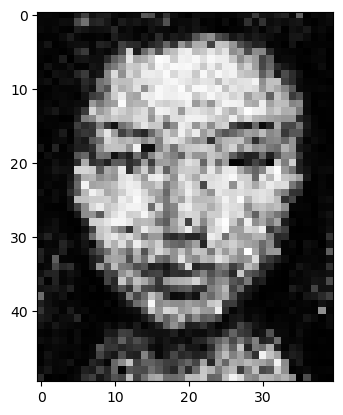

In [46]:
#150000
from numpy import array
import numpy as np
import matplotlib as plt
from matplotlib.pyplot import imshow,show
import matplotlib.image as img
from matplotlib.pyplot import subplots,close

a = g.predict(np.random.normal(0,1,(1,100)))

a = a*127.5 +127.5
print(np.shape(np.squeeze(a)))
imshow(np.array(np.squeeze(a)),cmap = 'gray')
show()

(50, 40)


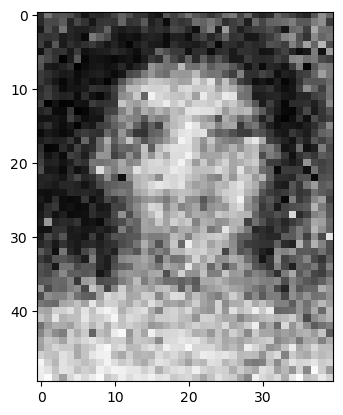

In [47]:
#50000
from numpy import array
import numpy as np
import matplotlib as plt
from matplotlib.pyplot import imshow,show
import matplotlib.image as img
from matplotlib.pyplot import subplots,close

a = g.predict(np.random.normal(0,1,(1,100)))

a = a*127.5 +127.5
print(np.shape(np.squeeze(a)))
imshow(np.array(np.squeeze(a)),cmap = 'gray')
show()

(50, 40)


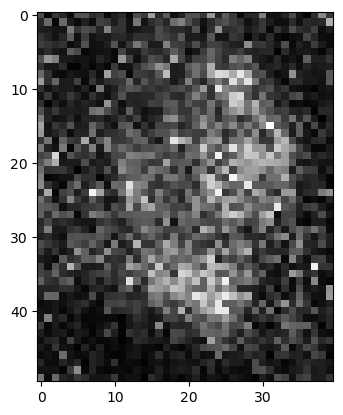

In [47]:
#10000
from numpy import array
import numpy as np
import matplotlib as plt
from matplotlib.pyplot import imshow,show
import matplotlib.image as img
from matplotlib.pyplot import subplots,close


a = 10 * a + 10
print(np.shape(np.squeeze(a)))
imshow(np.array(np.squeeze(a)),cmap = 'gray')
show()

(50, 40)


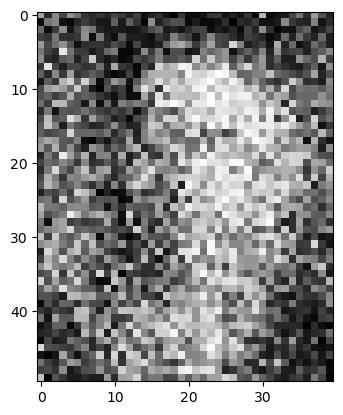

In [37]:
#1000
from numpy import array
import numpy as np
import matplotlib as plt
from matplotlib.pyplot import imshow,show
import matplotlib.image as img
from matplotlib.pyplot import subplots,close


a = 10 * a + 10
print(np.shape(np.squeeze(a)))
imshow(np.array(np.squeeze(a)),cmap = 'gray')
show()

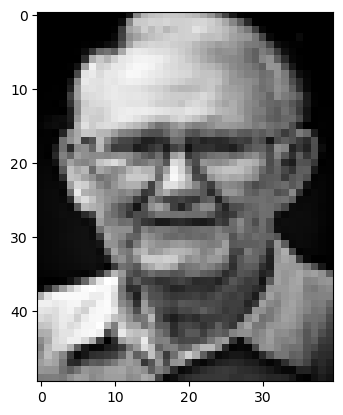

In [32]:
imshow(np.array(Image.open('New folder/Humans/{}'.format(im_list[0])).convert('L').resize((40,50))),cmap = 'gray')
show()